In [1]:
from deepcrypto.backtest import *
from deepcrypto.portfolio_analysis import *
from deepcrypto.data_utils.crawlers.bitfinex_kaggle import *
from deepcrypto.data_utils.crawlers.binance_crawler import *
from talib.abstract import *
from pprint import pprint

In [2]:
def strategy(df, config):
    ibsperiod = config["ibsperiod"]
    
    lowestlow = df.low.rolling(ibsperiod).min()
    highesthigh = df.high.rolling(ibsperiod).max()
    
    ibs = (df.close - lowestlow) / (highesthigh - lowestlow) * 100
    
    ibs_signal = ibs > config["ibsthres"]
    volume_signal = df.volume / df.volume.rolling(config["volumeperiod"]).mean()
    volume_signal = volume_signal > config["volumethres"]
    
    signal = volume_signal & ibs_signal
    
    df["enter_long"] = signal & (signal.diff() == 1)
    df["trade_cost"] = 0
    df["bet"] = np.clip(0.01 / df.close.pct_change().rolling(200).std(), 0.1, 2) * 2
    df["stop_loss"] = config["stop_loss"]
    df["take_profit"] = config["take_profit"]
    df["time_cut"] = config["time_cut"]
    return df

In [3]:
def backtest_and_report(config, ticker, db="binance"):
    if db=="bitfinex":
        data = read_bitfinex_data("/home/ych/Storage/bitfinex/bitfinex.db", "1H", ticker)
    else: data = read_binance_data("/home/ych/Storage/binance/binance.db", "1H", ticker)
    data = data.backtest.add_defaults()

    order, port = strategy(data, config).backtest()
    pprint(calc_from_order_df(order))
    qs.reports.full(port["portfolio_value"].resample("1D").last(), benchmark=port["open"].resample("1D").last())

backtest completed in 0.16615009307861328 seconds
{'bothside_avg_holding_bars': 10.381081081081081,
 'bothside_profit_factor': 1.192151255171867,
 'bothside_total_profit': 103507275.88732624,
 'bothside_total_trades': 370,
 'bothside_win_rate': 60.0,
 'buyside_avg_holding_bars': 10.381081081081081,
 'buyside_profit_factor': 1.192151255171867,
 'buyside_total_profit': 103507275.88732624,
 'buyside_total_trades': 370,
 'buyside_win_rate': 60.0,
 'sellside_avg_holding_bars': nan,
 'sellside_profit_factor': nan,
 'sellside_total_profit': 0.0,
 'sellside_total_trades': 0,
 'sellside_win_rate': nan}


/home/ych/PycharmProjects/DeepCrypto/deepcrypto/portfolio_analysis/__init__.py:7: RuntimeWarning: invalid value encountered in long_scalars
  a[f"{label}_win_rate"] = order_df.realized[order_df.realized >= 0].count()/order_df.realized.count() * 100


                           Strategy       Benchmark
-------------------------  -------------  -----------
Start Period               2016-03-18     2016-03-18
End Period                 2021-05-18     2021-05-18
Risk-Free Rate             0.0%           0.0%
Time in Market             26.0%          97.0%

Cumulative Return          1,035,072.76%  31,191.55%
CAGR%                      497.89%        203.87%

Sharpe                     2.35           1.31
Sortino                    6.14           2.07
Sortino/√2                 4.34           1.46

Max Drawdown               -28.9%         -93.85%
Longest DD Days            146            1101
Volatility (ann.)          59.62%         87.76%
R^2                        0.11           0.11
Calmar                     17.23          2.17
Skew                       4.06           0.38
Kurtosis                   29.17          5.56

Expected Daily %           0.49%          0.3%
Expected Monthly %         15.81%         9.55%
Expected Yearly 

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2020-09-17  2020-11-02  2021-01-06   111    -28.904023        -28.689243
2  2018-08-18  2018-11-11  2018-12-23   127    -17.886347        -16.173762
3  2020-01-08  2020-01-12  2020-01-14     6    -16.118678        -14.245899
4  2019-02-27  2019-03-15  2019-03-16    17    -16.092306        -12.465893
5  2021-04-09  2021-04-12  2021-05-03    24    -15.444556         -7.011955

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


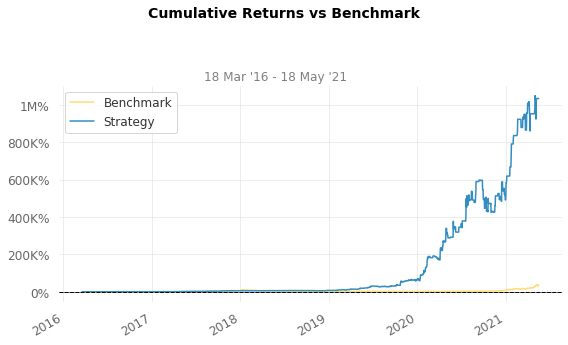

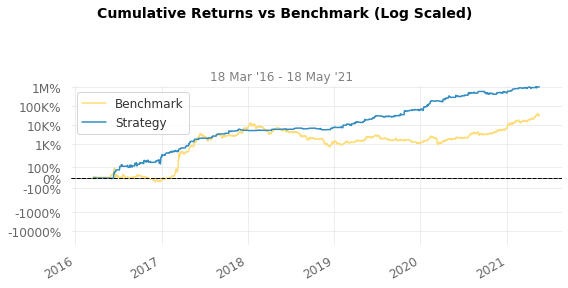

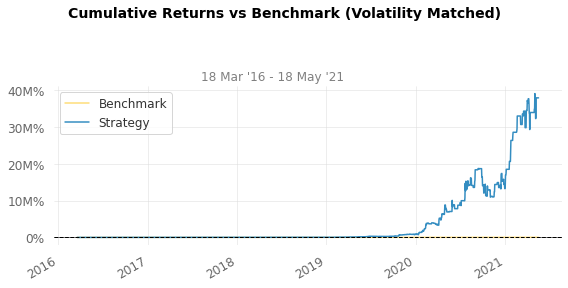

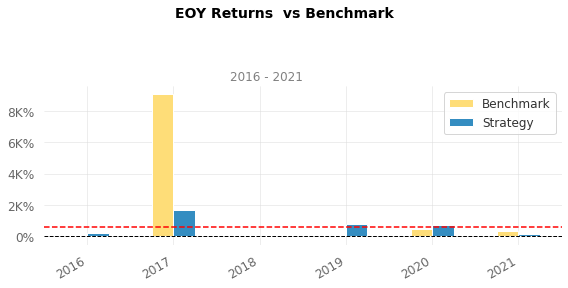

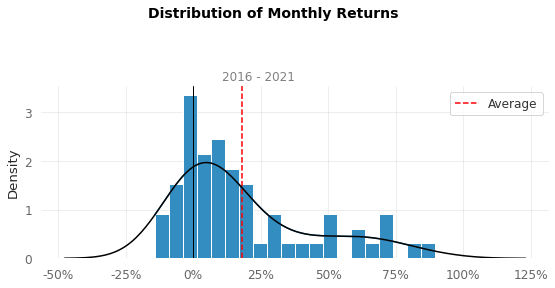

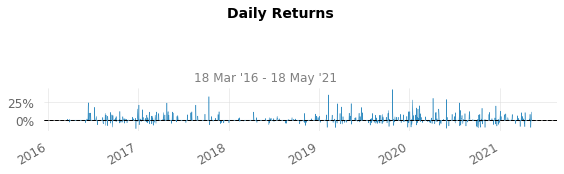

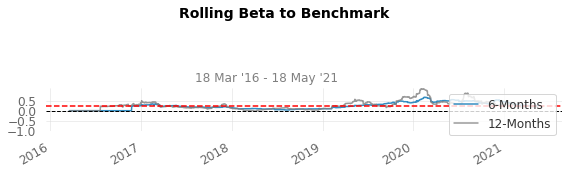

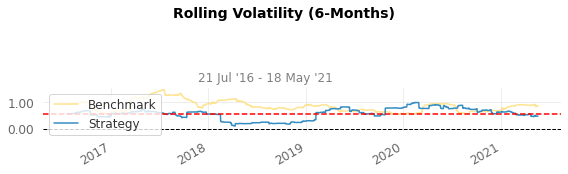

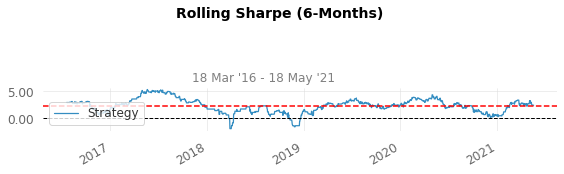

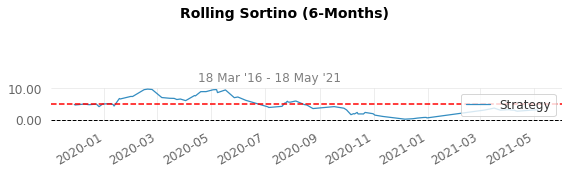

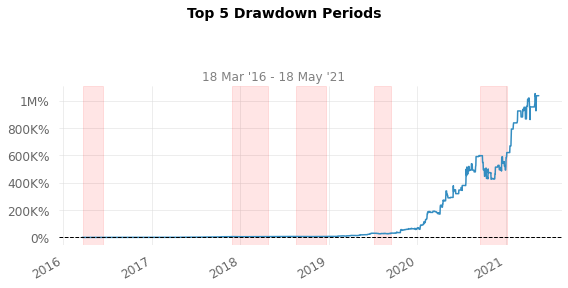

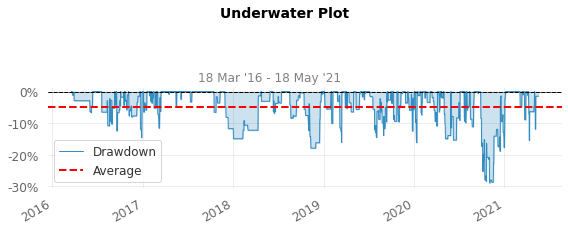

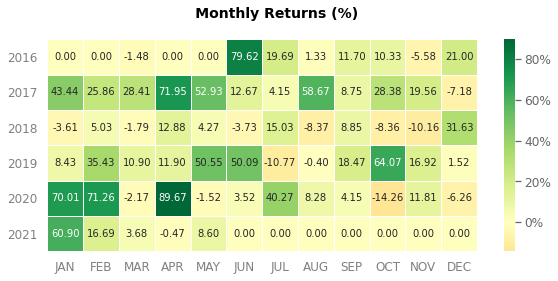

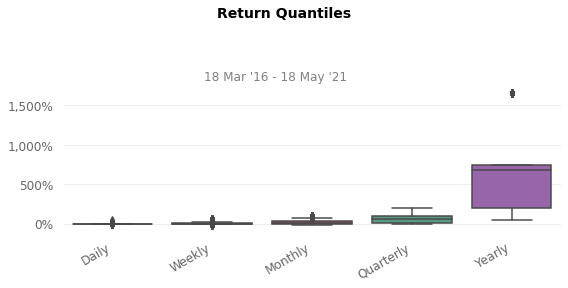

In [4]:
DEFAULT_CONFIG = {'time_cut': 12,
 'stop_loss': 0.03,
 'take_profit': 0.1,
 'ibsperiod': 24,
 'ibsthres': 70,
 'volumeperiod': 24,
 'volumethres': 4}

backtest_and_report(DEFAULT_CONFIG, "ETHUSD", "bitfinex")

backtest completed in 0.041214942932128906 seconds
{'bothside_avg_holding_bars': 10.476744186046512,
 'bothside_profit_factor': 1.7535474040336065,
 'bothside_total_profit': 171575.02939239418,
 'bothside_total_trades': 86,
 'bothside_win_rate': 63.95348837209303,
 'buyside_avg_holding_bars': 10.476744186046512,
 'buyside_profit_factor': 1.7535474040336065,
 'buyside_total_profit': 171575.02939239418,
 'buyside_total_trades': 86,
 'buyside_win_rate': 63.95348837209303,
 'sellside_avg_holding_bars': nan,
 'sellside_profit_factor': nan,
 'sellside_total_profit': 0.0,
 'sellside_total_trades': 0,
 'sellside_win_rate': nan}


/home/ych/PycharmProjects/DeepCrypto/deepcrypto/portfolio_analysis/__init__.py:7: RuntimeWarning: invalid value encountered in long_scalars
  a[f"{label}_win_rate"] = order_df.realized[order_df.realized >= 0].count()/order_df.realized.count() * 100


                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2017-08-25  2017-08-25
End Period                 2021-05-09  2021-05-09
Risk-Free Rate             0.0%        0.0%
Time in Market             9.0%        100.0%

Cumulative Return          1,721.90%   1,085.61%
CAGR%                      118.8%      94.86%

Sharpe                     1.56        0.98
Sortino                    4.47        1.44
Sortino/√2                 3.16        1.02

Max Drawdown               -19.73%     -93.98%
Longest DD Days            191         1101
Volatility (ann.)          38.96%      80.74%
R^2                        0.05        0.05
Calmar                     6.02        1.01
Skew                       7.78        -0.15
Kurtosis                   100.01      4.05

Expected Daily %           0.21%       0.18%
Expected Monthly %         6.51%       5.52%
Expected Yearly %          78.69%      63.98%
Kelly Criterion            34

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2018-06-15  2018-11-01  2018-12-23   191    -19.733661        -19.008015
2  2019-11-10  2019-12-30  2020-01-14    65    -17.932541        -17.442073
3  2019-03-06  2019-04-07  2019-05-07    62    -16.231024        -16.213240
4  2020-03-20  2020-04-02  2020-04-06    17    -11.463600         -4.219939
5  2020-10-06  2020-10-06  2020-12-17    72    -10.916179         -9.233498

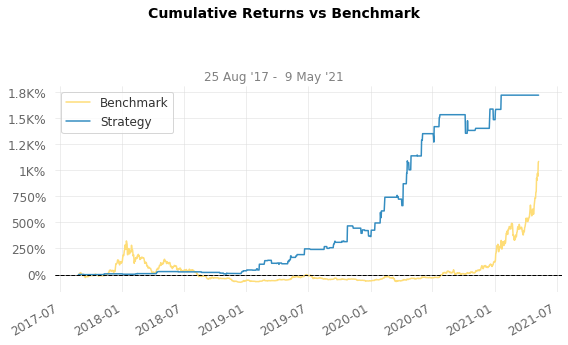

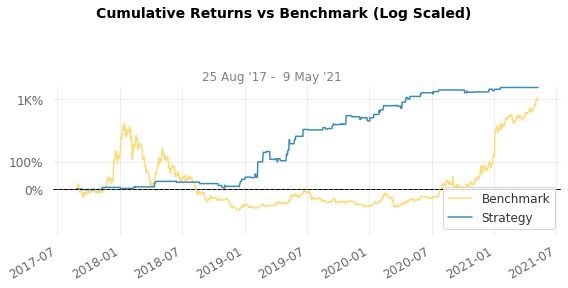

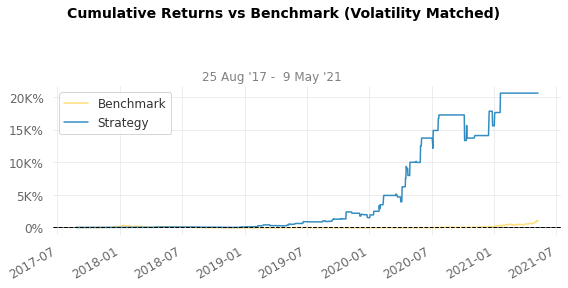

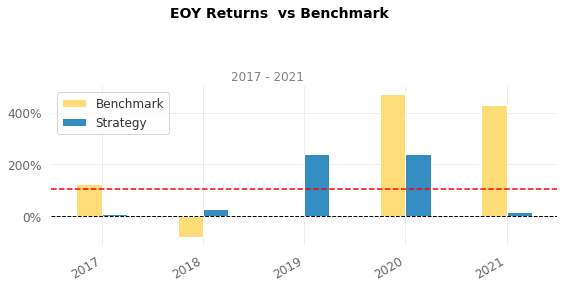

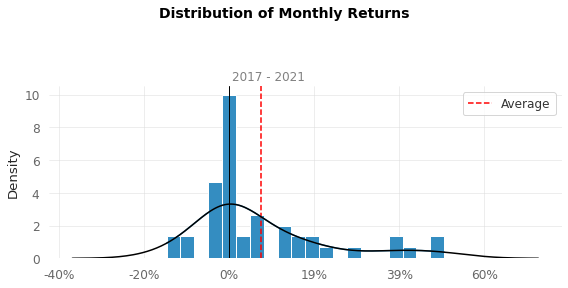

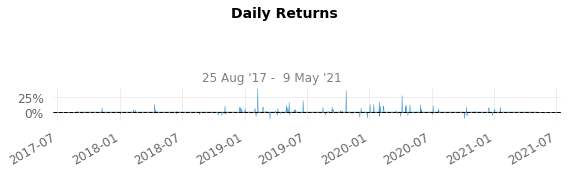

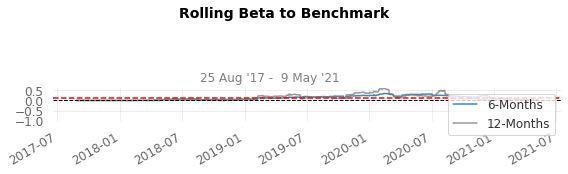

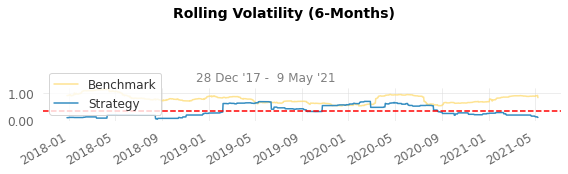

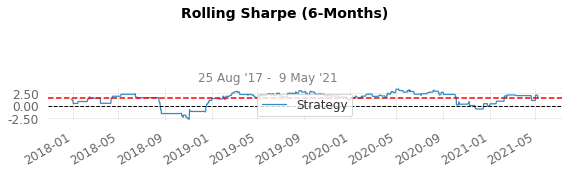

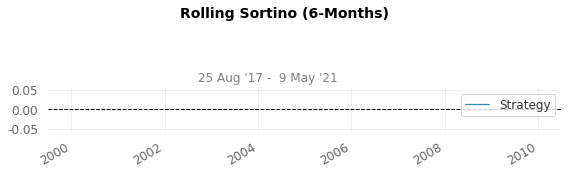

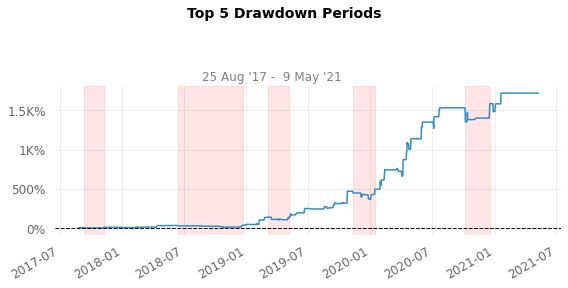

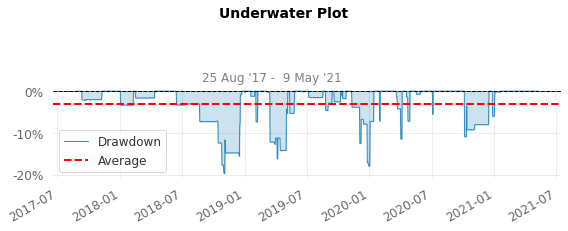

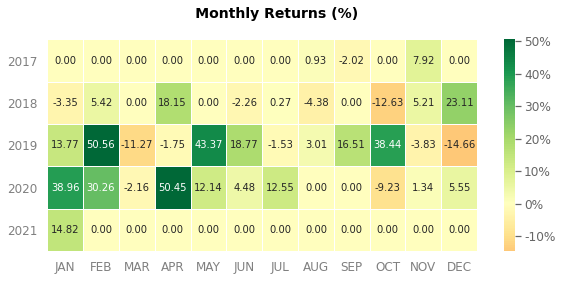

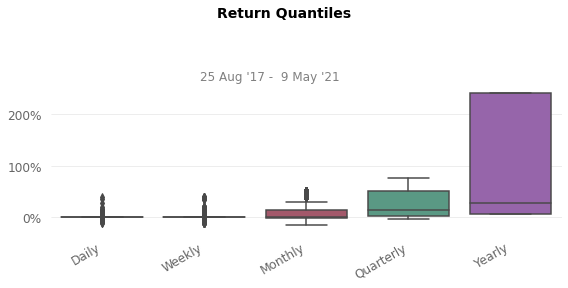

In [5]:
backtest_and_report(DEFAULT_CONFIG, "ETHUSDT", "binance")

backtest completed in 0.08988618850708008 seconds
{'bothside_avg_holding_bars': 18.869646182495345,
 'bothside_profit_factor': 1.2751240000768924,
 'bothside_total_profit': 2777920169.757169,
 'bothside_total_trades': 537,
 'bothside_win_rate': 53.81750465549349,
 'buyside_avg_holding_bars': 18.869646182495345,
 'buyside_profit_factor': 1.2751240000768924,
 'buyside_total_profit': 2777920169.757169,
 'buyside_total_trades': 537,
 'buyside_win_rate': 53.81750465549349,
 'sellside_avg_holding_bars': nan,
 'sellside_profit_factor': nan,
 'sellside_total_profit': 0.0,
 'sellside_total_trades': 0,
 'sellside_win_rate': nan}


/home/ych/PycharmProjects/DeepCrypto/deepcrypto/portfolio_analysis/__init__.py:7: RuntimeWarning: invalid value encountered in long_scalars
  a[f"{label}_win_rate"] = order_df.realized[order_df.realized >= 0].count()/order_df.realized.count() * 100


                           Strategy        Benchmark
-------------------------  --------------  -----------
Start Period               2013-04-09      2013-04-09
End Period                 2021-05-18      2021-05-18
Risk-Free Rate             0.0%            0.0%
Time in Market             30.0%           96.0%

Cumulative Return          27,779,201.70%  18,597.53%
CAGR%                      368.86%         90.56%

Sharpe                     2.02            0.99
Sortino                    5.32            1.48
Sortino/√2                 3.76            1.04

Max Drawdown               -30.71%         -84.25%
Longest DD Days            184             1126
Volatility (ann.)          61.3%           69.36%
R^2                        0.1             0.1
Calmar                     12.01           1.07
Skew                       5.38            0.14
Kurtosis                   55.26           10.5

Expected Daily %           0.42%           0.18%
Expected Monthly %         13.64%          5.4

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2020-05-17  2020-07-22  2020-11-17   184    -30.709124        -29.668492
2  2019-08-06  2019-10-21  2019-11-27   113    -28.454738        -27.592633
3  2020-02-19  2020-04-02  2020-04-29    70    -27.420761        -24.038426
4  2014-03-09  2014-05-11  2014-05-22    74    -27.055297        -25.433348
5  2013-04-27  2013-06-20  2013-07-31    95    -24.196672        -20.894140

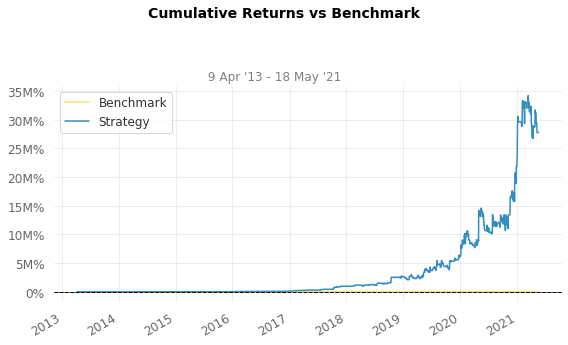

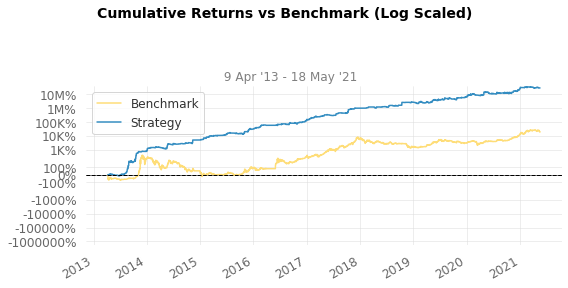

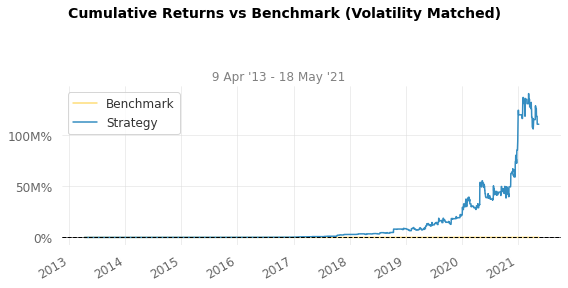

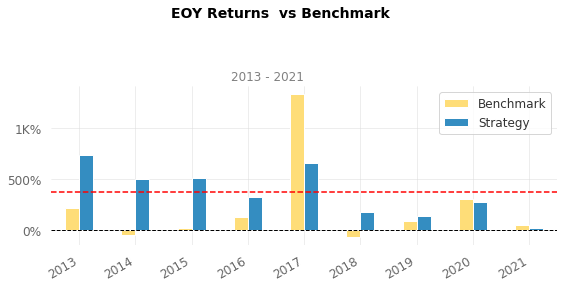

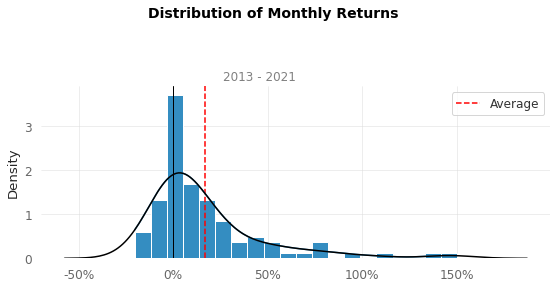

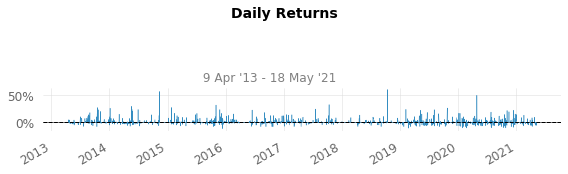

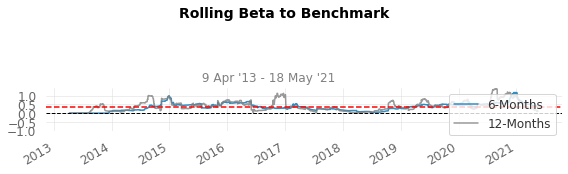

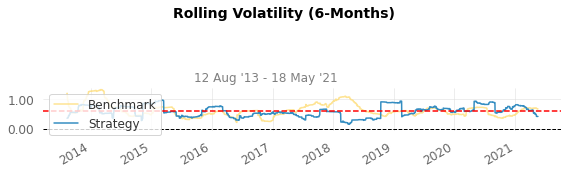

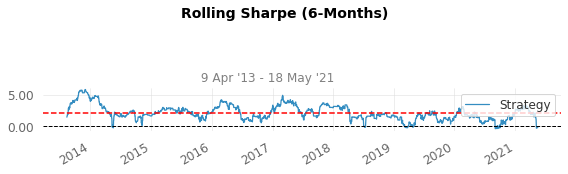

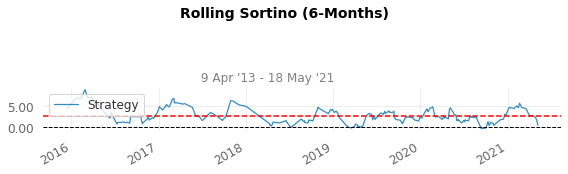

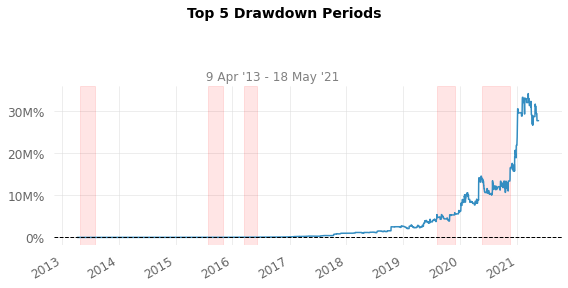

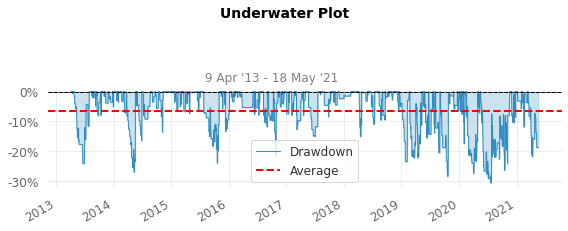

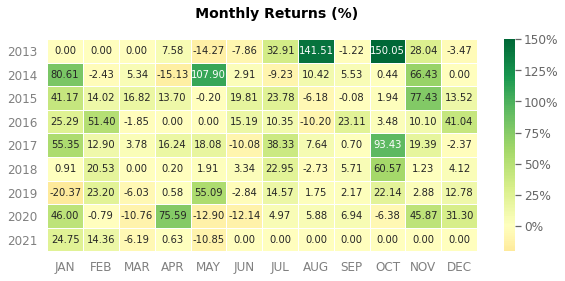

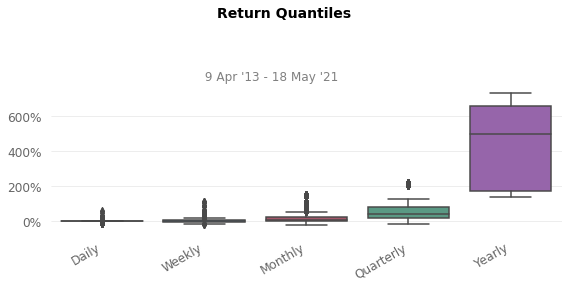

In [6]:
DEFAULT_CONFIG = {'time_cut': 24,
 'stop_loss': 0.02,
 'take_profit': 0.15,
 'ibsperiod': 48,
 'ibsthres': 70,
 'volumeperiod': 24,
 'volumethres': 4}

backtest_and_report(DEFAULT_CONFIG, "BTCUSD", "bitfinex")

backtest completed in 0.04024219512939453 seconds
{'bothside_avg_holding_bars': 17.05263157894737,
 'bothside_profit_factor': 2.3732342395738972,
 'bothside_total_profit': 56235.11522736679,
 'bothside_total_trades': 76,
 'bothside_win_rate': 47.368421052631575,
 'buyside_avg_holding_bars': 17.05263157894737,
 'buyside_profit_factor': 2.3732342395738972,
 'buyside_total_profit': 56235.11522736679,
 'buyside_total_trades': 76,
 'buyside_win_rate': 47.368421052631575,
 'sellside_avg_holding_bars': nan,
 'sellside_profit_factor': nan,
 'sellside_total_profit': 0.0,
 'sellside_total_trades': 0,
 'sellside_win_rate': nan}


/home/ych/PycharmProjects/DeepCrypto/deepcrypto/portfolio_analysis/__init__.py:7: RuntimeWarning: invalid value encountered in long_scalars
  a[f"{label}_win_rate"] = order_df.realized[order_df.realized >= 0].count()/order_df.realized.count() * 100


                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2017-08-25  2017-08-25
End Period                 2021-05-09  2021-05-09
Risk-Free Rate             0.0%        0.0%
Time in Market             10.0%       100.0%

Cumulative Return          562.35%     1,267.92%
CAGR%                      66.54%      102.52%

Sharpe                     1.1         1.07
Sortino                    2.59        1.6
Sortino/√2                 1.83        1.13

Max Drawdown               -27.43%     -83.38%
Longest DD Days            479         1079
Volatility (ann.)          37.86%      65.55%
R^2                        0.05        0.05
Calmar                     2.43        1.23
Skew                       6.76        -0.07
Kurtosis                   82.75       4.36

Expected Daily %           0.14%       0.19%
Expected Monthly %         4.2%        5.85%
Expected Yearly %          45.95%      68.74%
Kelly Criterion            26

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2019-01-06  2019-08-26  2020-04-29   479    -27.428289        -25.665272
2  2021-02-16  2021-04-10  2021-05-09    82    -11.196684         -3.571564
3  2020-11-01  2020-11-30  2020-12-16    45     -7.993713         -3.742740
4  2020-08-18  2020-08-18  2020-10-09    52     -6.606529         -1.071841
5  2018-08-22  2018-09-19  2018-10-16    55     -6.471719         -4.979412

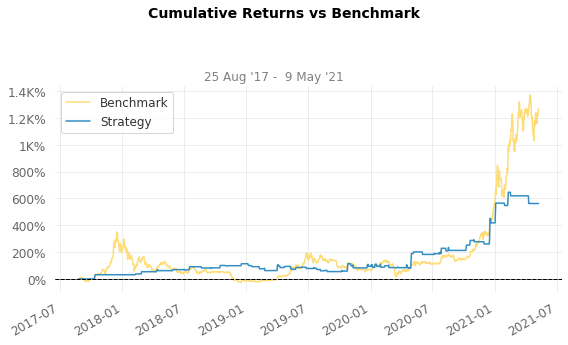

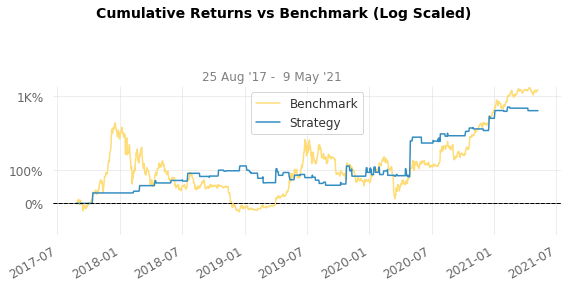

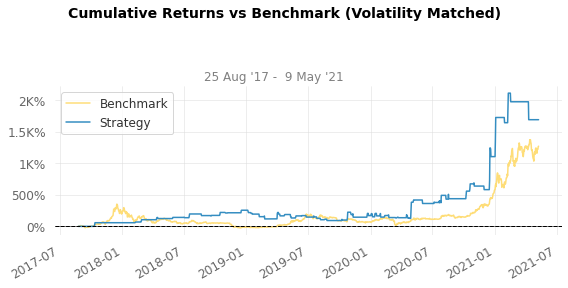

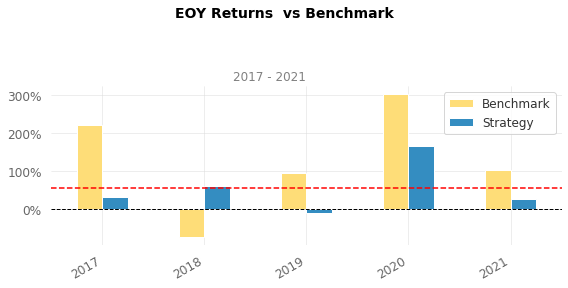

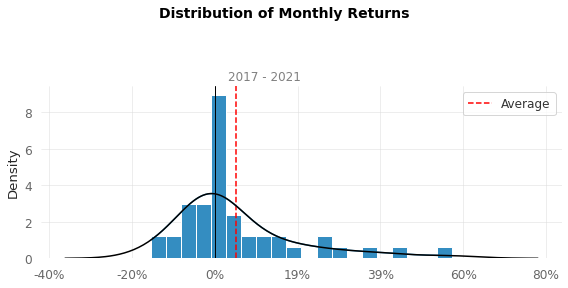

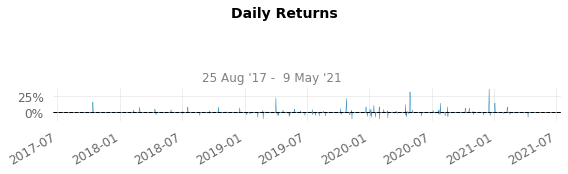

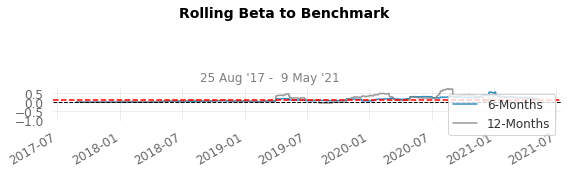

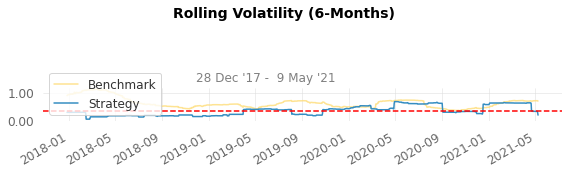

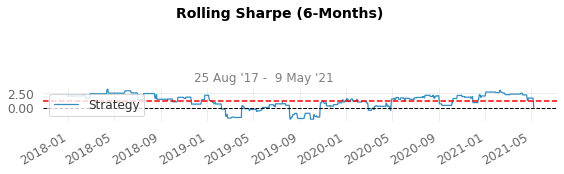

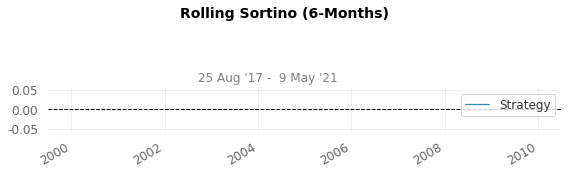

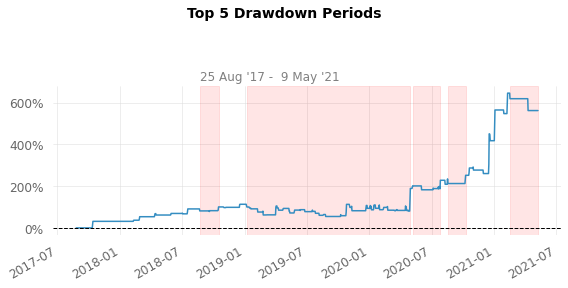

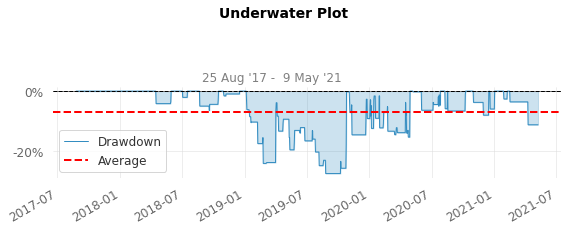

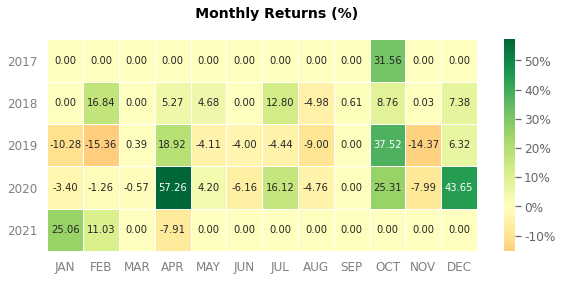

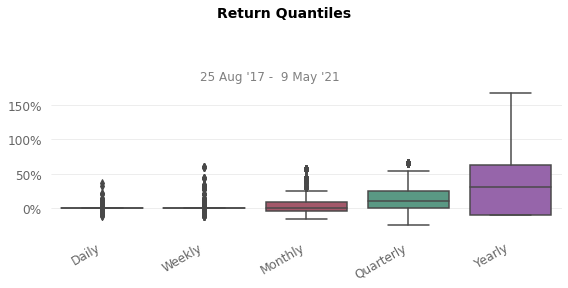

In [7]:
backtest_and_report(DEFAULT_CONFIG, "BTCUSDT", "binance")

In [8]:
import ray
from ray import tune
def optimizer(config, df):
    df = df.copy()
    order_df, port_df = run_backtest_df(strategy(df, config))
    tune.report(sortino=qs.stats.sortino(port_df["portfolio_value"].resample("1D").last()))

def optimize(df):
    result = tune.run(
        tune.with_parameters(optimizer, df=df),
        config = {
            "time_cut" : tune.grid_search([12, 24, 48]),
            "stop_loss" : tune.grid_search([0.02, 0.03, 0.05]),
            "take_profit" : tune.grid_search([0.05, 0.1, 0.15, 0.2]),
            'ibsperiod' : tune.grid_search([12, 24, 48]),
            'ibsthres' : tune.grid_search([70, 80, 90]),
            'volumeperiod' : tune.grid_search([6, 12, 24]),
            'volumethres' : tune.grid_search([3, 4, 5]),
        },
        local_dir="./ray_results",
    )
    return result

/home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  "update your install command.", FutureWarning)


In [9]:
ray.init()

2021-05-28 00:50:46,788	INFO services.py:1269 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.68.106',
 'raylet_ip_address': '192.168.68.106',
 'redis_address': '192.168.68.106:6379',
 'object_store_address': '/tmp/ray/session_2021-05-28_00-50-45_816813_518742/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-05-28_00-50-45_816813_518742/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-05-28_00-50-45_816813_518742',
 'metrics_export_port': 39230,
 'node_id': '83157cfa49188206c49a4b3ce5efb6ea43fd70f0d2792d453f04cabe'}

In [11]:
data = read_binance_data("/home/ych/Storage/binance/binance.db", "1H", "BTCUSDT")
data = data.backtest.add_defaults()

In [12]:
data = data[:int(data.index.__len__() * 0.7)]

In [ ]:
result = optimize(data)

2021-05-28 02:20:40,390	WARNING function_runner.py:545 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.
2021-05-28 02:20:40,698	WARNING tune.py:494 -- Tune detects GPUs, but no trials are using GPUs. To enable trials to use GPUs, set tune.run(resources_per_trial={'gpu': 1}...) which allows Tune to expose 1 GPU to each trial. You can also override `Trainable.default_resource_request` if using the Trainable API.


(pid=518959) backtest completed in 0.40555715560913086 seconds
Result for optimizer_dc29b_00000:
  date: 2021-05-28_02-20-45
  done: false
  experiment_id: fbc0c71968ab49e08db0487f3087d2fa
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 518959
  sortino: 3.5483054368388234
  time_since_restore: 0.5240099430084229
  time_this_iter_s: 0.5240099430084229
  time_total_s: 0.5240099430084229
  timestamp: 1622136045
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00000
  
Result for optimizer_dc29b_00000:
  date: 2021-05-28_02-20-45
  done: true
  experiment_id: fbc0c71968ab49e08db0487f3087d2fa
  experiment_tag: 0_ibsperiod=12,ibsthres=70,stop_loss=0.02,take_profit=0.05,time_cut=12,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 518959
  sortino: 3.5483054368388234
  time_since_restore: 0.5240099430084229
  time_this_iter_s: 0.5240099430084229
  time_total_s: 0.524

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00004:
  date: 2021-05-28_02-20-46
  done: true
  experiment_id: 94649bb916ce45f3bcc3a9f65f5e18db
  experiment_tag: 4_ibsperiod=24,ibsthres=80,stop_loss=0.02,take_profit=0.05,time_cut=12,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 518958
  sortino: 3.2771206156938155
  time_since_restore: 0.7845709323883057
  time_this_iter_s: 0.7845709323883057
  time_total_s: 0.7845709323883057
  timestamp: 1622136046
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00004
  
(pid=518950) backtest completed in 0.6988389492034912 seconds
Result for optimizer_dc29b_00005:
  date: 2021-05-28_02-20-46
  done: false
  experiment_id: 6e326192693f497fb0d850aeabdafa85
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 518950
  sortino: 2.1208399936169995
  time_since_restore: 0.8742530345916748
  time_this_iter_s: 0.8742530345916748
  time_total_s: 0.8742

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00008:
  date: 2021-05-28_02-20-46
  done: false
  experiment_id: 2b6f52c2d28143388442014ff90573f5
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 518954
  sortino: 2.225098864427148
  time_since_restore: 0.6392345428466797
  time_this_iter_s: 0.6392345428466797
  time_total_s: 0.6392345428466797
  timestamp: 1622136046
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00008
  
Result for optimizer_dc29b_00005:
  date: 2021-05-28_02-20-46
  done: true
  experiment_id: 6e326192693f497fb0d850aeabdafa85
  experiment_tag: 5_ibsperiod=48,ibsthres=80,stop_loss=0.02,take_profit=0.05,time_cut=12,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 518950
  sortino: 2.1208399936169995
  time_since_restore: 0.8742530345916748
  time_this_iter_s: 0.8742530345916748
  time_total_s: 0.8742530345916748
  timestamp: 1622136046
  timesteps_since_restore:

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00001:
  date: 2021-05-28_02-20-46
  done: false
  experiment_id: 84f32816dd984d74bc49ba8971f6f594
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 518952
  sortino: 3.133739769184199
  time_since_restore: 0.8524096012115479
  time_this_iter_s: 0.8524096012115479
  time_total_s: 0.8524096012115479
  timestamp: 1622136046
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00001
  
(pid=518953) backtest completed in 0.2890446186065674 seconds
Result for optimizer_dc29b_00010:
  date: 2021-05-28_02-20-46
  done: false
  experiment_id: 1815fdf54ed945fc822324002d023193
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 518956
  sortino: 2.8949741142249295
  time_since_restore: 0.48158812522888184
  time_this_iter_s: 0.48158812522888184
  time_total_s: 0.48158812522888184
  timestamp: 1622136046
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00010
 

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00006:
  date: 2021-05-28_02-20-46
  done: false
  experiment_id: 284c711ebe4a4a7c8446924aa100f08f
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 518957
  sortino: 1.9887714751319574
  time_since_restore: 0.4144246578216553
  time_this_iter_s: 0.4144246578216553
  time_total_s: 0.4144246578216553
  timestamp: 1622136046
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00006
  
Result for optimizer_dc29b_00009:
  date: 2021-05-28_02-20-46
  done: false
  experiment_id: 832b696c6b1c48bb9ea9859ad0eb3dca
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 518961
  sortino: 3.573272574118147
  time_since_restore: 0.36740660667419434
  time_this_iter_s: 0.36740660667419434
  time_total_s: 0.36740660667419434
  timestamp: 1622136046
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00009
  


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00006:
  date: 2021-05-28_02-20-46
  done: true
  experiment_id: 284c711ebe4a4a7c8446924aa100f08f
  experiment_tag: 6_ibsperiod=12,ibsthres=90,stop_loss=0.02,take_profit=0.05,time_cut=12,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 518957
  sortino: 1.9887714751319574
  time_since_restore: 0.4144246578216553
  time_this_iter_s: 0.4144246578216553
  time_total_s: 0.4144246578216553
  timestamp: 1622136046
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00006
  
Result for optimizer_dc29b_00009:
  date: 2021-05-28_02-20-46
  done: true
  experiment_id: 832b696c6b1c48bb9ea9859ad0eb3dca
  experiment_tag: 9_ibsperiod=12,ibsthres=70,stop_loss=0.03,take_profit=0.05,time_cut=12,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 518961
  sortino: 3.573272574118147
  time_since_restore: 0.36740660667419434
  time

(pid=534368) backtest completed in 0.44848203659057617 seconds
Result for optimizer_dc29b_00014:
  date: 2021-05-28_02-20-49
  done: false
  experiment_id: d13dba1a5e304b43ab8c4a3c6af65715
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 534368
  sortino: 2.247739862100126
  time_since_restore: 0.5680041313171387
  time_this_iter_s: 0.5680041313171387
  time_total_s: 0.5680041313171387
  timestamp: 1622136049
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00014
  
Result for optimizer_dc29b_00014:
  date: 2021-05-28_02-20-49
  done: true
  experiment_id: d13dba1a5e304b43ab8c4a3c6af65715
  experiment_tag: 14_ibsperiod=48,ibsthres=80,stop_loss=0.03,take_profit=0.05,time_cut=12,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 534368
  sortino: 2.247739862100126
  time_since_restore: 0.5680041313171387
  time_this_iter_s: 0.5680041313171387
  time_total_s: 0.5680

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)



(pid=534386) backtest completed in 0.31211280822753906 seconds
Result for optimizer_dc29b_00018:
  date: 2021-05-28_02-20-50
  done: false
  experiment_id: 9c6d5c6fcdc0432c8083d5f9bfbb960a
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 534386
  sortino: 2.479492868727827
  time_since_restore: 0.4849245548248291
  time_this_iter_s: 0.4849245548248291
  time_total_s: 0.4849245548248291
  timestamp: 1622136050
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00018
  
Result for optimizer_dc29b_00018:
  date: 2021-05-28_02-20-50
  done: true
  experiment_id: 9c6d5c6fcdc0432c8083d5f9bfbb960a
  experiment_tag: 18_ibsperiod=12,ibsthres=70,stop_loss=0.05,take_profit=0.05,time_cut=12,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 534386
  sortino: 2.479492868727827
  time_since_restore: 0.4849245548248291
  time_this_iter_s: 0.4849245548248291
  time_total_s: 0.484

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=534360) backtest completed in 0.7830367088317871 seconds
Result for optimizer_dc29b_00017:
  date: 2021-05-28_02-20-50
  done: false
  experiment_id: 54d80f41449147c197a365d45335c40d
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 534360
  sortino: 2.2794024470846423
  time_since_restore: 0.9777650833129883
  time_this_iter_s: 0.9777650833129883
  time_total_s: 0.9777650833129883
  timestamp: 1622136050
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00017
  
Result for optimizer_dc29b_00017:
  date: 2021-05-28_02-20-50
  done: true
  experiment_id: 54d80f41449147c197a365d45335c40d
  experiment_tag: 17_ibsperiod=48,ibsthres=90,stop_loss=0.03,take_profit=0.05,time_cut=12,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 534360
  sortino: 2.2794024470846423
  time_since_restore: 0.9777650833129883
  time_this_iter_s: 0.9777650833129883
  time_total_s: 0.977

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00023:
  date: 2021-05-28_02-20-51
  done: true
  experiment_id: e192d53ee872496f8af9474558cbadbc
  experiment_tag: 23_ibsperiod=48,ibsthres=80,stop_loss=0.05,take_profit=0.05,time_cut=12,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 534374
  sortino: 1.2260870668280928
  time_since_restore: 0.5313894748687744
  time_this_iter_s: 0.5313894748687744
  time_total_s: 0.5313894748687744
  timestamp: 1622136051
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00023
  
(pid=534374) backtest completed in 0.4037036895751953 seconds
(pid=534534) backtest completed in 0.839569091796875 seconds
Result for optimizer_dc29b_00020:
  date: 2021-05-28_02-20-51
  done: false
  experiment_id: 5d4e20445297487ca14173df2ca6194a
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 534534
  sortino: 1.5258865340510253
  time_since_restore: 1.0921201705932617

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=534551) backtest completed in 0.7208206653594971 seconds
Result for optimizer_dc29b_00021:
  date: 2021-05-28_02-20-51
  done: false
  experiment_id: aa7aa1bd25c74e62b1113cc85c624079
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 534551
  sortino: 2.180056945220341
  time_since_restore: 0.959298849105835
  time_this_iter_s: 0.959298849105835
  time_total_s: 0.959298849105835
  timestamp: 1622136051
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00021
  
Result for optimizer_dc29b_00021:
  date: 2021-05-28_02-20-51
  done: true
  experiment_id: aa7aa1bd25c74e62b1113cc85c624079
  experiment_tag: 21_ibsperiod=12,ibsthres=80,stop_loss=0.05,take_profit=0.05,time_cut=12,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 534551
  sortino: 2.180056945220341
  time_since_restore: 0.959298849105835
  time_this_iter_s: 0.959298849105835
  time_total_s: 0.9592988491

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=534485) backtest completed in 0.5203261375427246 seconds
Result for optimizer_dc29b_00022:
  date: 2021-05-28_02-20-52
  done: false
  experiment_id: d7d4aed8afb54a738d2c2e2442707023
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 534485
  sortino: 2.3305252865461905
  time_since_restore: 0.6589217185974121
  time_this_iter_s: 0.6589217185974121
  time_total_s: 0.6589217185974121
  timestamp: 1622136052
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00022
  
Result for optimizer_dc29b_00022:
  date: 2021-05-28_02-20-52
  done: true
  experiment_id: d7d4aed8afb54a738d2c2e2442707023
  experiment_tag: 22_ibsperiod=24,ibsthres=80,stop_loss=0.05,take_profit=0.05,time_cut=12,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 534485
  sortino: 2.3305252865461905
  time_since_restore: 0.6589217185974121
  time_this_iter_s: 0.6589217185974121
  time_total_s: 0.658

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=534784) backtest completed in 0.26740550994873047 seconds
Result for optimizer_dc29b_00026:
  date: 2021-05-28_02-20-53
  done: false
  experiment_id: f69999db0d4c40048e6c7211a7042363
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 534784
  sortino: 1.23742992029928
  time_since_restore: 0.3489646911621094
  time_this_iter_s: 0.3489646911621094
  time_total_s: 0.3489646911621094
  timestamp: 1622136053
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00026
  
Result for optimizer_dc29b_00026:
  date: 2021-05-28_02-20-53
  done: true
  experiment_id: f69999db0d4c40048e6c7211a7042363
  experiment_tag: 26_ibsperiod=48,ibsthres=90,stop_loss=0.05,take_profit=0.05,time_cut=12,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 534784
  sortino: 1.23742992029928
  time_since_restore: 0.3489646911621094
  time_this_iter_s: 0.3489646911621094
  time_total_s: 0.348964

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00031:
  date: 2021-05-28_02-20-55
  done: true
  experiment_id: eed880cfe5064f578c11e6469cadf1d4
  experiment_tag: 31_ibsperiod=24,ibsthres=80,stop_loss=0.02,take_profit=0.1,time_cut=12,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 534768
  sortino: 3.827689387515484
  time_since_restore: 0.8121495246887207
  time_this_iter_s: 0.8121495246887207
  time_total_s: 0.8121495246887207
  timestamp: 1622136055
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00031
  


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=534779) backtest completed in 0.3630077838897705 seconds
Result for optimizer_dc29b_00027:
  date: 2021-05-28_02-20-55
  done: false
  experiment_id: 883ecaa1586949e49f3e4fc8e9494e8b
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 534779
  sortino: 3.994703642551465
  time_since_restore: 0.43701958656311035
  time_this_iter_s: 0.43701958656311035
  time_total_s: 0.43701958656311035
  timestamp: 1622136055
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00027
  
Result for optimizer_dc29b_00027:
  date: 2021-05-28_02-20-55
  done: true
  experiment_id: 883ecaa1586949e49f3e4fc8e9494e8b
  experiment_tag: 27_ibsperiod=12,ibsthres=70,stop_loss=0.02,take_profit=0.1,time_cut=12,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 534779
  sortino: 3.994703642551465
  time_since_restore: 0.43701958656311035
  time_this_iter_s: 0.43701958656311035
  time_total_s: 0.4

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00034:
  date: 2021-05-28_02-20-55
  done: true
  experiment_id: f3da7c6dd4f847a09f8d4aa95c2ebce2
  experiment_tag: 34_ibsperiod=24,ibsthres=90,stop_loss=0.02,take_profit=0.1,time_cut=12,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 534802
  sortino: 2.401804069766648
  time_since_restore: 1.0820140838623047
  time_this_iter_s: 1.0820140838623047
  time_total_s: 1.0820140838623047
  timestamp: 1622136055
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00034
  
(pid=534772) backtest completed in 0.4663519859313965 seconds
Result for optimizer_dc29b_00024:
  date: 2021-05-28_02-20-55
  done: false
  experiment_id: a4ea30bf6810475486a42a6d4b79be1c
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 534838
  sortino: 1.2409260796884796
  time_since_restore: 1.0262057781219482
  time_this_iter_s: 1.0262057781219482
  time_total_s: 1.02620

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00033:
  date: 2021-05-28_02-20-55
  done: false
  experiment_id: bfcafddf080140158130e06b759293b7
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 534772
  sortino: 2.076832792044489
  time_since_restore: 0.6149470806121826
  time_this_iter_s: 0.6149470806121826
  time_total_s: 0.6149470806121826
  timestamp: 1622136055
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00033
  
Result for optimizer_dc29b_00033:
  date: 2021-05-28_02-20-55
  done: true
  experiment_id: bfcafddf080140158130e06b759293b7
  experiment_tag: 33_ibsperiod=12,ibsthres=90,stop_loss=0.02,take_profit=0.1,time_cut=12,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 534772
  sortino: 2.076832792044489
  time_since_restore: 0.6149470806121826
  time_this_iter_s: 0.6149470806121826
  time_total_s: 0.6149470806121826
  timestamp: 1622136055
  timesteps_since_restore: 

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=534782) backtest completed in 0.5125119686126709 seconds
Result for optimizer_dc29b_00035:
  date: 2021-05-28_02-20-56
  done: false
  experiment_id: 9818e24595204ff080b0665f16e17526
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 534782
  sortino: 2.317852298288342
  time_since_restore: 0.651862382888794
  time_this_iter_s: 0.651862382888794
  time_total_s: 0.651862382888794
  timestamp: 1622136056
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00035
  
Result for optimizer_dc29b_00035:
  date: 2021-05-28_02-20-56
  done: true
  experiment_id: 9818e24595204ff080b0665f16e17526
  experiment_tag: 35_ibsperiod=48,ibsthres=90,stop_loss=0.02,take_profit=0.1,time_cut=12,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 534782
  sortino: 2.317852298288342
  time_since_restore: 0.651862382888794
  time_this_iter_s: 0.651862382888794
  time_total_s: 0.65186238288

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00036:
  date: 2021-05-28_02-20-57
  done: false
  experiment_id: aebd7133b39744d391cf243203237f39
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 534977
  sortino: 4.099740755051423
  time_since_restore: 0.3353862762451172
  time_this_iter_s: 0.3353862762451172
  time_total_s: 0.3353862762451172
  timestamp: 1622136057
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00036
  
(pid=534977) backtest completed in 0.2389659881591797 seconds
Result for optimizer_dc29b_00036:
  date: 2021-05-28_02-20-57
  done: true
  experiment_id: aebd7133b39744d391cf243203237f39
  experiment_tag: 36_ibsperiod=12,ibsthres=70,stop_loss=0.03,take_profit=0.1,time_cut=12,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 534977
  sortino: 4.099740755051423
  time_since_restore: 0.3353862762451172
  time_this_iter_s: 0.3353862762451172
  time_total_s: 0.335386

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00041:
  date: 2021-05-28_02-20-58
  done: false
  experiment_id: be888a1535aa4775ac9fe12c0d29bee0
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 535245
  sortino: 2.8738959197019844
  time_since_restore: 0.43961334228515625
  time_this_iter_s: 0.43961334228515625
  time_total_s: 0.43961334228515625
  timestamp: 1622136058
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00041
  
Result for optimizer_dc29b_00041:
  date: 2021-05-28_02-20-58
  done: true
  experiment_id: be888a1535aa4775ac9fe12c0d29bee0
  experiment_tag: 41_ibsperiod=48,ibsthres=80,stop_loss=0.03,take_profit=0.1,time_cut=12,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 535245
  sortino: 2.8738959197019844
  time_since_restore: 0.43961334228515625
  time_this_iter_s: 0.43961334228515625
  time_total_s: 0.43961334228515625
  timestamp: 1622136058
  timesteps_since_r

(pid=535274) backtest completed in 0.4109814167022705 seconds
Result for optimizer_dc29b_00040:
  date: 2021-05-28_02-20-59
  done: false
  experiment_id: 41517a11739a42899cde3e890c6bf725
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 535274
  sortino: 4.278375858753083
  time_since_restore: 0.5228004455566406
  time_this_iter_s: 0.5228004455566406
  time_total_s: 0.5228004455566406
  timestamp: 1622136059
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00040
  
Result for optimizer_dc29b_00040:
  date: 2021-05-28_02-20-59
  done: true
  experiment_id: 41517a11739a42899cde3e890c6bf725
  experiment_tag: 40_ibsperiod=24,ibsthres=80,stop_loss=0.03,take_profit=0.1,time_cut=12,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 535274
  sortino: 4.278375858753083
  time_since_restore: 0.5228004455566406
  time_this_iter_s: 0.5228004455566406
  time_total_s: 0.522800

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=535279) backtest completed in 0.523167610168457 seconds
Result for optimizer_dc29b_00039:
  date: 2021-05-28_02-20-59
  done: false
  experiment_id: 3d2558d51c63444e84931dd31dfd7dab
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 535279
  sortino: 4.217553603325645
  time_since_restore: 0.6848955154418945
  time_this_iter_s: 0.6848955154418945
  time_total_s: 0.6848955154418945
  timestamp: 1622136059
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00039
  
Result for optimizer_dc29b_00039:
  date: 2021-05-28_02-20-59
  done: true
  experiment_id: 3d2558d51c63444e84931dd31dfd7dab
  experiment_tag: 39_ibsperiod=12,ibsthres=80,stop_loss=0.03,take_profit=0.1,time_cut=12,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 535279
  sortino: 4.217553603325645
  time_since_restore: 0.6848955154418945
  time_this_iter_s: 0.6848955154418945
  time_total_s: 0.6848955

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=535246) backtest completed in 0.7447459697723389 seconds
Result for optimizer_dc29b_00043:
  date: 2021-05-28_02-21-00
  done: false
  experiment_id: a3bc8dce407a474faead0114ff33a5be
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 535246
  sortino: 2.928772749669064
  time_since_restore: 0.9425802230834961
  time_this_iter_s: 0.9425802230834961
  time_total_s: 0.9425802230834961
  timestamp: 1622136060
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00043
  
Result for optimizer_dc29b_00043:
  date: 2021-05-28_02-21-00
  done: true
  experiment_id: a3bc8dce407a474faead0114ff33a5be
  experiment_tag: 43_ibsperiod=24,ibsthres=90,stop_loss=0.03,take_profit=0.1,time_cut=12,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 535246
  sortino: 2.928772749669064
  time_since_restore: 0.9425802230834961
  time_this_iter_s: 0.9425802230834961
  time_total_s: 0.942580

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00038:
  date: 2021-05-28_02-21-00
  done: false
  experiment_id: fffcbbaf4b0b462fb648513ed8323627
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 535250
  sortino: 2.8644803963804577
  time_since_restore: 0.8820950984954834
  time_this_iter_s: 0.8820950984954834
  time_total_s: 0.8820950984954834
  timestamp: 1622136060
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00038
  
(pid=535250) backtest completed in 0.7185893058776855 seconds
Result for optimizer_dc29b_00038:
  date: 2021-05-28_02-21-00
  done: true
  experiment_id: fffcbbaf4b0b462fb648513ed8323627
  experiment_tag: 38_ibsperiod=48,ibsthres=70,stop_loss=0.03,take_profit=0.1,time_cut=12,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 535250
  sortino: 2.8644803963804577
  time_since_restore: 0.8820950984954834
  time_this_iter_s: 0.8820950984954834
  time_total_s: 0.8820

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=535447) backtest completed in 0.44573211669921875 seconds
Result for optimizer_dc29b_00048:
  date: 2021-05-28_02-21-01
  done: false
  experiment_id: ac1dabe3beb241ef839340aecf370990
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 535447
  sortino: 2.6237873261361764
  time_since_restore: 0.5632696151733398
  time_this_iter_s: 0.5632696151733398
  time_total_s: 0.5632696151733398
  timestamp: 1622136061
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00048
  
(pid=535318) backtest completed in 0.8285322189331055 seconds
Result for optimizer_dc29b_00048:
  date: 2021-05-28_02-21-01
  done: true
  experiment_id: ac1dabe3beb241ef839340aecf370990
  experiment_tag: 48_ibsperiod=12,ibsthres=80,stop_loss=0.05,take_profit=0.1,time_cut=12,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 535447
  sortino: 2.6237873261361764
  time_since_restore: 0.563269615173339

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=535743) backtest completed in 0.2499079704284668 seconds
Result for optimizer_dc29b_00052:
  date: 2021-05-28_02-21-02
  done: false
  experiment_id: 6f72622a537d44c8a89cf7635ff28fc6
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 535743
  sortino: 1.5781646012869655
  time_since_restore: 0.34810638427734375
  time_this_iter_s: 0.34810638427734375
  time_total_s: 0.34810638427734375
  timestamp: 1622136062
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00052
  
Result for optimizer_dc29b_00052:
  date: 2021-05-28_02-21-02
  done: true
  experiment_id: 6f72622a537d44c8a89cf7635ff28fc6
  experiment_tag: 52_ibsperiod=24,ibsthres=90,stop_loss=0.05,take_profit=0.1,time_cut=12,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 535743
  sortino: 1.5781646012869655
  time_since_restore: 0.34810638427734375
  time_this_iter_s: 0.34810638427734375
  time_total_s: 0

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=535723) backtest completed in 0.7942230701446533 seconds
(pid=535739) backtest completed in 0.4283452033996582 seconds


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=535737) backtest completed in 0.23604488372802734 seconds
Result for optimizer_dc29b_00059:
  date: 2021-05-28_02-21-04
  done: false
  experiment_id: 56dabcb5b19349ae85e91174caeba0ec
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 535739
  sortino: 1.189764643207531
  time_since_restore: 0.582801342010498
  time_this_iter_s: 0.582801342010498
  time_total_s: 0.582801342010498
  timestamp: 1622136064
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00059
  
Result for optimizer_dc29b_00059:
  date: 2021-05-28_02-21-04
  done: true
  experiment_id: 56dabcb5b19349ae85e91174caeba0ec
  experiment_tag: 59_ibsperiod=48,ibsthres=80,stop_loss=0.02,take_profit=0.15,time_cut=12,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 535739
  sortino: 1.189764643207531
  time_since_restore: 0.582801342010498
  time_this_iter_s: 0.582801342010498
  time_total_s: 0.582801342

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00060:
  date: 2021-05-28_02-21-05
  done: false
  experiment_id: 5e7f27d539cb4186a768d4a70ea62a15
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 535755
  sortino: 0.972650088954227
  time_since_restore: 0.41324353218078613
  time_this_iter_s: 0.41324353218078613
  time_total_s: 0.41324353218078613
  timestamp: 1622136065
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00060
  
Result for optimizer_dc29b_00060:
  date: 2021-05-28_02-21-05
  done: true
  experiment_id: 5e7f27d539cb4186a768d4a70ea62a15
  experiment_tag: 60_ibsperiod=12,ibsthres=90,stop_loss=0.02,take_profit=0.15,time_cut=12,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 535755
  sortino: 0.972650088954227
  time_since_restore: 0.41324353218078613
  time_this_iter_s: 0.41324353218078613
  time_total_s: 0.41324353218078613
  timestamp: 1622136065
  timesteps_since_re

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00066:
  date: 2021-05-28_02-21-08
  done: false
  experiment_id: d051ce08aefc43768705de6723e3c3a8
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 536168
  sortino: 2.83738425358729
  time_since_restore: 0.5246222019195557
  time_this_iter_s: 0.5246222019195557
  time_total_s: 0.5246222019195557
  timestamp: 1622136068
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00066
  
Result for optimizer_dc29b_00066:
  date: 2021-05-28_02-21-08
  done: true
  experiment_id: d051ce08aefc43768705de6723e3c3a8
  experiment_tag: 66_ibsperiod=12,ibsthres=80,stop_loss=0.03,take_profit=0.15,time_cut=12,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 536168
  sortino: 2.83738425358729
  time_since_restore: 0.5246222019195557
  time_this_iter_s: 0.5246222019195557
  time_total_s: 0.5246222019195557
  timestamp: 1622136068
  timesteps_since_restore: 0

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00071:
  date: 2021-05-28_02-21-07
  done: true
  experiment_id: 8c74c7c7c08f4102ab5aacfe62ca8c8c
  experiment_tag: 71_ibsperiod=48,ibsthres=90,stop_loss=0.03,take_profit=0.15,time_cut=12,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 536332
  sortino: 1.8896895101943025
  time_since_restore: 0.29766011238098145
  time_this_iter_s: 0.29766011238098145
  time_total_s: 0.29766011238098145
  timestamp: 1622136067
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00071
  
Result for optimizer_dc29b_00067:
  date: 2021-05-28_02-21-08
  done: false
  experiment_id: 26dd9d6297c94247a7cda3657b805819
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 536162
  sortino: 2.881954674590196
  time_since_restore: 0.8552217483520508
  time_this_iter_s: 0.8552217483520508
  time_total_s: 0.8552217483520508
  timestamp: 1622136068
  timesteps_since_rest

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00072:
  date: 2021-05-28_02-21-08
  done: false
  experiment_id: 106d4ba6174d4eef929f302d06e85a4d
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 536351
  sortino: 1.9901761925221366
  time_since_restore: 0.8571286201477051
  time_this_iter_s: 0.8571286201477051
  time_total_s: 0.8571286201477051
  timestamp: 1622136068
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00072
  
Result for optimizer_dc29b_00072:
  date: 2021-05-28_02-21-08
  done: true
  experiment_id: 106d4ba6174d4eef929f302d06e85a4d
  experiment_tag: 72_ibsperiod=12,ibsthres=70,stop_loss=0.05,take_profit=0.15,time_cut=12,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 536351
  sortino: 1.9901761925221366
  time_since_restore: 0.8571286201477051
  time_this_iter_s: 0.8571286201477051
  time_total_s: 0.8571286201477051
  timestamp: 1622136068
  timesteps_since_restor

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00073:
  date: 2021-05-28_02-21-09
  done: false
  experiment_id: 1a68685e3e0c48af9a860ccd597bad93
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 536348
  sortino: 1.2729153057352394
  time_since_restore: 0.47244906425476074
  time_this_iter_s: 0.47244906425476074
  time_total_s: 0.47244906425476074
  timestamp: 1622136069
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00073
  
Result for optimizer_dc29b_00073:
  date: 2021-05-28_02-21-09
  done: true
  experiment_id: 1a68685e3e0c48af9a860ccd597bad93
  experiment_tag: 73_ibsperiod=24,ibsthres=70,stop_loss=0.05,take_profit=0.15,time_cut=12,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 536348
  sortino: 1.2729153057352394
  time_since_restore: 0.47244906425476074
  time_this_iter_s: 0.47244906425476074
  time_total_s: 0.47244906425476074
  timestamp: 1622136069
  timesteps_since_

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=536552) backtest completed in 0.3052854537963867 seconds
Result for optimizer_dc29b_00081:
  date: 2021-05-28_02-21-12
  done: false
  experiment_id: 09ff11786a36483bbf2039f05f2a8e74
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 536552
  sortino: 2.4650993814982973
  time_since_restore: 0.3910245895385742
  time_this_iter_s: 0.3910245895385742
  time_total_s: 0.3910245895385742
  timestamp: 1622136072
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00081
  
Result for optimizer_dc29b_00081:
  date: 2021-05-28_02-21-12
  done: true
  experiment_id: 09ff11786a36483bbf2039f05f2a8e74
  experiment_tag: 81_ibsperiod=12,ibsthres=70,stop_loss=0.02,take_profit=0.2,time_cut=12,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 536552
  sortino: 2.4650993814982973
  time_since_restore: 0.3910245895385742
  time_this_iter_s: 0.3910245895385742
  time_total_s: 0.3910

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=536583) backtest completed in 0.5556352138519287 seconds
Result for optimizer_dc29b_00074:
  date: 2021-05-28_02-21-13
  done: false
  experiment_id: aad584213f774d5f81faf4b321dbe9b0
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 536583
  sortino: 1.1024275566065802
  time_since_restore: 0.7867083549499512
  time_this_iter_s: 0.7867083549499512
  time_total_s: 0.7867083549499512
  timestamp: 1622136073
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00074
  
Result for optimizer_dc29b_00074:
  date: 2021-05-28_02-21-13
  done: true
  experiment_id: aad584213f774d5f81faf4b321dbe9b0
  experiment_tag: 74_ibsperiod=48,ibsthres=70,stop_loss=0.05,take_profit=0.15,time_cut=12,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 536583
  sortino: 1.1024275566065802
  time_since_restore: 0.7867083549499512
  time_this_iter_s: 0.7867083549499512
  time_total_s: 0.786

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00075:
  date: 2021-05-28_02-21-12
  done: false
  experiment_id: 3a7f074cf2374d669fe53db064a14a71
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 536553
  sortino: 1.6740539104349101
  time_since_restore: 0.45194101333618164
  time_this_iter_s: 0.45194101333618164
  time_total_s: 0.45194101333618164
  timestamp: 1622136072
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00075
  
Result for optimizer_dc29b_00075:
  date: 2021-05-28_02-21-12
  done: true
  experiment_id: 3a7f074cf2374d669fe53db064a14a71
  experiment_tag: 75_ibsperiod=12,ibsthres=80,stop_loss=0.05,take_profit=0.15,time_cut=12,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 536553
  sortino: 1.6740539104349101
  time_since_restore: 0.45194101333618164
  time_this_iter_s: 0.45194101333618164
  time_total_s: 0.45194101333618164
  timestamp: 1622136072
  timesteps_since_

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=537064) backtest completed in 0.28319764137268066 seconds
Result for optimizer_dc29b_00092:
  date: 2021-05-28_02-21-16
  done: false
  experiment_id: dc4c89c2334942b4bb53027248cc16cd
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 537064
  sortino: 1.8495642394586054
  time_since_restore: 0.3628575801849365
  time_this_iter_s: 0.3628575801849365
  time_total_s: 0.3628575801849365
  timestamp: 1622136076
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00092
  
Result for optimizer_dc29b_00092:
  date: 2021-05-28_02-21-16
  done: true
  experiment_id: dc4c89c2334942b4bb53027248cc16cd
  experiment_tag: 92_ibsperiod=48,ibsthres=70,stop_loss=0.03,take_profit=0.2,time_cut=12,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 537064
  sortino: 1.8495642394586054
  time_since_restore: 0.3628575801849365
  time_this_iter_s: 0.3628575801849365
  time_total_s: 0.362

(pid=537043) backtest completed in 0.292327880859375 seconds
(pid=537046) backtest completed in 0.24436354637145996 seconds
Result for optimizer_dc29b_00091:
  date: 2021-05-28_02-21-16
  done: false
  experiment_id: 0b7b17fc189946609cf2efe44c8472dd
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 537046
  sortino: 2.311097930909452
  time_since_restore: 0.3244791030883789
  time_this_iter_s: 0.3244791030883789
  time_total_s: 0.3244791030883789
  timestamp: 1622136076
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00091
  
Result for optimizer_dc29b_00091:
  date: 2021-05-28_02-21-16
  done: true
  experiment_id: 0b7b17fc189946609cf2efe44c8472dd
  experiment_tag: 91_ibsperiod=24,ibsthres=70,stop_loss=0.03,take_profit=0.2,time_cut=12,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 537046
  sortino: 2.311097930909452
  time_since_restore: 0.3244791030883789
 

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00097:
  date: 2021-05-28_02-21-17
  done: false
  experiment_id: 395f1276b9a74aac8e5c316dfceeb0eb
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 537048
  sortino: 2.2411970380346364
  time_since_restore: 0.4861147403717041
  time_this_iter_s: 0.4861147403717041
  time_total_s: 0.4861147403717041
  timestamp: 1622136077
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00097
  
Result for optimizer_dc29b_00097:
  date: 2021-05-28_02-21-17
  done: true
  experiment_id: 395f1276b9a74aac8e5c316dfceeb0eb
  experiment_tag: 97_ibsperiod=24,ibsthres=90,stop_loss=0.03,take_profit=0.2,time_cut=12,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 537048
  sortino: 2.2411970380346364
  time_since_restore: 0.4861147403717041
  time_this_iter_s: 0.4861147403717041
  time_total_s: 0.4861147403717041
  timestamp: 1622136077
  timesteps_since_restore

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00089:
  date: 2021-05-28_02-21-17
  done: false
  experiment_id: 2c3f6aed98e34886b179c545cd3e5aed
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 537075
  sortino: 1.2129156703339319
  time_since_restore: 0.3425281047821045
  time_this_iter_s: 0.3425281047821045
  time_total_s: 0.3425281047821045
  timestamp: 1622136077
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00089
  
Result for optimizer_dc29b_00089:
  date: 2021-05-28_02-21-17
  done: true
  experiment_id: 2c3f6aed98e34886b179c545cd3e5aed
  experiment_tag: 89_ibsperiod=48,ibsthres=90,stop_loss=0.02,take_profit=0.2,time_cut=12,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 537075
  sortino: 1.2129156703339319
  time_since_restore: 0.3425281047821045
  time_this_iter_s: 0.3425281047821045
  time_total_s: 0.3425281047821045
  timestamp: 1622136077
  timesteps_since_restore

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00093:
  date: 2021-05-28_02-21-16
  done: false
  experiment_id: 81879829f0fd4a888de9b90a037ac279
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 537043
  sortino: 2.83738425358729
  time_since_restore: 0.36279964447021484
  time_this_iter_s: 0.36279964447021484
  time_total_s: 0.36279964447021484
  timestamp: 1622136076
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00093
  
Result for optimizer_dc29b_00093:
  date: 2021-05-28_02-21-16
  done: true
  experiment_id: 81879829f0fd4a888de9b90a037ac279
  experiment_tag: 93_ibsperiod=12,ibsthres=80,stop_loss=0.03,take_profit=0.2,time_cut=12,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 537043
  sortino: 2.83738425358729
  time_since_restore: 0.36279964447021484
  time_this_iter_s: 0.36279964447021484
  time_total_s: 0.36279964447021484
  timestamp: 1622136076
  timesteps_since_resto

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00105:
  date: 2021-05-28_02-21-21
  done: false
  experiment_id: 4427c164e3204846bb6c370c57ec16f4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 537600
  sortino: 0.9597201873163446
  time_since_restore: 0.9079344272613525
  time_this_iter_s: 0.9079344272613525
  time_total_s: 0.9079344272613525
  timestamp: 1622136081
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00105
  
Result for optimizer_dc29b_00105:
  date: 2021-05-28_02-21-21
  done: true
  experiment_id: 4427c164e3204846bb6c370c57ec16f4
  experiment_tag: 105_ibsperiod=12,ibsthres=90,stop_loss=0.05,take_profit=0.2,time_cut=12,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 537600
  sortino: 0.9597201873163446
  time_since_restore: 0.9079344272613525
  time_this_iter_s: 0.9079344272613525
  time_total_s: 0.9079344272613525
  timestamp: 1622136081
  timesteps_since_restor

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=537696) backtest completed in 0.45697760581970215 seconds
Result for optimizer_dc29b_00107:
  date: 2021-05-28_02-21-22
  done: false
  experiment_id: 20cb3a3110cb42f5bd4260fcb6bd638a
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 537696
  sortino: 0.9819666337069289
  time_since_restore: 0.7077970504760742
  time_this_iter_s: 0.7077970504760742
  time_total_s: 0.7077970504760742
  timestamp: 1622136082
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00107
  
Result for optimizer_dc29b_00107:
  date: 2021-05-28_02-21-22
  done: true
  experiment_id: 20cb3a3110cb42f5bd4260fcb6bd638a
  experiment_tag: 107_ibsperiod=48,ibsthres=90,stop_loss=0.05,take_profit=0.2,time_cut=12,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 537696
  sortino: 0.9819666337069289
  time_since_restore: 0.7077970504760742
  time_this_iter_s: 0.7077970504760742
  time_total_s: 0.70

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00109:
  date: 2021-05-28_02-21-22
  done: false
  experiment_id: bc98507521bf4d108429203f91afa92a
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 537682
  sortino: 2.082957299677948
  time_since_restore: 0.6234514713287354
  time_this_iter_s: 0.6234514713287354
  time_total_s: 0.6234514713287354
  timestamp: 1622136082
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00109
  
(pid=537682) backtest completed in 0.5374348163604736 seconds
Result for optimizer_dc29b_00109:
  date: 2021-05-28_02-21-22
  done: true
  experiment_id: bc98507521bf4d108429203f91afa92a
  experiment_tag: 109_ibsperiod=24,ibsthres=70,stop_loss=0.02,take_profit=0.05,time_cut=24,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 537682
  sortino: 2.082957299677948
  time_since_restore: 0.6234514713287354
  time_this_iter_s: 0.6234514713287354
  time_total_s: 0.6234

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=537684) backtest completed in 0.692326545715332 seconds
Result for optimizer_dc29b_00108:
  date: 2021-05-28_02-21-23
  done: false
  experiment_id: 1d2198bf708143679528c87710291ca8
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 537684
  sortino: 2.181847704451573
  time_since_restore: 0.8526160717010498
  time_this_iter_s: 0.8526160717010498
  time_total_s: 0.8526160717010498
  timestamp: 1622136083
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00108
  
Result for optimizer_dc29b_00108:
  date: 2021-05-28_02-21-23
  done: true
  experiment_id: 1d2198bf708143679528c87710291ca8
  experiment_tag: 108_ibsperiod=12,ibsthres=70,stop_loss=0.02,take_profit=0.05,time_cut=24,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 537684
  sortino: 2.181847704451573
  time_since_restore: 0.8526160717010498
  time_this_iter_s: 0.8526160717010498
  time_total_s: 0.85261

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=537992) backtest completed in 0.2088613510131836 seconds
Result for optimizer_dc29b_00115:
  date: 2021-05-28_02-21-25
  done: false
  experiment_id: 101d618d99e2477b9e0ae7c4e0c7be1e
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 537992
  sortino: 1.537641622078058
  time_since_restore: 0.37307071685791016
  time_this_iter_s: 0.37307071685791016
  time_total_s: 0.37307071685791016
  timestamp: 1622136085
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00115
  
Result for optimizer_dc29b_00115:
  date: 2021-05-28_02-21-25
  done: true
  experiment_id: 101d618d99e2477b9e0ae7c4e0c7be1e
  experiment_tag: 115_ibsperiod=24,ibsthres=90,stop_loss=0.02,take_profit=0.05,time_cut=24,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 537992
  sortino: 1.537641622078058
  time_since_restore: 0.37307071685791016
  time_this_iter_s: 0.37307071685791016
  time_total_s: 0

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00118:
  date: 2021-05-28_02-21-26
  done: false
  experiment_id: eff4057a8b9f4dda93334b2ab9e072e6
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 537982
  sortino: 2.078988335022136
  time_since_restore: 0.7549872398376465
  time_this_iter_s: 0.7549872398376465
  time_total_s: 0.7549872398376465
  timestamp: 1622136086
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00118
  
Result for optimizer_dc29b_00118:
  date: 2021-05-28_02-21-26
  done: true
  experiment_id: eff4057a8b9f4dda93334b2ab9e072e6
  experiment_tag: 118_ibsperiod=24,ibsthres=70,stop_loss=0.03,take_profit=0.05,time_cut=24,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 537982
  sortino: 2.078988335022136
  time_since_restore: 0.7549872398376465
  time_this_iter_s: 0.7549872398376465
  time_total_s: 0.7549872398376465
  timestamp: 1622136086
  timesteps_since_restore

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00116:
  date: 2021-05-28_02-21-25
  done: false
  experiment_id: 66678b896c9f4e7f93ec0f279d868d38
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 537983
  sortino: 1.4747158231228807
  time_since_restore: 0.4284019470214844
  time_this_iter_s: 0.4284019470214844
  time_total_s: 0.4284019470214844
  timestamp: 1622136085
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00116
  
Result for optimizer_dc29b_00116:
  date: 2021-05-28_02-21-25
  done: true
  experiment_id: 66678b896c9f4e7f93ec0f279d868d38
  experiment_tag: 116_ibsperiod=48,ibsthres=90,stop_loss=0.02,take_profit=0.05,time_cut=24,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 537983
  sortino: 1.4747158231228807
  time_since_restore: 0.4284019470214844
  time_this_iter_s: 0.4284019470214844
  time_total_s: 0.4284019470214844
  timestamp: 1622136085
  timesteps_since_resto

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00128:
  date: 2021-05-28_02-21-29
  done: false
  experiment_id: 77b4b0be8d814c7a838dffd73302e5f0
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 538430
  sortino: 0.8271321748433963
  time_since_restore: 0.32561159133911133
  time_this_iter_s: 0.32561159133911133
  time_total_s: 0.32561159133911133
  timestamp: 1622136089
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00128
  
(pid=538430) backtest completed in 0.2684664726257324 secondsResult for optimizer_dc29b_00128:
  date: 2021-05-28_02-21-29
  done: true
  experiment_id: 77b4b0be8d814c7a838dffd73302e5f0
  experiment_tag: 128_ibsperiod=48,ibsthres=70,stop_loss=0.05,take_profit=0.05,time_cut=24,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 538430
  sortino: 0.8271321748433963
  time_since_restore: 0.32561159133911133
  time_this_iter_s: 0.32561159133911133
  time_total_s: 

(pid=538440) backtest completed in 0.32993316650390625 seconds
Result for optimizer_dc29b_00127:
  date: 2021-05-28_02-21-29
  done: false
  experiment_id: 1e3d0627f8784e36aee1a716b5013301
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 538440
  sortino: 1.026822251608169
  time_since_restore: 0.4132390022277832
  time_this_iter_s: 0.4132390022277832
  time_total_s: 0.4132390022277832
  timestamp: 1622136089
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00127
  
Result for optimizer_dc29b_00127:
  date: 2021-05-28_02-21-29
  done: true
  experiment_id: 1e3d0627f8784e36aee1a716b5013301
  experiment_tag: 127_ibsperiod=24,ibsthres=70,stop_loss=0.05,take_profit=0.05,time_cut=24,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 538440
  sortino: 1.026822251608169
  time_since_restore: 0.4132390022277832
  time_this_iter_s: 0.4132390022277832
  time_total_s: 0.413

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=538417) backtest completed in 0.6189401149749756 seconds
Result for optimizer_dc29b_00126:
  date: 2021-05-28_02-21-30
  done: false
  experiment_id: 1f447f36e30346778f3c4ec9b88fefff
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 538417
  sortino: 1.3348243142760574
  time_since_restore: 0.8170216083526611
  time_this_iter_s: 0.8170216083526611
  time_total_s: 0.8170216083526611
  timestamp: 1622136090
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00126
  
Result for optimizer_dc29b_00126:
  date: 2021-05-28_02-21-30
  done: true
  experiment_id: 1f447f36e30346778f3c4ec9b88fefff
  experiment_tag: 126_ibsperiod=12,ibsthres=70,stop_loss=0.05,take_profit=0.05,time_cut=24,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 538417
  sortino: 1.3348243142760574
  time_since_restore: 0.8170216083526611
  time_this_iter_s: 0.8170216083526611
  time_total_s: 0.81

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00122:
  date: 2021-05-28_02-21-31
  done: false
  experiment_id: ee4959fadc0e4416bb7643155047a427
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 538452
  sortino: 1.545746669357458
  time_since_restore: 0.30852580070495605
  time_this_iter_s: 0.30852580070495605
  time_total_s: 0.30852580070495605
  timestamp: 1622136091
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00122
  
Result for optimizer_dc29b_00122:
  date: 2021-05-28_02-21-31
  done: true
  experiment_id: ee4959fadc0e4416bb7643155047a427
  experiment_tag: 122_ibsperiod=48,ibsthres=80,stop_loss=0.03,take_profit=0.05,time_cut=24,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 538452
  sortino: 1.545746669357458
  time_since_restore: 0.30852580070495605
  time_this_iter_s: 0.30852580070495605
  time_total_s: 0.30852580070495605
  timestamp: 1622136091
  timesteps_since_r

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00133:
  date: 2021-05-28_02-21-31
  done: false
  experiment_id: de985e053980408b9e53b251360d67df
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 538419
  sortino: 0.5777866780293885
  time_since_restore: 0.8576457500457764
  time_this_iter_s: 0.8576457500457764
  time_total_s: 0.8576457500457764
  timestamp: 1622136091
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00133
  
Result for optimizer_dc29b_00133:
  date: 2021-05-28_02-21-31
  done: true
  experiment_id: de985e053980408b9e53b251360d67df
  experiment_tag: 133_ibsperiod=24,ibsthres=90,stop_loss=0.05,take_profit=0.05,time_cut=24,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 538419
  sortino: 0.5777866780293885
  time_since_restore: 0.8576457500457764
  time_this_iter_s: 0.8576457500457764
  time_total_s: 0.8576457500457764
  timestamp: 1622136091
  timesteps_since_resto

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00134:
  date: 2021-05-28_02-21-33
  done: false
  experiment_id: 51aab847ea58476ba19098cd86274fd0
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 538680
  sortino: 0.4999413731210124
  time_since_restore: 0.4054701328277588
  time_this_iter_s: 0.4054701328277588
  time_total_s: 0.4054701328277588
  timestamp: 1622136093
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00134
  
Result for optimizer_dc29b_00134:
  date: 2021-05-28_02-21-33
  done: true
  experiment_id: 51aab847ea58476ba19098cd86274fd0
  experiment_tag: 134_ibsperiod=48,ibsthres=90,stop_loss=0.05,take_profit=0.05,time_cut=24,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 538680
  sortino: 0.4999413731210124
  time_since_restore: 0.4054701328277588
  time_this_iter_s: 0.4054701328277588
  time_total_s: 0.4054701328277588
  timestamp: 1622136093
  timesteps_since_resto

Result for optimizer_dc29b_00142:
  date: 2021-05-28_02-21-34
  done: false
  experiment_id: aa5a33f726c94c3fa89d8815128aefd9
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 538927
  sortino: 1.8274105249684929
  time_since_restore: 0.31131815910339355
  time_this_iter_s: 0.31131815910339355
  time_total_s: 0.31131815910339355
  timestamp: 1622136094
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00142
  
Result for optimizer_dc29b_00142:
  date: 2021-05-28_02-21-34
  done: true
  experiment_id: aa5a33f726c94c3fa89d8815128aefd9
  experiment_tag: 142_ibsperiod=24,ibsthres=90,stop_loss=0.02,take_profit=0.1,time_cut=24,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 538927
  sortino: 1.8274105249684929
  time_since_restore: 0.31131815910339355
  time_this_iter_s: 0.31131815910339355
  time_total_s: 0.31131815910339355
  timestamp: 1622136094
  timesteps_since_

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00135:
  date: 2021-05-28_02-21-34
  done: false
  experiment_id: 53f73f05b268425183e7206a9ea709a5
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 538937
  sortino: 3.05600302816772
  time_since_restore: 0.4442155361175537
  time_this_iter_s: 0.4442155361175537
  time_total_s: 0.4442155361175537
  timestamp: 1622136094
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00135
  
(pid=538931) backtest completed in 0.23317670822143555 seconds
Result for optimizer_dc29b_00135:
  date: 2021-05-28_02-21-34
  done: true
  experiment_id: 53f73f05b268425183e7206a9ea709a5
  experiment_tag: 135_ibsperiod=12,ibsthres=70,stop_loss=0.02,take_profit=0.1,time_cut=24,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 538937
  sortino: 3.05600302816772
  time_since_restore: 0.4442155361175537
  time_this_iter_s: 0.4442155361175537
  time_total_s: 0.444215

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

  date: 2021-05-28_02-21-34
  done: false
  experiment_id: 55cb1e9fecde4c478450953e86a9b4f2
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 538928
  sortino: 1.6278558801295004
  time_since_restore: 0.3457624912261963
  time_this_iter_s: 0.3457624912261963
  time_total_s: 0.3457624912261963
  timestamp: 1622136094
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00143
  
Result for optimizer_dc29b_00143:
  date: 2021-05-28_02-21-34
  done: true
  experiment_id: 55cb1e9fecde4c478450953e86a9b4f2
  experiment_tag: 143_ibsperiod=48,ibsthres=90,stop_loss=0.02,take_profit=0.1,time_cut=24,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 538928
  sortino: 1.6278558801295004
  time_since_restore: 0.3457624912261963
  time_this_iter_s: 0.3457624912261963
  time_total_s: 0.3457624912261963
  timestamp: 1622136094
  timesteps_since_restore: 0
  training_iteration: 1
  tri

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=538945) backtest completed in 0.4827442169189453 seconds
Result for optimizer_dc29b_00144:
  date: 2021-05-28_02-21-35
  done: false
  experiment_id: 5c47c38632614530b7b9c6c80627d968
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 538945
  sortino: 3.1212260810548886
  time_since_restore: 0.7259924411773682
  time_this_iter_s: 0.7259924411773682
  time_total_s: 0.7259924411773682
  timestamp: 1622136095
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00144
  
Result for optimizer_dc29b_00144:
  date: 2021-05-28_02-21-35
  done: true
  experiment_id: 5c47c38632614530b7b9c6c80627d968
  experiment_tag: 144_ibsperiod=12,ibsthres=70,stop_loss=0.03,take_profit=0.1,time_cut=24,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 538945
  sortino: 3.1212260810548886
  time_since_restore: 0.7259924411773682
  time_this_iter_s: 0.7259924411773682
  time_total_s: 0.725

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00145:
  date: 2021-05-28_02-21-36
  done: false
  experiment_id: f6c7690d285e4ca99ce55128b48d1698
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 539049
  sortino: 2.8610461513684338
  time_since_restore: 0.6460411548614502
  time_this_iter_s: 0.6460411548614502
  time_total_s: 0.6460411548614502
  timestamp: 1622136096
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00145
  
Result for optimizer_dc29b_00145:
  date: 2021-05-28_02-21-36
  done: true
  experiment_id: f6c7690d285e4ca99ce55128b48d1698
  experiment_tag: 145_ibsperiod=24,ibsthres=70,stop_loss=0.03,take_profit=0.1,time_cut=24,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 539049
  sortino: 2.8610461513684338
  time_since_restore: 0.6460411548614502
  time_this_iter_s: 0.6460411548614502
  time_total_s: 0.6460411548614502
  timestamp: 1622136096
  timesteps_since_restor

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=539080) backtest completed in 0.7003905773162842 seconds
Result for optimizer_dc29b_00146:
  date: 2021-05-28_02-21-36
  done: false
  experiment_id: a8284a18b23240d3ab0fc41a0fa7a0d6
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 539080
  sortino: 2.30737431633727
  time_since_restore: 0.9176733493804932
  time_this_iter_s: 0.9176733493804932
  time_total_s: 0.9176733493804932
  timestamp: 1622136096
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00146
  
Result for optimizer_dc29b_00146:
  date: 2021-05-28_02-21-36
  done: true
  experiment_id: a8284a18b23240d3ab0fc41a0fa7a0d6
  experiment_tag: 146_ibsperiod=48,ibsthres=70,stop_loss=0.03,take_profit=0.1,time_cut=24,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 539080
  sortino: 2.30737431633727
  time_since_restore: 0.9176733493804932
  time_this_iter_s: 0.9176733493804932
  time_total_s: 0.9176733

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00154:
  date: 2021-05-28_02-21-38
  done: false
  experiment_id: 6991833ffe724becaec48a54d2868382
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 539386
  sortino: 1.6000218729890097
  time_since_restore: 0.3237740993499756
  time_this_iter_s: 0.3237740993499756
  time_total_s: 0.3237740993499756
  timestamp: 1622136098
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00154
  
Result for optimizer_dc29b_00154:
  date: 2021-05-28_02-21-38
  done: true
  experiment_id: 6991833ffe724becaec48a54d2868382
  experiment_tag: 154_ibsperiod=24,ibsthres=70,stop_loss=0.05,take_profit=0.1,time_cut=24,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 539386
  sortino: 1.6000218729890097
  time_since_restore: 0.3237740993499756
  time_this_iter_s: 0.3237740993499756
  time_total_s: 0.3237740993499756
  timestamp: 1622136098
  timesteps_since_restor

(pid=539417) backtest completed in 0.23411250114440918 seconds
(pid=539394) backtest completed in 0.2577972412109375 seconds
Result for optimizer_dc29b_00148:
  date: 2021-05-28_02-21-39
  done: false
  experiment_id: 83934e8b20e94409bee233a41bf5d87e
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 539417
  sortino: 3.141446351790353
  time_since_restore: 0.29932594299316406
  time_this_iter_s: 0.29932594299316406
  time_total_s: 0.29932594299316406
  timestamp: 1622136099
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00148
  
Result for optimizer_dc29b_00148:
  date: 2021-05-28_02-21-39
  done: true
  experiment_id: 83934e8b20e94409bee233a41bf5d87e
  experiment_tag: 148_ibsperiod=24,ibsthres=80,stop_loss=0.03,take_profit=0.1,time_cut=24,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 539417
  sortino: 3.141446351790353
  time_since_restore: 0.2993259429931

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=539680) backtest completed in 0.2349386215209961 seconds
Result for optimizer_dc29b_00159:
  date: 2021-05-28_02-21-40
  done: false
  experiment_id: 69a5317d20a14350ae0367fdc0618144
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 539680
  sortino: 0.5052051483867775
  time_since_restore: 0.28637194633483887
  time_this_iter_s: 0.28637194633483887
  time_total_s: 0.28637194633483887
  timestamp: 1622136100
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00159
  
Result for optimizer_dc29b_00159:
  date: 2021-05-28_02-21-40
  done: true
  experiment_id: 69a5317d20a14350ae0367fdc0618144
  experiment_tag: 159_ibsperiod=12,ibsthres=90,stop_loss=0.05,take_profit=0.1,time_cut=24,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 539680
  sortino: 0.5052051483867775
  time_since_restore: 0.28637194633483887
  time_this_iter_s: 0.28637194633483887
  time_total_s: 

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00149:
  date: 2021-05-28_02-21-40
  done: false
  experiment_id: dbaf6aebc765481693efeb9d28326f30
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 539414
  sortino: 2.341948561472081
  time_since_restore: 0.4717285633087158
  time_this_iter_s: 0.4717285633087158
  time_total_s: 0.4717285633087158
  timestamp: 1622136100
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00149
  
Result for optimizer_dc29b_00149:
  date: 2021-05-28_02-21-40
  done: true
  experiment_id: dbaf6aebc765481693efeb9d28326f30
  experiment_tag: 149_ibsperiod=48,ibsthres=80,stop_loss=0.03,take_profit=0.1,time_cut=24,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 539414
  sortino: 2.341948561472081
  time_since_restore: 0.4717285633087158
  time_this_iter_s: 0.4717285633087158
  time_total_s: 0.4717285633087158
  timestamp: 1622136100
  timesteps_since_restore:

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00161:
  date: 2021-05-28_02-21-42
  done: false
  experiment_id: b84a8e438a1545a3b299a5f127f81db6
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 539632
  sortino: 0.5965998808038487
  time_since_restore: 0.4935328960418701
  time_this_iter_s: 0.4935328960418701
  time_total_s: 0.4935328960418701
  timestamp: 1622136102
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00161
  
Result for optimizer_dc29b_00161:
  date: 2021-05-28_02-21-42
  done: true
  experiment_id: b84a8e438a1545a3b299a5f127f81db6
  experiment_tag: 161_ibsperiod=48,ibsthres=90,stop_loss=0.05,take_profit=0.1,time_cut=24,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 539632
  sortino: 0.5965998808038487
  time_since_restore: 0.4935328960418701
  time_this_iter_s: 0.4935328960418701
  time_total_s: 0.4935328960418701
  timestamp: 1622136102
  timesteps_since_restor

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00160:
  date: 2021-05-28_02-21-43
  done: false
  experiment_id: 46f4b869d5b341568171581492f64d6c
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 539657
  sortino: 0.7682635685789807
  time_since_restore: 0.6449053287506104
  time_this_iter_s: 0.6449053287506104
  time_total_s: 0.6449053287506104
  timestamp: 1622136103
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00160
  
Result for optimizer_dc29b_00160:
  date: 2021-05-28_02-21-43
  done: true
  experiment_id: 46f4b869d5b341568171581492f64d6c
  experiment_tag: 160_ibsperiod=24,ibsthres=90,stop_loss=0.05,take_profit=0.1,time_cut=24,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 539657
  sortino: 0.7682635685789807
  time_since_restore: 0.6449053287506104
  time_this_iter_s: 0.6449053287506104
  time_total_s: 0.6449053287506104
  timestamp: 1622136103
  timesteps_since_restor

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=539928) backtest completed in 0.6454710960388184 seconds
Result for optimizer_dc29b_00163:
  date: 2021-05-28_02-21-45
  done: false
  experiment_id: 7ad5f71abdd647e0b7266fc905533707
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 539928
  sortino: 1.7264798063286961
  time_since_restore: 0.7411766052246094
  time_this_iter_s: 0.7411766052246094
  time_total_s: 0.7411766052246094
  timestamp: 1622136105
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00163
  
Result for optimizer_dc29b_00163:
  date: 2021-05-28_02-21-45
  done: true
  experiment_id: 7ad5f71abdd647e0b7266fc905533707
  experiment_tag: 163_ibsperiod=24,ibsthres=70,stop_loss=0.02,take_profit=0.15,time_cut=24,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 539928
  sortino: 1.7264798063286961
  time_since_restore: 0.7411766052246094
  time_this_iter_s: 0.7411766052246094
  time_total_s: 0.74

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00171:
  date: 2021-05-28_02-21-45
  done: false
  experiment_id: 465d7155686648f59ee0062fcf65e9b8
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 539911
  sortino: 1.9485616315928247
  time_since_restore: 0.7784593105316162
  time_this_iter_s: 0.7784593105316162
  time_total_s: 0.7784593105316162
  timestamp: 1622136105
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00171
  
Result for optimizer_dc29b_00171:
  date: 2021-05-28_02-21-45
  done: true
  experiment_id: 465d7155686648f59ee0062fcf65e9b8
  experiment_tag: 171_ibsperiod=12,ibsthres=70,stop_loss=0.03,take_profit=0.15,time_cut=24,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 539911
  sortino: 1.9485616315928247
  time_since_restore: 0.7784593105316162
  time_this_iter_s: 0.7784593105316162
  time_total_s: 0.7784593105316162
  timestamp: 1622136105
  timesteps_since_resto

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00173:
  date: 2021-05-28_02-21-46
  done: false
  experiment_id: 706a0771c6374a0eb2f14ef7224354b6
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 540123
  sortino: 1.295823451691791
  time_since_restore: 0.598193883895874
  time_this_iter_s: 0.598193883895874
  time_total_s: 0.598193883895874
  timestamp: 1622136106
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00173
  
Result for optimizer_dc29b_00173:
  date: 2021-05-28_02-21-46
  done: true
  experiment_id: 706a0771c6374a0eb2f14ef7224354b6
  experiment_tag: 173_ibsperiod=48,ibsthres=70,stop_loss=0.03,take_profit=0.15,time_cut=24,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 540123
  sortino: 1.295823451691791
  time_since_restore: 0.598193883895874
  time_this_iter_s: 0.598193883895874
  time_total_s: 0.598193883895874
  timestamp: 1622136106
  timesteps_since_restore: 0
  

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=539937) backtest completed in 0.8811378479003906 seconds
Result for optimizer_dc29b_00162:
  date: 2021-05-28_02-21-46
  done: false
  experiment_id: 9cf35ffa94b04c3eb527ad48ab9b7ec0
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 539937
  sortino: 1.822202195816406
  time_since_restore: 1.0965499877929688
  time_this_iter_s: 1.0965499877929688
  time_total_s: 1.0965499877929688
  timestamp: 1622136106
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00162
  
Result for optimizer_dc29b_00162:
  date: 2021-05-28_02-21-46
  done: true
  experiment_id: 9cf35ffa94b04c3eb527ad48ab9b7ec0
  experiment_tag: 162_ibsperiod=12,ibsthres=70,stop_loss=0.02,take_profit=0.15,time_cut=24,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 539937
  sortino: 1.822202195816406
  time_since_restore: 1.0965499877929688
  time_this_iter_s: 1.0965499877929688
  time_total_s: 1.0965

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00174:
  date: 2021-05-28_02-21-48
  done: false
  experiment_id: 6839dc7a0562492989d3a419bdbdf189
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 540015
  sortino: 1.9902300091474667
  time_since_restore: 0.3187289237976074
  time_this_iter_s: 0.3187289237976074
  time_total_s: 0.3187289237976074
  timestamp: 1622136108
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00174
  
Result for optimizer_dc29b_00174:
  date: 2021-05-28_02-21-48
  done: true
  experiment_id: 6839dc7a0562492989d3a419bdbdf189
  experiment_tag: 174_ibsperiod=12,ibsthres=80,stop_loss=0.03,take_profit=0.15,time_cut=24,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 540015
  sortino: 1.9902300091474667
  time_since_restore: 0.3187289237976074
  time_this_iter_s: 0.3187289237976074
  time_total_s: 0.3187289237976074
  timestamp: 1622136108
  timesteps_since_resto

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=540381) backtest completed in 0.4064671993255615 seconds
Result for optimizer_dc29b_00181:
  date: 2021-05-28_02-21-49
  done: false
  experiment_id: 0385467fc78243b098181aad2d7496e9
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 540381
  sortino: 0.9078409130848849
  time_since_restore: 0.5461652278900146
  time_this_iter_s: 0.5461652278900146
  time_total_s: 0.5461652278900146
  timestamp: 1622136109
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00181
  
Result for optimizer_dc29b_00181:
  date: 2021-05-28_02-21-49
  done: true
  experiment_id: 0385467fc78243b098181aad2d7496e9
  experiment_tag: 181_ibsperiod=24,ibsthres=70,stop_loss=0.05,take_profit=0.15,time_cut=24,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 540381
  sortino: 0.9078409130848849
  time_since_restore: 0.5461652278900146
  time_this_iter_s: 0.5461652278900146
  time_total_s: 0.54

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00182:
  date: 2021-05-28_02-21-49
  done: false
  experiment_id: 06a809688fc04adfb521a1c5f186a011
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 540372
  sortino: 0.7015826821316539
  time_since_restore: 0.34099578857421875
  time_this_iter_s: 0.34099578857421875
  time_total_s: 0.34099578857421875
  timestamp: 1622136109
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00182
  
(pid=540377) backtest completed in 0.5827505588531494 seconds
(pid=540372) backtest completed in 0.2767791748046875 seconds
Result for optimizer_dc29b_00182:
  date: 2021-05-28_02-21-49
  done: true
  experiment_id: 06a809688fc04adfb521a1c5f186a011
  experiment_tag: 182_ibsperiod=48,ibsthres=70,stop_loss=0.05,take_profit=0.15,time_cut=24,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 540372
  sortino: 0.7015826821316539
  time_since_restore: 0.34099578857

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=540433) backtest completed in 0.7215635776519775 seconds
(pid=540591) backtest completed in 0.5776140689849854 seconds
Result for optimizer_dc29b_00175:
  date: 2021-05-28_02-21-49
  done: false
  experiment_id: 520631b6eb674a7ba7bfd18cb6ed0687
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 540405
  sortino: 1.8416900647627819
  time_since_restore: 0.7002103328704834
  time_this_iter_s: 0.7002103328704834
  time_total_s: 0.7002103328704834
  timestamp: 1622136109
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00175
  
Result for optimizer_dc29b_00175:
  date: 2021-05-28_02-21-49
  done: true
  experiment_id: 520631b6eb674a7ba7bfd18cb6ed0687
  experiment_tag: 175_ibsperiod=24,ibsthres=80,stop_loss=0.03,take_profit=0.15,time_cut=24,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 540405
  sortino: 1.8416900647627819
  time_since_restore: 0.70021033287048

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00184:
  date: 2021-05-28_02-21-50
  done: true
  experiment_id: fd64f6f29d53406983d69e510df2d53e
  experiment_tag: 184_ibsperiod=24,ibsthres=80,stop_loss=0.05,take_profit=0.15,time_cut=24,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 540433
  sortino: 1.1894169567696005
  time_since_restore: 0.8839058876037598
  time_this_iter_s: 0.8839058876037598
  time_total_s: 0.8839058876037598
  timestamp: 1622136110
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00184
  
Result for optimizer_dc29b_00185:
(pid=540387) backtest completed in 0.47799038887023926 seconds
  date: 2021-05-28_02-21-50
  done: false
  experiment_id: c3308d709b0b4e5aa7e6cdad9dbcda0a
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 540591
  sortino: 0.6311725533971146
  time_since_restore: 0.7161180973052979
  time_this_iter_s: 0.7161180973052979
  time_total_s: 0.7

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00183:
  date: 2021-05-28_02-21-50
  done: false
  experiment_id: ec657f362c66461db0d975550f716b60
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 540387
  sortino: 1.225969801308937
  time_since_restore: 0.743553876876831
  time_this_iter_s: 0.743553876876831
  time_total_s: 0.743553876876831
  timestamp: 1622136110
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00183
  
Result for optimizer_dc29b_00183:
  date: 2021-05-28_02-21-50
  done: true
  experiment_id: ec657f362c66461db0d975550f716b60
  experiment_tag: 183_ibsperiod=12,ibsthres=80,stop_loss=0.05,take_profit=0.15,time_cut=24,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 540387
  sortino: 1.225969801308937
  time_since_restore: 0.743553876876831
  time_this_iter_s: 0.743553876876831
  time_total_s: 0.743553876876831
  timestamp: 1622136110
  timesteps_since_restore: 0
  

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00178:
  date: 2021-05-28_02-21-50
  done: false
  experiment_id: eca9fd5e670245319f6c8a2fdec94589
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 540363
  sortino: 1.0774029577365976
  time_since_restore: 0.8975160121917725
  time_this_iter_s: 0.8975160121917725
  time_total_s: 0.8975160121917725
  timestamp: 1622136110
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00178
  
Result for optimizer_dc29b_00178:
  date: 2021-05-28_02-21-50
  done: true
  experiment_id: eca9fd5e670245319f6c8a2fdec94589
  experiment_tag: 178_ibsperiod=24,ibsthres=90,stop_loss=0.03,take_profit=0.15,time_cut=24,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 540363
  sortino: 1.0774029577365976
  time_since_restore: 0.8975160121917725
  time_this_iter_s: 0.8975160121917725
  time_total_s: 0.8975160121917725
  timestamp: 1622136110
  timesteps_since_resto

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00186:
  date: 2021-05-28_02-21-52
  done: false
  experiment_id: 18bb7f301d754798b8fd2b2ebefcc136
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 540572
  sortino: 0.11917909763990528
  time_since_restore: 0.6005198955535889
  time_this_iter_s: 0.6005198955535889
  time_total_s: 0.6005198955535889
  timestamp: 1622136112
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00186
  
(pid=540572) backtest completed in 0.4524807929992676 seconds
Result for optimizer_dc29b_00186:
  date: 2021-05-28_02-21-52
  done: true
  experiment_id: 18bb7f301d754798b8fd2b2ebefcc136
  experiment_tag: 186_ibsperiod=12,ibsthres=90,stop_loss=0.05,take_profit=0.15,time_cut=24,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 540572
  sortino: 0.11917909763990528
  time_since_restore: 0.6005198955535889
  time_this_iter_s: 0.6005198955535889
  time_total_s: 0.

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00191:
  date: 2021-05-28_02-21-54
  done: false
  experiment_id: 72da4a2c5a13481892e048ae491fc8a6
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 540795
  sortino: 1.1893691831349782
  time_since_restore: 0.6615312099456787
  time_this_iter_s: 0.6615312099456787
  time_total_s: 0.6615312099456787
  timestamp: 1622136114
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00191
  
(pid=540795) backtest completed in 0.5156188011169434 seconds
(pid=540812) backtest completed in 0.5795772075653076 seconds
Result for optimizer_dc29b_00191:
  date: 2021-05-28_02-21-54
  done: true
  experiment_id: 72da4a2c5a13481892e048ae491fc8a6
  experiment_tag: 191_ibsperiod=48,ibsthres=70,stop_loss=0.02,take_profit=0.2,time_cut=24,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 540795
  sortino: 1.1893691831349782
  time_since_restore: 0.661531209945678

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00194:
  date: 2021-05-28_02-21-54
  done: false
  experiment_id: e61594f6814c4887aadee04473e6891b
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 540800
  sortino: 0.872958553552204
  time_since_restore: 0.8065521717071533
  time_this_iter_s: 0.8065521717071533
  time_total_s: 0.8065521717071533
  timestamp: 1622136114
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00194
  
Result for optimizer_dc29b_00194:
  date: 2021-05-28_02-21-54
  done: true
  experiment_id: e61594f6814c4887aadee04473e6891b
  experiment_tag: 194_ibsperiod=48,ibsthres=80,stop_loss=0.02,take_profit=0.2,time_cut=24,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 540800
  sortino: 0.872958553552204
  time_since_restore: 0.8065521717071533
  time_this_iter_s: 0.8065521717071533
  time_total_s: 0.8065521717071533
  timestamp: 1622136114
  timesteps_since_restore:

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=540813) backtest completed in 0.5239572525024414 seconds


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00197:
  date: 2021-05-28_02-21-55
  done: false
  experiment_id: 3bec63b05b6943449eb7e4d4fbffd798
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 540813
  sortino: 0.8523760707556456
  time_since_restore: 0.6343307495117188
  time_this_iter_s: 0.6343307495117188
  time_total_s: 0.6343307495117188
  timestamp: 1622136115
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00197
  
Result for optimizer_dc29b_00197:
  date: 2021-05-28_02-21-55
  done: true
  experiment_id: 3bec63b05b6943449eb7e4d4fbffd798
  experiment_tag: 197_ibsperiod=48,ibsthres=90,stop_loss=0.02,take_profit=0.2,time_cut=24,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 540813
  sortino: 0.8523760707556456
  time_since_restore: 0.6343307495117188
  time_this_iter_s: 0.6343307495117188
  time_total_s: 0.6343307495117188
  timestamp: 1622136115
  timesteps_since_restor

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=541025) backtest completed in 0.6633875370025635 seconds
Result for optimizer_dc29b_00198:
  date: 2021-05-28_02-21-56
  done: false
  experiment_id: 56f86dfd7c9f4caeb1ebada40c26905d
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 541025
  sortino: 1.9485616315928247
  time_since_restore: 0.9536130428314209
  time_this_iter_s: 0.9536130428314209
  time_total_s: 0.9536130428314209
  timestamp: 1622136116
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00198
  
Result for optimizer_dc29b_00198:
  date: 2021-05-28_02-21-56
  done: true
  experiment_id: 56f86dfd7c9f4caeb1ebada40c26905d
  experiment_tag: 198_ibsperiod=12,ibsthres=70,stop_loss=0.03,take_profit=0.2,time_cut=24,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 541025
  sortino: 1.9485616315928247
  time_since_restore: 0.9536130428314209
  time_this_iter_s: 0.9536130428314209
  time_total_s: 0.953

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=540992) backtest completed in 0.310192346572876 seconds
Result for optimizer_dc29b_00199:
  date: 2021-05-28_02-21-56
  done: false
  experiment_id: dc6193b8cd534b93bb8728c1e9698877
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 540992
  sortino: 1.7479697000315286
  time_since_restore: 0.41115641593933105
  time_this_iter_s: 0.41115641593933105
  time_total_s: 0.41115641593933105
  timestamp: 1622136116
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00199
  
Result for optimizer_dc29b_00199:
  date: 2021-05-28_02-21-56
  done: true
  experiment_id: dc6193b8cd534b93bb8728c1e9698877
  experiment_tag: 199_ibsperiod=24,ibsthres=70,stop_loss=0.03,take_profit=0.2,time_cut=24,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 540992
  sortino: 1.7479697000315286
  time_since_restore: 0.41115641593933105
  time_this_iter_s: 0.41115641593933105
  time_total_s: 0

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00203:
  date: 2021-05-28_02-21-59
  done: false
  experiment_id: 210503d77a394b78826c8300813c65e6
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 541281
  sortino: 1.2451536611265108
  time_since_restore: 0.7660105228424072
  time_this_iter_s: 0.7660105228424072
  time_total_s: 0.7660105228424072
  timestamp: 1622136119
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00203
  
(pid=541281) backtest completed in 0.5504565238952637 seconds
Result for optimizer_dc29b_00203:
  date: 2021-05-28_02-21-59
  done: true
  experiment_id: 210503d77a394b78826c8300813c65e6
  experiment_tag: 203_ibsperiod=48,ibsthres=80,stop_loss=0.03,take_profit=0.2,time_cut=24,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 541281
  sortino: 1.2451536611265108
  time_since_restore: 0.7660105228424072
  time_this_iter_s: 0.7660105228424072
  time_total_s: 0.766

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00210:
  date: 2021-05-28_02-21-59
  done: false
  experiment_id: 5be6965981af4447955c66fb15a4282e
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 541352
  sortino: 1.225969801308937
  time_since_restore: 0.739771842956543
  time_this_iter_s: 0.739771842956543
  time_total_s: 0.739771842956543
  timestamp: 1622136119
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00210
  
Result for optimizer_dc29b_00210:
  date: 2021-05-28_02-21-59
  done: true
  experiment_id: 5be6965981af4447955c66fb15a4282e
  experiment_tag: 210_ibsperiod=12,ibsthres=80,stop_loss=0.05,take_profit=0.2,time_cut=24,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 541352
  sortino: 1.225969801308937
  time_since_restore: 0.739771842956543
  time_this_iter_s: 0.739771842956543
  time_total_s: 0.739771842956543
  timestamp: 1622136119
  timesteps_since_restore: 0
  t

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=541289) backtest completed in 0.706226110458374 seconds
Result for optimizer_dc29b_00209:
  date: 2021-05-28_02-21-59
  done: false
  experiment_id: fc17a9f2f8ec48c6a8c7d6347da3b200
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 541289
  sortino: 0.7015826821316539
  time_since_restore: 0.9082231521606445
  time_this_iter_s: 0.9082231521606445
  time_total_s: 0.9082231521606445
  timestamp: 1622136119
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00209
  
Result for optimizer_dc29b_00209:
  date: 2021-05-28_02-21-59
  done: true
  experiment_id: fc17a9f2f8ec48c6a8c7d6347da3b200
  experiment_tag: 209_ibsperiod=48,ibsthres=70,stop_loss=0.05,take_profit=0.2,time_cut=24,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 541289
  sortino: 0.7015826821316539
  time_since_restore: 0.9082231521606445
  time_this_iter_s: 0.9082231521606445
  time_total_s: 0.9082

Result for optimizer_dc29b_00211:
  date: 2021-05-28_02-22-00
  done: false
  experiment_id: 161ce864aea04c7eadbad7d309b0046a
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 541464
  sortino: 1.1894169567696005
  time_since_restore: 0.32955384254455566
  time_this_iter_s: 0.32955384254455566
  time_total_s: 0.32955384254455566
  timestamp: 1622136120
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00211
  
Result for optimizer_dc29b_00211:
  date: 2021-05-28_02-22-00
  done: true
  experiment_id: 161ce864aea04c7eadbad7d309b0046a
  experiment_tag: 211_ibsperiod=24,ibsthres=80,stop_loss=0.05,take_profit=0.2,time_cut=24,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 541464
  sortino: 1.1894169567696005
  time_since_restore: 0.32955384254455566
  time_this_iter_s: 0.32955384254455566
  time_total_s: 0.32955384254455566
  timestamp: 1622136120
  timesteps_since_

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00212:
  date: 2021-05-28_02-22-02
  done: false
  experiment_id: 6565ec7e51ce49d68afd584533557e8f
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 541520
  sortino: 0.6311725533971146
  time_since_restore: 0.4762609004974365
  time_this_iter_s: 0.4762609004974365
  time_total_s: 0.4762609004974365
  timestamp: 1622136122
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00212
  
Result for optimizer_dc29b_00212:
  date: 2021-05-28_02-22-02
  done: true
  experiment_id: 6565ec7e51ce49d68afd584533557e8f
  experiment_tag: 212_ibsperiod=48,ibsthres=80,stop_loss=0.05,take_profit=0.2,time_cut=24,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 541520
  sortino: 0.6311725533971146
  time_since_restore: 0.4762609004974365
  time_this_iter_s: 0.4762609004974365
  time_total_s: 0.4762609004974365
  timestamp: 1622136122
  timesteps_since_restor

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00216:
  date: 2021-05-28_02-22-04
  done: false
  experiment_id: ca3cfa3ff69d4826b13f0070a5f2dcad
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 541762
  sortino: 1.5483952196444148
  time_since_restore: 1.2066028118133545
  time_this_iter_s: 1.2066028118133545
  time_total_s: 1.2066028118133545
  timestamp: 1622136124
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00216
  
(pid=541762) backtest completed in 1.0792350769042969 seconds
Result for optimizer_dc29b_00216:
  date: 2021-05-28_02-22-04
  done: true
  experiment_id: ca3cfa3ff69d4826b13f0070a5f2dcad
  experiment_tag: 216_ibsperiod=12,ibsthres=70,stop_loss=0.02,take_profit=0.05,time_cut=48,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 541762
  sortino: 1.5483952196444148
  time_since_restore: 1.2066028118133545
  time_this_iter_s: 1.2066028118133545
  time_total_s: 1.20

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00213:
  date: 2021-05-28_02-22-04
  done: false
  experiment_id: c1cd2583fc8f4808a7bec5822e351074
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 541774
  sortino: 0.11917909763990528
  time_since_restore: 1.1955792903900146
  time_this_iter_s: 1.1955792903900146
  time_total_s: 1.1955792903900146
  timestamp: 1622136124
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00213
  
Result for optimizer_dc29b_00213:
  date: 2021-05-28_02-22-04
  done: true
  experiment_id: c1cd2583fc8f4808a7bec5822e351074
  experiment_tag: 213_ibsperiod=12,ibsthres=90,stop_loss=0.05,take_profit=0.2,time_cut=24,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 541774
  sortino: 0.11917909763990528
  time_since_restore: 1.1955792903900146
  time_this_iter_s: 1.1955792903900146
  time_total_s: 1.1955792903900146
  timestamp: 1622136124
  timesteps_since_rest

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal


Result for optimizer_dc29b_00224:
  date: 2021-05-28_02-22-05
  done: false
  experiment_id: 8d1fa5715b4a4d9ab162b34661e9f3d2
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 541898
  sortino: 0.7124837067797691
  time_since_restore: 0.703118085861206
  time_this_iter_s: 0.703118085861206
  time_total_s: 0.703118085861206
  timestamp: 1622136125
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00224
  
(pid=541898) backtest completed in 0.5231494903564453 seconds
Result for optimizer_dc29b_00224:
  date: 2021-05-28_02-22-05
  done: true
  experiment_id: 8d1fa5715b4a4d9ab162b34661e9f3d2
  experiment_tag: 224_ibsperiod=48,ibsthres=90,stop_loss=0.02,take_profit=0.05,time_cut=48,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 541898
  sortino: 0.7124837067797691
  time_since_restore: 0.703118085861206
  time_this_iter_s: 0.703118085861206
  time_total_s: 0.703118

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00231:
  date: 2021-05-28_02-22-07
  done: false
  experiment_id: 22813daf205740fb976593cf67d81972
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 542196
  sortino: 0.5226059240048234
  time_since_restore: 0.2973964214324951
  time_this_iter_s: 0.2973964214324951
  time_total_s: 0.2973964214324951
  timestamp: 1622136127
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00231
  
Result for optimizer_dc29b_00231:
  date: 2021-05-28_02-22-07
  done: true
  experiment_id: 22813daf205740fb976593cf67d81972
  experiment_tag: 231_ibsperiod=12,ibsthres=90,stop_loss=0.03,take_profit=0.05,time_cut=48,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 542196
  sortino: 0.5226059240048234
  time_since_restore: 0.2973964214324951
  time_this_iter_s: 0.2973964214324951
  time_total_s: 0.2973964214324951
  timestamp: 1622136127
  timesteps_since_resto

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00226:
  date: 2021-05-28_02-22-07
  done: false
  experiment_id: 7b8064bda85f49138c98fee483375bfe
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 542204
  sortino: 1.1204853700896056
  time_since_restore: 0.6519951820373535
  time_this_iter_s: 0.6519951820373535
  time_total_s: 0.6519951820373535
  timestamp: 1622136127
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00226
  
Result for optimizer_dc29b_00226:
  date: 2021-05-28_02-22-07
  done: true
  experiment_id: 7b8064bda85f49138c98fee483375bfe
  experiment_tag: 226_ibsperiod=24,ibsthres=70,stop_loss=0.03,take_profit=0.05,time_cut=48,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 542204
  sortino: 1.1204853700896056
  time_since_restore: 0.6519951820373535
  time_this_iter_s: 0.6519951820373535
  time_total_s: 0.6519951820373535
  timestamp: 1622136127
  timesteps_since_resto

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)



Result for optimizer_dc29b_00228:
  date: 2021-05-28_02-22-07
  done: false
  experiment_id: 718159162a4d445bbd4860492e4a6463
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 542180
  sortino: 1.3866130128804564
  time_since_restore: 0.4630284309387207
  time_this_iter_s: 0.4630284309387207
  time_total_s: 0.4630284309387207
  timestamp: 1622136127
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00228
  
Result for optimizer_dc29b_00228:
  date: 2021-05-28_02-22-07
  done: true
  experiment_id: 718159162a4d445bbd4860492e4a6463
  experiment_tag: 228_ibsperiod=12,ibsthres=80,stop_loss=0.03,take_profit=0.05,time_cut=48,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 542180
  sortino: 1.3866130128804564
  time_since_restore: 0.4630284309387207
  time_this_iter_s: 0.4630284309387207
  time_total_s: 0.4630284309387207
  timestamp: 1622136127
  timesteps_since_rest

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00230:
  date: 2021-05-28_02-22-08
  done: false
  experiment_id: b680346500c44f45a085b127a6b744ee
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 542173
  sortino: 0.9680791838780286
  time_since_restore: 0.5367457866668701
  time_this_iter_s: 0.5367457866668701
  time_total_s: 0.5367457866668701
  timestamp: 1622136128
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00230
  
Result for optimizer_dc29b_00230:
  date: 2021-05-28_02-22-08
  done: true
  experiment_id: b680346500c44f45a085b127a6b744ee
  experiment_tag: 230_ibsperiod=48,ibsthres=80,stop_loss=0.03,take_profit=0.05,time_cut=48,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 542173
  sortino: 0.9680791838780286
  time_since_restore: 0.5367457866668701
  time_this_iter_s: 0.5367457866668701
  time_total_s: 0.5367457866668701
  timestamp: 1622136128
  timesteps_since_resto

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00236:
  date: 2021-05-28_02-22-08
  done: false
  experiment_id: 0562c4293f6d46c88fe9de7be5a31975
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 542331
  sortino: 0.2825370339965083
  time_since_restore: 0.5711705684661865
  time_this_iter_s: 0.5711705684661865
  time_total_s: 0.5711705684661865
  timestamp: 1622136128
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00236
  
Result for optimizer_dc29b_00236:
  date: 2021-05-28_02-22-08
  done: true
  experiment_id: 0562c4293f6d46c88fe9de7be5a31975
  experiment_tag: 236_ibsperiod=48,ibsthres=70,stop_loss=0.05,take_profit=0.05,time_cut=48,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 542331
  sortino: 0.2825370339965083
  time_since_restore: 0.5711705684661865
  time_this_iter_s: 0.5711705684661865
  time_total_s: 0.5711705684661865
  timestamp: 1622136128
  timesteps_since_resto

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00237:
  date: 2021-05-28_02-22-09
  done: false
  experiment_id: a83552863f0748a29abab401c7a6d1eb
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 542454
  sortino: 0.6006015254501954
  time_since_restore: 0.550426721572876
  time_this_iter_s: 0.550426721572876
  time_total_s: 0.550426721572876
  timestamp: 1622136129
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00237
  
(pid=542454) backtest completed in 0.44618821144104004 seconds
Result for optimizer_dc29b_00237:
  date: 2021-05-28_02-22-09
  done: true
  experiment_id: a83552863f0748a29abab401c7a6d1eb
  experiment_tag: 237_ibsperiod=12,ibsthres=80,stop_loss=0.05,take_profit=0.05,time_cut=48,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 542454
  sortino: 0.6006015254501954
  time_since_restore: 0.550426721572876
  time_this_iter_s: 0.550426721572876
  time_total_s: 0.550426

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00238:
  date: 2021-05-28_02-22-11
  done: false
  experiment_id: 19b863b4c73044c4bc2c4e77ce1b71ff
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 542381
  sortino: 0.5325627522897085
  time_since_restore: 0.5010373592376709
  time_this_iter_s: 0.5010373592376709
  time_total_s: 0.5010373592376709
  timestamp: 1622136131
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00238
  
Result for optimizer_dc29b_00238:
  date: 2021-05-28_02-22-11
  done: true
  experiment_id: 19b863b4c73044c4bc2c4e77ce1b71ff
  experiment_tag: 238_ibsperiod=24,ibsthres=80,stop_loss=0.05,take_profit=0.05,time_cut=48,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 542381
  sortino: 0.5325627522897085
  time_since_restore: 0.5010373592376709
  time_this_iter_s: 0.5010373592376709
  time_total_s: 0.5010373592376709
  timestamp: 1622136131
  timesteps_since_resto

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=542756) backtest completed in 0.914259672164917 seconds
Result for optimizer_dc29b_00242:
  date: 2021-05-28_02-22-13
  done: false
  experiment_id: ef03e170ae7a4053a7d17e33f3a3dec8
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 542756
  sortino: 0.0428199724993921
  time_since_restore: 1.0970308780670166
  time_this_iter_s: 1.0970308780670166
  time_total_s: 1.0970308780670166
  timestamp: 1622136133
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00242
  
Result for optimizer_dc29b_00242:
  date: 2021-05-28_02-22-13
  done: true
  experiment_id: ef03e170ae7a4053a7d17e33f3a3dec8
  experiment_tag: 242_ibsperiod=48,ibsthres=90,stop_loss=0.05,take_profit=0.05,time_cut=48,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 542756
  sortino: 0.0428199724993921
  time_since_restore: 1.0970308780670166
  time_this_iter_s: 1.0970308780670166
  time_total_s: 1.097

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00244:
  date: 2021-05-28_02-22-14
  done: false
  experiment_id: a9d01f1a39d44dbc811c061f6d9d10b1
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 542689
  sortino: 2.2671592958434923
  time_since_restore: 0.5743670463562012
  time_this_iter_s: 0.5743670463562012
  time_total_s: 0.5743670463562012
  timestamp: 1622136134
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00244
  
(pid=542689) backtest completed in 0.36638379096984863 seconds
Result for optimizer_dc29b_00244:
  date: 2021-05-28_02-22-14
  done: true
  experiment_id: a9d01f1a39d44dbc811c061f6d9d10b1
  experiment_tag: 244_ibsperiod=24,ibsthres=70,stop_loss=0.02,take_profit=0.1,time_cut=48,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 542689
  sortino: 2.2671592958434923
  time_since_restore: 0.5743670463562012
  time_this_iter_s: 0.5743670463562012
  time_total_s: 0.57

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=542723) backtest completed in 0.721576452255249 seconds
Result for optimizer_dc29b_00247:
  date: 2021-05-28_02-22-14
  done: false
  experiment_id: e0a2b3f5223b4ffebee1977439255511
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 542723
  sortino: 2.773551835391436
  time_since_restore: 0.8991405963897705
  time_this_iter_s: 0.8991405963897705
  time_total_s: 0.8991405963897705
  timestamp: 1622136134
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00247
  
Result for optimizer_dc29b_00247:
  date: 2021-05-28_02-22-14
  done: true
  experiment_id: e0a2b3f5223b4ffebee1977439255511
  experiment_tag: 247_ibsperiod=24,ibsthres=80,stop_loss=0.02,take_profit=0.1,time_cut=48,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 542723
  sortino: 2.773551835391436
  time_since_restore: 0.8991405963897705
  time_this_iter_s: 0.8991405963897705
  time_total_s: 0.899140

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=542869) backtest completed in 0.5094926357269287 seconds
Result for optimizer_dc29b_00250:
  date: 2021-05-28_02-22-14
  done: false
  experiment_id: f0bf2f25083b4d828d532d1c41e0c09a
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 542869
  sortino: 2.1269012482979264
  time_since_restore: 0.641035795211792
  time_this_iter_s: 0.641035795211792
  time_total_s: 0.641035795211792
  timestamp: 1622136134
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00250
  
Result for optimizer_dc29b_00250:
  date: 2021-05-28_02-22-14
  done: true
  experiment_id: f0bf2f25083b4d828d532d1c41e0c09a
  experiment_tag: 250_ibsperiod=24,ibsthres=90,stop_loss=0.02,take_profit=0.1,time_cut=48,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 542869
  sortino: 2.1269012482979264
  time_since_restore: 0.641035795211792
  time_this_iter_s: 0.641035795211792
  time_total_s: 0.64103579

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00251:
  date: 2021-05-28_02-22-16
  done: false
  experiment_id: 809d40e3b3f24001b99f8a7fb267da46
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 542911
  sortino: 1.527689697715441
  time_since_restore: 0.38768720626831055
  time_this_iter_s: 0.38768720626831055
  time_total_s: 0.38768720626831055
  timestamp: 1622136136
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00251
  
(pid=542911) backtest completed in 0.28806042671203613 seconds
Result for optimizer_dc29b_00251:
  date: 2021-05-28_02-22-16
  done: true
  experiment_id: 809d40e3b3f24001b99f8a7fb267da46
  experiment_tag: 251_ibsperiod=48,ibsthres=90,stop_loss=0.02,take_profit=0.1,time_cut=48,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 542911
  sortino: 1.527689697715441
  time_since_restore: 0.38768720626831055
  time_this_iter_s: 0.38768720626831055
  time_total_s: 0

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00262:
  date: 2021-05-28_02-22-18
  done: false
  experiment_id: ce882868223f4ecd8f857d41a97eb1e9
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 543271
  sortino: 1.1349401707720153
  time_since_restore: 0.6336135864257812
  time_this_iter_s: 0.6336135864257812
  time_total_s: 0.6336135864257812
  timestamp: 1622136138
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00262
  
Result for optimizer_dc29b_00262:
  date: 2021-05-28_02-22-18
  done: true
  experiment_id: ce882868223f4ecd8f857d41a97eb1e9
  experiment_tag: 262_ibsperiod=24,ibsthres=70,stop_loss=0.05,take_profit=0.1,time_cut=48,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 543271
  sortino: 1.1349401707720153
  time_since_restore: 0.6336135864257812
  time_this_iter_s: 0.6336135864257812
  time_total_s: 0.6336135864257812
  timestamp: 1622136138
  timesteps_since_restor

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=543178) backtest completed in 0.8179886341094971 seconds


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00261:
  date: 2021-05-28_02-22-18
  done: false
  experiment_id: 9a1f30a45fba4d3989a77771da3b3884
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 543183
  sortino: 1.325785519522656
  time_since_restore: 0.758807897567749
  time_this_iter_s: 0.758807897567749
  time_total_s: 0.758807897567749
  timestamp: 1622136138
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00261
  
Result for optimizer_dc29b_00261:
  date: 2021-05-28_02-22-18
  done: true
  experiment_id: 9a1f30a45fba4d3989a77771da3b3884
  experiment_tag: 261_ibsperiod=12,ibsthres=70,stop_loss=0.05,take_profit=0.1,time_cut=48,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 543183
  sortino: 1.325785519522656
  time_since_restore: 0.758807897567749
  time_this_iter_s: 0.758807897567749
  time_total_s: 0.758807897567749
  timestamp: 1622136138
  timesteps_since_restore: 0
  t

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=543387) backtest completed in 0.36939167976379395 seconds
Result for optimizer_dc29b_00263:
  date: 2021-05-28_02-22-20
  done: false
  experiment_id: 09801dbe10624856ba4e78ef5a95a3fa
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 543387
  sortino: 1.1071929812455823
  time_since_restore: 0.4925425052642822
  time_this_iter_s: 0.4925425052642822
  time_total_s: 0.4925425052642822
  timestamp: 1622136140
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00263
  
Result for optimizer_dc29b_00263:
  date: 2021-05-28_02-22-20
  done: true
  experiment_id: 09801dbe10624856ba4e78ef5a95a3fa
  experiment_tag: 263_ibsperiod=48,ibsthres=70,stop_loss=0.05,take_profit=0.1,time_cut=48,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 543387
  sortino: 1.1071929812455823
  time_since_restore: 0.4925425052642822
  time_this_iter_s: 0.4925425052642822
  time_total_s: 0.49

Result for optimizer_dc29b_00267:
  date: 2021-05-28_02-22-21
  done: false
  experiment_id: cf393817f6da48a088946898bc7da010
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 543604
  sortino: 0.8218397508590676
  time_since_restore: 0.4002227783203125
  time_this_iter_s: 0.4002227783203125
  time_total_s: 0.4002227783203125
  timestamp: 1622136141
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00267
  
Result for optimizer_dc29b_00267:
  date: 2021-05-28_02-22-21
  done: true
  experiment_id: cf393817f6da48a088946898bc7da010
  experiment_tag: 267_ibsperiod=12,ibsthres=90,stop_loss=0.05,take_profit=0.1,time_cut=48,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 543604
  sortino: 0.8218397508590676
  time_since_restore: 0.4002227783203125
  time_this_iter_s: 0.4002227783203125
  time_total_s: 0.4002227783203125
  timestamp: 1622136141
  timesteps_since_restor

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00269:
  date: 2021-05-28_02-22-22
  done: false
  experiment_id: 6b90ef40b2fa458b9a7817f03756bd9b
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 543613
  sortino: 0.6844509158443262
  time_since_restore: 0.8491208553314209
  time_this_iter_s: 0.8491208553314209
  time_total_s: 0.8491208553314209
  timestamp: 1622136142
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00269
  
Result for optimizer_dc29b_00269:
  date: 2021-05-28_02-22-22
  done: true
  experiment_id: 6b90ef40b2fa458b9a7817f03756bd9b
  experiment_tag: 269_ibsperiod=48,ibsthres=90,stop_loss=0.05,take_profit=0.1,time_cut=48,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 543613
  sortino: 0.6844509158443262
  time_since_restore: 0.8491208553314209
  time_this_iter_s: 0.8491208553314209
  time_total_s: 0.8491208553314209
  timestamp: 1622136142
  timesteps_since_restor

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=543624) backtest completed in 0.39255571365356445 seconds
Result for optimizer_dc29b_00274:
  date: 2021-05-28_02-22-22
  done: false
  experiment_id: d3f84f844d954015a7ef8c9087011da5
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 543624
  sortino: 1.2730960688918482
  time_since_restore: 0.5380051136016846
  time_this_iter_s: 0.5380051136016846
  time_total_s: 0.5380051136016846
  timestamp: 1622136142
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00274
  
Result for optimizer_dc29b_00274:
  date: 2021-05-28_02-22-22
  done: true
  experiment_id: d3f84f844d954015a7ef8c9087011da5
  experiment_tag: 274_ibsperiod=24,ibsthres=80,stop_loss=0.02,take_profit=0.15,time_cut=48,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 543624
  sortino: 1.2730960688918482
  time_since_restore: 0.5380051136016846
  time_this_iter_s: 0.5380051136016846
  time_total_s: 0.5

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=543610) backtest completed in 0.5551373958587646 seconds
Result for optimizer_dc29b_00273:
  date: 2021-05-28_02-22-23
  done: false
  experiment_id: 458ec24e5e8f4f90acec89a6bad6900f
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 543610
  sortino: 1.6062437517923134
  time_since_restore: 0.7567744255065918
  time_this_iter_s: 0.7567744255065918
  time_total_s: 0.7567744255065918
  timestamp: 1622136143
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00273
  
Result for optimizer_dc29b_00273:
  date: 2021-05-28_02-22-23
  done: true
  experiment_id: 458ec24e5e8f4f90acec89a6bad6900f
  experiment_tag: 273_ibsperiod=12,ibsthres=80,stop_loss=0.02,take_profit=0.15,time_cut=48,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 543610
  sortino: 1.6062437517923134
  time_since_restore: 0.7567744255065918
  time_this_iter_s: 0.7567744255065918
  time_total_s: 0.75

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=543828) backtest completed in 0.5730009078979492 seconds
Result for optimizer_dc29b_00275:
  date: 2021-05-28_02-22-23
  done: false
  experiment_id: 62cc283cf36a4d78a899ae6f6d9c99d7
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 543828
  sortino: 0.9328565529054558
  time_since_restore: 0.7079834938049316
  time_this_iter_s: 0.7079834938049316
  time_total_s: 0.7079834938049316
  timestamp: 1622136143
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00275
  
Result for optimizer_dc29b_00275:
  date: 2021-05-28_02-22-23
  done: true
  experiment_id: 62cc283cf36a4d78a899ae6f6d9c99d7
  experiment_tag: 275_ibsperiod=48,ibsthres=80,stop_loss=0.02,take_profit=0.15,time_cut=48,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 543828
  sortino: 0.9328565529054558
  time_since_restore: 0.7079834938049316
  time_this_iter_s: 0.7079834938049316
  time_total_s: 0.70

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00279:
  date: 2021-05-28_02-22-25
  done: false
  experiment_id: 0cf3d5a909ab4a4e840bd524a4b864da
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 544087
  sortino: 1.0072189318886433
  time_since_restore: 0.4618978500366211
  time_this_iter_s: 0.4618978500366211
  time_total_s: 0.4618978500366211
  timestamp: 1622136145
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00279
  
Result for optimizer_dc29b_00279:
  date: 2021-05-28_02-22-25
  done: true
  experiment_id: 0cf3d5a909ab4a4e840bd524a4b864da
  experiment_tag: 279_ibsperiod=12,ibsthres=70,stop_loss=0.03,take_profit=0.15,time_cut=48,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 544087
  sortino: 1.0072189318886433
  time_since_restore: 0.4618978500366211
  time_this_iter_s: 0.4618978500366211
  time_total_s: 0.4618978500366211
  timestamp: 1622136145
  timesteps_since_resto

Result for optimizer_dc29b_00280:
  date: 2021-05-28_02-22-26
  done: false
  experiment_id: 416e025f61684f3687015bb6c4e84e30
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 544060
  sortino: 0.8434728011939822
  time_since_restore: 0.38934898376464844
  time_this_iter_s: 0.38934898376464844
  time_total_s: 0.38934898376464844
  timestamp: 1622136146
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00280
  
Result for optimizer_dc29b_00280:
  date: 2021-05-28_02-22-26
  done: true
  experiment_id: 416e025f61684f3687015bb6c4e84e30
  experiment_tag: 280_ibsperiod=24,ibsthres=70,stop_loss=0.03,take_profit=0.15,time_cut=48,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 544060
  sortino: 0.8434728011939822
  time_since_restore: 0.38934898376464844
  time_this_iter_s: 0.38934898376464844
  time_total_s: 0.38934898376464844
  timestamp: 1622136146
  timesteps_since

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00284:
  date: 2021-05-28_02-22-26
  done: false
  experiment_id: 4a833d8f9cdb4112b909c9b66f6f6f85
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 544051
  sortino: 0.9783725063018915
  time_since_restore: 0.5823743343353271
  time_this_iter_s: 0.5823743343353271
  time_total_s: 0.5823743343353271
  timestamp: 1622136146
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00284
  
Result for optimizer_dc29b_00284:
  date: 2021-05-28_02-22-26
  done: true
  experiment_id: 4a833d8f9cdb4112b909c9b66f6f6f85
  experiment_tag: 284_ibsperiod=48,ibsthres=80,stop_loss=0.03,take_profit=0.15,time_cut=48,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 544051
  sortino: 0.9783725063018915
  time_since_restore: 0.5823743343353271
  time_this_iter_s: 0.5823743343353271
  time_total_s: 0.5823743343353271
  timestamp: 1622136146
  timesteps_since_resto

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=544069) backtest completed in 0.7954330444335938 seconds
Result for optimizer_dc29b_00277:
  date: 2021-05-28_02-22-27
  done: false
  experiment_id: b743f229d8d4490998ec18f7691f32dc
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 544069
  sortino: 1.6492878880325978
  time_since_restore: 0.9394638538360596
  time_this_iter_s: 0.9394638538360596
  time_total_s: 0.9394638538360596
  timestamp: 1622136147
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00277
  
Result for optimizer_dc29b_00277:
  date: 2021-05-28_02-22-27
  done: true
  experiment_id: b743f229d8d4490998ec18f7691f32dc
  experiment_tag: 277_ibsperiod=24,ibsthres=90,stop_loss=0.02,take_profit=0.15,time_cut=48,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 544069
  sortino: 1.6492878880325978
  time_since_restore: 0.9394638538360596
  time_this_iter_s: 0.9394638538360596
  time_total_s: 0.93

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00276:
  date: 2021-05-28_02-22-27
  done: false
  experiment_id: 681810be9fb84b4e8149ed4be28be04e
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 544148
  sortino: 1.2539310526409349
  time_since_restore: 0.6246213912963867
  time_this_iter_s: 0.6246213912963867
  time_total_s: 0.6246213912963867
  timestamp: 1622136147
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00276
  
(pid=544148) backtest completed in 0.5009379386901855 seconds
Result for optimizer_dc29b_00276:
  date: 2021-05-28_02-22-27
  done: true
  experiment_id: 681810be9fb84b4e8149ed4be28be04e
  experiment_tag: 276_ibsperiod=12,ibsthres=90,stop_loss=0.02,take_profit=0.15,time_cut=48,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 544148
  sortino: 1.2539310526409349
  time_since_restore: 0.6246213912963867
  time_this_iter_s: 0.6246213912963867
  time_total_s: 0.62

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00288:
  date: 2021-05-28_02-22-29
  done: false
  experiment_id: 0d1a91fa412a42f2952caf8857785a92
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 544375
  sortino: 0.48982745078049145
  time_since_restore: 0.5552048683166504
  time_this_iter_s: 0.5552048683166504
  time_total_s: 0.5552048683166504
  timestamp: 1622136149
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00288
  
Result for optimizer_dc29b_00288:
  date: 2021-05-28_02-22-29
  done: true
  experiment_id: 0d1a91fa412a42f2952caf8857785a92
  experiment_tag: 288_ibsperiod=12,ibsthres=70,stop_loss=0.05,take_profit=0.15,time_cut=48,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 544375
  sortino: 0.48982745078049145
  time_since_restore: 0.5552048683166504
  time_this_iter_s: 0.5552048683166504
  time_total_s: 0.5552048683166504
  timestamp: 1622136149
  timesteps_since_res

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=544596) backtest completed in 0.27226948738098145 seconds
Result for optimizer_dc29b_00296:
  date: 2021-05-28_02-22-31
  done: false
  experiment_id: 6f8db4b002b64ee1a1bfc2bb2d1d5120
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 544596
  sortino: 0.428710223033435
  time_since_restore: 0.3580460548400879
  time_this_iter_s: 0.3580460548400879
  time_total_s: 0.3580460548400879
  timestamp: 1622136151
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00296
  
Result for optimizer_dc29b_00296:
  date: 2021-05-28_02-22-31
  done: true
  experiment_id: 6f8db4b002b64ee1a1bfc2bb2d1d5120
  experiment_tag: 296_ibsperiod=48,ibsthres=90,stop_loss=0.05,take_profit=0.15,time_cut=48,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 544596
  sortino: 0.428710223033435
  time_since_restore: 0.3580460548400879
  time_this_iter_s: 0.3580460548400879
  time_total_s: 0.358

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00297:
  date: 2021-05-28_02-22-31
  done: false
  experiment_id: 3f230cabdd76449dad57d11edda1a0e3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 544574
  sortino: 1.3664830809182178
  time_since_restore: 0.7025220394134521
  time_this_iter_s: 0.7025220394134521
  time_total_s: 0.7025220394134521
  timestamp: 1622136151
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00297
  
Result for optimizer_dc29b_00297:
  date: 2021-05-28_02-22-31
  done: true
  experiment_id: 3f230cabdd76449dad57d11edda1a0e3
  experiment_tag: 297_ibsperiod=12,ibsthres=70,stop_loss=0.02,take_profit=0.2,time_cut=48,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 544574
  sortino: 1.3664830809182178
  time_since_restore: 0.7025220394134521
  time_this_iter_s: 0.7025220394134521
  time_total_s: 0.7025220394134521
  timestamp: 1622136151
  timesteps_since_restor

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=544588) backtest completed in 0.5471646785736084 seconds
Result for optimizer_dc29b_00294:
  date: 2021-05-28_02-22-31
  done: false
  experiment_id: c631b83da42c46379595c50932d0ff3d
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 544593
  sortino: 0.5922716030203704
  time_since_restore: 0.6235871315002441
  time_this_iter_s: 0.6235871315002441
  time_total_s: 0.6235871315002441
  timestamp: 1622136151
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00294
  
Result for optimizer_dc29b_00294:
  date: 2021-05-28_02-22-31
  done: true
  experiment_id: c631b83da42c46379595c50932d0ff3d
  experiment_tag: 294_ibsperiod=12,ibsthres=90,stop_loss=0.05,take_profit=0.15,time_cut=48,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 544593
  sortino: 0.5922716030203704
  time_since_restore: 0.6235871315002441
  time_this_iter_s: 0.6235871315002441
  time_total_s: 0.62

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00291:
  date: 2021-05-28_02-22-32
  done: true
  experiment_id: 7a2bd48cea4546f9a33c6f0ef161507a
  experiment_tag: 291_ibsperiod=12,ibsthres=80,stop_loss=0.05,take_profit=0.15,time_cut=48,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 544599
  sortino: 0.731328586464312
  time_since_restore: 0.8078060150146484
  time_this_iter_s: 0.8078060150146484
  time_total_s: 0.8078060150146484
  timestamp: 1622136152
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00291
  
Result for optimizer_dc29b_00289:
  date: 2021-05-28_02-22-32
  done: false
  experiment_id: c28afd0d81e24f3dbe5e0166593ee0a3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 544612
  sortino: 0.3335989124259419
  time_since_restore: 0.672271728515625
  time_this_iter_s: 0.672271728515625
  time_total_s: 0.672271728515625
  timestamp: 1622136152
  timesteps_since_restore: 

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00300:
  date: 2021-05-28_02-22-33
  done: false
  experiment_id: a0898674a5854c9aa5e2f1969241265b
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 544813
  sortino: 1.832021920620328
  time_since_restore: 0.5745265483856201
  time_this_iter_s: 0.5745265483856201
  time_total_s: 0.5745265483856201
  timestamp: 1622136153
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00300
  
Result for optimizer_dc29b_00300:
  date: 2021-05-28_02-22-33
  done: true
  experiment_id: a0898674a5854c9aa5e2f1969241265b
  experiment_tag: 300_ibsperiod=12,ibsthres=80,stop_loss=0.02,take_profit=0.2,time_cut=48,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 544813
  sortino: 1.832021920620328
  time_since_restore: 0.5745265483856201
  time_this_iter_s: 0.5745265483856201
  time_total_s: 0.5745265483856201
  timestamp: 1622136153
  timesteps_since_restore:

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00304:
  date: 2021-05-28_02-22-34
  done: false
  experiment_id: a85bff35879c40168b8314e1e078c8a5
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 545049
  sortino: 1.9218075381406006
  time_since_restore: 0.34890294075012207
  time_this_iter_s: 0.34890294075012207
  time_total_s: 0.34890294075012207
  timestamp: 1622136154
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00304
  
(pid=545049) backtest completed in 0.2392284870147705 seconds
Result for optimizer_dc29b_00304:
  date: 2021-05-28_02-22-34
  done: true
  experiment_id: a85bff35879c40168b8314e1e078c8a5
  experiment_tag: 304_ibsperiod=24,ibsthres=90,stop_loss=0.02,take_profit=0.2,time_cut=48,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 545049
  sortino: 1.9218075381406006
  time_since_restore: 0.34890294075012207
  time_this_iter_s: 0.34890294075012207
  time_total_s: 

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00306:
  date: 2021-05-28_02-22-36
  done: false
  experiment_id: 36615f3fd89d482f80aa84f40fd1094d
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 545052
  sortino: 1.1698183017713115
  time_since_restore: 0.7709140777587891
  time_this_iter_s: 0.7709140777587891
  time_total_s: 0.7709140777587891
  timestamp: 1622136156
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00306
  
Result for optimizer_dc29b_00306:
  date: 2021-05-28_02-22-36
  done: true
  experiment_id: 36615f3fd89d482f80aa84f40fd1094d
  experiment_tag: 306_ibsperiod=12,ibsthres=70,stop_loss=0.03,take_profit=0.2,time_cut=48,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 545052
  sortino: 1.1698183017713115
  time_since_restore: 0.7709140777587891
  time_this_iter_s: 0.7709140777587891
  time_total_s: 0.7709140777587891
  timestamp: 1622136156
  timesteps_since_restor

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00307:
  date: 2021-05-28_02-22-36
  done: false
  experiment_id: 5330a8e934e1438983c6e969e59acb8a
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 545055
  sortino: 1.000292876310995
  time_since_restore: 0.9381532669067383
  time_this_iter_s: 0.9381532669067383
  time_total_s: 0.9381532669067383
  timestamp: 1622136156
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00307
  
Result for optimizer_dc29b_00307:
  date: 2021-05-28_02-22-36
  done: true
  experiment_id: 5330a8e934e1438983c6e969e59acb8a
  experiment_tag: 307_ibsperiod=24,ibsthres=70,stop_loss=0.03,take_profit=0.2,time_cut=48,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 545055
  sortino: 1.000292876310995
  time_since_restore: 0.9381532669067383
  time_this_iter_s: 0.9381532669067383
  time_total_s: 0.9381532669067383
  timestamp: 1622136156
  timesteps_since_restore:

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00313:
  date: 2021-05-28_02-22-38
  done: false
  experiment_id: c66a83bf71314e209b1ec2fa28b8912f
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 545256
  sortino: 1.7458864329996027
  time_since_restore: 0.59808349609375
  time_this_iter_s: 0.59808349609375
  time_total_s: 0.59808349609375
  timestamp: 1622136158
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00313
  
Result for optimizer_dc29b_00313:(pid=545213) backtest completed in 0.8802552223205566 seconds

  date: 2021-05-28_02-22-38
  done: true
  experiment_id: c66a83bf71314e209b1ec2fa28b8912f
  experiment_tag: 313_ibsperiod=24,ibsthres=90,stop_loss=0.03,take_profit=0.2,time_cut=48,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 545256
  sortino: 1.7458864329996027
  time_since_restore: 0.59808349609375
  time_this_iter_s: 0.59808349609375
  time_total_s: 0.5980834960937

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=545501) backtest completed in 0.2500150203704834 seconds
(pid=545527) backtest completed in 0.2701075077056885 seconds
(pid=545531) backtest completed in 0.27476000785827637 seconds
Result for optimizer_dc29b_00321:
  date: 2021-05-28_02-22-39
  done: false
  experiment_id: f92d5b4500764c6a844b70efa6e3e005
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 545501
  sortino: 0.7479603205717615
  time_since_restore: 0.3186466693878174
  time_this_iter_s: 0.3186466693878174
  time_total_s: 0.3186466693878174
  timestamp: 1622136159
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00321
  
Result for optimizer_dc29b_00321:
  date: 2021-05-28_02-22-39
  done: true
  experiment_id: f92d5b4500764c6a844b70efa6e3e005
  experiment_tag: 321_ibsperiod=12,ibsthres=90,stop_loss=0.05,take_profit=0.2,time_cut=48,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 545501
  sort

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00322:
  date: 2021-05-28_02-22-40
  done: false
  experiment_id: d3cb697e641a482db90d846f1fb31ef4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 545521
  sortino: 0.97222051435443
  time_since_restore: 0.885338544845581
  time_this_iter_s: 0.885338544845581
  time_total_s: 0.885338544845581
  timestamp: 1622136160
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00322
  
Result for optimizer_dc29b_00322:
  date: 2021-05-28_02-22-40
  done: true
  experiment_id: d3cb697e641a482db90d846f1fb31ef4
  experiment_tag: 322_ibsperiod=24,ibsthres=90,stop_loss=0.05,take_profit=0.2,time_cut=48,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 545521
  sortino: 0.97222051435443
  time_since_restore: 0.885338544845581
  time_this_iter_s: 0.885338544845581
  time_total_s: 0.885338544845581
  timestamp: 1622136160
  timesteps_since_restore: 0
  tra

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=545497) backtest completed in 0.556337833404541 seconds
Result for optimizer_dc29b_00318:
  date: 2021-05-28_02-22-41
  done: false
  experiment_id: 6a59030e7eb94109a158ab05b3263929
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 545497
  sortino: 0.8654291928099466
  time_since_restore: 0.7657451629638672
  time_this_iter_s: 0.7657451629638672
  time_total_s: 0.7657451629638672
  timestamp: 1622136161
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00318
  (pid=545510) backtest completed in 0.8366966247558594 seconds

(pid=545515) backtest completed in 0.6370925903320312 seconds
Result for optimizer_dc29b_00318:
  date: 2021-05-28_02-22-41
  done: true
  experiment_id: 6a59030e7eb94109a158ab05b3263929
  experiment_tag: 318_ibsperiod=12,ibsthres=80,stop_loss=0.05,take_profit=0.2,time_cut=48,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 545497
  sortin

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00320:
  date: 2021-05-28_02-22-41
  done: false
  experiment_id: 305f8f0a981d4044ac9bfcdeeacfe3ba
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 545515
  sortino: 0.7220069583980406
  time_since_restore: 0.8240351676940918
  time_this_iter_s: 0.8240351676940918
  time_total_s: 0.8240351676940918
  timestamp: 1622136161
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00320
  
Result for optimizer_dc29b_00320:
  date: 2021-05-28_02-22-41
  done: true
  experiment_id: 305f8f0a981d4044ac9bfcdeeacfe3ba
  experiment_tag: 320_ibsperiod=48,ibsthres=80,stop_loss=0.05,take_profit=0.2,time_cut=48,volumeperiod=6,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 545515
  sortino: 0.7220069583980406
  time_since_restore: 0.8240351676940918
  time_this_iter_s: 0.8240351676940918
  time_total_s: 0.8240351676940918
  timestamp: 1622136161
  timesteps_since_restor

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=545720) backtest completed in 0.7270805835723877 seconds
Result for optimizer_dc29b_00325:
  date: 2021-05-28_02-22-42
  done: false
  experiment_id: cc8e50f7bb7641d589f0c44ccb27f9a6
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 545720
  sortino: 2.5073024342077637
  time_since_restore: 0.9343674182891846
  time_this_iter_s: 0.9343674182891846
  time_total_s: 0.9343674182891846
  timestamp: 1622136162
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00325
  
Result for optimizer_dc29b_00325:
  date: 2021-05-28_02-22-42
  done: true
  experiment_id: cc8e50f7bb7641d589f0c44ccb27f9a6
  experiment_tag: 325_ibsperiod=24,ibsthres=70,stop_loss=0.02,take_profit=0.05,time_cut=12,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 545720
  sortino: 2.5073024342077637
  time_since_restore: 0.9343674182891846
  time_this_iter_s: 0.9343674182891846
  time_total_s: 0.9

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00324:
  date: 2021-05-28_02-22-42
  done: false
  experiment_id: ff03e7223a6f44a09524263691397a2a
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 545657
  sortino: 2.7246797469870976
  time_since_restore: 1.0440442562103271
  time_this_iter_s: 1.0440442562103271
  time_total_s: 1.0440442562103271
  timestamp: 1622136162
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00324
  
(pid=545657) backtest completed in 0.8270363807678223 seconds
Result for optimizer_dc29b_00324:
  date: 2021-05-28_02-22-42
  done: true
  experiment_id: ff03e7223a6f44a09524263691397a2a
  experiment_tag: 324_ibsperiod=12,ibsthres=70,stop_loss=0.02,take_profit=0.05,time_cut=12,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 545657
  sortino: 2.7246797469870976
  time_since_restore: 1.0440442562103271
  time_this_iter_s: 1.0440442562103271
  time_total_s: 1.0

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00329:
  date: 2021-05-28_02-22-44
  done: false
  experiment_id: f70604d09b8642779430449e2c77047f
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 545972
  sortino: 1.8775007019478418
  time_since_restore: 0.39761829376220703
  time_this_iter_s: 0.39761829376220703
  time_total_s: 0.39761829376220703
  timestamp: 1622136164
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00329
  
Result for optimizer_dc29b_00329:
  date: 2021-05-28_02-22-44
  done: true
  experiment_id: f70604d09b8642779430449e2c77047f
  experiment_tag: 329_ibsperiod=48,ibsthres=80,stop_loss=0.02,take_profit=0.05,time_cut=12,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 545972
  sortino: 1.8775007019478418
  time_since_restore: 0.39761829376220703
  time_this_iter_s: 0.39761829376220703
  time_total_s: 0.39761829376220703
  timestamp: 1622136164
  timesteps_sinc

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=545995) backtest completed in 0.6927633285522461 seconds
Result for optimizer_dc29b_00335:
  date: 2021-05-28_02-22-45
  done: false
  experiment_id: 3f68feebcc424663b8fccdd47cdc23d0
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 545995
  sortino: 1.3657251868346978
  time_since_restore: 0.7653336524963379
  time_this_iter_s: 0.7653336524963379
  time_total_s: 0.7653336524963379
  timestamp: 1622136165
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00335
  
Result for optimizer_dc29b_00335:
  date: 2021-05-28_02-22-45
  done: true
  experiment_id: 3f68feebcc424663b8fccdd47cdc23d0
  experiment_tag: 335_ibsperiod=48,ibsthres=70,stop_loss=0.03,take_profit=0.05,time_cut=12,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 545995
  sortino: 1.3657251868346978
  time_since_restore: 0.7653336524963379
  time_this_iter_s: 0.7653336524963379
  time_total_s: 0.7

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00332:
  date: 2021-05-28_02-22-45
  done: false
  experiment_id: 132e2fb7e1e0438cbd7333c416e7bd17
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 545990
  sortino: 1.792702480999019
  time_since_restore: 0.8333044052124023
  time_this_iter_s: 0.8333044052124023
  time_total_s: 0.8333044052124023
  timestamp: 1622136165
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00332
  
Result for optimizer_dc29b_00332:
  date: 2021-05-28_02-22-45
  done: true
  experiment_id: 132e2fb7e1e0438cbd7333c416e7bd17
  experiment_tag: 332_ibsperiod=48,ibsthres=90,stop_loss=0.02,take_profit=0.05,time_cut=12,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 545990
  sortino: 1.792702480999019
  time_since_restore: 0.8333044052124023
  time_this_iter_s: 0.8333044052124023
  time_total_s: 0.8333044052124023
  timestamp: 1622136165
  timesteps_since_restor

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=546054) backtest completed in 0.37010836601257324 seconds
Result for optimizer_dc29b_00336:
  date: 2021-05-28_02-22-46
  done: false
  experiment_id: 1972a1e456ad4b078ed262e864193ff2
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 546054
  sortino: 2.4666804628157255
  time_since_restore: 0.4933345317840576
  time_this_iter_s: 0.4933345317840576
  time_total_s: 0.4933345317840576
  timestamp: 1622136166
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00336
  
Result for optimizer_dc29b_00336:
  date: 2021-05-28_02-22-46
  done: true
  experiment_id: 1972a1e456ad4b078ed262e864193ff2
  experiment_tag: 336_ibsperiod=12,ibsthres=80,stop_loss=0.03,take_profit=0.05,time_cut=12,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 546054
  sortino: 2.4666804628157255
  time_since_restore: 0.4933345317840576
  time_this_iter_s: 0.4933345317840576
  time_total_s: 0.

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00337:
  date: 2021-05-28_02-22-47
  done: false
  experiment_id: 7b95bf8ea15e46178f3ff4836d4de20e
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 546065
  sortino: 2.027452715096286
  time_since_restore: 0.6189906597137451
  time_this_iter_s: 0.6189906597137451
  time_total_s: 0.6189906597137451
  timestamp: 1622136167
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00337
  
Result for optimizer_dc29b_00337:
  date: 2021-05-28_02-22-47
  done: true
  experiment_id: 7b95bf8ea15e46178f3ff4836d4de20e
  experiment_tag: 337_ibsperiod=24,ibsthres=80,stop_loss=0.03,take_profit=0.05,time_cut=12,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 546065
  sortino: 2.027452715096286
  time_since_restore: 0.6189906597137451
  time_this_iter_s: 0.6189906597137451
  time_total_s: 0.6189906597137451
  timestamp: 1622136167
  timesteps_since_restor

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00338:
  date: 2021-05-28_02-22-47
  done: false
  experiment_id: d37fbda1c09b48a2a5b6b9a328411658
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 546241
  sortino: 1.820625921482782
  time_since_restore: 0.5314130783081055
  time_this_iter_s: 0.5314130783081055
  time_total_s: 0.5314130783081055
  timestamp: 1622136167
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00338
  
Result for optimizer_dc29b_00338:
  date: 2021-05-28_02-22-47
  done: true
  experiment_id: d37fbda1c09b48a2a5b6b9a328411658
  experiment_tag: 338_ibsperiod=48,ibsthres=80,stop_loss=0.03,take_profit=0.05,time_cut=12,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 546241
  sortino: 1.820625921482782
  time_since_restore: 0.5314130783081055
  time_this_iter_s: 0.5314130783081055
  time_total_s: 0.5314130783081055
  timestamp: 1622136167
  timesteps_since_restor

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=546466) backtest completed in 0.5300173759460449 seconds
(pid=546464) backtest completed in 0.3693580627441406 seconds
(pid=546455) backtest completed in 0.4882338047027588 seconds
(pid=546470) backtest completed in 0.4050910472869873 seconds
(pid=546483) backtest completed in 0.5357906818389893 seconds
Result for optimizer_dc29b_00340:
  date: 2021-05-28_02-22-49
  done: false
  experiment_id: 1e8c4d81f0da45319c0e9d882a3d1718
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 546464
  sortino: 0.9109388114023169
  time_since_restore: 0.465970516204834
  time_this_iter_s: 0.465970516204834
  time_total_s: 0.465970516204834
  timestamp: 1622136169
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00340
  


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00340:
  date: 2021-05-28_02-22-49
  done: true
  experiment_id: 1e8c4d81f0da45319c0e9d882a3d1718
  experiment_tag: 340_ibsperiod=24,ibsthres=90,stop_loss=0.03,take_profit=0.05,time_cut=12,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 546464
  sortino: 0.9109388114023169
  time_since_restore: 0.465970516204834
  time_this_iter_s: 0.465970516204834
  time_total_s: 0.465970516204834
  timestamp: 1622136169
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00340
  
Result for optimizer_dc29b_00339:(pid=546674) backtest completed in 0.25130128860473633 seconds

  date: 2021-05-28_02-22-50
  done: false
  experiment_id: cbfc0d7151bd45bd93b7eeb3775dbc43
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 546455
  sortino: 1.175506387768393
  time_since_restore: 0.5827157497406006
  time_this_iter_s: 0.5827157497406006
  time_total_s: 0.5827

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00347:
  date: 2021-05-28_02-22-49
  done: false
  experiment_id: 2a5dc8f2bdb94a50836be8c2a3b90617
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 546466
  sortino: 1.6726754168794051
  time_since_restore: 0.6352970600128174
  time_this_iter_s: 0.6352970600128174
  time_total_s: 0.6352970600128174
  timestamp: 1622136169
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00347
  
Result for optimizer_dc29b_00347:
  date: 2021-05-28_02-22-49
  done: true
  experiment_id: 2a5dc8f2bdb94a50836be8c2a3b90617
  experiment_tag: 347_ibsperiod=48,ibsthres=80,stop_loss=0.05,take_profit=0.05,time_cut=12,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 546466
  sortino: 1.6726754168794051
  time_since_restore: 0.6352970600128174
  time_this_iter_s: 0.6352970600128174
  time_total_s: 0.6352970600128174
  timestamp: 1622136169
  timesteps_since_rest

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00342:
  date: 2021-05-28_02-22-50
  done: false
  experiment_id: b21476a79bc946ff81336d81f0bca1d2
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 546483
  sortino: 3.0185508629855544
  time_since_restore: 0.7049245834350586
  time_this_iter_s: 0.7049245834350586
  time_total_s: 0.7049245834350586
  timestamp: 1622136170
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00342
  
Result for optimizer_dc29b_00342:
  date: 2021-05-28_02-22-50
  done: true
  experiment_id: b21476a79bc946ff81336d81f0bca1d2
  experiment_tag: 342_ibsperiod=12,ibsthres=70,stop_loss=0.05,take_profit=0.05,time_cut=12,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 546483
  sortino: 3.0185508629855544
  time_since_restore: 0.7049245834350586
  time_this_iter_s: 0.7049245834350586
  time_total_s: 0.7049245834350586
  timestamp: 1622136170
  timesteps_since_rest

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00349:
  date: 2021-05-28_02-22-51
  done: false
  experiment_id: 837185023cf94ff5b9c65697b06da16c
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 546662
  sortino: 1.0421366251800197
  time_since_restore: 0.5280823707580566
  time_this_iter_s: 0.5280823707580566
  time_total_s: 0.5280823707580566
  timestamp: 1622136171
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00349
  
Result for optimizer_dc29b_00349:
  date: 2021-05-28_02-22-51
  done: true
  experiment_id: 837185023cf94ff5b9c65697b06da16c
  experiment_tag: 349_ibsperiod=24,ibsthres=90,stop_loss=0.05,take_profit=0.05,time_cut=12,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 546662
  sortino: 1.0421366251800197
  time_since_restore: 0.5280823707580566
  time_this_iter_s: 0.5280823707580566
  time_total_s: 0.5280823707580566
  timestamp: 1622136171
  timesteps_since_rest

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00352:
  date: 2021-05-28_02-22-53
  done: false
  experiment_id: 30fb2692410f4e41bff3204a5cbc5f31
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 546941
  sortino: 3.552828387195439
  time_since_restore: 0.5583112239837646
  time_this_iter_s: 0.5583112239837646
  time_total_s: 0.5583112239837646
  timestamp: 1622136173
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00352
  
(pid=546941) backtest completed in 0.4579801559448242 seconds
Result for optimizer_dc29b_00352:
  date: 2021-05-28_02-22-53
  done: true
  experiment_id: 30fb2692410f4e41bff3204a5cbc5f31
  experiment_tag: 352_ibsperiod=24,ibsthres=70,stop_loss=0.02,take_profit=0.1,time_cut=12,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 546941
  sortino: 3.552828387195439
  time_since_restore: 0.5583112239837646
  time_this_iter_s: 0.5583112239837646
  time_total_s: 0.5583

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00356:
  date: 2021-05-28_02-22-54
  done: false
  experiment_id: 9f5ac05eecb04aa58c4364c472060810
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 546928
  sortino: 2.2792719882602888
  time_since_restore: 0.7148098945617676
  time_this_iter_s: 0.7148098945617676
  time_total_s: 0.7148098945617676
  timestamp: 1622136174
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00356
  
Result for optimizer_dc29b_00356:


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=546953) backtest completed in 0.7707691192626953 seconds
  date: 2021-05-28_02-22-54
  done: true
  experiment_id: 9f5ac05eecb04aa58c4364c472060810
  experiment_tag: 356_ibsperiod=48,ibsthres=80,stop_loss=0.02,take_profit=0.1,time_cut=12,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 546928
  sortino: 2.2792719882602888
  time_since_restore: 0.7148098945617676
  time_this_iter_s: 0.7148098945617676
  time_total_s: 0.7148098945617676
  timestamp: 1622136174
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00356
  
Result for optimizer_dc29b_00351:
  date: 2021-05-28_02-22-55
  done: false
  experiment_id: a0069dc788c84dd9816f3ed3ffc01379
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 546953
  sortino: 3.7859434518428694
  time_since_restore: 0.9920957088470459
  time_this_iter_s: 0.9920957088470459
  time_total_s: 0.9920957088470459
  timestamp: 162213

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=546988) backtest completed in 0.6661109924316406 seconds
Result for optimizer_dc29b_00362:
  date: 2021-05-28_02-22-56
  done: false
  experiment_id: ee5d70f488b84abc9b5f27fd273b528b
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 546988
  sortino: 1.6587811447063554
  time_since_restore: 0.807793378829956
  time_this_iter_s: 0.807793378829956
  time_total_s: 0.807793378829956
  timestamp: 1622136176
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00362
  
Result for optimizer_dc29b_00362:
  date: 2021-05-28_02-22-56
  done: true
  experiment_id: ee5d70f488b84abc9b5f27fd273b528b
  experiment_tag: 362_ibsperiod=48,ibsthres=70,stop_loss=0.03,take_profit=0.1,time_cut=12,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 546988
  sortino: 1.6587811447063554
  time_since_restore: 0.807793378829956
  time_this_iter_s: 0.807793378829956
  time_total_s: 0.8077933

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00363:
  date: 2021-05-28_02-22-57
  done: false
  experiment_id: 625801e9d47240c9bc53e539c2f98b8f
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 547199
  sortino: 3.406740108110622
  time_since_restore: 0.5489675998687744
  time_this_iter_s: 0.5489675998687744
  time_total_s: 0.5489675998687744
  timestamp: 1622136177
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00363
  
Result for optimizer_dc29b_00363:
  date: 2021-05-28_02-22-57
  done: true
  experiment_id: 625801e9d47240c9bc53e539c2f98b8f
  experiment_tag: 363_ibsperiod=12,ibsthres=80,stop_loss=0.03,take_profit=0.1,time_cut=12,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 547199
  sortino: 3.406740108110622
  time_since_restore: 0.5489675998687744
  time_this_iter_s: 0.5489675998687744
  time_total_s: 0.5489675998687744
  timestamp: 1622136177
  timesteps_since_restore

(pid=547394) backtest completed in 0.3446660041809082 seconds
Result for optimizer_dc29b_00368:
  date: 2021-05-28_02-22-58
  done: false
  experiment_id: da430f39dffc45ff9ccf3078d3221e85
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 547394
  sortino: 1.2127867792855118
  time_since_restore: 0.45551037788391113
  time_this_iter_s: 0.45551037788391113
  time_total_s: 0.45551037788391113
  timestamp: 1622136178
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00368
  
Result for optimizer_dc29b_00368:
  date: 2021-05-28_02-22-58
  done: true
  experiment_id: da430f39dffc45ff9ccf3078d3221e85
  experiment_tag: 368_ibsperiod=48,ibsthres=90,stop_loss=0.03,take_profit=0.1,time_cut=12,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 547394
  sortino: 1.2127867792855118
  time_since_restore: 0.45551037788391113
  time_this_iter_s: 0.45551037788391113
  time_total_s:

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00364:
  date: 2021-05-28_02-22-59
  done: false
  experiment_id: d5da9cf70ce64298962da1d03052756a
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 547371
  sortino: 2.624534755625138
  time_since_restore: 0.6138496398925781
  time_this_iter_s: 0.6138496398925781
  time_total_s: 0.6138496398925781
  timestamp: 1622136179
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00364
  
Result for optimizer_dc29b_00364:
  date: 2021-05-28_02-22-59
  done: true
  experiment_id: d5da9cf70ce64298962da1d03052756a
  experiment_tag: 364_ibsperiod=24,ibsthres=80,stop_loss=0.03,take_profit=0.1,time_cut=12,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 547371
  sortino: 2.624534755625138
  time_since_restore: 0.6138496398925781
  time_this_iter_s: 0.6138496398925781
  time_total_s: 0.6138496398925781
  timestamp: 1622136179
  timesteps_since_restore

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=547380) backtest completed in 0.8617632389068604 seconds
Result for optimizer_dc29b_00366:
  date: 2021-05-28_02-23-00
  done: false
  experiment_id: a8d3eed1fb0e44068cb348044cc0d89f
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 547380
  sortino: 0.9575063344472519
  time_since_restore: 1.0870234966278076
  time_this_iter_s: 1.0870234966278076
  time_total_s: 1.0870234966278076
  timestamp: 1622136180
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00366
  
Result for optimizer_dc29b_00366:
  date: 2021-05-28_02-23-00
  done: true
  experiment_id: a8d3eed1fb0e44068cb348044cc0d89f
  experiment_tag: 366_ibsperiod=12,ibsthres=90,stop_loss=0.03,take_profit=0.1,time_cut=12,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 547380
  sortino: 0.9575063344472519
  time_since_restore: 1.0870234966278076
  time_this_iter_s: 1.0870234966278076
  time_total_s: 1.08

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=547565) backtest completed in 0.43944334983825684 seconds
Result for optimizer_dc29b_00375:
  date: 2021-05-28_02-23-00
  done: false
  experiment_id: 636c235d11a0412b8addd3da2b508a05
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 547565
  sortino: 0.6904877209283043
  time_since_restore: 0.5740609169006348
  time_this_iter_s: 0.5740609169006348
  time_total_s: 0.5740609169006348
  timestamp: 1622136180
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00375
  
Result for optimizer_dc29b_00375:
  date: 2021-05-28_02-23-00
  done: true
  experiment_id: 636c235d11a0412b8addd3da2b508a05
  experiment_tag: 375_ibsperiod=12,ibsthres=90,stop_loss=0.05,take_profit=0.1,time_cut=12,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 547565
  sortino: 0.6904877209283043
  time_since_restore: 0.5740609169006348
  time_this_iter_s: 0.5740609169006348
  time_total_s: 0.5

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00365:
  date: 2021-05-28_02-23-00
  done: false
  experiment_id: dcfe885b51f24714a07a93e4ee545612
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 547366
  sortino: 2.159613943787894
  time_since_restore: 0.9464271068572998
  time_this_iter_s: 0.9464271068572998
  time_total_s: 0.9464271068572998
  timestamp: 1622136180
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00365
  
Result for optimizer_dc29b_00365:
  date: 2021-05-28_02-23-00
  done: true
  experiment_id: dcfe885b51f24714a07a93e4ee545612
  experiment_tag: 365_ibsperiod=48,ibsthres=80,stop_loss=0.03,take_profit=0.1,time_cut=12,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 547366
  sortino: 2.159613943787894
  time_since_restore: 0.9464271068572998
  time_this_iter_s: 0.9464271068572998
  time_total_s: 0.9464271068572998
  timestamp: 1622136180
  timesteps_since_restore

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00376:
  date: 2021-05-28_02-23-02
  done: false
  experiment_id: 9845e3f8e7f7474fa3aa1d4b14484d43
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 547550
  sortino: 0.8756044992409391
  time_since_restore: 0.42895007133483887
  time_this_iter_s: 0.42895007133483887
  time_total_s: 0.42895007133483887
  timestamp: 1622136182
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00376
  
(pid=547550) backtest completed in 0.3540618419647217 seconds
Result for optimizer_dc29b_00376:
  date: 2021-05-28_02-23-02
  done: true
  experiment_id: 9845e3f8e7f7474fa3aa1d4b14484d43
  experiment_tag: 376_ibsperiod=24,ibsthres=90,stop_loss=0.05,take_profit=0.1,time_cut=12,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 547550
  sortino: 0.8756044992409391
  time_since_restore: 0.42895007133483887
  time_this_iter_s: 0.42895007133483887
  time_total_s:

Result for optimizer_dc29b_00385:
  date: 2021-05-28_02-23-03
  done: false
  experiment_id: 899b8ab184fd404faa32732080244e65
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 547830
  sortino: 1.062531329302131
  time_since_restore: 0.36362433433532715
  time_this_iter_s: 0.36362433433532715
  time_total_s: 0.36362433433532715
  timestamp: 1622136183
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00385
  
Result for optimizer_dc29b_00385:
  date: 2021-05-28_02-23-03
  done: true
  experiment_id: 899b8ab184fd404faa32732080244e65
  experiment_tag: 385_ibsperiod=24,ibsthres=90,stop_loss=0.02,take_profit=0.15,time_cut=12,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 547830
  sortino: 1.062531329302131
  time_since_restore: 0.36362433433532715
  time_this_iter_s: 0.36362433433532715
  time_total_s: 0.36362433433532715
  timestamp: 1622136183
  timesteps_since_

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=547835) backtest completed in 0.39072751998901367 seconds
Result for optimizer_dc29b_00377:
  date: 2021-05-28_02-23-04
  done: false
  experiment_id: 649a6178b7d04914953f7956959084f7
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 547835
  sortino: 0.927764535781586
  time_since_restore: 0.5642492771148682
  time_this_iter_s: 0.5642492771148682
  time_total_s: 0.5642492771148682
  timestamp: 1622136184
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00377
  
Result for optimizer_dc29b_00377:
  date: 2021-05-28_02-23-04
  done: true
  experiment_id: 649a6178b7d04914953f7956959084f7
  experiment_tag: 377_ibsperiod=48,ibsthres=90,stop_loss=0.05,take_profit=0.1,time_cut=12,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 547835
  sortino: 0.927764535781586
  time_since_restore: 0.5642492771148682
  time_this_iter_s: 0.5642492771148682
  time_total_s: 0.564

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00386:
  date: 2021-05-28_02-23-04
  done: false
  experiment_id: 9423d421515e40c0b79de1bd84ece44a
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 547813
  sortino: 1.6416046298753462
  time_since_restore: 0.7603933811187744
  time_this_iter_s: 0.7603933811187744
  time_total_s: 0.7603933811187744
  timestamp: 1622136184
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00386
  
Result for optimizer_dc29b_00386:
  date: 2021-05-28_02-23-04
  done: true
  experiment_id: 9423d421515e40c0b79de1bd84ece44a
  experiment_tag: 386_ibsperiod=48,ibsthres=90,stop_loss=0.02,take_profit=0.15,time_cut=12,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 547813
  sortino: 1.6416046298753462
  time_since_restore: 0.7603933811187744
  time_this_iter_s: 0.7603933811187744
  time_total_s: 0.7603933811187744
  timestamp: 1622136184
  timesteps_since_rest

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00388:
  date: 2021-05-28_02-23-05
  done: false
  experiment_id: a86de056a93f41c6b5be60171195d4f5
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 548043
  sortino: 2.261394422349658
  time_since_restore: 0.7683701515197754
  time_this_iter_s: 0.7683701515197754
  time_total_s: 0.7683701515197754
  timestamp: 1622136185
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00388
  
Result for optimizer_dc29b_00388:
  date: 2021-05-28_02-23-05
  done: true
  experiment_id: a86de056a93f41c6b5be60171195d4f5
  experiment_tag: 388_ibsperiod=24,ibsthres=70,stop_loss=0.03,take_profit=0.15,time_cut=12,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 548043
  sortino: 2.261394422349658
  time_since_restore: 0.7683701515197754
  time_this_iter_s: 0.7683701515197754
  time_total_s: 0.7683701515197754
  timestamp: 1622136185
  timesteps_since_restor

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00390:
  date: 2021-05-28_02-23-07
  done: false
  experiment_id: 8261712f4c0e4d2d9ce8d04d6cbcdefc
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 548289
  sortino: 2.5289326652943163
  time_since_restore: 0.5758030414581299
  time_this_iter_s: 0.5758030414581299
  time_total_s: 0.5758030414581299
  timestamp: 1622136187
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00390
  
Result for optimizer_dc29b_00390:
  date: 2021-05-28_02-23-07
  done: true
  experiment_id: 8261712f4c0e4d2d9ce8d04d6cbcdefc
  experiment_tag: 390_ibsperiod=12,ibsthres=80,stop_loss=0.03,take_profit=0.15,time_cut=12,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 548289
  sortino: 2.5289326652943163
  time_since_restore: 0.5758030414581299
  time_this_iter_s: 0.5758030414581299
  time_total_s: 0.5758030414581299
  timestamp: 1622136187
  timesteps_since_rest

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00395:
  date: 2021-05-28_02-23-08
  done: false
  experiment_id: 59fe5aeaa35f41c9a80d915cdc0c73e4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 548267
  sortino: 1.2127867792855118
  time_since_restore: 0.5682013034820557
  time_this_iter_s: 0.5682013034820557
  time_total_s: 0.5682013034820557
  timestamp: 1622136188
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00395
  
Result for optimizer_dc29b_00395:
  date: 2021-05-28_02-23-08
  done: true
  experiment_id: 59fe5aeaa35f41c9a80d915cdc0c73e4
  experiment_tag: 395_ibsperiod=48,ibsthres=90,stop_loss=0.03,take_profit=0.15,time_cut=12,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 548267
  sortino: 1.2127867792855118
  time_since_restore: 0.5682013034820557
  time_this_iter_s: 0.5682013034820557
  time_total_s: 0.5682013034820557
  timestamp: 1622136188
  timesteps_since_rest

(pid=548259) backtest completed in 0.7911767959594727 seconds
(pid=548273) backtest completed in 0.6371767520904541 seconds
Result for optimizer_dc29b_00396:
  date: 2021-05-28_02-23-08
  done: false
  experiment_id: ac1ffb182eed4af0a207d64bb5acec9c
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 548259
  sortino: 3.008966546271717
  time_since_restore: 0.9129664897918701
  time_this_iter_s: 0.9129664897918701
  time_total_s: 0.9129664897918701
  timestamp: 1622136188
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00396
  
Result for optimizer_dc29b_00396:
  date: 2021-05-28_02-23-08
  done: true
  experiment_id: ac1ffb182eed4af0a207d64bb5acec9c
  experiment_tag: 396_ibsperiod=12,ibsthres=70,stop_loss=0.05,take_profit=0.15,time_cut=12,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 548259
  sortino: 3.008966546271717
  time_since_restore: 0.912966489791870

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00389:
  date: 2021-05-28_02-23-08
  done: false
  experiment_id: 2c6d99f35fce4b18b3b4e3f5d25b9564
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 548293
  sortino: 1.4297674443978865
  time_since_restore: 1.0457584857940674
  time_this_iter_s: 1.0457584857940674
  time_total_s: 1.0457584857940674
  timestamp: 1622136188
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00389
  
Result for optimizer_dc29b_00389:
  date: 2021-05-28_02-23-08
  done: true
  experiment_id: 2c6d99f35fce4b18b3b4e3f5d25b9564
  experiment_tag: 389_ibsperiod=48,ibsthres=70,stop_loss=0.03,take_profit=0.15,time_cut=12,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 548293
  sortino: 1.4297674443978865
  time_since_restore: 1.0457584857940674
  time_this_iter_s: 1.0457584857940674
  time_total_s: 1.0457584857940674
  timestamp: 1622136188
  timesteps_since_rest

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00400:
  date: 2021-05-28_02-23-09
  done: false
  experiment_id: e5d92fdd494f42ef8544ba74e7cf67c2
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 548342
  sortino: 2.5142433237417845
  time_since_restore: 0.856433629989624
  time_this_iter_s: 0.856433629989624
  time_total_s: 0.856433629989624
  timestamp: 1622136189
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00400
  
Result for optimizer_dc29b_00400:
  date: 2021-05-28_02-23-09
  done: true
  experiment_id: e5d92fdd494f42ef8544ba74e7cf67c2
  experiment_tag: 400_ibsperiod=24,ibsthres=80,stop_loss=0.05,take_profit=0.15,time_cut=12,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 548342
  sortino: 2.5142433237417845
  time_since_restore: 0.856433629989624
  time_this_iter_s: 0.856433629989624
  time_total_s: 0.856433629989624
  timestamp: 1622136189
  timesteps_since_restore: 0

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00399:
  date: 2021-05-28_02-23-09
  done: false
  experiment_id: 02bcabec05d14a95b6774e0aa3452632
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 548421
  sortino: 2.6040252071578873
  time_since_restore: 0.6208126544952393
  time_this_iter_s: 0.6208126544952393
  time_total_s: 0.6208126544952393
  timestamp: 1622136189
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00399
  
Result for optimizer_dc29b_00399:
  date: 2021-05-28_02-23-09
  done: true
  experiment_id: 02bcabec05d14a95b6774e0aa3452632
  experiment_tag: 399_ibsperiod=12,ibsthres=80,stop_loss=0.05,take_profit=0.15,time_cut=12,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 548421
  sortino: 2.6040252071578873
  time_since_restore: 0.6208126544952393
  time_this_iter_s: 0.6208126544952393
  time_total_s: 0.6208126544952393
  timestamp: 1622136189
  timesteps_since_rest

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=548730) backtest completed in 0.27004098892211914 seconds
Result for optimizer_dc29b_00406:
  date: 2021-05-28_02-23-11
  done: false
  experiment_id: 54ed15ce67d24ba6b4a241c0eb6b3c8a
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 548730
  sortino: 2.5845243874307418
  time_since_restore: 0.38401341438293457
  time_this_iter_s: 0.38401341438293457
  time_total_s: 0.38401341438293457
  timestamp: 1622136191
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00406
  
Result for optimizer_dc29b_00406:
  date: 2021-05-28_02-23-11
  done: true
  experiment_id: 54ed15ce67d24ba6b4a241c0eb6b3c8a
  experiment_tag: 406_ibsperiod=24,ibsthres=70,stop_loss=0.02,take_profit=0.2,time_cut=12,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 548730
  sortino: 2.5845243874307418
  time_since_restore: 0.38401341438293457
  time_this_iter_s: 0.38401341438293457
  time_total_s

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=548737) backtest completed in 0.6791889667510986 seconds
(pid=548746) backtest completed in 0.4313070774078369 seconds
(pid=548732) backtest completed in 0.6471467018127441 seconds
Result for optimizer_dc29b_00407:
  date: 2021-05-28_02-23-13
  done: false
  experiment_id: d18769572b554fe69765552680817b45
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 548732
  sortino: 1.9441801886427206
  time_since_restore: 0.8232903480529785
  time_this_iter_s: 0.8232903480529785
  time_total_s: 0.8232903480529785
  timestamp: 1622136193
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00407
  
Result for optimizer_dc29b_00407:
  date: 2021-05-28_02-23-13
  done: true
  experiment_id: d18769572b554fe69765552680817b45
  experiment_tag: 407_ibsperiod=48,ibsthres=70,stop_loss=0.02,take_profit=0.2,time_cut=12,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 548732
  sort

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00403:
  date: 2021-05-28_02-23-13
  done: false
  experiment_id: 6af9d3aa4d0a4cd19997d22dc74f9122
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 548737
  sortino: 0.8756044992409391
  time_since_restore: 0.807929277420044
  time_this_iter_s: 0.807929277420044
  time_total_s: 0.807929277420044
  timestamp: 1622136193
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00403
  
Result for optimizer_dc29b_00403:
  date: 2021-05-28_02-23-13
  done: true
  experiment_id: 6af9d3aa4d0a4cd19997d22dc74f9122
  experiment_tag: 403_ibsperiod=24,ibsthres=90,stop_loss=0.05,take_profit=0.15,time_cut=12,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 548737
  sortino: 0.8756044992409391
  time_since_restore: 0.807929277420044
  time_this_iter_s: 0.807929277420044
  time_total_s: 0.807929277420044
  timestamp: 1622136193
  timesteps_since_restore: 0

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=548749) backtest completed in 0.9649088382720947 seconds
Result for optimizer_dc29b_00411:
  date: 2021-05-28_02-23-14
  done: true
  experiment_id: 9fd0070f489340efb85a7f00bf74f083
  experiment_tag: 411_ibsperiod=12,ibsthres=90,stop_loss=0.02,take_profit=0.2,time_cut=12,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 548749
  sortino: 1.62173614875877
  time_since_restore: 1.1937320232391357
  time_this_iter_s: 1.1937320232391357
  time_total_s: 1.1937320232391357
  timestamp: 1622136194
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00411
  


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=549017) backtest completed in 0.302994966506958 seconds
Result for optimizer_dc29b_00413:
  date: 2021-05-28_02-23-16
  done: false
  experiment_id: f7af409a10d945d0afaadaecc643cd5c
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 549017
  sortino: 1.6416046298753462
  time_since_restore: 0.38456034660339355
  time_this_iter_s: 0.38456034660339355
  time_total_s: 0.38456034660339355
  timestamp: 1622136196
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00413
  
Result for optimizer_dc29b_00413:
  date: 2021-05-28_02-23-16
  done: true
  experiment_id: f7af409a10d945d0afaadaecc643cd5c
  experiment_tag: 413_ibsperiod=48,ibsthres=90,stop_loss=0.02,take_profit=0.2,time_cut=12,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 549017
  sortino: 1.6416046298753462
  time_since_restore: 0.38456034660339355
  time_this_iter_s: 0.38456034660339355
  time_total_s: 

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


  date: 2021-05-28_02-23-17
  done: false
  experiment_id: 22aa3b86698f45a3a4c49177c911d05a
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 549252
  sortino: 0.9575063344472519
  time_since_restore: 0.6004023551940918
  time_this_iter_s: 0.6004023551940918
  time_total_s: 0.6004023551940918
  timestamp: 1622136197
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00420
  
Result for optimizer_dc29b_00420:
  date: 2021-05-28_02-23-17
  done: true
  experiment_id: 22aa3b86698f45a3a4c49177c911d05a
  experiment_tag: 420_ibsperiod=12,ibsthres=90,stop_loss=0.03,take_profit=0.2,time_cut=12,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 549252
  sortino: 0.9575063344472519
  time_since_restore: 0.6004023551940918
  time_this_iter_s: 0.6004023551940918
  time_total_s: 0.6004023551940918
  timestamp: 1622136197
  timesteps_since_restore: 0
  training_iteration: 1
  tr

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=549269) backtest completed in 0.44257164001464844 seconds
Result for optimizer_dc29b_00416:
  date: 2021-05-28_02-23-18
  done: false
  experiment_id: 1d79dcb354af47a991445399e3d08147
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 549269
  sortino: 1.5863598144244178
  time_since_restore: 0.6179046630859375
  time_this_iter_s: 0.6179046630859375
  time_total_s: 0.6179046630859375
  timestamp: 1622136198
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00416
  
Result for optimizer_dc29b_00416:
  date: 2021-05-28_02-23-18
  done: true
  experiment_id: 1d79dcb354af47a991445399e3d08147
  experiment_tag: 416_ibsperiod=48,ibsthres=70,stop_loss=0.03,take_profit=0.2,time_cut=12,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 549269
  sortino: 1.5863598144244178
  time_since_restore: 0.6179046630859375
  time_this_iter_s: 0.6179046630859375
  time_total_s: 0.6

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=549257) backtest completed in 0.5957415103912354 seconds
Result for optimizer_dc29b_00424:
  date: 2021-05-28_02-23-19
  done: false
  experiment_id: 34ca59ee197a48d09530c342dbf4b73d
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 549257
  sortino: 2.3774328842840813
  time_since_restore: 0.8461101055145264
  time_this_iter_s: 0.8461101055145264
  time_total_s: 0.8461101055145264
  timestamp: 1622136199
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00424
  
Result for optimizer_dc29b_00424:
  date: 2021-05-28_02-23-19
  done: true
  experiment_id: 34ca59ee197a48d09530c342dbf4b73d
  experiment_tag: 424_ibsperiod=24,ibsthres=70,stop_loss=0.05,take_profit=0.2,time_cut=12,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 549257
  sortino: 2.3774328842840813
  time_since_restore: 0.8461101055145264
  time_this_iter_s: 0.8461101055145264
  time_total_s: 0.84

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00426:
  date: 2021-05-28_02-23-19
  done: false
  experiment_id: 0432199b80db43159e5b5e03b5a294d3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 549503
  sortino: 2.5119053175039663
  time_since_restore: 0.9843873977661133
  time_this_iter_s: 0.9843873977661133
  time_total_s: 0.9843873977661133
  timestamp: 1622136199
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00426
  
Result for optimizer_dc29b_00426:
  date: 2021-05-28_02-23-19
  done: true
  experiment_id: 0432199b80db43159e5b5e03b5a294d3
  experiment_tag: 426_ibsperiod=12,ibsthres=80,stop_loss=0.05,take_profit=0.2,time_cut=12,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 549503
  sortino: 2.5119053175039663
  time_since_restore: 0.9843873977661133
  time_this_iter_s: 0.9843873977661133
  time_total_s: 0.9843873977661133
  timestamp: 1622136199
  timesteps_since_resto

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=549535) backtest completed in 0.5570406913757324 seconds
Result for optimizer_dc29b_00425:
  date: 2021-05-28_02-23-20
  done: false
  experiment_id: 687478a4439b460da0c8db2a5321549a
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 549535
  sortino: 1.982326214244115
  time_since_restore: 0.768665075302124
  time_this_iter_s: 0.768665075302124
  time_total_s: 0.768665075302124
  timestamp: 1622136200
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00425
  
Result for optimizer_dc29b_00425:
  date: 2021-05-28_02-23-20
  done: true
  experiment_id: 687478a4439b460da0c8db2a5321549a
  experiment_tag: 425_ibsperiod=48,ibsthres=70,stop_loss=0.05,take_profit=0.2,time_cut=12,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 549535
  sortino: 1.982326214244115
  time_since_restore: 0.768665075302124
  time_this_iter_s: 0.768665075302124
  time_total_s: 0.768665075

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00429:
  date: 2021-05-28_02-23-21
  done: false
  experiment_id: ceb1a7386016482ebf7debb4f6b03ed8
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 549756
  sortino: 0.6904877209283043
  time_since_restore: 0.5913958549499512
  time_this_iter_s: 0.5913958549499512
  time_total_s: 0.5913958549499512
  timestamp: 1622136201
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00429
  
Result for optimizer_dc29b_00429:
  date: 2021-05-28_02-23-21
  done: true
  experiment_id: ceb1a7386016482ebf7debb4f6b03ed8
  experiment_tag: 429_ibsperiod=12,ibsthres=90,stop_loss=0.05,take_profit=0.2,time_cut=12,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 549756
  sortino: 0.6904877209283043
  time_since_restore: 0.5913958549499512
  time_this_iter_s: 0.5913958549499512
  time_total_s: 0.5913958549499512
  timestamp: 1622136201
  timesteps_since_resto

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00437:
  date: 2021-05-28_02-23-22
  done: false
  experiment_id: 74f2efd247e0415a9a0cabeb0bb6955c
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 549806
  sortino: 1.37334609484747
  time_since_restore: 0.733562707901001
  time_this_iter_s: 0.733562707901001
  time_total_s: 0.733562707901001
  timestamp: 1622136202
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00437
  
Result for optimizer_dc29b_00437:
  date: 2021-05-28_02-23-22
  done: true
  experiment_id: 74f2efd247e0415a9a0cabeb0bb6955c
  experiment_tag: 437_ibsperiod=48,ibsthres=80,stop_loss=0.02,take_profit=0.05,time_cut=24,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 549806
  sortino: 1.37334609484747
  time_since_restore: 0.733562707901001
  time_this_iter_s: 0.733562707901001
  time_total_s: 0.733562707901001
  timestamp: 1622136202
  timesteps_since_restore: 0
  t

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00433:
  date: 2021-05-28_02-23-23
  done: false
  experiment_id: 000f81695d3b4d1d994b84466b01800a
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 549757
  sortino: 1.7784882639351147
  time_since_restore: 0.8658394813537598
  time_this_iter_s: 0.8658394813537598
  time_total_s: 0.8658394813537598
  timestamp: 1622136203
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00433
  
Result for optimizer_dc29b_00433:
  date: 2021-05-28_02-23-23
  done: true
  experiment_id: 000f81695d3b4d1d994b84466b01800a
  experiment_tag: 433_ibsperiod=24,ibsthres=70,stop_loss=0.02,take_profit=0.05,time_cut=24,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 549757
  sortino: 1.7784882639351147
  time_since_restore: 0.8658394813537598
  time_this_iter_s: 0.8658394813537598
  time_total_s: 0.8658394813537598
  timestamp: 1622136203
  timesteps_since_rest

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00432:
  date: 2021-05-28_02-23-23
  done: false
  experiment_id: 95858ad2539a403c963b5ec2f11cdfab
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 549780
  sortino: 1.6551738698547305
  time_since_restore: 1.0926134586334229
  time_this_iter_s: 1.0926134586334229
  time_total_s: 1.0926134586334229
  timestamp: 1622136203
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00432
  
(pid=549780) backtest completed in 0.8393144607543945 seconds
Result for optimizer_dc29b_00432:
  date: 2021-05-28_02-23-23
  done: true
  experiment_id: 95858ad2539a403c963b5ec2f11cdfab
  experiment_tag: 432_ibsperiod=12,ibsthres=70,stop_loss=0.02,take_profit=0.05,time_cut=24,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 549780
  sortino: 1.6551738698547305
  time_since_restore: 1.0926134586334229
  time_this_iter_s: 1.0926134586334229
  time_total_s: 1.0

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00436:
  date: 2021-05-28_02-23-24
  done: false
  experiment_id: 21c2ececf46943688ba026465267d42a
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 549835
  sortino: 2.055412795924228
  time_since_restore: 1.010469675064087
  time_this_iter_s: 1.010469675064087
  time_total_s: 1.010469675064087
  timestamp: 1622136204
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00436
  
(pid=549835) backtest completed in 0.7960636615753174 seconds


(pid=549796) backtest completed in 0.5696580410003662 seconds
Result for optimizer_dc29b_00427:
  date: 2021-05-28_02-23-24
  done: false
  experiment_id: a9943246c8644123b1b2065d274c3392
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 549796
  sortino: 2.414542638027643
  time_since_restore: 0.8031408786773682
  time_this_iter_s: 0.8031408786773682
  time_total_s: 0.8031408786773682
  timestamp: 1622136204
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00427
  
Result for optimizer_dc29b_00427:
  date: 2021-05-28_02-23-24
  done: true
  experiment_id: a9943246c8644123b1b2065d274c3392
  experiment_tag: 427_ibsperiod=24,ibsthres=80,stop_loss=0.05,take_profit=0.2,time_cut=12,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 549796
  sortino: 2.414542638027643
  time_since_restore: 0.8031408786773682
  time_this_iter_s: 0.8031408786773682
  time_total_s: 0.8031

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=550007) backtest completed in 0.38509249687194824 seconds
Result for optimizer_dc29b_00439:
  date: 2021-05-28_02-23-24
  done: false
  experiment_id: 4bc98ea011384d97988f2405093958d9
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 550007
  sortino: 1.1873190543436904
  time_since_restore: 0.5741784572601318
  time_this_iter_s: 0.5741784572601318
  time_total_s: 0.5741784572601318
  timestamp: 1622136204
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00439
  
Result for optimizer_dc29b_00439:
  date: 2021-05-28_02-23-24
  done: true
  experiment_id: 4bc98ea011384d97988f2405093958d9
  experiment_tag: 439_ibsperiod=24,ibsthres=90,stop_loss=0.02,take_profit=0.05,time_cut=24,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 550007
  sortino: 1.1873190543436904
  time_since_restore: 0.5741784572601318
  time_this_iter_s: 0.5741784572601318
  time_total_s: 0.

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=550247) backtest completed in 0.5262112617492676 seconds
Result for optimizer_dc29b_00445:
  date: 2021-05-28_02-23-27
  done: false
  experiment_id: 11818cf7998b4dc395f33e5a1d64df0c
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 550244
  sortino: 1.9204883951124267
  time_since_restore: 0.5713770389556885
  time_this_iter_s: 0.5713770389556885
  time_total_s: 0.5713770389556885
  timestamp: 1622136207
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00445
  
Result for optimizer_dc29b_00445:
  date: 2021-05-28_02-23-27
  done: true
  experiment_id: 11818cf7998b4dc395f33e5a1d64df0c
  experiment_tag: 445_ibsperiod=24,ibsthres=80,stop_loss=0.03,take_profit=0.05,time_cut=24,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 550244
  sortino: 1.9204883951124267
  time_since_restore: 0.5713770389556885
  time_this_iter_s: 0.5713770389556885
  time_total_s: 0.5

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00440:
  date: 2021-05-28_02-23-27
  done: false
  experiment_id: afe25cc4babf4f08b7eaab5527f8b483
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 550269
  sortino: 1.6706953387727388
  time_since_restore: 0.6812846660614014
  time_this_iter_s: 0.6812846660614014
  time_total_s: 0.6812846660614014
  timestamp: 1622136207
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00440
  
Result for optimizer_dc29b_00440:
  date: 2021-05-28_02-23-27
  done: true
  experiment_id: afe25cc4babf4f08b7eaab5527f8b483
  experiment_tag: 440_ibsperiod=48,ibsthres=90,stop_loss=0.02,take_profit=0.05,time_cut=24,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 550269
  sortino: 1.6706953387727388
  time_since_restore: 0.6812846660614014
  time_this_iter_s: 0.6812846660614014
  time_total_s: 0.6812846660614014
  timestamp: 1622136207
  timesteps_since_rest

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00448:
  date: 2021-05-28_02-23-28
  done: false
  experiment_id: 629506a5b61d441e93e84f3d8b15859e
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 550368
  sortino: 0.7199959023437658
  time_since_restore: 1.297858715057373
  time_this_iter_s: 1.297858715057373
  time_total_s: 1.297858715057373
  timestamp: 1622136208
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00448
  
(pid=550368) backtest completed in 1.0101521015167236 seconds
Result for optimizer_dc29b_00448:
  date: 2021-05-28_02-23-28
  done: true
  experiment_id: 629506a5b61d441e93e84f3d8b15859e
  experiment_tag: 448_ibsperiod=24,ibsthres=90,stop_loss=0.03,take_profit=0.05,time_cut=24,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 550368
  sortino: 0.7199959023437658
  time_since_restore: 1.297858715057373
  time_this_iter_s: 1.297858715057373
  time_total_s: 1.297858

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00453:
  date: 2021-05-28_02-23-30
  done: false
  experiment_id: 8ac9549d722a4737802c908fef237b58
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 550689
  sortino: 1.82054543109948
  time_since_restore: 0.34719014167785645
  time_this_iter_s: 0.34719014167785645
  time_total_s: 0.34719014167785645
  timestamp: 1622136210
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00453
  
Result for optimizer_dc29b_00453:
  date: 2021-05-28_02-23-30
  done: true
  experiment_id: 8ac9549d722a4737802c908fef237b58
  experiment_tag: 453_ibsperiod=12,ibsthres=80,stop_loss=0.05,take_profit=0.05,time_cut=24,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 550689
  sortino: 1.82054543109948
  time_since_restore: 0.34719014167785645
  time_this_iter_s: 0.34719014167785645
  time_total_s: 0.34719014167785645
  timestamp: 1622136210
  timesteps_since_re

Result for optimizer_dc29b_00454:
  date: 2021-05-28_02-23-30
  done: false
  experiment_id: 872e79b6edaf45f492b87e849d2ce460
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 550664
  sortino: 2.02376972147391
  time_since_restore: 0.4400639533996582
  time_this_iter_s: 0.4400639533996582
  time_total_s: 0.4400639533996582
  timestamp: 1622136210
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00454
  
Result for optimizer_dc29b_00454:
(pid=550664) backtest completed in 0.3605682849884033 seconds
  date: 2021-05-28_02-23-30
  done: true
  experiment_id: 872e79b6edaf45f492b87e849d2ce460
  experiment_tag: 454_ibsperiod=24,ibsthres=80,stop_loss=0.05,take_profit=0.05,time_cut=24,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 550664
  sortino: 2.02376972147391
  time_since_restore: 0.4400639533996582
  time_this_iter_s: 0.4400639533996582
  time_total_s: 0.44006

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00461:
  date: 2021-05-28_02-23-32
  done: false
  experiment_id: 9c34027d83a34b5eb986014e22350db8
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 550686
  sortino: 2.491551165470339
  time_since_restore: 0.6451671123504639
  time_this_iter_s: 0.6451671123504639
  time_total_s: 0.6451671123504639
  timestamp: 1622136212
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00461
  
(pid=550686) backtest completed in 0.5319676399230957 seconds
Result for optimizer_dc29b_00461:
  date: 2021-05-28_02-23-32
  done: true
  experiment_id: 9c34027d83a34b5eb986014e22350db8
  experiment_tag: 461_ibsperiod=48,ibsthres=70,stop_loss=0.02,take_profit=0.1,time_cut=24,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 550686
  sortino: 2.491551165470339
  time_since_restore: 0.6451671123504639
  time_this_iter_s: 0.6451671123504639
  time_total_s: 0.6451

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00457:
  date: 2021-05-28_02-23-32
  done: false
  experiment_id: 4f1a8317f818425b90880361ac45f7ba
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 550693
  sortino: 0.5541713155433645
  time_since_restore: 0.9253437519073486
  time_this_iter_s: 0.9253437519073486
  time_total_s: 0.9253437519073486
  timestamp: 1622136212
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00457
  
Result for optimizer_dc29b_00457:
  date: 2021-05-28_02-23-32
  done: true
  experiment_id: 4f1a8317f818425b90880361ac45f7ba
  experiment_tag: 457_ibsperiod=24,ibsthres=90,stop_loss=0.05,take_profit=0.05,time_cut=24,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 550693
  sortino: 0.5541713155433645
  time_since_restore: 0.9253437519073486
  time_this_iter_s: 0.9253437519073486
  time_total_s: 0.9253437519073486
  timestamp: 1622136212
  timesteps_since_rest

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=550697) backtest completed in 1.005685806274414 seconds
(pid=550681) backtest completed in 1.0502464771270752 seconds
Result for optimizer_dc29b_00463:
  date: 2021-05-28_02-23-33
  done: false
  experiment_id: c20289487cb14ac2ba38f64269f0a6c6
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 550681
  sortino: 3.177339204824303
  time_since_restore: 1.261185884475708
  time_this_iter_s: 1.261185884475708
  time_total_s: 1.261185884475708
  timestamp: 1622136213
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00463
  
Result for optimizer_dc29b_00462:
  date: 2021-05-28_02-23-33
  done: false
  experiment_id: 60f2ece92c3d4cff9f309a56f9196c8f
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 550697
  sortino: 4.000079149075948
  time_since_restore: 1.2196123600006104
  time_this_iter_s: 1.2196123600006104
  time_total_s: 1.2196123600006104
  timestamp: 1622136213
  timesteps_since_restor

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00462:
  date: 2021-05-28_02-23-33
  done: true
  experiment_id: 60f2ece92c3d4cff9f309a56f9196c8f
  experiment_tag: 462_ibsperiod=12,ibsthres=80,stop_loss=0.02,take_profit=0.1,time_cut=24,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 550697
  sortino: 4.000079149075948
  time_since_restore: 1.2196123600006104
  time_this_iter_s: 1.2196123600006104
  time_total_s: 1.2196123600006104
  timestamp: 1622136213
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00462
  
(pid=550921) backtest completed in 0.3054192066192627 seconds
Result for optimizer_dc29b_00464:
  date: 2021-05-28_02-23-33
  done: false
  experiment_id: e69e76e39096455293b8ddc10b9806de
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 550921
  sortino: 2.0991910764267807
  time_since_restore: 0.4400169849395752
  time_this_iter_s: 0.4400169849395752
  time_total_s: 0.440

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00465:
  date: 2021-05-28_02-23-34
  done: false
  experiment_id: 83df00b89f684baa9b0a119a585019d1
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 550899
  sortino: 1.9577171232118307
  time_since_restore: 0.4184877872467041
  time_this_iter_s: 0.4184877872467041
  time_total_s: 0.4184877872467041
  timestamp: 1622136214
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00465
  
Result for optimizer_dc29b_00465:
  date: 2021-05-28_02-23-34
  done: true
  experiment_id: 83df00b89f684baa9b0a119a585019d1
  experiment_tag: 465_ibsperiod=12,ibsthres=90,stop_loss=0.02,take_profit=0.1,time_cut=24,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 550899
  sortino: 1.9577171232118307
  time_since_restore: 0.4184877872467041
  time_this_iter_s: 0.4184877872467041
  time_total_s: 0.4184877872467041
  timestamp: 1622136214
  timesteps_since_resto

Result for optimizer_dc29b_00470:
  date: 2021-05-28_02-23-35
  done: false
  experiment_id: e68f20081f2844b6a092b9bc794694cf
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 551146
  sortino: 2.2985037312732577
  time_since_restore: 0.6000194549560547
  time_this_iter_s: 0.6000194549560547
  time_total_s: 0.6000194549560547
  timestamp: 1622136215
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00470
  
Result for optimizer_dc29b_00470:
(pid=551146) backtest completed in 0.4759054183959961 seconds
(pid=551141) backtest completed in 0.5221493244171143 seconds
  date: 2021-05-28_02-23-35
  done: true
  experiment_id: e68f20081f2844b6a092b9bc794694cf
  experiment_tag: 470_ibsperiod=48,ibsthres=70,stop_loss=0.03,take_profit=0.1,time_cut=24,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 551146
  sortino: 2.2985037312732577
  time_since_restore: 0.60001945495605

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00474:
  date: 2021-05-28_02-23-36
  done: false
  experiment_id: 80cdc07da11d47e5899bfd87fc7e3ee3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 551175
  sortino: 1.1296192659206674
  time_since_restore: 0.6778249740600586
  time_this_iter_s: 0.6778249740600586
  time_total_s: 0.6778249740600586
  timestamp: 1622136216
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00474
  
Result for optimizer_dc29b_00474:
  date: 2021-05-28_02-23-36
  done: true
  experiment_id: 80cdc07da11d47e5899bfd87fc7e3ee3
  experiment_tag: 474_ibsperiod=12,ibsthres=90,stop_loss=0.03,take_profit=0.1,time_cut=24,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 551175
  sortino: 1.1296192659206674
  time_since_restore: 0.6778249740600586
  time_this_iter_s: 0.6778249740600586
  time_total_s: 0.6778249740600586
  timestamp: 1622136216
  timesteps_since_resto

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=551152) backtest completed in 0.7621109485626221 seconds
Result for optimizer_dc29b_00467:
  date: 2021-05-28_02-23-37
  done: false
  experiment_id: f2659ece6ac44a9e832d9fdd4f880a18
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 551152
  sortino: 1.7002528015404998
  time_since_restore: 0.9616031646728516
  time_this_iter_s: 0.9616031646728516
  time_total_s: 0.9616031646728516
  timestamp: 1622136217
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00467
  
Result for optimizer_dc29b_00467:
  date: 2021-05-28_02-23-37
  done: true
  experiment_id: f2659ece6ac44a9e832d9fdd4f880a18
  experiment_tag: 467_ibsperiod=48,ibsthres=90,stop_loss=0.02,take_profit=0.1,time_cut=24,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 551152
  sortino: 1.7002528015404998
  time_since_restore: 0.9616031646728516
  time_this_iter_s: 0.9616031646728516
  time_total_s: 0.96

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=551186) backtest completed in 0.3617672920227051 seconds
Result for optimizer_dc29b_00475:
  date: 2021-05-28_02-23-37
  done: false
  experiment_id: 0ac8befc1cc247959b968dc925a668ed
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 551186
  sortino: 0.741877126131399
  time_since_restore: 0.4892759323120117
  time_this_iter_s: 0.4892759323120117
  time_total_s: 0.4892759323120117
  timestamp: 1622136217
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00475
  
Result for optimizer_dc29b_00475:
  date: 2021-05-28_02-23-37
  done: true
  experiment_id: 0ac8befc1cc247959b968dc925a668ed
  experiment_tag: 475_ibsperiod=24,ibsthres=90,stop_loss=0.03,take_profit=0.1,time_cut=24,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 551186
  sortino: 0.741877126131399
  time_since_restore: 0.4892759323120117
  time_this_iter_s: 0.4892759323120117
  time_total_s: 0.4892

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00483:
  date: 2021-05-28_02-23-39
  done: false
  experiment_id: 25d30735f7e74d9fbf177990de718138
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 551561
  sortino: 0.6649082736956174
  time_since_restore: 0.40863609313964844
  time_this_iter_s: 0.40863609313964844
  time_total_s: 0.40863609313964844
  timestamp: 1622136219
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00483
  
(pid=551561) backtest completed in 0.2862842082977295 seconds
Result for optimizer_dc29b_00483:
  date: 2021-05-28_02-23-39
  done: true
  experiment_id: 25d30735f7e74d9fbf177990de718138
  experiment_tag: 483_ibsperiod=12,ibsthres=90,stop_loss=0.05,take_profit=0.1,time_cut=24,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 551561
  sortino: 0.6649082736956174
  time_since_restore: 0.40863609313964844
  time_this_iter_s: 0.40863609313964844
  time_total_s:

(pid=551573) backtest completed in 0.31119227409362793 seconds
Result for optimizer_dc29b_00485:
  date: 2021-05-28_02-23-41
  done: false
  experiment_id: 186367c48226402bb697afeebab71cd4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 551562
  sortino: 0.5678259179620936
  time_since_restore: 0.4908912181854248
  time_this_iter_s: 0.4908912181854248
  time_total_s: 0.4908912181854248
  timestamp: 1622136221
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00485
  
Result for optimizer_dc29b_00485:
  date: 2021-05-28_02-23-41
  done: true
  experiment_id: 186367c48226402bb697afeebab71cd4
  experiment_tag: 485_ibsperiod=48,ibsthres=90,stop_loss=0.05,take_profit=0.1,time_cut=24,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 551562
  sortino: 0.5678259179620936
  time_since_restore: 0.4908912181854248
  time_this_iter_s: 0.4908912181854248
  time_total_s: 0.4

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00490:
  date: 2021-05-28_02-23-41
  done: false
  experiment_id: 8cdb8fd667e346dfa57e0a9624259023
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 551587
  sortino: 2.6143056421021598
  time_since_restore: 0.3559443950653076
  time_this_iter_s: 0.3559443950653076
  time_total_s: 0.3559443950653076
  timestamp: 1622136221
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00490
  
Result for optimizer_dc29b_00490:
  date: 2021-05-28_02-23-41
  done: true
  experiment_id: 8cdb8fd667e346dfa57e0a9624259023
  experiment_tag: 490_ibsperiod=24,ibsthres=80,stop_loss=0.02,take_profit=0.15,time_cut=24,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 551587
  sortino: 2.6143056421021598
  time_since_restore: 0.3559443950653076
  time_this_iter_s: 0.3559443950653076
  time_total_s: 0.3559443950653076
  timestamp: 1622136221
  timesteps_since_rest

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00480:
  date: 2021-05-28_02-23-41
  done: false
  experiment_id: a4b61625b8ac4865a7907beb6169bf41
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 551573
  sortino: 2.6981330251943403
  time_since_restore: 0.41703104972839355
  time_this_iter_s: 0.41703104972839355
  time_total_s: 0.41703104972839355
  timestamp: 1622136221
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00480
  
Result for optimizer_dc29b_00480:
  date: 2021-05-28_02-23-41
  done: true
  experiment_id: a4b61625b8ac4865a7907beb6169bf41
  experiment_tag: 480_ibsperiod=12,ibsthres=80,stop_loss=0.05,take_profit=0.1,time_cut=24,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 551573
  sortino: 2.6981330251943403
  time_since_restore: 0.41703104972839355
  time_this_iter_s: 0.41703104972839355
  time_total_s: 0.41703104972839355
  timestamp: 1622136221
  timesteps_since

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00491:
  date: 2021-05-28_02-23-43
  done: false
  experiment_id: 06af1090551d4deea7297c2d33cc8cc8
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 551726
  sortino: 1.9293804902936242
  time_since_restore: 0.5203418731689453
  time_this_iter_s: 0.5203418731689453
  time_total_s: 0.5203418731689453
  timestamp: 1622136223
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00491
  
Result for optimizer_dc29b_00491:
  date: 2021-05-28_02-23-43
  done: true
  experiment_id: 06af1090551d4deea7297c2d33cc8cc8
  experiment_tag: 491_ibsperiod=48,ibsthres=80,stop_loss=0.02,take_profit=0.15,time_cut=24,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 551726
  sortino: 1.9293804902936242
  time_since_restore: 0.5203418731689453
  time_this_iter_s: 0.5203418731689453
  time_total_s: 0.5203418731689453
  timestamp: 1622136223
  timesteps_since_rest

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00492:
  date: 2021-05-28_02-23-44
  done: false
  experiment_id: bb32cc296a62496b84f2b9140dc0924b
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 551774
  sortino: 2.1169173143369564
  time_since_restore: 0.39747166633605957
  time_this_iter_s: 0.39747166633605957
  time_total_s: 0.39747166633605957
  timestamp: 1622136224
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00492
  
Result for optimizer_dc29b_00492:
  date: 2021-05-28_02-23-44
  done: true
  experiment_id: bb32cc296a62496b84f2b9140dc0924b
  experiment_tag: 492_ibsperiod=12,ibsthres=90,stop_loss=0.02,take_profit=0.15,time_cut=24,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 551774
  sortino: 2.1169173143369564
  time_since_restore: 0.39747166633605957
  time_this_iter_s: 0.39747166633605957
  time_total_s: 0.39747166633605957
  timestamp: 1622136224
  timesteps_sinc

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00495:
  date: 2021-05-28_02-23-46
  done: false
  experiment_id: ccdc62c806734c50bb072163b0564656
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 551997
  sortino: 1.863910539286727
  time_since_restore: 0.8761608600616455
  time_this_iter_s: 0.8761608600616455
  time_total_s: 0.8761608600616455
  timestamp: 1622136226
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00495
  
Result for optimizer_dc29b_00495:
  date: 2021-05-28_02-23-46
  done: true
  experiment_id: ccdc62c806734c50bb072163b0564656
  experiment_tag: 495_ibsperiod=12,ibsthres=70,stop_loss=0.03,take_profit=0.15,time_cut=24,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 551997
  sortino: 1.863910539286727
  time_since_restore: 0.8761608600616455
  time_this_iter_s: 0.8761608600616455
  time_total_s: 0.8761608600616455
  timestamp: 1622136226
  timesteps_since_restor

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00502:
  date: 2021-05-28_02-23-47
  done: false
  experiment_id: a8e3ca15eed44afc868de87c99a40a3b
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 551991
  sortino: 0.8494385289946141
  time_since_restore: 0.8779475688934326
  time_this_iter_s: 0.8779475688934326
  time_total_s: 0.8779475688934326
  timestamp: 1622136227
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00502
  
(pid=551991) backtest completed in 0.6329724788665771 seconds
Result for optimizer_dc29b_00502:
  date: 2021-05-28_02-23-47
  done: true
  experiment_id: a8e3ca15eed44afc868de87c99a40a3b
  experiment_tag: 502_ibsperiod=24,ibsthres=90,stop_loss=0.03,take_profit=0.15,time_cut=24,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 551991
  sortino: 0.8494385289946141
  time_since_restore: 0.8779475688934326
  time_this_iter_s: 0.8779475688934326
  time_total_s: 0.8

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00494:
  date: 2021-05-28_02-23-47
  done: false
  experiment_id: c70ee36c3db04ad195220e9fbf67b7a7
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 551984
  sortino: 1.9407129679697148
  time_since_restore: 0.6441395282745361
  time_this_iter_s: 0.6441395282745361
  time_total_s: 0.6441395282745361
  timestamp: 1622136227
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00494
  
(pid=551984) backtest completed in 0.485278844833374 seconds
Result for optimizer_dc29b_00494:
  date: 2021-05-28_02-23-47
  done: true
  experiment_id: c70ee36c3db04ad195220e9fbf67b7a7
  experiment_tag: 494_ibsperiod=48,ibsthres=90,stop_loss=0.02,take_profit=0.15,time_cut=24,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 551984
  sortino: 1.9407129679697148
  time_since_restore: 0.6441395282745361
  time_this_iter_s: 0.6441395282745361
  time_total_s: 0.64

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=552193) backtest completed in 0.5720357894897461 seconds
Result for optimizer_dc29b_00505:
  date: 2021-05-28_02-23-48
  done: false
  experiment_id: c52efe2b8f7545f3a6db05c76486e3c2
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 552193
  sortino: 1.5446558435298705
  time_since_restore: 0.7516300678253174
  time_this_iter_s: 0.7516300678253174
  time_total_s: 0.7516300678253174
  timestamp: 1622136228
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00505
  
Result for optimizer_dc29b_00505:
  date: 2021-05-28_02-23-48
  done: true
  experiment_id: c52efe2b8f7545f3a6db05c76486e3c2
  experiment_tag: 505_ibsperiod=24,ibsthres=70,stop_loss=0.05,take_profit=0.15,time_cut=24,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 552193
  sortino: 1.5446558435298705
  time_since_restore: 0.7516300678253174
  time_this_iter_s: 0.7516300678253174
  time_total_s: 0.7

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00515:
  date: 2021-05-28_02-23-50
  done: false
  experiment_id: b204a40651324b2c83775076a5b437fe
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 552457
  sortino: 1.963952379083978
  time_since_restore: 0.4958620071411133
  time_this_iter_s: 0.4958620071411133
  time_total_s: 0.4958620071411133
  timestamp: 1622136230
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00515
  
(pid=552457) backtest completed in 0.4044983386993408 seconds
Result for optimizer_dc29b_00515:
  date: 2021-05-28_02-23-50
  done: true
  experiment_id: b204a40651324b2c83775076a5b437fe
  experiment_tag: 515_ibsperiod=48,ibsthres=70,stop_loss=0.02,take_profit=0.2,time_cut=24,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 552457
  sortino: 1.963952379083978
  time_since_restore: 0.4958620071411133
  time_this_iter_s: 0.4958620071411133
  time_total_s: 0.4958

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=552464) backtest completed in 0.6531410217285156 seconds
Result for optimizer_dc29b_00511:
  date: 2021-05-28_02-23-51
  done: false
  experiment_id: cea42c0a082c43d1b96ef9d10aa77ad2
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 552464
  sortino: 0.6623387233646777
  time_since_restore: 0.8149735927581787
  time_this_iter_s: 0.8149735927581787
  time_total_s: 0.8149735927581787
  timestamp: 1622136231
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00511
  
Result for optimizer_dc29b_00511:
  date: 2021-05-28_02-23-51
  done: true
  experiment_id: cea42c0a082c43d1b96ef9d10aa77ad2
  experiment_tag: 511_ibsperiod=24,ibsthres=90,stop_loss=0.05,take_profit=0.15,time_cut=24,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 552464
  sortino: 0.6623387233646777
  time_since_restore: 0.8149735927581787
  time_this_iter_s: 0.8149735927581787
  time_total_s: 0.8

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00514:
  date: 2021-05-28_02-23-51
  done: false
  experiment_id: 07dad7752d38441dba9ad482c9408b36
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 552458
  sortino: 2.125861293008794
  time_since_restore: 0.7567200660705566
  time_this_iter_s: 0.7567200660705566
  time_total_s: 0.7567200660705566
  timestamp: 1622136231
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00514
  
Result for optimizer_dc29b_00514:
  date: 2021-05-28_02-23-51
  done: true
  experiment_id: 07dad7752d38441dba9ad482c9408b36
  experiment_tag: 514_ibsperiod=24,ibsthres=70,stop_loss=0.02,take_profit=0.2,time_cut=24,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 552458
  sortino: 2.125861293008794
  time_since_restore: 0.7567200660705566
  time_this_iter_s: 0.7567200660705566
  time_total_s: 0.7567200660705566
  timestamp: 1622136231
  timesteps_since_restore

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00513:
  date: 2021-05-28_02-23-52
  done: false
  experiment_id: fc05e8b078d94efe96558ebd31a3a3a2
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 552465
  sortino: 1.9684503079151556
  time_since_restore: 0.7836356163024902
  time_this_iter_s: 0.7836356163024902
  time_total_s: 0.7836356163024902
  timestamp: 1622136232
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00513
  
Result for optimizer_dc29b_00513:
  date: 2021-05-28_02-23-52
  done: true
  experiment_id: fc05e8b078d94efe96558ebd31a3a3a2
  experiment_tag: 513_ibsperiod=12,ibsthres=70,stop_loss=0.02,take_profit=0.2,time_cut=24,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 552465
  sortino: 1.9684503079151556
  time_since_restore: 0.7836356163024902
  time_this_iter_s: 0.7836356163024902
  time_total_s: 0.7836356163024902
  timestamp: 1622136232
  timesteps_since_resto

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=552631) backtest completed in 0.5352942943572998 seconds
Result for optimizer_dc29b_00517:
  date: 2021-05-28_02-23-53
  done: false
  experiment_id: f08426cd81324e118c759cadb8a7669f
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 552631
  sortino: 2.672288603217171
  time_since_restore: 0.6728198528289795
  time_this_iter_s: 0.6728198528289795
  time_total_s: 0.6728198528289795
  timestamp: 1622136233
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00517
  
Result for optimizer_dc29b_00517:
  date: 2021-05-28_02-23-53
  done: true
  experiment_id: f08426cd81324e118c759cadb8a7669f
  experiment_tag: 517_ibsperiod=24,ibsthres=80,stop_loss=0.02,take_profit=0.2,time_cut=24,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 552631
  sortino: 2.672288603217171
  time_since_restore: 0.6728198528289795
  time_this_iter_s: 0.6728198528289795
  time_total_s: 0.6728

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=552922) backtest completed in 0.5536885261535645 seconds
Result for optimizer_dc29b_00521:
  date: 2021-05-28_02-23-55
  done: false
  experiment_id: 3fa3834e1dec427c9f58ff5611e59cea
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 552922
  sortino: 1.8152371268630656
  time_since_restore: 0.6461794376373291
  time_this_iter_s: 0.6461794376373291
  time_total_s: 0.6461794376373291
  timestamp: 1622136235
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00521
  
Result for optimizer_dc29b_00521:
  date: 2021-05-28_02-23-55
  done: true
  experiment_id: 3fa3834e1dec427c9f58ff5611e59cea
  experiment_tag: 521_ibsperiod=48,ibsthres=90,stop_loss=0.02,take_profit=0.2,time_cut=24,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 552922
  sortino: 1.8152371268630656
  time_since_restore: 0.6461794376373291
  time_this_iter_s: 0.6461794376373291
  time_total_s: 0.64

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00528:
  date: 2021-05-28_02-23-56
  done: false
  experiment_id: 9bb7c8f1d0dd47a68dc00d40976dc5c4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 552924
  sortino: 1.1468428421882237
  time_since_restore: 0.5067100524902344
  time_this_iter_s: 0.5067100524902344
  time_total_s: 0.5067100524902344
  timestamp: 1622136236
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00528
  
Result for optimizer_dc29b_00528:
  date: 2021-05-28_02-23-56
  done: true
  experiment_id: 9bb7c8f1d0dd47a68dc00d40976dc5c4
  experiment_tag: 528_ibsperiod=12,ibsthres=90,stop_loss=0.03,take_profit=0.2,time_cut=24,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 552924
  sortino: 1.1468428421882237
  time_since_restore: 0.5067100524902344
  time_this_iter_s: 0.5067100524902344
  time_total_s: 0.5067100524902344
  timestamp: 1622136236
  timesteps_since_resto

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00529:
  date: 2021-05-28_02-23-56
  done: false
  experiment_id: 6c03713d0f61414c87506c2e827b0f44
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 553079
  sortino: 0.7573960873123177
  time_since_restore: 0.6166825294494629
  time_this_iter_s: 0.6166825294494629
  time_total_s: 0.6166825294494629
  timestamp: 1622136236
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00529
  
(pid=553079) backtest completed in 0.40674424171447754 seconds
Result for optimizer_dc29b_00529:
  date: 2021-05-28_02-23-56
  done: true
  experiment_id: 6c03713d0f61414c87506c2e827b0f44
  experiment_tag: 529_ibsperiod=24,ibsthres=90,stop_loss=0.03,take_profit=0.2,time_cut=24,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 553079
  sortino: 0.7573960873123177
  time_since_restore: 0.6166825294494629
  time_this_iter_s: 0.6166825294494629
  time_total_s: 0.6

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00536:
  date: 2021-05-28_02-23-59
  done: false
  experiment_id: a6f246cad3fc435280c49a154f026627
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 553306
  sortino: 1.5584709594706498
  time_since_restore: 0.4436032772064209
  time_this_iter_s: 0.4436032772064209
  time_total_s: 0.4436032772064209
  timestamp: 1622136239
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00536
  
Result for optimizer_dc29b_00536:
  date: 2021-05-28_02-23-59
  done: true
  experiment_id: a6f246cad3fc435280c49a154f026627
  experiment_tag: 536_ibsperiod=48,ibsthres=80,stop_loss=0.05,take_profit=0.2,time_cut=24,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 553306
  sortino: 1.5584709594706498
  time_since_restore: 0.4436032772064209
  time_this_iter_s: 0.4436032772064209
  time_total_s: 0.4436032772064209
  timestamp: 1622136239
  timesteps_since_resto

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00540:
  date: 2021-05-28_02-23-59
  done: false
  experiment_id: 1f44fb7498d74b5197c8d413e53793db
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 553346
  sortino: 1.7677310168328562
  time_since_restore: 0.38587498664855957
  time_this_iter_s: 0.38587498664855957
  time_total_s: 0.38587498664855957
  timestamp: 1622136239
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00540
  
Result for optimizer_dc29b_00540:
  date: 2021-05-28_02-23-59
  done: true
  experiment_id: 1f44fb7498d74b5197c8d413e53793db
  experiment_tag: 540_ibsperiod=12,ibsthres=70,stop_loss=0.02,take_profit=0.05,time_cut=48,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 553346
  sortino: 1.7677310168328562
  time_since_restore: 0.38587498664855957
  time_this_iter_s: 0.38587498664855957
  time_total_s: 0.38587498664855957
  timestamp: 1622136239
  timesteps_sinc

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00538:
  date: 2021-05-28_02-23-59
  done: false
  experiment_id: 8e4cddc0b890486593b4d75d438e8683
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 553321
  sortino: 0.5875732488636093
  time_since_restore: 0.37541627883911133
  time_this_iter_s: 0.37541627883911133
  time_total_s: 0.37541627883911133
  timestamp: 1622136239
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00538
  
Result for optimizer_dc29b_00538:
  date: 2021-05-28_02-23-59
  done: true
  experiment_id: 8e4cddc0b890486593b4d75d438e8683
  experiment_tag: 538_ibsperiod=24,ibsthres=90,stop_loss=0.05,take_profit=0.2,time_cut=24,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 553321
  sortino: 0.5875732488636093
  time_since_restore: 0.37541627883911133
  time_this_iter_s: 0.37541627883911133
  time_total_s: 0.37541627883911133
  timestamp: 1622136239
  timesteps_since

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00539:
  date: 2021-05-28_02-23-59
  done: false
  experiment_id: 322932d6aac84b99aaa54cd9f1b44857
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 553331
  sortino: 0.6364807846941066
  time_since_restore: 0.45891785621643066
  time_this_iter_s: 0.45891785621643066
  time_total_s: 0.45891785621643066
  timestamp: 1622136239
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00539
  
Result for optimizer_dc29b_00539:
  date: 2021-05-28_02-23-59
  done: true
  experiment_id: 322932d6aac84b99aaa54cd9f1b44857
  experiment_tag: 539_ibsperiod=48,ibsthres=90,stop_loss=0.05,take_profit=0.2,time_cut=24,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 553331
  sortino: 0.6364807846941066
  time_since_restore: 0.45891785621643066
  time_this_iter_s: 0.45891785621643066
  time_total_s: 0.45891785621643066
  timestamp: 1622136239
  timesteps_since

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00533:
  date: 2021-05-28_02-24-00
  done: true
  experiment_id: ea496b18f5364b32814c4a43f4094e48
  experiment_tag: 533_ibsperiod=48,ibsthres=70,stop_loss=0.05,take_profit=0.2,time_cut=24,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 553320
  sortino: 1.5390612373384456
  time_since_restore: 0.6630408763885498
  time_this_iter_s: 0.6630408763885498
  time_total_s: 0.6630408763885498
  timestamp: 1622136240
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00533
  


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00547:
  date: 2021-05-28_02-24-03
  done: false
  experiment_id: a50678d4cdf248fba8f1dc9d40bf0983
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 553829
  sortino: 1.0149753630864609
  time_since_restore: 0.31371378898620605
  time_this_iter_s: 0.31371378898620605
  time_total_s: 0.31371378898620605
  timestamp: 1622136243
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00547
  
Result for optimizer_dc29b_00547:
  date: 2021-05-28_02-24-03
  done: true
  experiment_id: a50678d4cdf248fba8f1dc9d40bf0983
  experiment_tag: 547_ibsperiod=24,ibsthres=90,stop_loss=0.02,take_profit=0.05,time_cut=48,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 553829
  sortino: 1.0149753630864609
  time_since_restore: 0.31371378898620605
  time_this_iter_s: 0.31371378898620605
  time_total_s: 0.31371378898620605
  timestamp: 1622136243
  timesteps_sinc

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


  date: 2021-05-28_02-24-04
  done: false
  experiment_id: 84a60bafe7b94eda9d637a91a8a29392
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 553840
  sortino: 1.9504194935744592
  time_since_restore: 0.8232138156890869
  time_this_iter_s: 0.8232138156890869
  time_total_s: 0.8232138156890869
  timestamp: 1622136244
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00551
  
Result for optimizer_dc29b_00551:
  date: 2021-05-28_02-24-04
  done: true
  experiment_id: 84a60bafe7b94eda9d637a91a8a29392
  experiment_tag: 551_ibsperiod=48,ibsthres=70,stop_loss=0.03,take_profit=0.05,time_cut=48,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 553840
  sortino: 1.9504194935744592
  time_since_restore: 0.8232138156890869
  time_this_iter_s: 0.8232138156890869
  time_total_s: 0.8232138156890869
  timestamp: 1622136244
  timesteps_since_restore: 0
  training_iteration: 1
  t

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00553:
  date: 2021-05-28_02-24-05
  done: false
  experiment_id: 7994b5ad6d8740e7901a0e38bfeec5b1
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 553953
  sortino: 1.5664204390705982
  time_since_restore: 0.3340625762939453
  time_this_iter_s: 0.3340625762939453
  time_total_s: 0.3340625762939453
  timestamp: 1622136245
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00553
  
Result for optimizer_dc29b_00553:
  date: 2021-05-28_02-24-05
  done: true
  experiment_id: 7994b5ad6d8740e7901a0e38bfeec5b1
  experiment_tag: 553_ibsperiod=24,ibsthres=80,stop_loss=0.03,take_profit=0.05,time_cut=48,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 553953
  sortino: 1.5664204390705982
  time_since_restore: 0.3340625762939453
  time_this_iter_s: 0.3340625762939453
  time_total_s: 0.3340625762939453
  timestamp: 1622136245
  timesteps_since_rest

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00543:
  date: 2021-05-28_02-24-05
  done: false
  experiment_id: 47423601d7784f6e90da5ebee13c1734
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 553832
  sortino: 2.541364449847421
  time_since_restore: 0.9536831378936768
  time_this_iter_s: 0.9536831378936768
  time_total_s: 0.9536831378936768
  timestamp: 1622136245
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00543
  
Result for optimizer_dc29b_00543:
  date: 2021-05-28_02-24-05
  done: true
  experiment_id: 47423601d7784f6e90da5ebee13c1734
  experiment_tag: 543_ibsperiod=12,ibsthres=80,stop_loss=0.02,take_profit=0.05,time_cut=48,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 553832
  sortino: 2.541364449847421
  time_since_restore: 0.9536831378936768
  time_this_iter_s: 0.9536831378936768
  time_total_s: 0.9536831378936768
  timestamp: 1622136245
  timesteps_since_restor

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=554049) backtest completed in 0.7235076427459717 seconds
Result for optimizer_dc29b_00552:
  date: 2021-05-28_02-24-06
  done: false
  experiment_id: 71ca2a10fb5744cc9fc88ac68c719c55
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 554049
  sortino: 1.9024901015523867
  time_since_restore: 0.9059443473815918
  time_this_iter_s: 0.9059443473815918
  time_total_s: 0.9059443473815918
  timestamp: 1622136246
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00552
  
Result for optimizer_dc29b_00552:
  date: 2021-05-28_02-24-06
  done: true
  experiment_id: 71ca2a10fb5744cc9fc88ac68c719c55
  experiment_tag: 552_ibsperiod=12,ibsthres=80,stop_loss=0.03,take_profit=0.05,time_cut=48,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 554049
  sortino: 1.9024901015523867
  time_since_restore: 0.9059443473815918
  time_this_iter_s: 0.9059443473815918
  time_total_s: 0.9

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00554:
  date: 2021-05-28_02-24-06
  done: false
  experiment_id: 00636cf0db204d5bb2541285a5598108
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 554027
  sortino: 1.4858815146835034
  time_since_restore: 0.3146936893463135
  time_this_iter_s: 0.3146936893463135
  time_total_s: 0.3146936893463135
  timestamp: 1622136246
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00554
  
Result for optimizer_dc29b_00554:
  date: 2021-05-28_02-24-06
  done: true
  experiment_id: 00636cf0db204d5bb2541285a5598108
  experiment_tag: 554_ibsperiod=48,ibsthres=80,stop_loss=0.03,take_profit=0.05,time_cut=48,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 554027
  sortino: 1.4858815146835034
  time_since_restore: 0.3146936893463135
  time_this_iter_s: 0.3146936893463135
  time_total_s: 0.3146936893463135
  timestamp: 1622136246
  timesteps_since_rest

Result for optimizer_dc29b_00558:
  date: 2021-05-28_02-24-07
  done: false
  experiment_id: 25ce6ef023c64df69486e5552a064732
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 554253
  sortino: 1.8372791744257992
  time_since_restore: 0.5580530166625977
  time_this_iter_s: 0.5580530166625977
  time_total_s: 0.5580530166625977
  timestamp: 1622136247
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00558
  
(pid=554253) backtest completed in 0.421431303024292 seconds
Result for optimizer_dc29b_00558:
  date: 2021-05-28_02-24-07
  done: true
  experiment_id: 25ce6ef023c64df69486e5552a064732
  experiment_tag: 558_ibsperiod=12,ibsthres=70,stop_loss=0.05,take_profit=0.05,time_cut=48,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 554253
  sortino: 1.8372791744257992
  time_since_restore: 0.5580530166625977
  time_this_iter_s: 0.5580530166625977
  time_total_s: 0.55

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00562:
  date: 2021-05-28_02-24-09
  done: false
  experiment_id: 181e1a11a5374b1a8c9638dc4936e318
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 554263
  sortino: 1.661794055529913
  time_since_restore: 0.7498805522918701
  time_this_iter_s: 0.7498805522918701
  time_total_s: 0.7498805522918701
  timestamp: 1622136249
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00562
  
Result for optimizer_dc29b_00562:
  date: 2021-05-28_02-24-09
  done: true
  experiment_id: 181e1a11a5374b1a8c9638dc4936e318
  experiment_tag: 562_ibsperiod=24,ibsthres=80,stop_loss=0.05,take_profit=0.05,time_cut=48,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 554263
  sortino: 1.661794055529913
  time_since_restore: 0.7498805522918701
  time_this_iter_s: 0.7498805522918701
  time_total_s: 0.7498805522918701
  timestamp: 1622136249
  timesteps_since_restor

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00565:(pid=554293) backtest completed in 0.38433265686035156 seconds

  date: 2021-05-28_02-24-09
  done: false
  experiment_id: fc6bc1e9ce9445bdbf3d3cfafac8eba1
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 554293
  sortino: 0.5341724492670125
  time_since_restore: 0.604140043258667
  time_this_iter_s: 0.604140043258667
  time_total_s: 0.604140043258667
  timestamp: 1622136249
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00565
  
Result for optimizer_dc29b_00565:
  date: 2021-05-28_02-24-09
  done: true
  experiment_id: fc6bc1e9ce9445bdbf3d3cfafac8eba1
  experiment_tag: 565_ibsperiod=24,ibsthres=90,stop_loss=0.05,take_profit=0.05,time_cut=48,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 554293
  sortino: 0.5341724492670125
  time_since_restore: 0.604140043258667
  time_this_iter_s: 0.604140043258667
  time_total_s: 0.60414

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00564:
  date: 2021-05-28_02-24-09
  done: false
  experiment_id: 070f7ee450a948acaf4c2ed4c5d5ed76
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 554285
  sortino: 0.4018594829455906
  time_since_restore: 0.47773027420043945
  time_this_iter_s: 0.47773027420043945
  time_total_s: 0.47773027420043945
  timestamp: 1622136249
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00564
  
Result for optimizer_dc29b_00564:
  date: 2021-05-28_02-24-09
  done: true
  experiment_id: 070f7ee450a948acaf4c2ed4c5d5ed76
  experiment_tag: 564_ibsperiod=12,ibsthres=90,stop_loss=0.05,take_profit=0.05,time_cut=48,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 554285
  sortino: 0.4018594829455906
  time_since_restore: 0.47773027420043945
  time_this_iter_s: 0.47773027420043945
  time_total_s: 0.47773027420043945
  timestamp: 1622136249
  timesteps_sinc

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00566:
  date: 2021-05-28_02-24-11
  done: false
  experiment_id: d4e285949beb489d82224b5a7f18257e
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 554404
  sortino: 0.8991078260970817
  time_since_restore: 0.4019300937652588
  time_this_iter_s: 0.4019300937652588
  time_total_s: 0.4019300937652588
  timestamp: 1622136251
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00566
  
(pid=554404) backtest completed in 0.28262853622436523 seconds
Result for optimizer_dc29b_00566:
  date: 2021-05-28_02-24-11
  done: true
  experiment_id: d4e285949beb489d82224b5a7f18257e
  experiment_tag: 566_ibsperiod=48,ibsthres=90,stop_loss=0.05,take_profit=0.05,time_cut=48,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 554404
  sortino: 0.8991078260970817
  time_since_restore: 0.4019300937652588
  time_this_iter_s: 0.4019300937652588
  time_total_s: 0.

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00575:
  date: 2021-05-28_02-24-12
  done: false
  experiment_id: 9ee782c06d4d47ab953641764a1cc66b
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 554647
  sortino: 1.414043612536306
  time_since_restore: 0.3727531433105469
  time_this_iter_s: 0.3727531433105469
  time_total_s: 0.3727531433105469
  timestamp: 1622136252
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00575
  
Result for optimizer_dc29b_00575:
  date: 2021-05-28_02-24-12
  done: true
  experiment_id: 9ee782c06d4d47ab953641764a1cc66b
  experiment_tag: 575_ibsperiod=48,ibsthres=90,stop_loss=0.02,take_profit=0.1,time_cut=48,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 554647
  sortino: 1.414043612536306
  time_since_restore: 0.3727531433105469
  time_this_iter_s: 0.3727531433105469
  time_total_s: 0.3727531433105469
  timestamp: 1622136252
  timesteps_since_restore

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=554643) backtest completed in 0.7841160297393799 seconds
Result for optimizer_dc29b_00573:
  date: 2021-05-28_02-24-13
  done: false
  experiment_id: 086eafa613e247f48b0c63a7a6e9aa9d
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 554643
  sortino: 2.621781959106435
  time_since_restore: 0.9637629985809326
  time_this_iter_s: 0.9637629985809326
  time_total_s: 0.9637629985809326
  timestamp: 1622136253
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00573
  
Result for optimizer_dc29b_00573:
  date: 2021-05-28_02-24-13
  done: true
  experiment_id: 086eafa613e247f48b0c63a7a6e9aa9d
  experiment_tag: 573_ibsperiod=12,ibsthres=90,stop_loss=0.02,take_profit=0.1,time_cut=48,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 554643
  sortino: 2.621781959106435
  time_since_restore: 0.9637629985809326
  time_this_iter_s: 0.9637629985809326
  time_total_s: 0.9637

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal


Result for optimizer_dc29b_00576:
  date: 2021-05-28_02-24-14
  done: false
  experiment_id: 73951e8303f24806b5a7325b3be1f698
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 554661
  sortino: 3.1796990354251973
  time_since_restore: 0.8560302257537842
  time_this_iter_s: 0.8560302257537842
  time_total_s: 0.8560302257537842
  timestamp: 1622136254
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00576
  
Result for optimizer_dc29b_00576:
  date: 2021-05-28_02-24-14
  done: true
  experiment_id: 73951e8303f24806b5a7325b3be1f698
  experiment_tag: 576_ibsperiod=12,ibsthres=70,stop_loss=0.03,take_profit=0.1,time_cut=48,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 554661
  sortino: 3.1796990354251973
  time_since_restore: 0.8560302257537842
  time_this_iter_s: 0.8560302257537842
  time_total_s: 0.8560302257537842
  timestamp: 1622136254
  timesteps_since_rest

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=554661) backtest completed in 0.6687631607055664 seconds


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=554664) backtest completed in 0.9713878631591797 seconds
Result for optimizer_dc29b_00569:
  date: 2021-05-28_02-24-14
  done: false
  experiment_id: 42e36f6ca5f34589922478a43d0f10f6
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 554664
  sortino: 2.4583508769096882
  time_since_restore: 1.2237565517425537
  time_this_iter_s: 1.2237565517425537
  time_total_s: 1.2237565517425537
  timestamp: 1622136254
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00569
  
Result for optimizer_dc29b_00569:
  date: 2021-05-28_02-24-14
  done: true
  experiment_id: 42e36f6ca5f34589922478a43d0f10f6
  experiment_tag: 569_ibsperiod=48,ibsthres=70,stop_loss=0.02,take_profit=0.1,time_cut=48,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 554664
  sortino: 2.4583508769096882
  time_since_restore: 1.2237565517425537
  time_this_iter_s: 1.2237565517425537
  time_total_s: 1.22

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00578:
  date: 2021-05-28_02-24-15
  done: false
  experiment_id: 30c8fb396db44bd69ca5b1df0102b6be
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 554914
  sortino: 2.615793342349748
  time_since_restore: 0.5931122303009033
  time_this_iter_s: 0.5931122303009033
  time_total_s: 0.5931122303009033
  timestamp: 1622136255
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00578
  
Result for optimizer_dc29b_00578:
  date: 2021-05-28_02-24-15
  done: true
  experiment_id: 30c8fb396db44bd69ca5b1df0102b6be
  experiment_tag: 578_ibsperiod=48,ibsthres=70,stop_loss=0.03,take_profit=0.1,time_cut=48,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 554914
  sortino: 2.615793342349748
  time_since_restore: 0.5931122303009033
  time_this_iter_s: 0.5931122303009033
  time_total_s: 0.5931122303009033
  timestamp: 1622136255
  timesteps_since_restore

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00587:
  date: 2021-05-28_02-24-17
  done: false
  experiment_id: 959f2333ddb34189969db25ef70572be
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 555143
  sortino: 2.293451106115993
  time_since_restore: 0.5620510578155518
  time_this_iter_s: 0.5620510578155518
  time_total_s: 0.5620510578155518
  timestamp: 1622136257
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00587
  
(pid=555143) backtest completed in 0.44179844856262207 seconds
Result for optimizer_dc29b_00587:
  date: 2021-05-28_02-24-17
  done: true
  experiment_id: 959f2333ddb34189969db25ef70572be
  experiment_tag: 587_ibsperiod=48,ibsthres=70,stop_loss=0.05,take_profit=0.1,time_cut=48,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 555143
  sortino: 2.293451106115993
  time_since_restore: 0.5620510578155518
  time_this_iter_s: 0.5620510578155518
  time_total_s: 0.562

(pid=555146) backtest completed in 0.35799145698547363 seconds
(pid=555159) backtest completed in 0.4033653736114502 seconds
(pid=555166) backtest completed in 0.3876807689666748 seconds
Result for optimizer_dc29b_00588:
  date: 2021-05-28_02-24-17
  done: false
  experiment_id: 97d86d2f21114e37a705de830dc079b5
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 555149
  sortino: 2.619366394330831
  time_since_restore: 0.3458445072174072
  time_this_iter_s: 0.3458445072174072
  time_total_s: 0.3458445072174072
  timestamp: 1622136257
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00588
  
Result for optimizer_dc29b_00588:
  date: 2021-05-28_02-24-17
  done: true
  experiment_id: 97d86d2f21114e37a705de830dc079b5
  experiment_tag: 588_ibsperiod=12,ibsthres=80,stop_loss=0.05,take_profit=0.1,time_cut=48,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 555149
  sort

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00589:
  date: 2021-05-28_02-24-18
  done: false
  experiment_id: 6db539fcc9b44b148592cd462123e8e7
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 555153
  sortino: 1.9716978282695683
  time_since_restore: 0.39246225357055664
  time_this_iter_s: 0.39246225357055664
  time_total_s: 0.39246225357055664
  timestamp: 1622136258
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00589
  
Result for optimizer_dc29b_00589:
  date: 2021-05-28_02-24-18
  done: true
  experiment_id: 6db539fcc9b44b148592cd462123e8e7
  experiment_tag: 589_ibsperiod=24,ibsthres=80,stop_loss=0.05,take_profit=0.1,time_cut=48,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 555153
  sortino: 1.9716978282695683
  time_since_restore: 0.39246225357055664
  time_this_iter_s: 0.39246225357055664
  time_total_s: 0.39246225357055664
  timestamp: 1622136258
  timesteps_since

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00590:
  date: 2021-05-28_02-24-18
  done: false
  experiment_id: f06d124444c74fb49e4f08f5e5c6a155
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 555256
  sortino: 1.7820458346739139
  time_since_restore: 0.6468157768249512
  time_this_iter_s: 0.6468157768249512
  time_total_s: 0.6468157768249512
  timestamp: 1622136258
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00590
  
Result for optimizer_dc29b_00590:
  date: 2021-05-28_02-24-18
  done: true
  experiment_id: f06d124444c74fb49e4f08f5e5c6a155
  experiment_tag: 590_ibsperiod=48,ibsthres=80,stop_loss=0.05,take_profit=0.1,time_cut=48,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 555256
  sortino: 1.7820458346739139
  time_since_restore: 0.6468157768249512
  time_this_iter_s: 0.6468157768249512
  time_total_s: 0.6468157768249512
  timestamp: 1622136258
  timesteps_since_resto

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=555442) backtest completed in 0.505518913269043 seconds
Result for optimizer_dc29b_00591:
  date: 2021-05-28_02-24-21
  done: false
  experiment_id: fe2bb749c8004f5aa37b5de59b9fa6cf
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 555442
  sortino: 1.3447706602680405
  time_since_restore: 0.6731753349304199
  time_this_iter_s: 0.6731753349304199
  time_total_s: 0.6731753349304199
  timestamp: 1622136261
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00591
  
Result for optimizer_dc29b_00591:
  date: 2021-05-28_02-24-21
  done: true
  experiment_id: fe2bb749c8004f5aa37b5de59b9fa6cf
  experiment_tag: 591_ibsperiod=12,ibsthres=90,stop_loss=0.05,take_profit=0.1,time_cut=48,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 555442
  sortino: 1.3447706602680405
  time_since_restore: 0.6731753349304199
  time_this_iter_s: 0.6731753349304199
  time_total_s: 0.673

Result for optimizer_dc29b_00599:
  date: 2021-05-28_02-24-22
  done: false
  experiment_id: d7ee28ec24af4a16a4a8e9dde6fad0b1
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 555677
  sortino: 1.8545097089003768
  time_since_restore: 0.42310118675231934
  time_this_iter_s: 0.42310118675231934
  time_total_s: 0.42310118675231934
  timestamp: 1622136262
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00599
  
Result for optimizer_dc29b_00599:
  date: 2021-05-28_02-24-22
  done: true
  experiment_id: d7ee28ec24af4a16a4a8e9dde6fad0b1
  experiment_tag: 599_ibsperiod=48,ibsthres=80,stop_loss=0.02,take_profit=0.15,time_cut=48,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 555677
  sortino: 1.8545097089003768
  time_since_restore: 0.42310118675231934
  time_this_iter_s: 0.42310118675231934
  time_total_s: 0.42310118675231934
  timestamp: 1622136262
  timesteps_sinc

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00592:
  date: 2021-05-28_02-24-22
  done: false
  experiment_id: bebd18a842f24b868579f32f7fb0e0e3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 555673
  sortino: 1.4273278705191021
  time_since_restore: 0.5593655109405518
  time_this_iter_s: 0.5593655109405518
  time_total_s: 0.5593655109405518
  timestamp: 1622136262
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00592
  
Result for optimizer_dc29b_00592:
  date: 2021-05-28_02-24-22
  done: true
  experiment_id: bebd18a842f24b868579f32f7fb0e0e3
  experiment_tag: 592_ibsperiod=24,ibsthres=90,stop_loss=0.05,take_profit=0.1,time_cut=48,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 555673
  sortino: 1.4273278705191021
  time_since_restore: 0.5593655109405518
  time_this_iter_s: 0.5593655109405518
  time_total_s: 0.5593655109405518
  timestamp: 1622136262
  timesteps_since_resto

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00594:
  date: 2021-05-28_02-24-23
  done: false
  experiment_id: 8e026d9c0b9546b7b7d10ac85a23675e
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 555686
  sortino: 1.9753044300216442
  time_since_restore: 0.7058064937591553
  time_this_iter_s: 0.7058064937591553
  time_total_s: 0.7058064937591553
  timestamp: 1622136263
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00594
  
(pid=555686) backtest completed in 0.5241186618804932 seconds
Result for optimizer_dc29b_00594:
  date: 2021-05-28_02-24-23
  done: true
  experiment_id: 8e026d9c0b9546b7b7d10ac85a23675e
  experiment_tag: 594_ibsperiod=12,ibsthres=70,stop_loss=0.02,take_profit=0.15,time_cut=48,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 555686
  sortino: 1.9753044300216442
  time_since_restore: 0.7058064937591553
  time_this_iter_s: 0.7058064937591553
  time_total_s: 0.7

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00603:
  date: 2021-05-28_02-24-24
  done: false
  experiment_id: 2f2f7230ed7c47999fc0144b55a9f1f5
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 555925
  sortino: 2.084404263935129
  time_since_restore: 0.5148382186889648
  time_this_iter_s: 0.5148382186889648
  time_total_s: 0.5148382186889648
  timestamp: 1622136264
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00603
  
Result for optimizer_dc29b_00603:
  date: 2021-05-28_02-24-24
  done: true
  experiment_id: 2f2f7230ed7c47999fc0144b55a9f1f5
  experiment_tag: 603_ibsperiod=12,ibsthres=70,stop_loss=0.03,take_profit=0.15,time_cut=48,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 555925
  sortino: 2.084404263935129
  time_since_restore: 0.5148382186889648
  time_this_iter_s: 0.5148382186889648
  time_total_s: 0.5148382186889648
  timestamp: 1622136264
  timesteps_since_restor

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00604:
  date: 2021-05-28_02-24-25
  done: false
  experiment_id: b8b4c1824f304843b50ac5f8352ffdf9
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 555917
  sortino: 1.8019444125670485
  time_since_restore: 0.4304513931274414
  time_this_iter_s: 0.4304513931274414
  time_total_s: 0.4304513931274414
  timestamp: 1622136265
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00604
  
Result for optimizer_dc29b_00604:
  date: 2021-05-28_02-24-25
  done: true
  experiment_id: b8b4c1824f304843b50ac5f8352ffdf9
  experiment_tag: 604_ibsperiod=24,ibsthres=70,stop_loss=0.03,take_profit=0.15,time_cut=48,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 555917
  sortino: 1.8019444125670485
  time_since_restore: 0.4304513931274414
  time_this_iter_s: 0.4304513931274414
  time_total_s: 0.4304513931274414
  timestamp: 1622136265
  timesteps_since_rest

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=556190) backtest completed in 0.567997932434082 seconds
(pid=556172) backtest completed in 0.4831404685974121 seconds


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=556164) backtest completed in 0.5523507595062256 seconds
Result for optimizer_dc29b_00608:
  date: 2021-05-28_02-24-27
  done: false
  experiment_id: f731c9a07d3e47b79b9523c3f2191a17
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 556172
  sortino: 1.8119233126917502
  time_since_restore: 0.6456849575042725
  time_this_iter_s: 0.6456849575042725
  time_total_s: 0.6456849575042725
  timestamp: 1622136267
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00608
  
Result for optimizer_dc29b_00608:
  date: 2021-05-28_02-24-27
  done: true
  experiment_id: f731c9a07d3e47b79b9523c3f2191a17
  experiment_tag: 608_ibsperiod=48,ibsthres=80,stop_loss=0.03,take_profit=0.15,time_cut=48,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 556172
  sortino: 1.8119233126917502
  time_since_restore: 0.6456849575042725
  time_this_iter_s: 0.6456849575042725
  time_total_s: 0.6

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=556153) backtest completed in 0.5239198207855225 seconds
(pid=556182) backtest completed in 0.6397874355316162 seconds
(pid=556179) backtest completed in 0.2985715866088867 seconds
Result for optimizer_dc29b_00615:
  date: 2021-05-28_02-24-28
  done: false
  experiment_id: 01b645374dd049018dbc5f20b5cfc6b0
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 556179
  sortino: 2.0964996458665137
  time_since_restore: 0.4379153251647949
  time_this_iter_s: 0.4379153251647949
  time_total_s: 0.4379153251647949
  timestamp: 1622136268
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00615
  


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00615:
  date: 2021-05-28_02-24-28
  done: true
  experiment_id: 01b645374dd049018dbc5f20b5cfc6b0
  experiment_tag: 615_ibsperiod=12,ibsthres=80,stop_loss=0.05,take_profit=0.15,time_cut=48,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 556179
  sortino: 2.0964996458665137
  time_since_restore: 0.4379153251647949
  time_this_iter_s: 0.4379153251647949
  time_total_s: 0.4379153251647949
  timestamp: 1622136268
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00615
  
Result for optimizer_dc29b_00606:
  date: 2021-05-28_02-24-28
  done: false
  experiment_id: 98480ea2085b4247b417ed88cf2b6e6b
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 556153
  sortino: 2.305055149403437
  time_since_restore: 0.7001571655273438
  time_this_iter_s: 0.7001571655273438
  time_total_s: 0.7001571655273438
  timestamp: 1622136268
  timesteps_since_resto

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00617:
  date: 2021-05-28_02-24-30
  done: false
  experiment_id: 4ad714ea6dc741b4b721cd292e9e2084
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 556339
  sortino: 1.4840616434787788
  time_since_restore: 0.5658226013183594
  time_this_iter_s: 0.5658226013183594
  time_total_s: 0.5658226013183594
  timestamp: 1622136270
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00617
  
Result for optimizer_dc29b_00617:
  date: 2021-05-28_02-24-30
  done: true
  experiment_id: 4ad714ea6dc741b4b721cd292e9e2084
  experiment_tag: 617_ibsperiod=48,ibsthres=80,stop_loss=0.05,take_profit=0.15,time_cut=48,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 556339
  sortino: 1.4840616434787788
  time_since_restore: 0.5658226013183594
  time_this_iter_s: 0.5658226013183594
  time_total_s: 0.5658226013183594
  timestamp: 1622136270
  timesteps_since_rest

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00620:
  date: 2021-05-28_02-24-32
  done: true
  experiment_id: 170c22b058ba4db295e2521c6b4eff6e
  experiment_tag: 620_ibsperiod=48,ibsthres=90,stop_loss=0.05,take_profit=0.15,time_cut=48,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 556645
  sortino: 1.2856752522107042
  time_since_restore: 0.4697434902191162
  time_this_iter_s: 0.4697434902191162
  time_total_s: 0.4697434902191162
  timestamp: 1622136272
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00620
  
(pid=556645) backtest completed in 0.34668588638305664 seconds
(pid=556646) backtest completed in 0.6086366176605225 seconds
Result for optimizer_dc29b_00619:
  date: 2021-05-28_02-24-32
  done: false
  experiment_id: 79229f8dfc1e42998257aa8d2f4423d2
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 556646
  sortino: 1.879080038470781
  time_since_restore: 0.7666618824005

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00626:
  date: 2021-05-28_02-24-32
  done: false
  experiment_id: 073a8738e83a42228f1a86364ad87f27
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 556671
  sortino: 2.0254270395542298
  time_since_restore: 0.7559921741485596
  time_this_iter_s: 0.7559921741485596
  time_total_s: 0.7559921741485596
  timestamp: 1622136272
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00626
  
Result for optimizer_dc29b_00626:
  date: 2021-05-28_02-24-32
  done: true
  experiment_id: 073a8738e83a42228f1a86364ad87f27
  experiment_tag: 626_ibsperiod=48,ibsthres=80,stop_loss=0.02,take_profit=0.2,time_cut=48,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 556671
  sortino: 2.0254270395542298
  time_since_restore: 0.7559921741485596
  time_this_iter_s: 0.7559921741485596
  time_total_s: 0.7559921741485596
  timestamp: 1622136272
  timesteps_since_resto

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00622:
  date: 2021-05-28_02-24-32
  done: false
  experiment_id: 49e945dff9154c48a95ca8ae25e7b69e
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 556733
  sortino: 1.970815692855319
  time_since_restore: 0.9468648433685303
  time_this_iter_s: 0.9468648433685303
  time_total_s: 0.9468648433685303
  timestamp: 1622136272
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00622
  
(pid=556733) backtest completed in 0.7513160705566406 seconds
Result for optimizer_dc29b_00622:
  date: 2021-05-28_02-24-32
  done: true
  experiment_id: 49e945dff9154c48a95ca8ae25e7b69e
  experiment_tag: 622_ibsperiod=24,ibsthres=70,stop_loss=0.02,take_profit=0.2,time_cut=48,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 556733
  sortino: 1.970815692855319
  time_since_restore: 0.9468648433685303
  time_this_iter_s: 0.9468648433685303
  time_total_s: 0.9468

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=556667) backtest completed in 0.44799160957336426 seconds


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00627:
  date: 2021-05-28_02-24-32
  done: false
  experiment_id: 814d0284bb6c485893247b3eb89ea2a8
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 556667
  sortino: 3.287985492780254
  time_since_restore: 0.5718333721160889
  time_this_iter_s: 0.5718333721160889
  time_total_s: 0.5718333721160889
  timestamp: 1622136272
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00627
  
Result for optimizer_dc29b_00627:
  date: 2021-05-28_02-24-32
  done: true
  experiment_id: 814d0284bb6c485893247b3eb89ea2a8
  experiment_tag: 627_ibsperiod=12,ibsthres=90,stop_loss=0.02,take_profit=0.2,time_cut=48,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 556667
  sortino: 3.287985492780254
  time_since_restore: 0.5718333721160889
  time_this_iter_s: 0.5718333721160889
  time_total_s: 0.5718333721160889
  timestamp: 1622136272
  timesteps_since_restore

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00628:
  date: 2021-05-28_02-24-33
  done: false
  experiment_id: 43f949334d764ecb9d95557ceb8bf927
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 556658
  sortino: 2.8637698278909776
  time_since_restore: 0.8150403499603271
  time_this_iter_s: 0.8150403499603271
  time_total_s: 0.8150403499603271
  timestamp: 1622136273
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00628
  
Result for optimizer_dc29b_00628:
  date: 2021-05-28_02-24-33
  done: true
  experiment_id: 43f949334d764ecb9d95557ceb8bf927
  experiment_tag: 628_ibsperiod=24,ibsthres=90,stop_loss=0.02,take_profit=0.2,time_cut=48,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 556658
  sortino: 2.8637698278909776
  time_since_restore: 0.8150403499603271
  time_this_iter_s: 0.8150403499603271
  time_total_s: 0.8150403499603271
  timestamp: 1622136273
  timesteps_since_resto

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=556766) backtest completed in 0.26802825927734375 seconds
Result for optimizer_dc29b_00629:
  date: 2021-05-28_02-24-35
  done: false
  experiment_id: 11da9bb5479e4b649a5e6dad705ae9db
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 556766
  sortino: 1.5576309370953483
  time_since_restore: 0.33188438415527344
  time_this_iter_s: 0.33188438415527344
  time_total_s: 0.33188438415527344
  timestamp: 1622136275
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00629
  
Result for optimizer_dc29b_00629:
  date: 2021-05-28_02-24-35
  done: true
  experiment_id: 11da9bb5479e4b649a5e6dad705ae9db
  experiment_tag: 629_ibsperiod=48,ibsthres=90,stop_loss=0.02,take_profit=0.2,time_cut=48,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 556766
  sortino: 1.5576309370953483
  time_since_restore: 0.33188438415527344
  time_this_iter_s: 0.33188438415527344
  time_total_s

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00634:
  date: 2021-05-28_02-24-36
  done: false
  experiment_id: 601540063d3a41bfa64b80aeed995dc8
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 557022
  sortino: 1.8567315679721155
  time_since_restore: 0.37241101264953613
  time_this_iter_s: 0.37241101264953613
  time_total_s: 0.37241101264953613
  timestamp: 1622136276
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00634
  
Result for optimizer_dc29b_00634:
  date: 2021-05-28_02-24-36
  done: true
  experiment_id: 601540063d3a41bfa64b80aeed995dc8
  experiment_tag: 634_ibsperiod=24,ibsthres=80,stop_loss=0.03,take_profit=0.2,time_cut=48,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 557022
  sortino: 1.8567315679721155
  time_since_restore: 0.37241101264953613
  time_this_iter_s: 0.37241101264953613
  time_total_s: 0.37241101264953613
  timestamp: 1622136276
  timesteps_since

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00639:
  date: 2021-05-28_02-24-37
  done: true
  experiment_id: 886e16dbde09435eb5f74a27b2b745e8
  experiment_tag: 639_ibsperiod=12,ibsthres=70,stop_loss=0.05,take_profit=0.2,time_cut=48,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 557041
  sortino: 1.8857279210543862
  time_since_restore: 0.8076434135437012
  time_this_iter_s: 0.8076434135437012
  time_total_s: 0.8076434135437012
  timestamp: 1622136277
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00639
  
(pid=557041) backtest completed in 0.5736989974975586 seconds


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=557244) backtest completed in 0.3621823787689209 seconds
Result for optimizer_dc29b_00641:
  date: 2021-05-28_02-24-38
  done: false
  experiment_id: 2e986a605ed64c598c13fabf263c37f8
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 557244
  sortino: 1.7886455904532252
  time_since_restore: 0.4354996681213379
  time_this_iter_s: 0.4354996681213379
  time_total_s: 0.4354996681213379
  timestamp: 1622136278
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00641
  
Result for optimizer_dc29b_00641:
  date: 2021-05-28_02-24-38
  done: true
  experiment_id: 2e986a605ed64c598c13fabf263c37f8
  experiment_tag: 641_ibsperiod=48,ibsthres=70,stop_loss=0.05,take_profit=0.2,time_cut=48,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 557244
  sortino: 1.7886455904532252
  time_since_restore: 0.4354996681213379
  time_this_iter_s: 0.4354996681213379
  time_total_s: 0.43

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00649:
  date: 2021-05-28_02-24-40
  done: false
  experiment_id: f0ab4e1b115f4d76b1b68baa5312ea92
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 557487
  sortino: 3.3962057388844666
  time_since_restore: 0.5236010551452637
  time_this_iter_s: 0.5236010551452637
  time_total_s: 0.5236010551452637
  timestamp: 1622136280
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00649
  
Result for optimizer_dc29b_00649:
  date: 2021-05-28_02-24-40
  done: true
  experiment_id: f0ab4e1b115f4d76b1b68baa5312ea92
  experiment_tag: 649_ibsperiod=24,ibsthres=70,stop_loss=0.02,take_profit=0.05,time_cut=12,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 557487
  sortino: 3.3962057388844666
  time_since_restore: 0.5236010551452637
  time_this_iter_s: 0.5236010551452637
  time_total_s: 0.5236010551452637
  timestamp: 1622136280
  timesteps_since_rest

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00646:
  date: 2021-05-28_02-24-42
  done: false
  experiment_id: 5c284c7bfa3240ddb669bedd16be14a2
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 557505
  sortino: 1.9214724828539758
  time_since_restore: 0.597003698348999
  time_this_iter_s: 0.597003698348999
  time_total_s: 0.597003698348999
  timestamp: 1622136282
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00646
  
(pid=557505) backtest completed in 0.46484851837158203 seconds
Result for optimizer_dc29b_00646:
  date: 2021-05-28_02-24-42
  done: true
  experiment_id: 5c284c7bfa3240ddb669bedd16be14a2
  experiment_tag: 646_ibsperiod=24,ibsthres=90,stop_loss=0.05,take_profit=0.2,time_cut=48,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 557505
  sortino: 1.9214724828539758
  time_since_restore: 0.597003698348999
  time_this_iter_s: 0.597003698348999
  time_total_s: 0.597003

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00644:
  date: 2021-05-28_02-24-42
  done: false
  experiment_id: 5a9dfdf0794c4bb2974ac8fa7369273d
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 557495
  sortino: 1.610947386948048
  time_since_restore: 0.7116997241973877
  time_this_iter_s: 0.7116997241973877
  time_total_s: 0.7116997241973877
  timestamp: 1622136282
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00644
  
Result for optimizer_dc29b_00644:
  date: 2021-05-28_02-24-42
  done: true
  experiment_id: 5a9dfdf0794c4bb2974ac8fa7369273d
  experiment_tag: 644_ibsperiod=48,ibsthres=80,stop_loss=0.05,take_profit=0.2,time_cut=48,volumeperiod=12,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 557495
  sortino: 1.610947386948048
  time_since_restore: 0.7116997241973877
  time_this_iter_s: 0.7116997241973877
  time_total_s: 0.7116997241973877
  timestamp: 1622136282
  timesteps_since_restore

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00654:
  date: 2021-05-28_02-24-43
  done: false
  experiment_id: e8ee7dffe7504ecfbb61e25a9d3e66b2
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 557742
  sortino: 2.138160061145161
  time_since_restore: 1.264988660812378
  time_this_iter_s: 1.264988660812378
  time_total_s: 1.264988660812378
  timestamp: 1622136283
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00654
  
(pid=557742) backtest completed in 1.009369134902954 seconds
(pid=557664) backtest completed in 0.5597348213195801 seconds
(pid=557747) backtest completed in 0.3539557456970215 seconds


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00654:
  date: 2021-05-28_02-24-43
  done: true
  experiment_id: e8ee7dffe7504ecfbb61e25a9d3e66b2
  experiment_tag: 654_ibsperiod=12,ibsthres=90,stop_loss=0.02,take_profit=0.05,time_cut=12,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 557742
  sortino: 2.138160061145161
  time_since_restore: 1.264988660812378
  time_this_iter_s: 1.264988660812378
  time_total_s: 1.264988660812378
  timestamp: 1622136283
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00654
  
Result for optimizer_dc29b_00653:
  date: 2021-05-28_02-24-43
  done: false
  experiment_id: c3836b7562b8476e9b1f69dd5ca91365
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 557664
  sortino: 3.507587730481847
  time_since_restore: 0.7367920875549316
  time_this_iter_s: 0.7367920875549316
  time_total_s: 0.7367920875549316
  timestamp: 1622136283
  timesteps_since_restore: 

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00656:
  date: 2021-05-28_02-24-46
  done: false
  experiment_id: 048ba0fe51594eeeb55b571000b9fa84
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 558006
  sortino: 3.014366756087437
  time_since_restore: 0.6190476417541504
  time_this_iter_s: 0.6190476417541504
  time_total_s: 0.6190476417541504
  timestamp: 1622136286
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00656
  
Result for optimizer_dc29b_00656:
  date: 2021-05-28_02-24-46
  done: true
  experiment_id: 048ba0fe51594eeeb55b571000b9fa84
  experiment_tag: 656_ibsperiod=48,ibsthres=90,stop_loss=0.02,take_profit=0.05,time_cut=12,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 558006
  sortino: 3.014366756087437
  time_since_restore: 0.6190476417541504
  time_this_iter_s: 0.6190476417541504
  time_total_s: 0.6190476417541504
  timestamp: 1622136286
  timesteps_since_restor

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00664:
  date: 2021-05-28_02-24-46
  done: false
  experiment_id: 0a707605ad884a1e90732fe168edc7f4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 557999
  sortino: 1.9931400980013492
  time_since_restore: 0.7798523902893066
  time_this_iter_s: 0.7798523902893066
  time_total_s: 0.7798523902893066
  timestamp: 1622136286
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00664
  
Result for optimizer_dc29b_00664:
  date: 2021-05-28_02-24-46
  done: true
  experiment_id: 0a707605ad884a1e90732fe168edc7f4
  experiment_tag: 664_ibsperiod=24,ibsthres=90,stop_loss=0.03,take_profit=0.05,time_cut=12,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 557999
  sortino: 1.9931400980013492
  time_since_restore: 0.7798523902893066
  time_this_iter_s: 0.7798523902893066
  time_total_s: 0.7798523902893066
  timestamp: 1622136286
  timesteps_since_rest

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00665:
  date: 2021-05-28_02-24-47
  done: false
  experiment_id: 99b855e4755a4c459a7da71a3f9fe379
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 558178
  sortino: 3.003778869359665
  time_since_restore: 0.5191235542297363
  time_this_iter_s: 0.5191235542297363
  time_total_s: 0.5191235542297363
  timestamp: 1622136287
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00665
  
Result for optimizer_dc29b_00665:
  date: 2021-05-28_02-24-47
  done: true
  experiment_id: 99b855e4755a4c459a7da71a3f9fe379
  experiment_tag: 665_ibsperiod=48,ibsthres=90,stop_loss=0.03,take_profit=0.05,time_cut=12,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 558178
  sortino: 3.003778869359665
  time_since_restore: 0.5191235542297363
  time_this_iter_s: 0.5191235542297363
  time_total_s: 0.5191235542297363
  timestamp: 1622136287
  timesteps_since_restor

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00666:
  date: 2021-05-28_02-24-47
  done: false
  experiment_id: 358eee3370804c2ca3fa903b5aed0058
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 558172
  sortino: 2.9829037130557468
  time_since_restore: 0.3616981506347656
  time_this_iter_s: 0.3616981506347656
  time_total_s: 0.3616981506347656
  timestamp: 1622136287
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00666
  
Result for optimizer_dc29b_00666:
  date: 2021-05-28_02-24-47
  done: true
  experiment_id: 358eee3370804c2ca3fa903b5aed0058
  experiment_tag: 666_ibsperiod=12,ibsthres=70,stop_loss=0.05,take_profit=0.05,time_cut=12,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 558172
  sortino: 2.9829037130557468
  time_since_restore: 0.3616981506347656
  time_this_iter_s: 0.3616981506347656
  time_total_s: 0.3616981506347656
  timestamp: 1622136287
  timesteps_since_rest

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00667:
  date: 2021-05-28_02-24-48
  done: false
  experiment_id: c5c0c6d9ef09473fadbe7c0ad4867097
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 558102
  sortino: 3.0760373521961557
  time_since_restore: 0.6969668865203857
  time_this_iter_s: 0.6969668865203857
  time_total_s: 0.6969668865203857
  timestamp: 1622136288
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00667
  
Result for optimizer_dc29b_00667:
  date: 2021-05-28_02-24-48
  done: true
  experiment_id: c5c0c6d9ef09473fadbe7c0ad4867097
  experiment_tag: 667_ibsperiod=24,ibsthres=70,stop_loss=0.05,take_profit=0.05,time_cut=12,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 558102
  sortino: 3.0760373521961557
  time_since_restore: 0.6969668865203857
  time_this_iter_s: 0.6969668865203857
  time_total_s: 0.6969668865203857
  timestamp: 1622136288
  timesteps_since_rest

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00675:
  date: 2021-05-28_02-24-50
  done: false
  experiment_id: 2ebacce7c8304502a196f384d5df067b
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 558403
  sortino: 4.60587485297759
  time_since_restore: 0.40507078170776367
  time_this_iter_s: 0.40507078170776367
  time_total_s: 0.40507078170776367
  timestamp: 1622136290
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00675
  
Result for optimizer_dc29b_00675:
  date: 2021-05-28_02-24-50
  done: true
  experiment_id: 2ebacce7c8304502a196f384d5df067b
  experiment_tag: 675_ibsperiod=12,ibsthres=70,stop_loss=0.02,take_profit=0.1,time_cut=12,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 558403
  sortino: 4.60587485297759
  time_since_restore: 0.40507078170776367
  time_this_iter_s: 0.40507078170776367
  time_total_s: 0.40507078170776367
  timestamp: 1622136290
  timesteps_since_res

Result for optimizer_dc29b_00668:
  date: 2021-05-28_02-24-50
  done: false
  experiment_id: 4125c4d241ce4c30ba4596f8f5530eda
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 558415
  sortino: 3.0936070165366316
  time_since_restore: 0.32579970359802246
  time_this_iter_s: 0.32579970359802246
  time_total_s: 0.32579970359802246
  timestamp: 1622136290
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00668
  
Result for optimizer_dc29b_00668:
  date: 2021-05-28_02-24-50
  done: true
  experiment_id: 4125c4d241ce4c30ba4596f8f5530eda
  experiment_tag: 668_ibsperiod=48,ibsthres=70,stop_loss=0.05,take_profit=0.05,time_cut=12,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 558415
  sortino: 3.0936070165366316
  time_since_restore: 0.32579970359802246
  time_this_iter_s: 0.32579970359802246
  time_total_s: 0.32579970359802246
  timestamp: 1622136290
  timesteps_sinc

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00672:
  date: 2021-05-28_02-24-50
  done: false
  experiment_id: dfca62c1f259423b8dd7ac601e087eaf
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 558411
  sortino: 1.1281611811756087
  time_since_restore: 0.4933454990386963
  time_this_iter_s: 0.4933454990386963
  time_total_s: 0.4933454990386963
  timestamp: 1622136290
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00672
  
Result for optimizer_dc29b_00672:
  date: 2021-05-28_02-24-50
  done: true
  experiment_id: dfca62c1f259423b8dd7ac601e087eaf
  experiment_tag: 672_ibsperiod=12,ibsthres=90,stop_loss=0.05,take_profit=0.05,time_cut=12,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 558411
  sortino: 1.1281611811756087
  time_since_restore: 0.4933454990386963
  time_this_iter_s: 0.4933454990386963
  time_total_s: 0.4933454990386963
  timestamp: 1622136290
  timesteps_since_rest

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=558430) backtest completed in 0.6196155548095703 seconds


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=558637) backtest completed in 0.33712220191955566 seconds
Result for optimizer_dc29b_00679:
  date: 2021-05-28_02-24-51
  done: false
  experiment_id: 6d7086a65d374a79b1ccd0f7386cac67
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 558637
  sortino: 3.5841085465081393
  time_since_restore: 0.4629538059234619
  time_this_iter_s: 0.4629538059234619
  time_total_s: 0.4629538059234619
  timestamp: 1622136291
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00679
  
Result for optimizer_dc29b_00679:
  date: 2021-05-28_02-24-51
  done: true
  experiment_id: 6d7086a65d374a79b1ccd0f7386cac67
  experiment_tag: 679_ibsperiod=24,ibsthres=80,stop_loss=0.02,take_profit=0.1,time_cut=12,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 558637
  sortino: 3.5841085465081393
  time_since_restore: 0.4629538059234619
  time_this_iter_s: 0.4629538059234619
  time_total_s: 0.4

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=558445) backtest completed in 0.5406787395477295 seconds
Result for optimizer_dc29b_00678:
  date: 2021-05-28_02-24-52
  done: false
  experiment_id: 8dc8998b93ef4adab0598d1c9b76524f
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 558445
  sortino: 4.616220993880205
  time_since_restore: 0.8284449577331543
  time_this_iter_s: 0.8284449577331543
  time_total_s: 0.8284449577331543
  timestamp: 1622136292
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00678
  
Result for optimizer_dc29b_00678:
  date: 2021-05-28_02-24-52
  done: true
  experiment_id: 8dc8998b93ef4adab0598d1c9b76524f
  experiment_tag: 678_ibsperiod=12,ibsthres=80,stop_loss=0.02,take_profit=0.1,time_cut=12,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 558445
  sortino: 4.616220993880205
  time_since_restore: 0.8284449577331543
  time_this_iter_s: 0.8284449577331543
  time_total_s: 0.8284

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00687:
  date: 2021-05-28_02-24-54
  done: false
  experiment_id: 8e47a7b9a4e2438baf5bda77c8005c65
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 558888
  sortino: 4.408846922583268
  time_since_restore: 0.43109917640686035
  time_this_iter_s: 0.43109917640686035
  time_total_s: 0.43109917640686035
  timestamp: 1622136294
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00687
  
Result for optimizer_dc29b_00687:
  date: 2021-05-28_02-24-54
  done: true
  experiment_id: 8e47a7b9a4e2438baf5bda77c8005c65
  experiment_tag: 687_ibsperiod=12,ibsthres=80,stop_loss=0.03,take_profit=0.1,time_cut=12,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 558888
  sortino: 4.408846922583268
  time_since_restore: 0.43109917640686035
  time_this_iter_s: 0.43109917640686035
  time_total_s: 0.43109917640686035
  timestamp: 1622136294
  timesteps_since_r

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00686:
  date: 2021-05-28_02-24-55
  done: false
  experiment_id: ffc10043a25841a3b55bb62775795a2d
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 558890
  sortino: 3.479141644141714
  time_since_restore: 0.6632397174835205
  time_this_iter_s: 0.6632397174835205
  time_total_s: 0.6632397174835205
  timestamp: 1622136295
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00686
  
Result for optimizer_dc29b_00686:
  date: 2021-05-28_02-24-55
  done: true
  experiment_id: ffc10043a25841a3b55bb62775795a2d
  experiment_tag: 686_ibsperiod=48,ibsthres=70,stop_loss=0.03,take_profit=0.1,time_cut=12,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 558890
  sortino: 3.479141644141714
  time_since_restore: 0.6632397174835205
  time_this_iter_s: 0.6632397174835205
  time_total_s: 0.6632397174835205
  timestamp: 1622136295
  timesteps_since_restore

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=558909) backtest completed in 0.46404027938842773 seconds
Result for optimizer_dc29b_00681:
  date: 2021-05-28_02-24-55
  done: false
  experiment_id: d179ca6cfed04f56b1dd79242e10285e
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 558923
  sortino: 2.3460261826818587
  time_since_restore: 0.3320462703704834
  time_this_iter_s: 0.3320462703704834
  time_total_s: 0.3320462703704834
  timestamp: 1622136295
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00681
  
Result for optimizer_dc29b_00681:
  date: 2021-05-28_02-24-55
  done: true
  experiment_id: d179ca6cfed04f56b1dd79242e10285e
  experiment_tag: 681_ibsperiod=12,ibsthres=90,stop_loss=0.02,take_profit=0.1,time_cut=12,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 558923
  sortino: 2.3460261826818587
  time_since_restore: 0.3320462703704834
  time_this_iter_s: 0.3320462703704834
  time_total_s: 0.3

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00690:
  date: 2021-05-28_02-24-56
  done: true
  experiment_id: 3abf453a4ae7488db54e35dbfdad2938
  experiment_tag: 690_ibsperiod=12,ibsthres=90,stop_loss=0.03,take_profit=0.1,time_cut=12,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 558921
  sortino: 1.8451585114789786
  time_since_restore: 0.5226485729217529
  time_this_iter_s: 0.5226485729217529
  time_total_s: 0.5226485729217529
  timestamp: 1622136296
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00690
  
Result for optimizer_dc29b_00680:
  date: 2021-05-28_02-24-56
  done: false
  experiment_id: 2fb399874004465ba2cfb7724482bd2e
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 558901
  sortino: 3.975735362950337
  time_since_restore: 0.6460494995117188
  time_this_iter_s: 0.6460494995117188
  time_total_s: 0.6460494995117188
  timestamp: 1622136296
  timesteps_since_restor

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00682:
  date: 2021-05-28_02-24-55
  done: false
  experiment_id: 33f0f8fa3d0447daa033084bd3a40992
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 558919
  sortino: 2.4110610565524175
  time_since_restore: 0.8602080345153809
  time_this_iter_s: 0.8602080345153809
  time_total_s: 0.8602080345153809
  timestamp: 1622136295
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00682
  
Result for optimizer_dc29b_00682:
  date: 2021-05-28_02-24-55
  done: true
  experiment_id: 33f0f8fa3d0447daa033084bd3a40992
  experiment_tag: 682_ibsperiod=24,ibsthres=90,stop_loss=0.02,take_profit=0.1,time_cut=12,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 558919
  sortino: 2.4110610565524175
  time_since_restore: 0.8602080345153809
  time_this_iter_s: 0.8602080345153809
  time_total_s: 0.8602080345153809
  timestamp: 1622136295
  timesteps_since_resto

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00692:
  date: 2021-05-28_02-24-59
  done: false
  experiment_id: 33f66c5fdebb4bdd9ee3c6efcf5b0e59
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 559191
  sortino: 3.2586073959889066
  time_since_restore: 0.4262089729309082
  time_this_iter_s: 0.4262089729309082
  time_total_s: 0.4262089729309082
  timestamp: 1622136299
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00692
  
Result for optimizer_dc29b_00692:
  date: 2021-05-28_02-24-59
  done: true
  experiment_id: 33f66c5fdebb4bdd9ee3c6efcf5b0e59
  experiment_tag: 692_ibsperiod=48,ibsthres=90,stop_loss=0.03,take_profit=0.1,time_cut=12,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 559191
  sortino: 3.2586073959889066
  time_since_restore: 0.4262089729309082
  time_this_iter_s: 0.4262089729309082
  time_total_s: 0.4262089729309082
  timestamp: 1622136299
  timesteps_since_resto

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00702:
  date: 2021-05-28_02-24-59
  done: false
  experiment_id: 47f60a5fe99c40e7a95f28fe68ccc364
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 559432
  sortino: 3.2637960056830324
  time_since_restore: 0.45645761489868164
  time_this_iter_s: 0.45645761489868164
  time_total_s: 0.45645761489868164
  timestamp: 1622136299
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00702
  
Result for optimizer_dc29b_00702:
  date: 2021-05-28_02-24-59
  done: true
  experiment_id: 47f60a5fe99c40e7a95f28fe68ccc364
  experiment_tag: 702_ibsperiod=12,ibsthres=70,stop_loss=0.02,take_profit=0.15,time_cut=12,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 559432
  sortino: 3.2637960056830324
  time_since_restore: 0.45645761489868164
  time_this_iter_s: 0.45645761489868164
  time_total_s: 0.45645761489868164
  timestamp: 1622136299
  timesteps_sinc

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=559412) backtest completed in 0.7033634185791016 seconds
(pid=559402) backtest completed in 0.8431417942047119 seconds
(pid=559428) backtest completed in 0.6428623199462891 seconds
(pid=559508) backtest completed in 0.6116540431976318 seconds
(pid=559408) backtest completed in 0.789520263671875 seconds


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=559439) backtest completed in 0.7519726753234863 seconds
(pid=559416) backtest completed in 0.41475701332092285 seconds


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00695:
  date: 2021-05-28_02-25-00
  done: false
  experiment_id: 0165415a51e84b269ad10ddc13e1b79a
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 559408
  sortino: 3.5455683943627627
  time_since_restore: 1.0396404266357422
  time_this_iter_s: 1.0396404266357422
  time_total_s: 1.0396404266357422
  timestamp: 1622136300
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00695
  
Result for optimizer_dc29b_00703:
  date: 2021-05-28_02-25-00
  done: false
  experiment_id: 03e8669d03a9407180d2f5ebf707e352
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 559508
  sortino: 3.532015914669288
  time_since_restore: 0.8130311965942383
  time_this_iter_s: 0.8130311965942383
  time_total_s: 0.8130311965942383
  timestamp: 1622136300
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00703
  
Result for optimizer_dc29b_00703:
  date: 2021-05-28_02-25-00
 

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00710:
  date: 2021-05-28_02-25-04
  done: false
  experiment_id: fed1d8810e6a48b68af738e33d7f8f72
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 559975
  sortino: 2.871734822204708
  time_since_restore: 0.4272894859313965
  time_this_iter_s: 0.4272894859313965
  time_total_s: 0.4272894859313965
  timestamp: 1622136304
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00710
  
(pid=559975) backtest completed in 0.2617156505584717 seconds
Result for optimizer_dc29b_00710:
  date: 2021-05-28_02-25-04
  done: true
  experiment_id: fed1d8810e6a48b68af738e33d7f8f72
  experiment_tag: 710_ibsperiod=48,ibsthres=90,stop_loss=0.02,take_profit=0.15,time_cut=12,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 559975
  sortino: 2.871734822204708
  time_since_restore: 0.4272894859313965
  time_this_iter_s: 0.4272894859313965
  time_total_s: 0.427

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00714:
  date: 2021-05-28_02-25-04
  done: false
  experiment_id: 94780bad53114ed4804a19c65d4c87e5
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 559915
  sortino: 3.220619127789897
  time_since_restore: 0.39951086044311523
  time_this_iter_s: 0.39951086044311523
  time_total_s: 0.39951086044311523
  timestamp: 1622136304
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00714
  
(pid=559915) backtest completed in 0.33693385124206543 seconds
Result for optimizer_dc29b_00714:
  date: 2021-05-28_02-25-04
  done: true
  experiment_id: 94780bad53114ed4804a19c65d4c87e5
  experiment_tag: 714_ibsperiod=12,ibsthres=80,stop_loss=0.03,take_profit=0.15,time_cut=12,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 559915
  sortino: 3.220619127789897
  time_since_restore: 0.39951086044311523
  time_this_iter_s: 0.39951086044311523
  time_total_s:

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00706:
  date: 2021-05-28_02-25-04
  done: false
  experiment_id: 6b089752deee418790d7ebbe2e68012e
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 559887
  sortino: 2.5368642790702944
  time_since_restore: 0.863610029220581
  time_this_iter_s: 0.863610029220581
  time_total_s: 0.863610029220581
  timestamp: 1622136304
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00706
  
Result for optimizer_dc29b_00706:
(pid=559887) backtest completed in 0.6741418838500977 seconds
  date: 2021-05-28_02-25-04
  done: true
  experiment_id: 6b089752deee418790d7ebbe2e68012e
  experiment_tag: 706_ibsperiod=24,ibsthres=80,stop_loss=0.02,take_profit=0.15,time_cut=12,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 559887
  sortino: 2.5368642790702944
  time_since_restore: 0.863610029220581
  time_this_iter_s: 0.863610029220581
  time_total_s: 0.863610

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=559913) backtest completed in 0.35916709899902344 seconds
Result for optimizer_dc29b_00704:
  date: 2021-05-28_02-25-05
  done: false
  experiment_id: 8abf687d35894ebabdd0d49fa25fae73
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 559913
  sortino: 2.8042715608072
  time_since_restore: 0.46698784828186035
  time_this_iter_s: 0.46698784828186035
  time_total_s: 0.46698784828186035
  timestamp: 1622136305
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00704
  
Result for optimizer_dc29b_00704:
  date: 2021-05-28_02-25-05
  done: true
  experiment_id: 8abf687d35894ebabdd0d49fa25fae73
  experiment_tag: 704_ibsperiod=48,ibsthres=70,stop_loss=0.02,take_profit=0.15,time_cut=12,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 559913
  sortino: 2.8042715608072
  time_since_restore: 0.46698784828186035
  time_this_iter_s: 0.46698784828186035
  time_total_s: 0.4

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00709:
  date: 2021-05-28_02-25-05
  done: false
  experiment_id: f59b60f5aa15499bb87531ac5b6692c9
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 560017
  sortino: 2.104885274415267
  time_since_restore: 0.43176794052124023
  time_this_iter_s: 0.43176794052124023
  time_total_s: 0.43176794052124023
  timestamp: 1622136305
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00709
  
Result for optimizer_dc29b_00709:
  date: 2021-05-28_02-25-05
  done: true
  experiment_id: f59b60f5aa15499bb87531ac5b6692c9
  experiment_tag: 709_ibsperiod=24,ibsthres=90,stop_loss=0.02,take_profit=0.15,time_cut=12,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 560017
  sortino: 2.104885274415267
  time_since_restore: 0.43176794052124023
  time_this_iter_s: 0.43176794052124023
  time_total_s: 0.43176794052124023
  timestamp: 1622136305
  timesteps_since_

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00711:
  date: 2021-05-28_02-25-06
  done: false
  experiment_id: e5be3752c5994c5891e93b06d0b8eb78
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 559951
  sortino: 3.16152473544807
  time_since_restore: 0.4673783779144287
  time_this_iter_s: 0.4673783779144287
  time_total_s: 0.4673783779144287
  timestamp: 1622136306
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00711
  
Result for optimizer_dc29b_00711:
  date: 2021-05-28_02-25-06
  done: true
  experiment_id: e5be3752c5994c5891e93b06d0b8eb78
  experiment_tag: 711_ibsperiod=12,ibsthres=70,stop_loss=0.03,take_profit=0.15,time_cut=12,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 559951
  sortino: 3.16152473544807
  time_since_restore: 0.4673783779144287
  time_this_iter_s: 0.4673783779144287
  time_total_s: 0.4673783779144287
  timestamp: 1622136306
  timesteps_since_restore:

Result for optimizer_dc29b_00715:
  date: 2021-05-28_02-25-07
  done: false
  experiment_id: 02aec35efb47423690ed61da5ad30717
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 559896
  sortino: 2.7437053569553553
  time_since_restore: 0.7316436767578125
  time_this_iter_s: 0.7316436767578125
  time_total_s: 0.7316436767578125
  timestamp: 1622136307
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00715
  
Result for optimizer_dc29b_00715:
  date: 2021-05-28_02-25-07
  done: true
  experiment_id: 02aec35efb47423690ed61da5ad30717
  experiment_tag: 715_ibsperiod=24,ibsthres=80,stop_loss=0.03,take_profit=0.15,time_cut=12,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 559896
  sortino: 2.7437053569553553
  time_since_restore: 0.7316436767578125
  time_this_iter_s: 0.7316436767578125
  time_total_s: 0.7316436767578125
  timestamp: 1622136307
  timesteps_since_rest

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00722:
  date: 2021-05-28_02-25-08
  done: false
  experiment_id: d9cc5b9cd8e446789d60262cf1220c92
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 560261
  sortino: 3.02306354551398
  time_since_restore: 0.4653756618499756
  time_this_iter_s: 0.4653756618499756
  time_total_s: 0.4653756618499756
  timestamp: 1622136308
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00722
  
Result for optimizer_dc29b_00722:
  date: 2021-05-28_02-25-08
  done: true
  experiment_id: d9cc5b9cd8e446789d60262cf1220c92
  experiment_tag: 722_ibsperiod=48,ibsthres=70,stop_loss=0.05,take_profit=0.15,time_cut=12,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 560261
  sortino: 3.02306354551398
  time_since_restore: 0.4653756618499756
  time_this_iter_s: 0.4653756618499756
  time_total_s: 0.4653756618499756
  timestamp: 1622136308
  timesteps_since_restore:

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00726:
  date: 2021-05-28_02-25-08
  done: false
  experiment_id: 4a5a49baf1df43d08b85332178578ef1
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 560457
  sortino: 1.0233493724294462
  time_since_restore: 0.30455660820007324
  time_this_iter_s: 0.30455660820007324
  time_total_s: 0.30455660820007324
  timestamp: 1622136308
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00726
  
Result for optimizer_dc29b_00726:
  date: 2021-05-28_02-25-08
  done: true
  experiment_id: 4a5a49baf1df43d08b85332178578ef1
  experiment_tag: 726_ibsperiod=12,ibsthres=90,stop_loss=0.05,take_profit=0.15,time_cut=12,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 560457
  sortino: 1.0233493724294462
  time_since_restore: 0.30455660820007324
  time_this_iter_s: 0.30455660820007324
  time_total_s: 0.30455660820007324
  timestamp: 1622136308
  timesteps_sinc

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00716:
  date: 2021-05-28_02-25-09
  done: true
  experiment_id: 30f4faa52d204c81b9ef8e6b9903440f
  experiment_tag: 716_ibsperiod=48,ibsthres=80,stop_loss=0.03,take_profit=0.15,time_cut=12,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 560305
  sortino: 3.4617458739621236
  time_since_restore: 0.7319965362548828
  time_this_iter_s: 0.7319965362548828
  time_total_s: 0.7319965362548828
  timestamp: 1622136309
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00716
  
Result for optimizer_dc29b_00720:
  date: 2021-05-28_02-25-09
  done: false
  experiment_id: 9b82fe30a5c348c6be30d5b8f6b101f0
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 560272
  sortino: 3.1114547690056367
  time_since_restore: 0.5924873352050781
  time_this_iter_s: 0.5924873352050781
  time_total_s: 0.5924873352050781
  timestamp: 1622136309
  timesteps_since_rest

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=560320) backtest completed in 0.6162896156311035 seconds
Result for optimizer_dc29b_00723:
  date: 2021-05-28_02-25-09
  done: false
  experiment_id: e5b54fe4a8204eae95dea79ad7167ce5
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 560320
  sortino: 2.901415910866663
  time_since_restore: 0.700934886932373
  time_this_iter_s: 0.700934886932373
  time_total_s: 0.700934886932373
  timestamp: 1622136309
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00723
  
Result for optimizer_dc29b_00723:
  date: 2021-05-28_02-25-09
  done: true
  experiment_id: e5b54fe4a8204eae95dea79ad7167ce5
  experiment_tag: 723_ibsperiod=12,ibsthres=80,stop_loss=0.05,take_profit=0.15,time_cut=12,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 560320
  sortino: 2.901415910866663
  time_since_restore: 0.700934886932373
  time_this_iter_s: 0.700934886932373
  time_total_s: 0.70093488

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=560329) backtest completed in 0.4167802333831787 seconds
(pid=560311) backtest completed in 0.8268117904663086 seconds
Result for optimizer_dc29b_00725:
  date: 2021-05-28_02-25-10
  done: false
  experiment_id: b9e61c6b33d040b78ee4fbf2ce374cfc
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 560311
  sortino: 2.9263388349845787
  time_since_restore: 1.0781779289245605
  time_this_iter_s: 1.0781779289245605
  time_total_s: 1.0781779289245605
  timestamp: 1622136310
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00725
  
Result for optimizer_dc29b_00725:
  date: 2021-05-28_02-25-10
  done: true
  experiment_id: b9e61c6b33d040b78ee4fbf2ce374cfc
  experiment_tag: 725_ibsperiod=48,ibsthres=80,stop_loss=0.05,take_profit=0.15,time_cut=12,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 560311
  sortino: 2.9263388349845787
  time_since_restore: 1.0781779289245

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=560440) backtest completed in 0.6763646602630615 seconds
Result for optimizer_dc29b_00728:
  date: 2021-05-28_02-25-11
  done: false
  experiment_id: a9caa187b27848e1b2ddb703aef1ff8d
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 560440
  sortino: 2.384865955417209
  time_since_restore: 0.8087513446807861
  time_this_iter_s: 0.8087513446807861
  time_total_s: 0.8087513446807861
  timestamp: 1622136311
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00728
  
Result for optimizer_dc29b_00728:
  date: 2021-05-28_02-25-11
  done: true
  experiment_id: a9caa187b27848e1b2ddb703aef1ff8d
  experiment_tag: 728_ibsperiod=48,ibsthres=90,stop_loss=0.05,take_profit=0.15,time_cut=12,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 560440
  sortino: 2.384865955417209
  time_since_restore: 0.8087513446807861
  time_this_iter_s: 0.8087513446807861
  time_total_s: 0.808

Result for optimizer_dc29b_00734:
  date: 2021-05-28_02-25-12
  done: false
  experiment_id: 63a87e9ced8a4f03a17694a356df8a92
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 560712
  sortino: 3.4687477676982277
  time_since_restore: 0.6127495765686035
  time_this_iter_s: 0.6127495765686035
  time_total_s: 0.6127495765686035
  timestamp: 1622136312
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00734
  
Result for optimizer_dc29b_00734:
  date: 2021-05-28_02-25-12
  done: true
  experiment_id: 63a87e9ced8a4f03a17694a356df8a92
  experiment_tag: 734_ibsperiod=48,ibsthres=80,stop_loss=0.02,take_profit=0.2,time_cut=12,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 560712
  sortino: 3.4687477676982277
  time_since_restore: 0.6127495765686035
  time_this_iter_s: 0.6127495765686035
  time_total_s: 0.6127495765686035
  timestamp: 1622136312
  timesteps_since_resto

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00732:
  date: 2021-05-28_02-25-13
  done: false
  experiment_id: 269fe10d455440d48209c2a8b6cddf88
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 560691
  sortino: 3.0171106100555622
  time_since_restore: 0.4666023254394531
  time_this_iter_s: 0.4666023254394531
  time_total_s: 0.4666023254394531
  timestamp: 1622136313
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00732
  
Result for optimizer_dc29b_00732:
  date: 2021-05-28_02-25-13
  done: true
  experiment_id: 269fe10d455440d48209c2a8b6cddf88
  experiment_tag: 732_ibsperiod=12,ibsthres=80,stop_loss=0.02,take_profit=0.2,time_cut=12,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 560691
  sortino: 3.0171106100555622
  time_since_restore: 0.4666023254394531
  time_this_iter_s: 0.4666023254394531
  time_total_s: 0.4666023254394531
  timestamp: 1622136313
  timesteps_since_resto

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00739:
  date: 2021-05-28_02-25-14
  done: false
  experiment_id: ae76766353314c1f90872ebaad699755
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 560812
  sortino: 3.35802595396462
  time_since_restore: 0.7691836357116699
  time_this_iter_s: 0.7691836357116699
  time_total_s: 0.7691836357116699
  timestamp: 1622136314
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00739
  
Result for optimizer_dc29b_00739:
  date: 2021-05-28_02-25-14
  done: true
  experiment_id: ae76766353314c1f90872ebaad699755
  experiment_tag: 739_ibsperiod=24,ibsthres=70,stop_loss=0.03,take_profit=0.2,time_cut=12,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 560812
  sortino: 3.35802595396462
  time_since_restore: 0.7691836357116699
  time_this_iter_s: 0.7691836357116699
  time_total_s: 0.7691836357116699
  timestamp: 1622136314
  timesteps_since_restore: 

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00741:
  date: 2021-05-28_02-25-16
  done: false
  experiment_id: bfda74d3af7647fb951047cfc63f9b2a
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 560817
  sortino: 3.1273934340713754
  time_since_restore: 0.33100223541259766
  time_this_iter_s: 0.33100223541259766
  time_total_s: 0.33100223541259766
  timestamp: 1622136316
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00741
  
Result for optimizer_dc29b_00741:
  date: 2021-05-28_02-25-16
  done: true
  experiment_id: bfda74d3af7647fb951047cfc63f9b2a
  experiment_tag: 741_ibsperiod=12,ibsthres=80,stop_loss=0.03,take_profit=0.2,time_cut=12,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 560817
  sortino: 3.1273934340713754
  time_since_restore: 0.33100223541259766
  time_this_iter_s: 0.33100223541259766
  time_total_s: 0.33100223541259766
  timestamp: 1622136316
  timesteps_since

Result for optimizer_dc29b_00748:
  date: 2021-05-28_02-25-17
  done: false
  experiment_id: 065945a1002845eaa5c769ad13c2a8dd
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 561127
  sortino: 3.1688188333616054
  time_since_restore: 0.5050604343414307
  time_this_iter_s: 0.5050604343414307
  time_total_s: 0.5050604343414307
  timestamp: 1622136317
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00748
  
Result for optimizer_dc29b_00748:
  date: 2021-05-28_02-25-17
  done: true
  experiment_id: 065945a1002845eaa5c769ad13c2a8dd
  experiment_tag: 748_ibsperiod=24,ibsthres=70,stop_loss=0.05,take_profit=0.2,time_cut=12,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 561127
  sortino: 3.1688188333616054
  time_since_restore: 0.5050604343414307
  time_this_iter_s: 0.5050604343414307
  time_total_s: 0.5050604343414307
  timestamp: 1622136317
  timesteps_since_resto

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00746:
  date: 2021-05-28_02-25-17
  done: false
  experiment_id: 65bfbeed026a4d2d8fed4934c0043542
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 561144
  sortino: 3.2237991626390037
  time_since_restore: 0.3348119258880615
  time_this_iter_s: 0.3348119258880615
  time_total_s: 0.3348119258880615
  timestamp: 1622136317
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00746
  
(pid=561156) backtest completed in 0.4156203269958496 seconds
Result for optimizer_dc29b_00746:
  date: 2021-05-28_02-25-17
  done: true
  experiment_id: 65bfbeed026a4d2d8fed4934c0043542
  experiment_tag: 746_ibsperiod=48,ibsthres=90,stop_loss=0.03,take_profit=0.2,time_cut=12,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 561144
  sortino: 3.2237991626390037
  time_since_restore: 0.3348119258880615
  time_this_iter_s: 0.3348119258880615
  time_total_s: 0.33

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00742:
  date: 2021-05-28_02-25-18
  done: true
  experiment_id: 4ce5957c735245f7850c076b960a105a
  experiment_tag: 742_ibsperiod=24,ibsthres=80,stop_loss=0.03,take_profit=0.2,time_cut=12,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 561156
  sortino: 2.654799577792336
  time_since_restore: 0.5339832305908203
  time_this_iter_s: 0.5339832305908203
  time_total_s: 0.5339832305908203
  timestamp: 1622136318
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00742
  
Result for optimizer_dc29b_00744:
(pid=561134) backtest completed in 0.7574548721313477 seconds
  date: 2021-05-28_02-25-18
  done: false
  experiment_id: 065722f2442a401584211bd5da79e18a
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 561134
  sortino: 1.8097693399727295
  time_since_restore: 0.8915746212005615
  time_this_iter_s: 0.8915746212005615
  time_total_s: 0.891

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=561331) backtest completed in 0.44561076164245605 seconds
Result for optimizer_dc29b_00753:
  date: 2021-05-28_02-25-20
  done: false
  experiment_id: a07bbdd3bbcb42db9cf37157e7d1b2a5
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 561331
  sortino: 1.2063134362807995
  time_since_restore: 0.6379384994506836
  time_this_iter_s: 0.6379384994506836
  time_total_s: 0.6379384994506836
  timestamp: 1622136320
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00753
  
Result for optimizer_dc29b_00753:
  date: 2021-05-28_02-25-20
  done: true
  experiment_id: a07bbdd3bbcb42db9cf37157e7d1b2a5
  experiment_tag: 753_ibsperiod=12,ibsthres=90,stop_loss=0.05,take_profit=0.2,time_cut=12,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 561331
  sortino: 1.2063134362807995
  time_since_restore: 0.6379384994506836
  time_this_iter_s: 0.6379384994506836
  time_total_s: 0.6

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00752:
  date: 2021-05-28_02-25-20
  done: false
  experiment_id: f1a45a91cb204628b9f87b35272f45d9
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 561389
  sortino: 3.0857822118137457
  time_since_restore: 0.41429567337036133
  time_this_iter_s: 0.41429567337036133
  time_total_s: 0.41429567337036133
  timestamp: 1622136320
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00752
  
(pid=561389) backtest completed in 0.29421329498291016 seconds
Result for optimizer_dc29b_00752:
  date: 2021-05-28_02-25-20
  done: true
  experiment_id: f1a45a91cb204628b9f87b35272f45d9
  experiment_tag: 752_ibsperiod=48,ibsthres=80,stop_loss=0.05,take_profit=0.2,time_cut=12,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 561389
  sortino: 3.0857822118137457
  time_since_restore: 0.41429567337036133
  time_this_iter_s: 0.41429567337036133
  time_total_s

Result for optimizer_dc29b_00756:
  date: 2021-05-28_02-25-22
  done: false
  experiment_id: 8e42b60473da4fea986bf8a15e759215
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 561617
  sortino: 3.6930082837213174
  time_since_restore: 0.6990160942077637
  time_this_iter_s: 0.6990160942077637
  time_total_s: 0.6990160942077637
  timestamp: 1622136322
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00756
  
Result for optimizer_dc29b_00756:
  date: 2021-05-28_02-25-22
  done: true
  experiment_id: 8e42b60473da4fea986bf8a15e759215
  experiment_tag: 756_ibsperiod=12,ibsthres=70,stop_loss=0.02,take_profit=0.05,time_cut=24,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 561617
  sortino: 3.6930082837213174
  time_since_restore: 0.6990160942077637
  time_this_iter_s: 0.6990160942077637
  time_total_s: 0.6990160942077637
  timestamp: 1622136322
  timesteps_since_rest

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00762:
  date: 2021-05-28_02-25-23
  done: false
  experiment_id: 68e319d4c2e04a8395d80fae1069d837
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 561640
  sortino: 2.768296809586768
  time_since_restore: 1.0265724658966064
  time_this_iter_s: 1.0265724658966064
  time_total_s: 1.0265724658966064
  timestamp: 1622136323
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00762
  
(pid=561640) backtest completed in 0.8307342529296875 seconds
Result for optimizer_dc29b_00762:
  date: 2021-05-28_02-25-23
  done: true
  experiment_id: 68e319d4c2e04a8395d80fae1069d837
  experiment_tag: 762_ibsperiod=12,ibsthres=90,stop_loss=0.02,take_profit=0.05,time_cut=24,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 561640
  sortino: 2.768296809586768
  time_since_restore: 1.0265724658966064
  time_this_iter_s: 1.0265724658966064
  time_total_s: 1.026

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00758:
  date: 2021-05-28_02-25-23
  done: false
  experiment_id: e9a13ac0a8e5420183cee1c206b9bbfb
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 561624
  sortino: 3.1526846040327707
  time_since_restore: 0.8095612525939941
  time_this_iter_s: 0.8095612525939941
  time_total_s: 0.8095612525939941
  timestamp: 1622136323
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00758
  
Result for optimizer_dc29b_00758:
  date: 2021-05-28_02-25-23
  done: true
  experiment_id: e9a13ac0a8e5420183cee1c206b9bbfb
  experiment_tag: 758_ibsperiod=48,ibsthres=70,stop_loss=0.02,take_profit=0.05,time_cut=24,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 561624
  sortino: 3.1526846040327707
  time_since_restore: 0.8095612525939941
  time_this_iter_s: 0.8095612525939941
  time_total_s: 0.8095612525939941
  timestamp: 1622136323
  timesteps_since_rest

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00764:
  date: 2021-05-28_02-25-25
  done: false
  experiment_id: d9c2d8f4679e49038fc35127a1116cd8
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 561788
  sortino: 3.2174776680977897
  time_since_restore: 1.079000473022461
  time_this_iter_s: 1.079000473022461
  time_total_s: 1.079000473022461
  timestamp: 1622136325
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00764
  
(pid=561788) backtest completed in 0.839989185333252 seconds
Result for optimizer_dc29b_00764:
  date: 2021-05-28_02-25-25
  done: true
  experiment_id: d9c2d8f4679e49038fc35127a1116cd8
  experiment_tag: 764_ibsperiod=48,ibsthres=90,stop_loss=0.02,take_profit=0.05,time_cut=24,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 561788
  sortino: 3.2174776680977897
  time_since_restore: 1.079000473022461
  time_this_iter_s: 1.079000473022461
  time_total_s: 1.0790004

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00773:
  date: 2021-05-28_02-25-26
  done: false
  experiment_id: 653a780b51434e53bcb557167a4b8bad
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 562080
  sortino: 2.620438676346732
  time_since_restore: 0.6519303321838379
  time_this_iter_s: 0.6519303321838379
  time_total_s: 0.6519303321838379
  timestamp: 1622136326
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00773
  
Result for optimizer_dc29b_00773:
  date: 2021-05-28_02-25-26
  done: true
  experiment_id: 653a780b51434e53bcb557167a4b8bad
  experiment_tag: 773_ibsperiod=48,ibsthres=90,stop_loss=0.03,take_profit=0.05,time_cut=24,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 562080
  sortino: 2.620438676346732
  time_since_restore: 0.6519303321838379
  time_this_iter_s: 0.6519303321838379
  time_total_s: 0.6519303321838379
  timestamp: 1622136326
  timesteps_since_restor

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00775:
  date: 2021-05-28_02-25-27
  done: false
  experiment_id: 4d9f00e7774241bc8cefaeb69662e387
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 562085
  sortino: 2.8952248143249615
  time_since_restore: 0.46138858795166016
  time_this_iter_s: 0.46138858795166016
  time_total_s: 0.46138858795166016
  timestamp: 1622136327
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00775
  
Result for optimizer_dc29b_00775:
  date: 2021-05-28_02-25-27
  done: true
  experiment_id: 4d9f00e7774241bc8cefaeb69662e387
  experiment_tag: 775_ibsperiod=24,ibsthres=70,stop_loss=0.05,take_profit=0.05,time_cut=24,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 562085
  sortino: 2.8952248143249615
  time_since_restore: 0.46138858795166016
  time_this_iter_s: 0.46138858795166016
  time_total_s: 0.46138858795166016
  timestamp: 1622136327
  timesteps_sinc

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00778:
  date: 2021-05-28_02-25-28
  done: false
  experiment_id: 429c9f14c6574518b044465d3f748927
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 562240
  sortino: 2.7277001229025
  time_since_restore: 0.33330368995666504
  time_this_iter_s: 0.33330368995666504
  time_total_s: 0.33330368995666504
  timestamp: 1622136328
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00778
  
Result for optimizer_dc29b_00778:
  date: 2021-05-28_02-25-28
  done: true
  experiment_id: 429c9f14c6574518b044465d3f748927
  experiment_tag: 778_ibsperiod=24,ibsthres=80,stop_loss=0.05,take_profit=0.05,time_cut=24,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 562240
  sortino: 2.7277001229025
  time_since_restore: 0.33330368995666504
  time_this_iter_s: 0.33330368995666504
  time_total_s: 0.33330368995666504
  timestamp: 1622136328
  timesteps_since_rest

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00779:
  date: 2021-05-28_02-25-31
  done: false
  experiment_id: 12327ce1c4f74a97afe2ca7d78f390ea
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 562269
  sortino: 2.989807276930282
  time_since_restore: 0.49416351318359375
  time_this_iter_s: 0.49416351318359375
  time_total_s: 0.49416351318359375
  timestamp: 1622136331
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00779
  
Result for optimizer_dc29b_00779:
  date: 2021-05-28_02-25-31
  done: true
  experiment_id: 12327ce1c4f74a97afe2ca7d78f390ea
  experiment_tag: 779_ibsperiod=48,ibsthres=80,stop_loss=0.05,take_profit=0.05,time_cut=24,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 562269
  sortino: 2.989807276930282
  time_since_restore: 0.49416351318359375
  time_this_iter_s: 0.49416351318359375
  time_total_s: 0.49416351318359375
  timestamp: 1622136331
  timesteps_since_

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00784:
  date: 2021-05-28_02-25-32
  done: false
  experiment_id: f7ee42eda8ca4344abdb933cd1afd03a
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 562548
  sortino: 4.927858769534341
  time_since_restore: 0.5741353034973145
  time_this_iter_s: 0.5741353034973145
  time_total_s: 0.5741353034973145
  timestamp: 1622136332
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00784
  
Result for optimizer_dc29b_00784:
  date: 2021-05-28_02-25-32
  done: true
  experiment_id: f7ee42eda8ca4344abdb933cd1afd03a
  experiment_tag: 784_ibsperiod=24,ibsthres=70,stop_loss=0.02,take_profit=0.1,time_cut=24,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 562548
  sortino: 4.927858769534341
  time_since_restore: 0.5741353034973145
  time_this_iter_s: 0.5741353034973145
  time_total_s: 0.5741353034973145
  timestamp: 1622136332
  timesteps_since_restore

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00783:
  date: 2021-05-28_02-25-33
  done: false
  experiment_id: a9646db707874b009e5a835608a90bcf
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 562563
  sortino: 4.739862943217896
  time_since_restore: 0.9883589744567871
  time_this_iter_s: 0.9883589744567871
  time_total_s: 0.9883589744567871
  timestamp: 1622136333
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00783
  
Result for optimizer_dc29b_00783:
  date: 2021-05-28_02-25-33
  done: true
  experiment_id: a9646db707874b009e5a835608a90bcf
  experiment_tag: 783_ibsperiod=12,ibsthres=70,stop_loss=0.02,take_profit=0.1,time_cut=24,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 562563
  sortino: 4.739862943217896
  time_since_restore: 0.9883589744567871
  time_this_iter_s: 0.9883589744567871
  time_total_s: 0.9883589744567871
  timestamp: 1622136333
  timesteps_since_restore

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00780:
  date: 2021-05-28_02-25-33
  done: true
  experiment_id: acc5f01a61ac43bd9552a96dda369bee
  experiment_tag: 780_ibsperiod=12,ibsthres=90,stop_loss=0.05,take_profit=0.05,time_cut=24,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 562562
  sortino: 1.1562295376630902
  time_since_restore: 0.9946253299713135
  time_this_iter_s: 0.9946253299713135
  time_total_s: 0.9946253299713135
  timestamp: 1622136333
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00780
  
(pid=562560) backtest completed in 1.042123794555664 seconds
Result for optimizer_dc29b_00789:
  date: 2021-05-28_02-25-33
  done: false
  experiment_id: 5b517cb5a7fc4943bd32fc4129cc4be9
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 562560
  sortino: 3.2328298148636727
  time_since_restore: 1.2351889610290527
  time_this_iter_s: 1.2351889610290527
  time_total_s: 1.23

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=562596) backtest completed in 0.7965092658996582 seconds
Result for optimizer_dc29b_00790:
  date: 2021-05-28_02-25-33
  done: false
  experiment_id: 360174874d234f7fa2c4da262a814969
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 562596
  sortino: 3.2600842635413847
  time_since_restore: 0.9671883583068848
  time_this_iter_s: 0.9671883583068848
  time_total_s: 0.9671883583068848
  timestamp: 1622136333
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00790
  
Result for optimizer_dc29b_00790:
  date: 2021-05-28_02-25-33
  done: true
  experiment_id: 360174874d234f7fa2c4da262a814969
  experiment_tag: 790_ibsperiod=24,ibsthres=90,stop_loss=0.02,take_profit=0.1,time_cut=24,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 562596
  sortino: 3.2600842635413847
  time_since_restore: 0.9671883583068848
  time_this_iter_s: 0.9671883583068848
  time_total_s: 0.96

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00791:
  date: 2021-05-28_02-25-35
  done: false
  experiment_id: b1c69bc0e81443bda804d395e5fd7845
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 562829
  sortino: 3.8049079533939705
  time_since_restore: 0.6261327266693115
  time_this_iter_s: 0.6261327266693115
  time_total_s: 0.6261327266693115
  timestamp: 1622136335
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00791
  
Result for optimizer_dc29b_00791:
  date: 2021-05-28_02-25-35
  done: true
  experiment_id: b1c69bc0e81443bda804d395e5fd7845
  experiment_tag: 791_ibsperiod=48,ibsthres=90,stop_loss=0.02,take_profit=0.1,time_cut=24,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 562829
  sortino: 3.8049079533939705
  time_since_restore: 0.6261327266693115
  time_this_iter_s: 0.6261327266693115
  time_total_s: 0.6261327266693115
  timestamp: 1622136335
  timesteps_since_resto

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal


Result for optimizer_dc29b_00792:
  date: 2021-05-28_02-25-36
  done: true
  experiment_id: d85b1e37b6ac47a293c85af382580aac
  experiment_tag: 792_ibsperiod=12,ibsthres=70,stop_loss=0.03,take_profit=0.1,time_cut=24,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 563031
  sortino: 4.012053122659284
  time_since_restore: 0.8036649227142334
  time_this_iter_s: 0.8036649227142334
  time_total_s: 0.8036649227142334
  timestamp: 1622136336
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00792
  
Result for optimizer_dc29b_00797:
  date: 2021-05-28_02-25-37
  done: false
  experiment_id: a2cd3f4b97854de1a5cb9c501245a2bc
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 563041
  sortino: 4.157833093794188
  time_since_restore: 0.7656431198120117
  time_this_iter_s: 0.7656431198120117
  time_total_s: 0.7656431198120117
  timestamp: 1622136337
  timesteps_since_restor

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=563060) backtest completed in 0.7311422824859619 seconds
Result for optimizer_dc29b_00794:
  date: 2021-05-28_02-25-37
  done: false
  experiment_id: c1426688070b44d7a1241f1937412dda
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 563038
  sortino: 3.6297444977894298
  time_since_restore: 0.7970066070556641
  time_this_iter_s: 0.7970066070556641
  time_total_s: 0.7970066070556641
  timestamp: 1622136337
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00794
  
Result for optimizer_dc29b_00794:
  date: 2021-05-28_02-25-37
  done: true
  experiment_id: c1426688070b44d7a1241f1937412dda
  experiment_tag: 794_ibsperiod=48,ibsthres=70,stop_loss=0.03,take_profit=0.1,time_cut=24,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 563038
  sortino: 3.6297444977894298
  time_since_restore: 0.7970066070556641
  time_this_iter_s: 0.7970066070556641
  time_total_s: 0.79

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=563044) backtest completed in 0.5303568840026855 seconds
Result for optimizer_dc29b_00799:
  date: 2021-05-28_02-25-37
  done: false
  experiment_id: 0b65d381f6ec441ab3c7d46d6f040a59
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 563044
  sortino: 2.448826817732526
  time_since_restore: 0.6507320404052734
  time_this_iter_s: 0.6507320404052734
  time_total_s: 0.6507320404052734
  timestamp: 1622136337
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00799
  
Result for optimizer_dc29b_00799:
  date: 2021-05-28_02-25-37
  done: true
  experiment_id: 0b65d381f6ec441ab3c7d46d6f040a59
  experiment_tag: 799_ibsperiod=24,ibsthres=90,stop_loss=0.03,take_profit=0.1,time_cut=24,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 563044
  sortino: 2.448826817732526
  time_since_restore: 0.6507320404052734
  time_this_iter_s: 0.6507320404052734
  time_total_s: 0.6507

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00803:
  date: 2021-05-28_02-25-39
  done: false
  experiment_id: 1c7252727bd345a7b6f378226aa67c4d
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 563246
  sortino: 2.9820378727622208
  time_since_restore: 0.41091132164001465
  time_this_iter_s: 0.41091132164001465
  time_total_s: 0.41091132164001465
  timestamp: 1622136339
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00803
  
Result for optimizer_dc29b_00803:
  date: 2021-05-28_02-25-39
  done: true
  experiment_id: 1c7252727bd345a7b6f378226aa67c4d
  experiment_tag: 803_ibsperiod=48,ibsthres=70,stop_loss=0.05,take_profit=0.1,time_cut=24,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 563246
  sortino: 2.9820378727622208
  time_since_restore: 0.41091132164001465
  time_this_iter_s: 0.41091132164001465
  time_total_s: 0.41091132164001465
  timestamp: 1622136339
  timesteps_since

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00814:
  date: 2021-05-28_02-25-41
  done: false
  experiment_id: 35cd7aa16703407885e59e758b1f0e4e
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 563493
  sortino: 3.353158411895634
  time_since_restore: 0.30657148361206055
  time_this_iter_s: 0.30657148361206055
  time_total_s: 0.30657148361206055
  timestamp: 1622136341
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00814
  
Result for optimizer_dc29b_00814:
  date: 2021-05-28_02-25-41
  done: true
  experiment_id: 35cd7aa16703407885e59e758b1f0e4e
  experiment_tag: 814_ibsperiod=24,ibsthres=80,stop_loss=0.02,take_profit=0.15,time_cut=24,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 563493
  sortino: 3.353158411895634
  time_since_restore: 0.30657148361206055
  time_this_iter_s: 0.30657148361206055
  time_total_s: 0.30657148361206055
  timestamp: 1622136341
  timesteps_since_

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00807:
  date: 2021-05-28_02-25-41
  done: false
  experiment_id: 0fa3adb2c16f4b0abd5a917562654346
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 563465
  sortino: 1.39278122027465
  time_since_restore: 0.96468186378479
  time_this_iter_s: 0.96468186378479
  time_total_s: 0.96468186378479
  timestamp: 1622136341
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00807
  
Result for optimizer_dc29b_00807:
  date: 2021-05-28_02-25-41
  done: true
  experiment_id: 0fa3adb2c16f4b0abd5a917562654346
  experiment_tag: 807_ibsperiod=12,ibsthres=90,stop_loss=0.05,take_profit=0.1,time_cut=24,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 563465
  sortino: 1.39278122027465
  time_since_restore: 0.96468186378479
  time_this_iter_s: 0.96468186378479
  time_total_s: 0.96468186378479
  timestamp: 1622136341
  timesteps_since_restore: 0
  training

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=563495) backtest completed in 0.7368133068084717 seconds


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=563483) backtest completed in 0.8460361957550049 seconds
Result for optimizer_dc29b_00810:
  date: 2021-05-28_02-25-42
  done: false
  experiment_id: c15d4382b98242e9903d55b1bf07a28c
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 563483
  sortino: 3.060291755760595
  time_since_restore: 1.139472484588623
  time_this_iter_s: 1.139472484588623
  time_total_s: 1.139472484588623
  timestamp: 1622136342
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00810
  
Result for optimizer_dc29b_00810:
  date: 2021-05-28_02-25-42
  done: true
  experiment_id: c15d4382b98242e9903d55b1bf07a28c
  experiment_tag: 810_ibsperiod=12,ibsthres=70,stop_loss=0.02,take_profit=0.15,time_cut=24,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 563483
  sortino: 3.060291755760595
  time_since_restore: 1.139472484588623
  time_this_iter_s: 1.139472484588623
  time_total_s: 1.13947248

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00815:
  date: 2021-05-28_02-25-43
  done: false
  experiment_id: 40776674b818438e8ae62a94080f65f5
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 563578
  sortino: 3.820938509190541
  time_since_restore: 0.7312214374542236
  time_this_iter_s: 0.7312214374542236
  time_total_s: 0.7312214374542236
  timestamp: 1622136343
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00815
  
Result for optimizer_dc29b_00815:
  date: 2021-05-28_02-25-43
  done: true
  experiment_id: 40776674b818438e8ae62a94080f65f5
  experiment_tag: 815_ibsperiod=48,ibsthres=80,stop_loss=0.02,take_profit=0.15,time_cut=24,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 563578
  sortino: 3.820938509190541
  time_since_restore: 0.7312214374542236
  time_this_iter_s: 0.7312214374542236
  time_total_s: 0.7312214374542236
  timestamp: 1622136343
  timesteps_since_restor

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00812:
  date: 2021-05-28_02-25-43
  done: false
  experiment_id: 5ad89606ba554182bc61048916e505f8
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 563459
  sortino: 2.8241869044672696
  time_since_restore: 0.6829800605773926
  time_this_iter_s: 0.6829800605773926
  time_total_s: 0.6829800605773926
  timestamp: 1622136343
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00812
  
Result for optimizer_dc29b_00812:
  date: 2021-05-28_02-25-43
  done: true
  experiment_id: 5ad89606ba554182bc61048916e505f8
  experiment_tag: 812_ibsperiod=48,ibsthres=70,stop_loss=0.02,take_profit=0.15,time_cut=24,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 563459
  sortino: 2.8241869044672696
  time_since_restore: 0.6829800605773926
  time_this_iter_s: 0.6829800605773926
  time_total_s: 0.6829800605773926
  timestamp: 1622136343
  timesteps_since_rest

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00823:
  date: 2021-05-28_02-25-45
  done: false
  experiment_id: 0a80cc34ef924fc291522c4a4f4bff9c
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 563870
  sortino: 2.987219068719812
  time_since_restore: 0.8912649154663086
  time_this_iter_s: 0.8912649154663086
  time_total_s: 0.8912649154663086
  timestamp: 1622136345
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00823
  
(pid=563867) backtest completed in 0.6354043483734131 seconds
Result for optimizer_dc29b_00823:
  date: 2021-05-28_02-25-45
  done: true
  experiment_id: 0a80cc34ef924fc291522c4a4f4bff9c
  experiment_tag: 823_ibsperiod=24,ibsthres=80,stop_loss=0.03,take_profit=0.15,time_cut=24,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 563870
  sortino: 2.987219068719812
  time_since_restore: 0.8912649154663086
  time_this_iter_s: 0.8912649154663086
  time_total_s: 0.891

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00826:
  date: 2021-05-28_02-25-46
  done: false
  experiment_id: eebf545044c24cabbd2fcef191ffef25
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 563991
  sortino: 2.234765130178348
  time_since_restore: 0.7788205146789551
  time_this_iter_s: 0.7788205146789551
  time_total_s: 0.7788205146789551
  timestamp: 1622136346
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00826
  
Result for optimizer_dc29b_00826:
  date: 2021-05-28_02-25-46
  done: true
  experiment_id: eebf545044c24cabbd2fcef191ffef25
  experiment_tag: 826_ibsperiod=24,ibsthres=90,stop_loss=0.03,take_profit=0.15,time_cut=24,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 563991
  sortino: 2.234765130178348
  time_since_restore: 0.7788205146789551
  time_this_iter_s: 0.7788205146789551
  time_total_s: 0.7788205146789551
  timestamp: 1622136346
  timesteps_since_restor

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=564073) backtest completed in 0.532813310623169 seconds


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00817:
  date: 2021-05-28_02-25-47
  done: false
  experiment_id: efe286a0f73c4d66bd89d2bd750e03d9
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 563848
  sortino: 2.979748747140163
  time_since_restore: 0.7545948028564453
  time_this_iter_s: 0.7545948028564453
  time_total_s: 0.7545948028564453
  timestamp: 1622136347
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00817
  
Result for optimizer_dc29b_00817:
  date: 2021-05-28_02-25-47
  done: true
  experiment_id: efe286a0f73c4d66bd89d2bd750e03d9
  experiment_tag: 817_ibsperiod=24,ibsthres=90,stop_loss=0.02,take_profit=0.15,time_cut=24,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 563848
  sortino: 2.979748747140163
  time_since_restore: 0.7545948028564453
  time_this_iter_s: 0.7545948028564453
  time_total_s: 0.7545948028564453
  timestamp: 1622136347
  timesteps_since_restor

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00828:
  date: 2021-05-28_02-25-48
  done: false
  experiment_id: db1a5dac0c0d4a6a9fda6b3949494132
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 564066
  sortino: 2.0683221564094016
  time_since_restore: 0.34720301628112793
  time_this_iter_s: 0.34720301628112793
  time_total_s: 0.34720301628112793
  timestamp: 1622136348
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00828
  
Result for optimizer_dc29b_00828:
  date: 2021-05-28_02-25-48
  done: true
  experiment_id: db1a5dac0c0d4a6a9fda6b3949494132
  experiment_tag: 828_ibsperiod=12,ibsthres=70,stop_loss=0.05,take_profit=0.15,time_cut=24,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 564066
  sortino: 2.0683221564094016
  time_since_restore: 0.34720301628112793
  time_this_iter_s: 0.34720301628112793
  time_total_s: 0.34720301628112793
  timestamp: 1622136348
  timesteps_sinc

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=564307) backtest completed in 0.6632678508758545 seconds


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=564327) backtest completed in 0.7542543411254883 seconds
Result for optimizer_dc29b_00834:
  date: 2021-05-28_02-25-50
  done: false
  experiment_id: a6e4bdc1182b4153b8970bc97f06bb78
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 564307
  sortino: 1.2296028776419412
  time_since_restore: 0.7753734588623047
  time_this_iter_s: 0.7753734588623047
  time_total_s: 0.7753734588623047
  timestamp: 1622136350
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00834
  
Result for optimizer_dc29b_00834:
  date: 2021-05-28_02-25-50
  done: true
  experiment_id: a6e4bdc1182b4153b8970bc97f06bb78
  experiment_tag: 834_ibsperiod=12,ibsthres=90,stop_loss=0.05,take_profit=0.15,time_cut=24,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 564307
  sortino: 1.2296028776419412
  time_since_restore: 0.7753734588623047
  time_this_iter_s: 0.7753734588623047
  time_total_s: 0.7

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00829:
  date: 2021-05-28_02-25-50
  done: true
  experiment_id: fd5d14b8d6f34cf3b916404ca8376b05
  experiment_tag: 829_ibsperiod=24,ibsthres=70,stop_loss=0.05,take_profit=0.15,time_cut=24,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 564313
  sortino: 2.150213067257833
  time_since_restore: 1.1742651462554932
  time_this_iter_s: 1.1742651462554932
  time_total_s: 1.1742651462554932
  timestamp: 1622136350
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00829
  


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=564319) backtest completed in 0.576207160949707 seconds
Result for optimizer_dc29b_00836:
  date: 2021-05-28_02-25-51
  done: false
  experiment_id: 466880c209034741ad66c11807ee00f7
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 564319
  sortino: 1.9564924385710587
  time_since_restore: 0.6700584888458252
  time_this_iter_s: 0.6700584888458252
  time_total_s: 0.6700584888458252
  timestamp: 1622136351
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00836
  
Result for optimizer_dc29b_00836:
  date: 2021-05-28_02-25-51
  done: true
  experiment_id: 466880c209034741ad66c11807ee00f7
  experiment_tag: 836_ibsperiod=48,ibsthres=90,stop_loss=0.05,take_profit=0.15,time_cut=24,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 564319
  sortino: 1.9564924385710587
  time_since_restore: 0.6700584888458252
  time_this_iter_s: 0.6700584888458252
  time_total_s: 0.67

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00837:
  date: 2021-05-28_02-25-52
  done: false
  experiment_id: fe267af25bb0460b9f80f4ee25e3048b
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 564318
  sortino: 3.1868796503519983
  time_since_restore: 1.0117011070251465
  time_this_iter_s: 1.0117011070251465
  time_total_s: 1.0117011070251465
  timestamp: 1622136352
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00837
  
(pid=564318) backtest completed in 0.8037171363830566 seconds
Result for optimizer_dc29b_00837:
  date: 2021-05-28_02-25-52
  done: true
  experiment_id: fe267af25bb0460b9f80f4ee25e3048b
  experiment_tag: 837_ibsperiod=12,ibsthres=70,stop_loss=0.02,take_profit=0.2,time_cut=24,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 564318
  sortino: 3.1868796503519983
  time_since_restore: 1.0117011070251465
  time_this_iter_s: 1.0117011070251465
  time_total_s: 1.01

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00839:
  date: 2021-05-28_02-25-52
  done: false
  experiment_id: d18fa52c07304e83b9c1b04eb516e297
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 564444
  sortino: 2.9621065489033542
  time_since_restore: 0.9251184463500977
  time_this_iter_s: 0.9251184463500977
  time_total_s: 0.9251184463500977
  timestamp: 1622136352
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00839
  
(pid=564444) backtest completed in 0.7035205364227295 seconds
Result for optimizer_dc29b_00839:
  date: 2021-05-28_02-25-52
  done: true
  experiment_id: d18fa52c07304e83b9c1b04eb516e297
  experiment_tag: 839_ibsperiod=48,ibsthres=70,stop_loss=0.02,take_profit=0.2,time_cut=24,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 564444
  sortino: 2.9621065489033542
  time_since_restore: 0.9251184463500977
  time_this_iter_s: 0.9251184463500977
  time_total_s: 0.92

Result for optimizer_dc29b_00843:
  date: 2021-05-28_02-25-53
  done: false
  experiment_id: af028844fff9477f9f183f091590ae60
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 564704
  sortino: 3.1767946466650767
  time_since_restore: 0.6292126178741455
  time_this_iter_s: 0.6292126178741455
  time_total_s: 0.6292126178741455
  timestamp: 1622136353
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00843
  
Result for optimizer_dc29b_00843:
  date: 2021-05-28_02-25-53
  done: true
  experiment_id: af028844fff9477f9f183f091590ae60
  experiment_tag: 843_ibsperiod=12,ibsthres=90,stop_loss=0.02,take_profit=0.2,time_cut=24,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 564704
  sortino: 3.1767946466650767
  time_since_restore: 0.6292126178741455
  time_this_iter_s: 0.6292126178741455
  time_total_s: 0.6292126178741455
  timestamp: 1622136353
  timesteps_since_resto

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00841:
  date: 2021-05-28_02-25-54
  done: false
  experiment_id: 767400f9f47a4d33a4602ee98d8296e0
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 564719
  sortino: 3.5006520677645545
  time_since_restore: 0.6022539138793945
  time_this_iter_s: 0.6022539138793945
  time_total_s: 0.6022539138793945
  timestamp: 1622136354
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00841
  
Result for optimizer_dc29b_00841:
  date: 2021-05-28_02-25-54
  done: true
  experiment_id: 767400f9f47a4d33a4602ee98d8296e0
  experiment_tag: 841_ibsperiod=24,ibsthres=80,stop_loss=0.02,take_profit=0.2,time_cut=24,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 564719
  sortino: 3.5006520677645545
  time_since_restore: 0.6022539138793945
  time_this_iter_s: 0.6022539138793945
  time_total_s: 0.6022539138793945
  timestamp: 1622136354
  timesteps_since_resto

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00845:
  date: 2021-05-28_02-25-55
  done: false
  experiment_id: adcfed407cda4e809626ca8bac2cb418
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 564727
  sortino: 3.7795597191257673
  time_since_restore: 0.420013427734375
  time_this_iter_s: 0.420013427734375
  time_total_s: 0.420013427734375
  timestamp: 1622136355
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00845
  
Result for optimizer_dc29b_00845:
  date: 2021-05-28_02-25-55
  done: true
  experiment_id: adcfed407cda4e809626ca8bac2cb418
  experiment_tag: 845_ibsperiod=48,ibsthres=90,stop_loss=0.02,take_profit=0.2,time_cut=24,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 564727
  sortino: 3.7795597191257673
  time_since_restore: 0.420013427734375
  time_this_iter_s: 0.420013427734375
  time_total_s: 0.420013427734375
  timestamp: 1622136355
  timesteps_since_restore: 0


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00850:
  date: 2021-05-28_02-25-55
  done: false
  experiment_id: a5985ef3576345f680ab6842b0d2a644
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 564789
  sortino: 3.121498129206434
  time_since_restore: 0.8675780296325684
  time_this_iter_s: 0.8675780296325684
  time_total_s: 0.8675780296325684
  timestamp: 1622136355
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00850
  
Result for optimizer_dc29b_00850:
  date: 2021-05-28_02-25-55
  done: true
  experiment_id: a5985ef3576345f680ab6842b0d2a644
  experiment_tag: 850_ibsperiod=24,ibsthres=80,stop_loss=0.03,take_profit=0.2,time_cut=24,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 564789
  sortino: 3.121498129206434
  time_since_restore: 0.8675780296325684
  time_this_iter_s: 0.8675780296325684
  time_total_s: 0.8675780296325684
  timestamp: 1622136355
  timesteps_since_restore

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00851:
  date: 2021-05-28_02-25-56
  done: false
  experiment_id: a69a2c595e0a405cb0a81651db6cf844
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 564761
  sortino: 3.688015385442228
  time_since_restore: 0.9256823062896729
  time_this_iter_s: 0.9256823062896729
  time_total_s: 0.9256823062896729
  timestamp: 1622136356
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00851
  
Result for optimizer_dc29b_00851:
  date: 2021-05-28_02-25-56
  done: true
  experiment_id: a69a2c595e0a405cb0a81651db6cf844
  experiment_tag: 851_ibsperiod=48,ibsthres=80,stop_loss=0.03,take_profit=0.2,time_cut=24,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 564761
  sortino: 3.688015385442228
  time_since_restore: 0.9256823062896729
  time_this_iter_s: 0.9256823062896729
  time_total_s: 0.9256823062896729
  timestamp: 1622136356
  timesteps_since_restore

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00852:
  date: 2021-05-28_02-25-57
  done: false
  experiment_id: b4438820cc3e4ec68bbb2ff2358ad2ef
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 564911
  sortino: 2.2552205327910992
  time_since_restore: 0.429288387298584
  time_this_iter_s: 0.429288387298584
  time_total_s: 0.429288387298584
  timestamp: 1622136357
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00852
  
Result for optimizer_dc29b_00852:
  date: 2021-05-28_02-25-57
  done: true
  experiment_id: b4438820cc3e4ec68bbb2ff2358ad2ef
  experiment_tag: 852_ibsperiod=12,ibsthres=90,stop_loss=0.03,take_profit=0.2,time_cut=24,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 564911
  sortino: 2.2552205327910992
  time_since_restore: 0.429288387298584
  time_this_iter_s: 0.429288387298584
  time_total_s: 0.429288387298584
  timestamp: 1622136357
  timesteps_since_restore: 0


(pid=565162) backtest completed in 0.3706178665161133 seconds
Result for optimizer_dc29b_00860:
  date: 2021-05-28_02-25-58
  done: false
  experiment_id: 81e61366b32345e6b4e40921718918ef
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 565172
  sortino: 2.7953533595040367
  time_since_restore: 0.5903983116149902
  time_this_iter_s: 0.5903983116149902
  time_total_s: 0.5903983116149902
  timestamp: 1622136358
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00860
  
Result for optimizer_dc29b_00860:
  date: 2021-05-28_02-25-58
  done: true
  experiment_id: 81e61366b32345e6b4e40921718918ef
  experiment_tag: 860_ibsperiod=48,ibsthres=80,stop_loss=0.05,take_profit=0.2,time_cut=24,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 565172
  sortino: 2.7953533595040367
  time_since_restore: 0.5903983116149902
  time_this_iter_s: 0.5903983116149902
  time_total_s: 0.59

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00862:
  date: 2021-05-28_02-25-59
  done: false
  experiment_id: 8366809fd4cc432890cd4ded628fa9c5
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 565183
  sortino: 1.650529723666791
  time_since_restore: 0.7812995910644531
  time_this_iter_s: 0.7812995910644531
  time_total_s: 0.7812995910644531
  timestamp: 1622136359
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00862
  
Result for optimizer_dc29b_00862:
  date: 2021-05-28_02-25-59
  done: true
  experiment_id: 8366809fd4cc432890cd4ded628fa9c5
  experiment_tag: 862_ibsperiod=24,ibsthres=90,stop_loss=0.05,take_profit=0.2,time_cut=24,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 565183
  sortino: 1.650529723666791
  time_since_restore: 0.7812995910644531
  time_this_iter_s: 0.7812995910644531
  time_total_s: 0.7812995910644531
  timestamp: 1622136359
  timesteps_since_restore

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00854:
(pid=565159) backtest completed in 0.9185104370117188 seconds
  date: 2021-05-28_02-25-59
  done: false
  experiment_id: 938665fefdbc41b095b7d94551f55bb5
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 565164
  sortino: 3.026986114079435
  time_since_restore: 0.9587011337280273
  time_this_iter_s: 0.9587011337280273
  time_total_s: 0.9587011337280273
  timestamp: 1622136359
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00854
  
Result for optimizer_dc29b_00854:
  date: 2021-05-28_02-25-59
  done: true
  experiment_id: 938665fefdbc41b095b7d94551f55bb5
  experiment_tag: 854_ibsperiod=48,ibsthres=90,stop_loss=0.03,take_profit=0.2,time_cut=24,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 565164
  sortino: 3.026986114079435
  time_since_restore: 0.9587011337280273
  time_this_iter_s: 0.9587011337280273
  time_total_s: 0.9587

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00861:
  date: 2021-05-28_02-26-00
  done: false
  experiment_id: c07bad9ee9414b9cb374dacd7221b390
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 565182
  sortino: 1.3615989673180182
  time_since_restore: 0.9810366630554199
  time_this_iter_s: 0.9810366630554199
  time_total_s: 0.9810366630554199
  timestamp: 1622136360
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00861
  
Result for optimizer_dc29b_00861:
  date: 2021-05-28_02-26-00
  done: true
  experiment_id: c07bad9ee9414b9cb374dacd7221b390
  experiment_tag: 861_ibsperiod=12,ibsthres=90,stop_loss=0.05,take_profit=0.2,time_cut=24,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 565182
  sortino: 1.3615989673180182
  time_since_restore: 0.9810366630554199
  time_this_iter_s: 0.9810366630554199
  time_total_s: 0.9810366630554199
  timestamp: 1622136360
  timesteps_since_resto

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=565407) backtest completed in 0.7571890354156494 seconds
Result for optimizer_dc29b_00864:
  date: 2021-05-28_02-26-01
  done: false
  experiment_id: ce954c6d0cea42b98f9b2e6aa8e5a535
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 565407
  sortino: 3.4579868563500056
  time_since_restore: 0.9397871494293213
  time_this_iter_s: 0.9397871494293213
  time_total_s: 0.9397871494293213
  timestamp: 1622136361
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00864
  
Result for optimizer_dc29b_00864:
  date: 2021-05-28_02-26-01
  done: true
  experiment_id: ce954c6d0cea42b98f9b2e6aa8e5a535
  experiment_tag: 864_ibsperiod=12,ibsthres=70,stop_loss=0.02,take_profit=0.05,time_cut=48,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 565407
  sortino: 3.4579868563500056
  time_since_restore: 0.9397871494293213
  time_this_iter_s: 0.9397871494293213
  time_total_s: 0.9

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00865:
  date: 2021-05-28_02-26-02
  done: false
  experiment_id: c6866964f98f413f95377d5a0bf27294
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 565346
  sortino: 3.066726664196804
  time_since_restore: 0.3864257335662842
  time_this_iter_s: 0.3864257335662842
  time_total_s: 0.3864257335662842
  timestamp: 1622136362
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00865
  
Result for optimizer_dc29b_00865:
  date: 2021-05-28_02-26-02
  done: true
  experiment_id: c6866964f98f413f95377d5a0bf27294
  experiment_tag: 865_ibsperiod=24,ibsthres=70,stop_loss=0.02,take_profit=0.05,time_cut=48,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 565346
  sortino: 3.066726664196804
  time_since_restore: 0.3864257335662842
  time_this_iter_s: 0.3864257335662842
  time_total_s: 0.3864257335662842
  timestamp: 1622136362
  timesteps_since_restor

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=565652) backtest completed in 0.341447114944458 seconds


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00873:
  date: 2021-05-28_02-26-04
  done: false
  experiment_id: 150c9ffffebb46088967dd54fa798425
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 565646
  sortino: 3.3383765713134013
  time_since_restore: 0.3443882465362549
  time_this_iter_s: 0.3443882465362549
  time_total_s: 0.3443882465362549
  timestamp: 1622136364
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00873
  
Result for optimizer_dc29b_00873:
  date: 2021-05-28_02-26-04
  done: true
  experiment_id: 150c9ffffebb46088967dd54fa798425
  experiment_tag: 873_ibsperiod=12,ibsthres=70,stop_loss=0.03,take_profit=0.05,time_cut=48,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 565646
  sortino: 3.3383765713134013
  time_since_restore: 0.3443882465362549
  time_this_iter_s: 0.3443882465362549
  time_total_s: 0.3443882465362549
  timestamp: 1622136364
  timesteps_since_rest

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=565643) backtest completed in 0.773975133895874 seconds
Result for optimizer_dc29b_00875:
  date: 2021-05-28_02-26-05
  done: false
  experiment_id: ab880c8c203f46dc910bfb7f1d36b4cb
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 565643
  sortino: 3.1592012559918268
  time_since_restore: 1.0064387321472168
  time_this_iter_s: 1.0064387321472168
  time_total_s: 1.0064387321472168
  timestamp: 1622136365
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00875
  
Result for optimizer_dc29b_00875:
  date: 2021-05-28_02-26-05
  done: true
  experiment_id: ab880c8c203f46dc910bfb7f1d36b4cb
  experiment_tag: 875_ibsperiod=48,ibsthres=70,stop_loss=0.03,take_profit=0.05,time_cut=48,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 565643
  sortino: 3.1592012559918268
  time_since_restore: 1.0064387321472168
  time_this_iter_s: 1.0064387321472168
  time_total_s: 1.00

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00871:
  date: 2021-05-28_02-26-05
  done: false
  experiment_id: 5ee0c33ea72c4b918110c0f582aeeb83
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 565649
  sortino: 2.2261423762881476
  time_since_restore: 0.32454609870910645
  time_this_iter_s: 0.32454609870910645
  time_total_s: 0.32454609870910645
  timestamp: 1622136365
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00871
  
Result for optimizer_dc29b_00871:
  date: 2021-05-28_02-26-05
  done: true
  experiment_id: 5ee0c33ea72c4b918110c0f582aeeb83
  experiment_tag: 871_ibsperiod=24,ibsthres=90,stop_loss=0.02,take_profit=0.05,time_cut=48,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 565649
  sortino: 2.2261423762881476
  time_since_restore: 0.32454609870910645
  time_this_iter_s: 0.32454609870910645
  time_total_s: 0.32454609870910645
  timestamp: 1622136365
  timesteps_sinc

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00883:
  date: 2021-05-28_02-26-08
  done: false
  experiment_id: 63c0667adf704249bef453273c015c32
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 566107
  sortino: 2.424356798604121
  time_since_restore: 0.9470968246459961
  time_this_iter_s: 0.9470968246459961
  time_total_s: 0.9470968246459961
  timestamp: 1622136368
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00883
  
(pid=566107) backtest completed in 0.7266485691070557 seconds
(pid=566276) backtest completed in 0.6983075141906738 seconds
Result for optimizer_dc29b_00883:
  date: 2021-05-28_02-26-08
  done: true
  experiment_id: 63c0667adf704249bef453273c015c32
  experiment_tag: 883_ibsperiod=24,ibsthres=70,stop_loss=0.05,take_profit=0.05,time_cut=48,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 566107
  sortino: 2.424356798604121
  time_since_restore: 0.947096824645996

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00880:
  date: 2021-05-28_02-26-08
  done: false
  experiment_id: 63e0e7743ee54b93b3b5df432c3a2e33
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 566119
  sortino: 1.9726474070129227
  time_since_restore: 1.2122085094451904
  time_this_iter_s: 1.2122085094451904
  time_total_s: 1.2122085094451904
  timestamp: 1622136368
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00880
  
(pid=566119) backtest completed in 0.9510571956634521 seconds
Result for optimizer_dc29b_00880:
  date: 2021-05-28_02-26-08
  done: true
  experiment_id: 63e0e7743ee54b93b3b5df432c3a2e33
  experiment_tag: 880_ibsperiod=24,ibsthres=90,stop_loss=0.03,take_profit=0.05,time_cut=48,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 566119
  sortino: 1.9726474070129227
  time_since_restore: 1.2122085094451904
  time_this_iter_s: 1.2122085094451904
  time_total_s: 1.2

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00882:
  date: 2021-05-28_02-26-09
  done: true
  experiment_id: 557225376b824072a8d5d7bad99bf21a
  experiment_tag: 882_ibsperiod=12,ibsthres=70,stop_loss=0.05,take_profit=0.05,time_cut=48,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 566096
  sortino: 2.5666569317958
  time_since_restore: 1.059915542602539
  time_this_iter_s: 1.059915542602539
  time_total_s: 1.059915542602539
  timestamp: 1622136369
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00882
  
Result for optimizer_dc29b_00886:
  date: 2021-05-28_02-26-09
  done: false
  experiment_id: 30834588fa854822b9a42d8714ffd5be
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 566122
  sortino: 2.2731246290542653
  time_since_restore: 0.945122480392456
  time_this_iter_s: 0.945122480392456
  time_total_s: 0.945122480392456
  timestamp: 1622136369
  timesteps_since_restore: 0
  

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00888:
  date: 2021-05-28_02-26-10
  done: false
  experiment_id: abe9a2033c434a77867cb1b29348fd2b
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 566264
  sortino: 1.0121861522459037
  time_since_restore: 0.9243957996368408
  time_this_iter_s: 0.9243957996368408
  time_total_s: 0.9243957996368408
  timestamp: 1622136370
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00888
  
Result for optimizer_dc29b_00888:
  date: 2021-05-28_02-26-10
  done: true
  experiment_id: abe9a2033c434a77867cb1b29348fd2b
  experiment_tag: 888_ibsperiod=12,ibsthres=90,stop_loss=0.05,take_profit=0.05,time_cut=48,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 566264
  sortino: 1.0121861522459037
  time_since_restore: 0.9243957996368408
  time_this_iter_s: 0.9243957996368408
  time_total_s: 0.9243957996368408
  timestamp: 1622136370
  timesteps_since_rest

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=566544) backtest completed in 0.3406088352203369 seconds
Result for optimizer_dc29b_00893:
  date: 2021-05-28_02-26-11
  done: false
  experiment_id: 014c10d202fc45dcabaac3c3a8359402
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 566544
  sortino: 3.7879974027824455
  time_since_restore: 0.4454019069671631
  time_this_iter_s: 0.4454019069671631
  time_total_s: 0.4454019069671631
  timestamp: 1622136371
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00893
  
Result for optimizer_dc29b_00893:
  date: 2021-05-28_02-26-11
  done: true
  experiment_id: 014c10d202fc45dcabaac3c3a8359402
  experiment_tag: 893_ibsperiod=48,ibsthres=70,stop_loss=0.02,take_profit=0.1,time_cut=48,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 566544
  sortino: 3.7879974027824455
  time_since_restore: 0.4454019069671631
  time_this_iter_s: 0.4454019069671631
  time_total_s: 0.44

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00889:
  date: 2021-05-28_02-26-13
  done: false
  experiment_id: 5717ce46fe2c4ecaaf891ed5c2021387
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 566549
  sortino: 1.3940567049606254
  time_since_restore: 0.9291379451751709
  time_this_iter_s: 0.9291379451751709
  time_total_s: 0.9291379451751709
  timestamp: 1622136373
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00889
  
Result for optimizer_dc29b_00889:
  date: 2021-05-28_02-26-13
  done: true
  experiment_id: 5717ce46fe2c4ecaaf891ed5c2021387
  experiment_tag: 889_ibsperiod=24,ibsthres=90,stop_loss=0.05,take_profit=0.05,time_cut=48,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 566549
  sortino: 1.3940567049606254
  time_since_restore: 0.9291379451751709
  time_this_iter_s: 0.9291379451751709
  time_total_s: 0.9291379451751709
  timestamp: 1622136373
  timesteps_since_rest

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00900:
  date: 2021-05-28_02-26-13
  done: false
  experiment_id: 661082281dc8436fb139259e17c094f6
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 566618
  sortino: 4.3557705651657646
  time_since_restore: 0.9634175300598145
  time_this_iter_s: 0.9634175300598145
  time_total_s: 0.9634175300598145
  timestamp: 1622136373
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00900
  
Result for optimizer_dc29b_00900:
  date: 2021-05-28_02-26-13
  done: true
  experiment_id: 661082281dc8436fb139259e17c094f6
  experiment_tag: 900_ibsperiod=12,ibsthres=70,stop_loss=0.03,take_profit=0.1,time_cut=48,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 566618
  sortino: 4.3557705651657646
  time_since_restore: 0.9634175300598145
  time_this_iter_s: 0.9634175300598145
  time_total_s: 0.9634175300598145
  timestamp: 1622136373
  timesteps_since_resto

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00901:
  date: 2021-05-28_02-26-15
  done: false
  experiment_id: 429205536dd242e0afacbfe68d9a83bf
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 566764
  sortino: 4.281737716375405
  time_since_restore: 0.49146389961242676
  time_this_iter_s: 0.49146389961242676
  time_total_s: 0.49146389961242676
  timestamp: 1622136375
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00901
  
Result for optimizer_dc29b_00901:
  date: 2021-05-28_02-26-15
  done: true
  experiment_id: 429205536dd242e0afacbfe68d9a83bf
  experiment_tag: 901_ibsperiod=24,ibsthres=70,stop_loss=0.03,take_profit=0.1,time_cut=48,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 566764
  sortino: 4.281737716375405
  time_since_restore: 0.49146389961242676
  time_this_iter_s: 0.49146389961242676
  time_total_s: 0.49146389961242676
  timestamp: 1622136375
  timesteps_since_r

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00909:
  date: 2021-05-28_02-26-16
  done: false
  experiment_id: e7e9a9a7801841a1ad5f65b04bcd33e2
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 566998
  sortino: 3.6339537898579577
  time_since_restore: 0.49201440811157227
  time_this_iter_s: 0.49201440811157227
  time_total_s: 0.49201440811157227
  timestamp: 1622136376
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00909
  
(pid=566998) backtest completed in 0.3804433345794678 seconds
Result for optimizer_dc29b_00909:
  date: 2021-05-28_02-26-16
  done: true
  experiment_id: e7e9a9a7801841a1ad5f65b04bcd33e2
  experiment_tag: 909_ibsperiod=12,ibsthres=70,stop_loss=0.05,take_profit=0.1,time_cut=48,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 566998
  sortino: 3.6339537898579577
  time_since_restore: 0.49201440811157227
  time_this_iter_s: 0.49201440811157227
  time_total_s:

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00912:
  date: 2021-05-28_02-26-18
  done: false
  experiment_id: 5fc87463ffdf42b2b56ec00b2e8041c0
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 567014
  sortino: 3.511838592679637
  time_since_restore: 0.7321162223815918
  time_this_iter_s: 0.7321162223815918
  time_total_s: 0.7321162223815918
  timestamp: 1622136378
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00912
  
Result for optimizer_dc29b_00912:
  date: 2021-05-28_02-26-18
  done: true
  experiment_id: 5fc87463ffdf42b2b56ec00b2e8041c0
  experiment_tag: 912_ibsperiod=12,ibsthres=80,stop_loss=0.05,take_profit=0.1,time_cut=48,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 567014
  sortino: 3.511838592679637
  time_since_restore: 0.7321162223815918
  time_this_iter_s: 0.7321162223815918
  time_total_s: 0.7321162223815918
  timestamp: 1622136378
  timesteps_since_restore

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=567022) backtest completed in 0.7640621662139893 seconds
(pid=567174) backtest completed in 0.8315706253051758 seconds
Result for optimizer_dc29b_00908:
  date: 2021-05-28_02-26-18
  done: false
  experiment_id: 91cb04af66624ebb8606622effe2dd6f
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 567022
  sortino: 3.335834392589304
  time_since_restore: 0.9621298313140869
  time_this_iter_s: 0.9621298313140869
  time_total_s: 0.9621298313140869
  timestamp: 1622136378
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00908
  
Result for optimizer_dc29b_00908:
  date: 2021-05-28_02-26-18
  done: true
  experiment_id: 91cb04af66624ebb8606622effe2dd6f
  experiment_tag: 908_ibsperiod=48,ibsthres=90,stop_loss=0.03,take_profit=0.1,time_cut=48,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 567022
  sortino: 3.335834392589304
  time_since_restore: 0.9621298313140869

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00914:
  date: 2021-05-28_02-26-20
  done: false
  experiment_id: bc64b098469f4b58aa38c43540ded6fa
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 567237
  sortino: 3.5248372397671064
  time_since_restore: 0.40526604652404785
  time_this_iter_s: 0.40526604652404785
  time_total_s: 0.40526604652404785
  timestamp: 1622136380
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00914
  
Result for optimizer_dc29b_00914:
  date: 2021-05-28_02-26-20
  done: true
  experiment_id: bc64b098469f4b58aa38c43540ded6fa
  experiment_tag: 914_ibsperiod=48,ibsthres=80,stop_loss=0.05,take_profit=0.1,time_cut=48,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 567237
  sortino: 3.5248372397671064
  time_since_restore: 0.40526604652404785
  time_this_iter_s: 0.40526604652404785
  time_total_s: 0.40526604652404785
  timestamp: 1622136380
  timesteps_since

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00915:
  date: 2021-05-28_02-26-23
  done: false
  experiment_id: e35fbd2303af4ac89682a38e3c338b1a
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 567497
  sortino: 2.3907568286968064
  time_since_restore: 0.8903381824493408
  time_this_iter_s: 0.8903381824493408
  time_total_s: 0.8903381824493408
  timestamp: 1622136383
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00915
  
Result for optimizer_dc29b_00915:
  date: 2021-05-28_02-26-23
  done: true
  experiment_id: e35fbd2303af4ac89682a38e3c338b1a
  experiment_tag: 915_ibsperiod=12,ibsthres=90,stop_loss=0.05,take_profit=0.1,time_cut=48,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 567497
  sortino: 2.3907568286968064
  time_since_restore: 0.8903381824493408
  time_this_iter_s: 0.8903381824493408
  time_total_s: 0.8903381824493408
  timestamp: 1622136383
  timesteps_since_resto

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=567515) backtest completed in 0.566173791885376 seconds
(pid=567496) backtest completed in 0.485945463180542 seconds
Result for optimizer_dc29b_00923:
  date: 2021-05-28_02-26-23
  done: false
  experiment_id: 3e05f131993044bc9de3b2d226801ec1
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 567515
  sortino: 3.381209492162558
  time_since_restore: 0.8101904392242432
  time_this_iter_s: 0.8101904392242432
  time_total_s: 0.8101904392242432
  timestamp: 1622136383
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00923
  
Result for optimizer_dc29b_00923:
  date: 2021-05-28_02-26-23
  done: true
  experiment_id: 3e05f131993044bc9de3b2d226801ec1
  experiment_tag: 923_ibsperiod=48,ibsthres=80,stop_loss=0.02,take_profit=0.15,time_cut=48,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 567515
  sortino: 3.381209492162558
  time_since_restore: 0.8101904392242432


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00920:
  date: 2021-05-28_02-26-23
  done: false
  experiment_id: 5603fa238cc84d06ab6c5eecb9df3cc5
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 567513
  sortino: 2.771512590378453
  time_since_restore: 0.8484542369842529
  time_this_iter_s: 0.8484542369842529
  time_total_s: 0.8484542369842529
  timestamp: 1622136383
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00920
  
Result for optimizer_dc29b_00920:
  date: 2021-05-28_02-26-23
  done: true
  experiment_id: 5603fa238cc84d06ab6c5eecb9df3cc5
  experiment_tag: 920_ibsperiod=48,ibsthres=70,stop_loss=0.02,take_profit=0.15,time_cut=48,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 567513
  sortino: 2.771512590378453
  time_since_restore: 0.8484542369842529
  time_this_iter_s: 0.8484542369842529
  time_total_s: 0.8484542369842529
  timestamp: 1622136383
  timesteps_since_restor

Result for optimizer_dc29b_00929:
  date: 2021-05-28_02-26-26
  done: false
  experiment_id: 905d9de872234343bc6f3eb4d1fc21e9
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 567982
  sortino: 2.964098602397844
  time_since_restore: 0.4236891269683838
  time_this_iter_s: 0.4236891269683838
  time_total_s: 0.4236891269683838
  timestamp: 1622136386
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00929
  
(pid=567982) backtest completed in 0.33239078521728516 seconds
Result for optimizer_dc29b_00929:
  date: 2021-05-28_02-26-26
  done: true
  experiment_id: 905d9de872234343bc6f3eb4d1fc21e9
  experiment_tag: 929_ibsperiod=48,ibsthres=70,stop_loss=0.03,take_profit=0.15,time_cut=48,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 567982
  sortino: 2.964098602397844
  time_since_restore: 0.4236891269683838
  time_this_iter_s: 0.4236891269683838
  time_total_s: 0.42

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00933:
  date: 2021-05-28_02-26-27
  done: false
  experiment_id: 16e312c60e9446bc87b3a61b43c0f0a2
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 567973
  sortino: 3.7076113743781796
  time_since_restore: 0.8281469345092773
  time_this_iter_s: 0.8281469345092773
  time_total_s: 0.8281469345092773
  timestamp: 1622136387
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00933
  
Result for optimizer_dc29b_00933:
  date: 2021-05-28_02-26-27
  done: true
  experiment_id: 16e312c60e9446bc87b3a61b43c0f0a2
  experiment_tag: 933_ibsperiod=12,ibsthres=90,stop_loss=0.03,take_profit=0.15,time_cut=48,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 567973
  sortino: 3.7076113743781796
  time_since_restore: 0.8281469345092773
  time_this_iter_s: 0.8281469345092773
  time_total_s: 0.8281469345092773
  timestamp: 1622136387
  timesteps_since_rest

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=567984) backtest completed in 0.7653143405914307 seconds
Result for optimizer_dc29b_00934:
  date: 2021-05-28_02-26-27
  done: false
  experiment_id: a855dff05d5b4a1489831fdb9b915c6a
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 567984
  sortino: 3.9085015578250277
  time_since_restore: 0.9634273052215576
  time_this_iter_s: 0.9634273052215576
  time_total_s: 0.9634273052215576
  timestamp: 1622136387
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00934
  
Result for optimizer_dc29b_00934:
  date: 2021-05-28_02-26-27
  done: true
  experiment_id: a855dff05d5b4a1489831fdb9b915c6a
  experiment_tag: 934_ibsperiod=24,ibsthres=90,stop_loss=0.03,take_profit=0.15,time_cut=48,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 567984
  sortino: 3.9085015578250277
  time_since_restore: 0.9634273052215576
  time_this_iter_s: 0.9634273052215576
  time_total_s: 0.9

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=567972) backtest completed in 0.9771933555603027 seconds
(pid=568085) backtest completed in 0.6083590984344482 seconds
Result for optimizer_dc29b_00937:
  date: 2021-05-28_02-26-28
  done: false
  experiment_id: df3db7e0d52c4f3a8d3e19d9d2c7aab6
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 568085
  sortino: 2.5688434847607073
  time_since_restore: 0.858553409576416
  time_this_iter_s: 0.858553409576416
  time_total_s: 0.858553409576416
  timestamp: 1622136388
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00937
  
Result for optimizer_dc29b_00937:
  date: 2021-05-28_02-26-28
  done: true
  experiment_id: df3db7e0d52c4f3a8d3e19d9d2c7aab6
  experiment_tag: 937_ibsperiod=24,ibsthres=70,stop_loss=0.05,take_profit=0.15,time_cut=48,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 568085
  sortino: 2.5688434847607073
  time_since_restore: 0.858553409576416


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00936:
  date: 2021-05-28_02-26-28
  done: false
  experiment_id: 36fd77951066403c99825b14251c9287
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 568060
  sortino: 2.803490299361525
  time_since_restore: 0.8950800895690918
  time_this_iter_s: 0.8950800895690918
  time_total_s: 0.8950800895690918
  timestamp: 1622136388
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00936
  
Result for optimizer_dc29b_00936:
  date: 2021-05-28_02-26-28
  done: true
  experiment_id: 36fd77951066403c99825b14251c9287
  experiment_tag: 936_ibsperiod=12,ibsthres=70,stop_loss=0.05,take_profit=0.15,time_cut=48,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 568060
  sortino: 2.803490299361525
  time_since_restore: 0.8950800895690918
  time_this_iter_s: 0.8950800895690918
  time_total_s: 0.8950800895690918
  timestamp: 1622136388
  timesteps_since_restor

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00943:
  date: 2021-05-28_02-26-30
  done: false
  experiment_id: dabb62fbeb0648ebadcd665d7c66646d
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 568393
  sortino: 3.079689494577203
  time_since_restore: 0.3845188617706299
  time_this_iter_s: 0.3845188617706299
  time_total_s: 0.3845188617706299
  timestamp: 1622136390
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00943
  
Result for optimizer_dc29b_00943:
  date: 2021-05-28_02-26-30
  done: true
  experiment_id: dabb62fbeb0648ebadcd665d7c66646d
  experiment_tag: 943_ibsperiod=24,ibsthres=90,stop_loss=0.05,take_profit=0.15,time_cut=48,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 568393
  sortino: 3.079689494577203
  time_since_restore: 0.3845188617706299
  time_this_iter_s: 0.3845188617706299
  time_total_s: 0.3845188617706299
  timestamp: 1622136390
  timesteps_since_restor

(pid=568410) backtest completed in 0.35175013542175293 seconds
Result for optimizer_dc29b_00940:
  date: 2021-05-28_02-26-31
  done: false
  experiment_id: 0f80f42f09ed4caaa163794b589c6cff
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 568410
  sortino: 2.6319110052949513
  time_since_restore: 0.45160770416259766
  time_this_iter_s: 0.45160770416259766
  time_total_s: 0.45160770416259766
  timestamp: 1622136391
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00940
  
Result for optimizer_dc29b_00940:
  date: 2021-05-28_02-26-31
  done: true
  experiment_id: 0f80f42f09ed4caaa163794b589c6cff
  experiment_tag: 940_ibsperiod=24,ibsthres=80,stop_loss=0.05,take_profit=0.15,time_cut=48,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 568410
  sortino: 2.6319110052949513
  time_since_restore: 0.45160770416259766
  time_this_iter_s: 0.45160770416259766
  time_total_

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00942:
  date: 2021-05-28_02-26-31
  done: false
  experiment_id: 2e9d268268964e6bb872cd5f184fb087
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 568429
  sortino: 2.6631715302356
  time_since_restore: 0.6968100070953369
  time_this_iter_s: 0.6968100070953369
  time_total_s: 0.6968100070953369
  timestamp: 1622136391
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00942
  
Result for optimizer_dc29b_00942:
  date: 2021-05-28_02-26-31
  done: true
  experiment_id: 2e9d268268964e6bb872cd5f184fb087
  experiment_tag: 942_ibsperiod=12,ibsthres=90,stop_loss=0.05,take_profit=0.15,time_cut=48,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 568429
  sortino: 2.6631715302356
  time_since_restore: 0.6968100070953369
  time_this_iter_s: 0.6968100070953369
  time_total_s: 0.6968100070953369
  timestamp: 1622136391
  timesteps_since_restore: 0

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=568489) backtest completed in 0.27982330322265625 seconds


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00949:
  date: 2021-05-28_02-26-32
  done: false
  experiment_id: 6b7cad33f0464f6aa026a926c28e69f4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 568419
  sortino: 3.2134590972650217
  time_since_restore: 0.840531587600708
  time_this_iter_s: 0.840531587600708
  time_total_s: 0.840531587600708
  timestamp: 1622136392
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00949
  
Result for optimizer_dc29b_00949:
  date: 2021-05-28_02-26-32
  done: true
  experiment_id: 6b7cad33f0464f6aa026a926c28e69f4
  experiment_tag: 949_ibsperiod=24,ibsthres=80,stop_loss=0.02,take_profit=0.2,time_cut=48,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 568419
  sortino: 3.2134590972650217
  time_since_restore: 0.840531587600708
  time_this_iter_s: 0.840531587600708
  time_total_s: 0.840531587600708
  timestamp: 1622136392
  timesteps_since_restore: 0


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00951:
  date: 2021-05-28_02-26-33
  done: false
  experiment_id: 9e5751e30b71400da832caec4317f9a9
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 568709
  sortino: 4.491999389760243
  time_since_restore: 1.1184735298156738
  time_this_iter_s: 1.1184735298156738
  time_total_s: 1.1184735298156738
  timestamp: 1622136393
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00951
  
(pid=568709) backtest completed in 0.9071869850158691 seconds
Result for optimizer_dc29b_00951:
  date: 2021-05-28_02-26-33
  done: true
  experiment_id: 9e5751e30b71400da832caec4317f9a9
  experiment_tag: 951_ibsperiod=12,ibsthres=90,stop_loss=0.02,take_profit=0.2,time_cut=48,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 568709
  sortino: 4.491999389760243
  time_since_restore: 1.1184735298156738
  time_this_iter_s: 1.1184735298156738
  time_total_s: 1.1184

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00956:
  date: 2021-05-28_02-26-34
  done: false
  experiment_id: 7be5777a3879420cad1671c512f5ee67
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 568909
  sortino: 3.140167831097582
  time_since_restore: 0.4356386661529541
  time_this_iter_s: 0.4356386661529541
  time_total_s: 0.4356386661529541
  timestamp: 1622136394
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00956
  
Result for optimizer_dc29b_00956:
  date: 2021-05-28_02-26-34
  done: true
  experiment_id: 7be5777a3879420cad1671c512f5ee67
  experiment_tag: 956_ibsperiod=48,ibsthres=70,stop_loss=0.03,take_profit=0.2,time_cut=48,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 568909
  sortino: 3.140167831097582
  time_since_restore: 0.4356386661529541
  time_this_iter_s: 0.4356386661529541
  time_total_s: 0.4356386661529541
  timestamp: 1622136394
  timesteps_since_restore

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00958:
  date: 2021-05-28_02-26-36
  done: false
  experiment_id: e167275cbe7f4638b07e1b88d8dd6273
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 568923
  sortino: 2.873178779313828
  time_since_restore: 0.8209953308105469
  time_this_iter_s: 0.8209953308105469
  time_total_s: 0.8209953308105469
  timestamp: 1622136396
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00958
  
(pid=568923) backtest completed in 0.7082233428955078 seconds
(pid=568930) backtest completed in 0.6492118835449219 seconds
Result for optimizer_dc29b_00958:
  date: 2021-05-28_02-26-36
  done: true
  experiment_id: e167275cbe7f4638b07e1b88d8dd6273
  experiment_tag: 958_ibsperiod=24,ibsthres=80,stop_loss=0.03,take_profit=0.2,time_cut=48,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 568923
  sortino: 2.873178779313828
  time_since_restore: 0.8209953308105469

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00961:
  date: 2021-05-28_02-26-36
  done: false
  experiment_id: 139a61f7e9aa45b58ac5145cf835b5e7
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 568930
  sortino: 4.170252625035416
  time_since_restore: 0.7470996379852295
  time_this_iter_s: 0.7470996379852295
  time_total_s: 0.7470996379852295
  timestamp: 1622136396
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00961
  
Result for optimizer_dc29b_00961:
  date: 2021-05-28_02-26-36
  done: true
  experiment_id: 139a61f7e9aa45b58ac5145cf835b5e7
  experiment_tag: 961_ibsperiod=24,ibsthres=90,stop_loss=0.03,take_profit=0.2,time_cut=48,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 568930
  sortino: 4.170252625035416
  time_since_restore: 0.7470996379852295
  time_this_iter_s: 0.7470996379852295
  time_total_s: 0.7470996379852295
  timestamp: 1622136396
  timesteps_since_restore

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00952:
  date: 2021-05-28_02-26-37
  done: false
  experiment_id: 8d4998e7d9e74aac9a622ea7195f2eb9
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 568932
  sortino: 4.508501296518798
  time_since_restore: 1.074399709701538
  time_this_iter_s: 1.074399709701538
  time_total_s: 1.074399709701538
  timestamp: 1622136397
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00952
  
Result for optimizer_dc29b_00952:
  date: 2021-05-28_02-26-37
  done: true
  experiment_id: 8d4998e7d9e74aac9a622ea7195f2eb9
  experiment_tag: 952_ibsperiod=24,ibsthres=90,stop_loss=0.02,take_profit=0.2,time_cut=48,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 568932
  sortino: 4.508501296518798
  time_since_restore: 1.074399709701538
  time_this_iter_s: 1.074399709701538
  time_total_s: 1.074399709701538
  timestamp: 1622136397
  timesteps_since_restore: 0
  

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00959:
  date: 2021-05-28_02-26-37
  done: false
  experiment_id: 540f526b2dff4ee49faa7317b07528c2
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 568911
  sortino: 3.2845654556746853
  time_since_restore: 1.2941982746124268
  time_this_iter_s: 1.2941982746124268
  time_total_s: 1.2941982746124268
  timestamp: 1622136397
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00959
  
Result for optimizer_dc29b_00959:
  date: 2021-05-28_02-26-37
  done: true
  experiment_id: 540f526b2dff4ee49faa7317b07528c2
  experiment_tag: 959_ibsperiod=48,ibsthres=80,stop_loss=0.03,take_profit=0.2,time_cut=48,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 568911
  sortino: 3.2845654556746853
  time_since_restore: 1.2941982746124268
  time_this_iter_s: 1.2941982746124268
  time_total_s: 1.2941982746124268
  timestamp: 1622136397
  timesteps_since_resto

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=569128) backtest completed in 0.5275003910064697 seconds
Result for optimizer_dc29b_00960:
  date: 2021-05-28_02-26-38
  done: false
  experiment_id: 52b589ba893d490ba45530a69e8f5798
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 568948
  sortino: 3.979800378168799
  time_since_restore: 0.7929368019104004
  time_this_iter_s: 0.7929368019104004
  time_total_s: 0.7929368019104004
  timestamp: 1622136398
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00960
  
Result for optimizer_dc29b_00960:
  date: 2021-05-28_02-26-38
  done: true
  experiment_id: 52b589ba893d490ba45530a69e8f5798
  experiment_tag: 960_ibsperiod=12,ibsthres=90,stop_loss=0.03,take_profit=0.2,time_cut=48,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 568948
  sortino: 3.979800378168799
  time_since_restore: 0.7929368019104004
  time_this_iter_s: 0.7929368019104004
  time_total_s: 0.7929

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=569006) backtest completed in 0.6736185550689697 seconds


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00962:
  date: 2021-05-28_02-26-38
  done: false
  experiment_id: 8ed7be1ab2a04275b2fa4bd15089afe9
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 569006
  sortino: 3.035975782845317
  time_since_restore: 0.8591899871826172
  time_this_iter_s: 0.8591899871826172
  time_total_s: 0.8591899871826172
  timestamp: 1622136398
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00962
  
Result for optimizer_dc29b_00962:
  date: 2021-05-28_02-26-38
  done: true
  experiment_id: 8ed7be1ab2a04275b2fa4bd15089afe9
  experiment_tag: 962_ibsperiod=48,ibsthres=90,stop_loss=0.03,take_profit=0.2,time_cut=48,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 569006
  sortino: 3.035975782845317
  time_since_restore: 0.8591899871826172
  time_this_iter_s: 0.8591899871826172
  time_total_s: 0.8591899871826172
  timestamp: 1622136398
  timesteps_since_restore

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00971:
  date: 2021-05-28_02-26-42
  done: false
  experiment_id: 96e0652500cb46cbb4f5cbf6716f6143
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 569390
  sortino: 2.505684944971447
  time_since_restore: 0.9487829208374023
  time_this_iter_s: 0.9487829208374023
  time_total_s: 0.9487829208374023
  timestamp: 1622136402
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00971
  
Result for optimizer_dc29b_00971:
  date: 2021-05-28_02-26-42
  done: true
  experiment_id: 96e0652500cb46cbb4f5cbf6716f6143
  experiment_tag: 971_ibsperiod=48,ibsthres=90,stop_loss=0.05,take_profit=0.2,time_cut=48,volumeperiod=24,volumethres=3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 569390
  sortino: 2.505684944971447
  time_since_restore: 0.9487829208374023
  time_this_iter_s: 0.9487829208374023
  time_total_s: 0.9487829208374023
  timestamp: 1622136402
  timesteps_since_restore

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00976:
  date: 2021-05-28_02-26-42
  done: false
  experiment_id: 6b009b1795f244318a8595a5eb601004
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 569621
  sortino: 3.3761728681904923
  time_since_restore: 0.637843132019043
  time_this_iter_s: 0.637843132019043
  time_total_s: 0.637843132019043
  timestamp: 1622136402
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00976
  
Result for optimizer_dc29b_00976:
  date: 2021-05-28_02-26-42
  done: true
  experiment_id: 6b009b1795f244318a8595a5eb601004
  experiment_tag: 976_ibsperiod=24,ibsthres=80,stop_loss=0.02,take_profit=0.05,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 569621
  sortino: 3.3761728681904923
  time_since_restore: 0.637843132019043
  time_this_iter_s: 0.637843132019043
  time_total_s: 0.637843132019043
  timestamp: 1622136402
  timesteps_since_restore: 0


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00978:
  date: 2021-05-28_02-26-44
  done: false
  experiment_id: 4359d2ac5ee94e86b9cf200a6646dcb2
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 569593
  sortino: 0.6679564965944156
  time_since_restore: 0.6138119697570801
  time_this_iter_s: 0.6138119697570801
  time_total_s: 0.6138119697570801
  timestamp: 1622136404
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00978
  
Result for optimizer_dc29b_00978:
  date: 2021-05-28_02-26-44
  done: true
  experiment_id: 4359d2ac5ee94e86b9cf200a6646dcb2
  experiment_tag: 978_ibsperiod=12,ibsthres=90,stop_loss=0.02,take_profit=0.05,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 569593
  sortino: 0.6679564965944156
  time_since_restore: 0.6138119697570801
  time_this_iter_s: 0.6138119697570801
  time_total_s: 0.6138119697570801
  timestamp: 1622136404
  timesteps_since_resto

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00983:
  date: 2021-05-28_02-26-46
  done: true
  experiment_id: 3f74e016e2fd4abaa95d9a40364018fe
  experiment_tag: 983_ibsperiod=48,ibsthres=70,stop_loss=0.03,take_profit=0.05,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 569895
  sortino: 0.6462034684977974
  time_since_restore: 0.8580031394958496
  time_this_iter_s: 0.8580031394958496
  time_total_s: 0.8580031394958496
  timestamp: 1622136406
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00983
  
(pid=569895) backtest completed in 0.6487398147583008 seconds
(pid=569869) backtest completed in 0.590742826461792 seconds
Result for optimizer_dc29b_00984:
  date: 2021-05-28_02-26-46
  done: false
  experiment_id: 4da8182c27134872b18605ffedc46a8a
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 569869
  sortino: 2.989304351628876
  time_since_restore: 0.7984113693237305

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00985:
  date: 2021-05-28_02-26-47
  done: false
  experiment_id: badfb1c006ac4d229e32e6e8f224a86d
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 569876
  sortino: 2.9216549612008054
  time_since_restore: 0.5294601917266846
  time_this_iter_s: 0.5294601917266846
  time_total_s: 0.5294601917266846
  timestamp: 1622136407
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00985
  
Result for optimizer_dc29b_00985:
  date: 2021-05-28_02-26-47
  done: true
  experiment_id: badfb1c006ac4d229e32e6e8f224a86d
  experiment_tag: 985_ibsperiod=24,ibsthres=80,stop_loss=0.03,take_profit=0.05,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 569876
  sortino: 2.9216549612008054
  time_since_restore: 0.5294601917266846
  time_this_iter_s: 0.5294601917266846
  time_total_s: 0.5294601917266846
  timestamp: 1622136407
  timesteps_since_resto

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=569899) backtest completed in 0.564312219619751 seconds


Result for optimizer_dc29b_00981:
  date: 2021-05-28_02-26-47
  done: false
  experiment_id: 2e6a4c61d18b434ebc73b46602c4a734
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 569899
  sortino: 3.019072698564913
  time_since_restore: 0.7726342678070068
  time_this_iter_s: 0.7726342678070068
  time_total_s: 0.7726342678070068
  timestamp: 1622136407
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00981
  


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_00981:
  date: 2021-05-28_02-26-47
  done: true
  experiment_id: 2e6a4c61d18b434ebc73b46602c4a734
  experiment_tag: 981_ibsperiod=12,ibsthres=70,stop_loss=0.03,take_profit=0.05,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 569899
  sortino: 3.019072698564913
  time_since_restore: 0.7726342678070068
  time_this_iter_s: 0.7726342678070068
  time_total_s: 0.7726342678070068
  timestamp: 1622136407
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00981
  


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00990:
  date: 2021-05-28_02-26-49
  done: false
  experiment_id: 3cdce9ea72c8419f8ed2cbbc6e2bec76
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 570079
  sortino: 3.762920886680733
  time_since_restore: 0.47535037994384766
  time_this_iter_s: 0.47535037994384766
  time_total_s: 0.47535037994384766
  timestamp: 1622136409
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00990
  
Result for optimizer_dc29b_00990:
  date: 2021-05-28_02-26-49
  done: true
  experiment_id: 3cdce9ea72c8419f8ed2cbbc6e2bec76
  experiment_tag: 990_ibsperiod=12,ibsthres=70,stop_loss=0.05,take_profit=0.05,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 570079
  sortino: 3.762920886680733
  time_since_restore: 0.47535037994384766
  time_this_iter_s: 0.47535037994384766
  time_total_s: 0.47535037994384766
  timestamp: 1622136409
  timesteps_since_r

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=570348) backtest completed in 0.7258014678955078 seconds
Result for optimizer_dc29b_01001:
  date: 2021-05-28_02-26-51
  done: false
  experiment_id: 75613b2b59954ac49785f068d651a953
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 570351
  sortino: 2.1283649488794802
  time_since_restore: 1.0031523704528809
  time_this_iter_s: 1.0031523704528809
  time_total_s: 1.0031523704528809
  timestamp: 1622136411
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01001
  
(pid=570351) backtest completed in 0.7919483184814453 seconds
Result for optimizer_dc29b_01001:
  date: 2021-05-28_02-26-51
  done: true
  experiment_id: 75613b2b59954ac49785f068d651a953
  experiment_tag: 1001_ibsperiod=48,ibsthres=70,stop_loss=0.02,take_profit=0.1,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 570351
  sortino: 2.1283649488794802
  time_since_restore: 1.00315237045288

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_00998:
  date: 2021-05-28_02-26-52
  done: false
  experiment_id: f3c3960d39d24f03b6279231ac64caf3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 570360
  sortino: 0.07385415914710947
  time_since_restore: 1.0357229709625244
  time_this_iter_s: 1.0357229709625244
  time_total_s: 1.0357229709625244
  timestamp: 1622136412
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_00998
  
(pid=570360) backtest completed in 0.8373916149139404 seconds
Result for optimizer_dc29b_00998:
  date: 2021-05-28_02-26-52
  done: true
  experiment_id: f3c3960d39d24f03b6279231ac64caf3
  experiment_tag: 998_ibsperiod=48,ibsthres=90,stop_loss=0.05,take_profit=0.05,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 570360
  sortino: 0.07385415914710947
  time_since_restore: 1.0357229709625244
  time_this_iter_s: 1.0357229709625244
  time_total_s: 1.

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_01003:
  date: 2021-05-28_02-26-53
  done: false
  experiment_id: 9e5c7593694f4e56a9b61e24da5ba70e
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 570538
  sortino: 5.030315828062055
  time_since_restore: 0.30923008918762207
  time_this_iter_s: 0.30923008918762207
  time_total_s: 0.30923008918762207
  timestamp: 1622136413
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01003
  
Result for optimizer_dc29b_01003:
  date: 2021-05-28_02-26-53
  done: true
  experiment_id: 9e5c7593694f4e56a9b61e24da5ba70e
  experiment_tag: 1003_ibsperiod=24,ibsthres=80,stop_loss=0.02,take_profit=0.1,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 570538
  sortino: 5.030315828062055
  time_since_restore: 0.30923008918762207
  time_this_iter_s: 0.30923008918762207
  time_total_s: 0.30923008918762207
  timestamp: 1622136413
  timesteps_since_r

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_01004:
  date: 2021-05-28_02-26-55
  done: false
  experiment_id: e6db2edd87554efc86bdb8413e170c6c
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 570862
  sortino: 2.4506293775076005
  time_since_restore: 0.720827579498291
  time_this_iter_s: 0.720827579498291
  time_total_s: 0.720827579498291
  timestamp: 1622136415
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01004
  
Result for optimizer_dc29b_01004:
  date: 2021-05-28_02-26-55
  done: true
  experiment_id: e6db2edd87554efc86bdb8413e170c6c
  experiment_tag: 1004_ibsperiod=48,ibsthres=80,stop_loss=0.02,take_profit=0.1,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 570862
  sortino: 2.4506293775076005
  time_since_restore: 0.720827579498291
  time_this_iter_s: 0.720827579498291
  time_total_s: 0.720827579498291
  timestamp: 1622136415
  timesteps_since_restore: 0


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_01012:
  date: 2021-05-28_02-26-55
  done: false
  experiment_id: 697859487430416088ecd6a64e084d92
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 570836
  sortino: 4.404566141779758
  time_since_restore: 0.701587438583374
  time_this_iter_s: 0.701587438583374
  time_total_s: 0.701587438583374
  timestamp: 1622136415
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01012
  
Result for optimizer_dc29b_01012:
  date: 2021-05-28_02-26-55
  done: true
  experiment_id: 697859487430416088ecd6a64e084d92
  experiment_tag: 1012_ibsperiod=24,ibsthres=80,stop_loss=0.03,take_profit=0.1,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 570836
  sortino: 4.404566141779758
  time_since_restore: 0.701587438583374
  time_this_iter_s: 0.701587438583374
  time_total_s: 0.701587438583374
  timestamp: 1622136415
  timesteps_since_restore: 0
  

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_01015:
  date: 2021-05-28_02-26-57
  done: false
  experiment_id: 896c802a92bf42b0b79268c2e213c74b
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 571049
  sortino: 0.39567387170518215
  time_since_restore: 0.6476638317108154
  time_this_iter_s: 0.6476638317108154
  time_total_s: 0.6476638317108154
  timestamp: 1622136417
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01015
  
Result for optimizer_dc29b_01015:
  date: 2021-05-28_02-26-57
  done: true
  experiment_id: 896c802a92bf42b0b79268c2e213c74b
  experiment_tag: 1015_ibsperiod=24,ibsthres=90,stop_loss=0.03,take_profit=0.1,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 571049
  sortino: 0.39567387170518215
  time_since_restore: 0.6476638317108154
  time_this_iter_s: 0.6476638317108154
  time_total_s: 0.6476638317108154
  timestamp: 1622136417
  timesteps_since_res

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=571069) backtest completed in 0.7115066051483154 seconds
Result for optimizer_dc29b_01014:
  date: 2021-05-28_02-26-57
  done: false
  experiment_id: a6a92b5d76d8407eb97ab9efc1093a31
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 571069
  sortino: 0.47990246684154253
  time_since_restore: 0.8777341842651367
  time_this_iter_s: 0.8777341842651367
  time_total_s: 0.8777341842651367
  timestamp: 1622136417
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01014
  
Result for optimizer_dc29b_01014:
  date: 2021-05-28_02-26-57
  done: true
  experiment_id: a6a92b5d76d8407eb97ab9efc1093a31
  experiment_tag: 1014_ibsperiod=12,ibsthres=90,stop_loss=0.03,take_profit=0.1,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 571069
  sortino: 0.47990246684154253
  time_since_restore: 0.8777341842651367
  time_this_iter_s: 0.8777341842651367
  time_total_s: 0.

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_01023:
  date: 2021-05-28_02-27-00
  done: false
  experiment_id: 4de7fcffd0914e4db7cc6567ab3d5ba4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 571330
  sortino: 0.47990246684154253
  time_since_restore: 0.7884695529937744
  time_this_iter_s: 0.7884695529937744
  time_total_s: 0.7884695529937744
  timestamp: 1622136420
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01023
  
Result for optimizer_dc29b_01023:
  date: 2021-05-28_02-27-00
  done: true
  experiment_id: 4de7fcffd0914e4db7cc6567ab3d5ba4
  experiment_tag: 1023_ibsperiod=12,ibsthres=90,stop_loss=0.05,take_profit=0.1,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 571330
  sortino: 0.47990246684154253
  time_since_restore: 0.7884695529937744
  time_this_iter_s: 0.7884695529937744
  time_total_s: 0.7884695529937744
  timestamp: 1622136420
  timesteps_since_res

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_01026:
  date: 2021-05-28_02-27-01
  done: false
  experiment_id: cbc0f84e24cd4f2497b352a1fd8f2f64
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 571541
  sortino: 2.5526282427904734
  time_since_restore: 0.4591026306152344
  time_this_iter_s: 0.4591026306152344
  time_total_s: 0.4591026306152344
  timestamp: 1622136421
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01026
  
Result for optimizer_dc29b_01026:
  date: 2021-05-28_02-27-01
  done: true
  experiment_id: cbc0f84e24cd4f2497b352a1fd8f2f64
  experiment_tag: 1026_ibsperiod=12,ibsthres=70,stop_loss=0.02,take_profit=0.15,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 571541
  sortino: 2.5526282427904734
  time_since_restore: 0.4591026306152344
  time_this_iter_s: 0.4591026306152344
  time_total_s: 0.4591026306152344
  timestamp: 1622136421
  timesteps_since_rest

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_01025:
  date: 2021-05-28_02-27-01
  done: false
  experiment_id: 25d3242d3d29467cb75ee37c8aca1a5a
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 571338
  sortino: 0.07385415914710947
  time_since_restore: 0.5462825298309326
  time_this_iter_s: 0.5462825298309326
  time_total_s: 0.5462825298309326
  timestamp: 1622136421
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01025
  
Result for optimizer_dc29b_01025:
  date: 2021-05-28_02-27-01
  done: true
  experiment_id: 25d3242d3d29467cb75ee37c8aca1a5a
  experiment_tag: 1025_ibsperiod=48,ibsthres=90,stop_loss=0.05,take_profit=0.1,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 571338
  sortino: 0.07385415914710947
  time_since_restore: 0.5462825298309326
  time_this_iter_s: 0.5462825298309326
  time_total_s: 0.5462825298309326
  timestamp: 1622136421
  timesteps_since_res

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_01027:
  date: 2021-05-28_02-27-02
  done: false
  experiment_id: 1447cf7f452145fdbe832410bdd47aa4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 571428
  sortino: 1.126971215947502
  time_since_restore: 0.6356260776519775
  time_this_iter_s: 0.6356260776519775
  time_total_s: 0.6356260776519775
  timestamp: 1622136422
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01027
  
Result for optimizer_dc29b_01027:
  date: 2021-05-28_02-27-02
  done: true
  experiment_id: 1447cf7f452145fdbe832410bdd47aa4
  experiment_tag: 1027_ibsperiod=24,ibsthres=70,stop_loss=0.02,take_profit=0.15,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 571428
  sortino: 1.126971215947502
  time_since_restore: 0.6356260776519775
  time_this_iter_s: 0.6356260776519775
  time_total_s: 0.6356260776519775
  timestamp: 1622136422
  timesteps_since_restor

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_01034:
  date: 2021-05-28_02-27-03
  done: false
  experiment_id: ba1d30aa070b4724a9f5703b6467205e
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 571750
  sortino: -0.10310144716299217
  time_since_restore: 0.2889387607574463
  time_this_iter_s: 0.2889387607574463
  time_total_s: 0.2889387607574463
  timestamp: 1622136423
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01034
  
Result for optimizer_dc29b_01034:
  date: 2021-05-28_02-27-03
  done: true
  experiment_id: ba1d30aa070b4724a9f5703b6467205e
  experiment_tag: 1034_ibsperiod=48,ibsthres=90,stop_loss=0.02,take_profit=0.15,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 571750
  sortino: -0.10310144716299217
  time_since_restore: 0.2889387607574463
  time_this_iter_s: 0.2889387607574463
  time_total_s: 0.2889387607574463
  timestamp: 1622136423
  timesteps_since_

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_01030:
  date: 2021-05-28_02-27-05
  done: false
  experiment_id: e291e7fa0ffb4cf8a5ed8d9ac897165f
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 571736
  sortino: 2.443961677632787
  time_since_restore: 0.8328883647918701
  time_this_iter_s: 0.8328883647918701
  time_total_s: 0.8328883647918701
  timestamp: 1622136425
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01030
  
Result for optimizer_dc29b_01030:
  date: 2021-05-28_02-27-05
  done: true
  experiment_id: e291e7fa0ffb4cf8a5ed8d9ac897165f
  experiment_tag: 1030_ibsperiod=24,ibsthres=80,stop_loss=0.02,take_profit=0.15,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 571736
  sortino: 2.443961677632787
  time_since_restore: 0.8328883647918701
  time_this_iter_s: 0.8328883647918701
  time_total_s: 0.8328883647918701
  timestamp: 1622136425
  timesteps_since_restor

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=571746) backtest completed in 0.6225621700286865 seconds
Result for optimizer_dc29b_01032:
  date: 2021-05-28_02-27-06
  done: false
  experiment_id: c9335e6a28274097a4cf3d4344ee91db
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 571746
  sortino: 0.529797955753353
  time_since_restore: 0.7788712978363037
  time_this_iter_s: 0.7788712978363037
  time_total_s: 0.7788712978363037
  timestamp: 1622136426
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01032
  
Result for optimizer_dc29b_01032:
  date: 2021-05-28_02-27-06
  done: true
  experiment_id: c9335e6a28274097a4cf3d4344ee91db
  experiment_tag: 1032_ibsperiod=12,ibsthres=90,stop_loss=0.02,take_profit=0.15,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 571746
  sortino: 0.529797955753353
  time_since_restore: 0.7788712978363037
  time_this_iter_s: 0.7788712978363037
  time_total_s: 0.778

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_01039:
  date: 2021-05-28_02-27-06
  done: false
  experiment_id: 055ca18b97104ee7a131ca0b494be945
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 571892
  sortino: 2.085943398975134
  time_since_restore: 0.8546388149261475
  time_this_iter_s: 0.8546388149261475
  time_total_s: 0.8546388149261475
  timestamp: 1622136426
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01039
  
Result for optimizer_dc29b_01039:
  date: 2021-05-28_02-27-06
  done: true
  experiment_id: 055ca18b97104ee7a131ca0b494be945
  experiment_tag: 1039_ibsperiod=24,ibsthres=80,stop_loss=0.03,take_profit=0.15,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 571892
  sortino: 2.085943398975134
  time_since_restore: 0.8546388149261475
  time_this_iter_s: 0.8546388149261475
  time_total_s: 0.8546388149261475
  timestamp: 1622136426
  timesteps_since_restor

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_01040:
  date: 2021-05-28_02-27-07
  done: false
  experiment_id: 3259520669b64f68a97489c1e4621fa3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 571973
  sortino: 0.4477905780139838
  time_since_restore: 0.5149462223052979
  time_this_iter_s: 0.5149462223052979
  time_total_s: 0.5149462223052979
  timestamp: 1622136427
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01040
  
(pid=571973) backtest completed in 0.3293440341949463 seconds
Result for optimizer_dc29b_01040:
  date: 2021-05-28_02-27-07
  done: true
  experiment_id: 3259520669b64f68a97489c1e4621fa3
  experiment_tag: 1040_ibsperiod=48,ibsthres=80,stop_loss=0.03,take_profit=0.15,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 571973
  sortino: 0.4477905780139838
  time_since_restore: 0.5149462223052979
  time_this_iter_s: 0.5149462223052979
  time_total_s: 0.5

Result for optimizer_dc29b_01048:
  date: 2021-05-28_02-27-08
  done: false
  experiment_id: c0a153ec524c486f96663f52da3949d1
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 572212
  sortino: 2.688905751198515
  time_since_restore: 0.543550968170166
  time_this_iter_s: 0.543550968170166
  time_total_s: 0.543550968170166
  timestamp: 1622136428
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01048
  
Result for optimizer_dc29b_01048:
  date: 2021-05-28_02-27-08
  done: true
  experiment_id: c0a153ec524c486f96663f52da3949d1
  experiment_tag: 1048_ibsperiod=24,ibsthres=80,stop_loss=0.05,take_profit=0.15,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 572212
  sortino: 2.688905751198515
  time_since_restore: 0.543550968170166
  time_this_iter_s: 0.543550968170166
  time_total_s: 0.543550968170166
  timestamp: 1622136428
  timesteps_since_restore: 0
 

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=572239) backtest completed in 0.30990099906921387 seconds
(pid=572211) backtest completed in 0.4360384941101074 seconds
(pid=572202) backtest completed in 0.26737380027770996 seconds


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=572205) backtest completed in 0.3408496379852295 seconds
(pid=572301) backtest completed in 0.34998321533203125 seconds
(pid=572215) backtest completed in 0.1995549201965332 seconds


2021-05-28 02:27:10,099	WARNING util.py:162 -- The `choose_trial_to_run` operation took 1.309 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01045:
  date: 2021-05-28_02-27-09
  done: false
  experiment_id: 8ff2d47356354f6893d8416caca08d3b
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 572205
  sortino: 0.2918815163298045
  time_since_restore: 0.4883890151977539
  time_this_iter_s: 0.4883890151977539
  time_total_s: 0.4883890151977539
  timestamp: 1622136429
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01045
  
Result for optimizer_dc29b_01045:
  date: 2021-05-28_02-27-09
  done: true
  experiment_id: 8ff2d47356354f6893d8416caca08d3b
  experiment_tag: 1045_ibsperiod=24,ibsthres=70,stop_loss=0.05,take_profit=0.15,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 572205
  sortino: 0.2918815163298045
  time_since_restore: 0.4883890151977539
  time_this_iter_s: 0.4883890151977539
  time_total_s: 0.4883890151977539
  timestamp: 1622136429
  timesteps_since_rest

2021-05-28 02:27:10,722	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.595 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01043:
  date: 2021-05-28_02-27-09
  done: false
  experiment_id: 5edcb654f16b46d0ad98297ab0e90b86
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 572239
  sortino: -0.2023350711006653
  time_since_restore: 0.3753690719604492
  time_this_iter_s: 0.3753690719604492
  time_total_s: 0.3753690719604492
  timestamp: 1622136429
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01043
  
Result for optimizer_dc29b_01043:
  date: 2021-05-28_02-27-09
  done: true
  experiment_id: 5edcb654f16b46d0ad98297ab0e90b86
  experiment_tag: 1043_ibsperiod=48,ibsthres=90,stop_loss=0.03,take_profit=0.15,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 572239
  sortino: -0.2023350711006653
  time_since_restore: 0.3753690719604492
  time_this_iter_s: 0.3753690719604492
  time_total_s: 0.3753690719604492
  timestamp: 1622136429
  timesteps_since_re

2021-05-28 02:27:11,536	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.540 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01046:
  date: 2021-05-28_02-27-09
  done: false
  experiment_id: 5197eec3d11f4cee98445beabd72c701
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 572202
  sortino: 0.1341545474332446
  time_since_restore: 0.3725736141204834
  time_this_iter_s: 0.3725736141204834
  time_total_s: 0.3725736141204834
  timestamp: 1622136429
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01046
  
Result for optimizer_dc29b_01046:
  date: 2021-05-28_02-27-09
  done: true
  experiment_id: 5197eec3d11f4cee98445beabd72c701
  experiment_tag: 1046_ibsperiod=48,ibsthres=70,stop_loss=0.05,take_profit=0.15,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 572202
  sortino: 0.1341545474332446
  time_since_restore: 0.3725736141204834
  time_this_iter_s: 0.3725736141204834
  time_total_s: 0.3725736141204834
  timestamp: 1622136429
  timesteps_since_rest

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_01042:
  date: 2021-05-28_02-27-08
  done: false
  experiment_id: 3380e30d9af4482ab414a4ffa5f5ce7c
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 572241
  sortino: 0.39567387170518215
  time_since_restore: 0.4387021064758301
  time_this_iter_s: 0.4387021064758301
  time_total_s: 0.4387021064758301
  timestamp: 1622136428
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01042
  
Result for optimizer_dc29b_01042:
  date: 2021-05-28_02-27-08
  done: true
  experiment_id: 3380e30d9af4482ab414a4ffa5f5ce7c
  experiment_tag: 1042_ibsperiod=24,ibsthres=90,stop_loss=0.03,take_profit=0.15,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 572241
  sortino: 0.39567387170518215
  time_since_restore: 0.4387021064758301
  time_this_iter_s: 0.4387021064758301
  time_total_s: 0.4387021064758301
  timestamp: 1622136428
  timesteps_since_re

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:27:12,627	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.575 s, which may be a performance bottleneck.


(pid=572665) backtest completed in 0.14870166778564453 seconds
Result for optimizer_dc29b_01053:
  date: 2021-05-28_02-27-10
  done: false
  experiment_id: 2baaeddacaf74ad9b42fb80a73839d86
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 572378
  sortino: 2.5526282427904734
  time_since_restore: 0.20356202125549316
  time_this_iter_s: 0.20356202125549316
  time_total_s: 0.20356202125549316
  timestamp: 1622136430
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01053
  
Result for optimizer_dc29b_01053:
  date: 2021-05-28_02-27-10
  done: true
  experiment_id: 2baaeddacaf74ad9b42fb80a73839d86
  experiment_tag: 1053_ibsperiod=12,ibsthres=70,stop_loss=0.02,take_profit=0.2,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 572378
  sortino: 2.5526282427904734
  time_since_restore: 0.20356202125549316
  time_this_iter_s: 0.20356202125549316
  time_total_s

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:27:13,227	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.573 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01052:
  date: 2021-05-28_02-27-10
  done: false
  experiment_id: fffe3b9868f54f908ad688b18d45b9a8
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 572357
  sortino: 0.07385415914710947
  time_since_restore: 0.19556140899658203
  time_this_iter_s: 0.19556140899658203
  time_total_s: 0.19556140899658203
  timestamp: 1622136430
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01052
  
Result for optimizer_dc29b_01052:
  date: 2021-05-28_02-27-10
  done: true
  experiment_id: fffe3b9868f54f908ad688b18d45b9a8
  experiment_tag: 1052_ibsperiod=48,ibsthres=90,stop_loss=0.05,take_profit=0.15,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 572357
  sortino: 0.07385415914710947
  time_since_restore: 0.19556140899658203
  time_this_iter_s: 0.19556140899658203
  time_total_s: 0.19556140899658203
  timestamp: 1622136430
  timesteps_si

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:27:13,948	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.695 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01055:
  date: 2021-05-28_02-27-11
  done: false
  experiment_id: 0f12f3a0b7644d39a19183e4ba6d43f3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 572668
  sortino: 0.7272080410628832
  time_since_restore: 0.17071223258972168
  time_this_iter_s: 0.17071223258972168
  time_total_s: 0.17071223258972168
  timestamp: 1622136431
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01055
  
(pid=572830) backtest completed in 0.15021324157714844 seconds
Result for optimizer_dc29b_01055:
  date: 2021-05-28_02-27-11
  done: true
  experiment_id: 0f12f3a0b7644d39a19183e4ba6d43f3
  experiment_tag: 1055_ibsperiod=48,ibsthres=70,stop_loss=0.02,take_profit=0.2,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 572668
  sortino: 0.7272080410628832
  time_since_restore: 0.17071223258972168
  time_this_iter_s: 0.17071223258972168
  time_total_s

(pid=572835) backtest completed in 0.13971590995788574 seconds


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:27:14,559	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.524 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01044:
  date: 2021-05-28_02-27-09
  done: false
  experiment_id: defb828681af4bc4a84e99e0e8ee2faa
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 572211
  sortino: 2.8010318246585166
  time_since_restore: 0.5430927276611328
  time_this_iter_s: 0.5430927276611328
  time_total_s: 0.5430927276611328
  timestamp: 1622136429
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01044
  
Result for optimizer_dc29b_01044:
  date: 2021-05-28_02-27-09
  done: true
  experiment_id: defb828681af4bc4a84e99e0e8ee2faa
  experiment_tag: 1044_ibsperiod=12,ibsthres=70,stop_loss=0.05,take_profit=0.15,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 572211
  sortino: 2.8010318246585166
  time_since_restore: 0.5430927276611328
  time_this_iter_s: 0.5430927276611328
  time_total_s: 0.5430927276611328
  timestamp: 1622136429
  timesteps_since_rest

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:27:15,150	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.567 s, which may be a performance bottleneck.


(pid=572882) backtest completed in 0.17438840866088867 seconds
Result for optimizer_dc29b_01058:
  date: 2021-05-28_02-27-13
  done: false
  experiment_id: 9867795e656f4975bdf942b0ff2be763
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 572830
  sortino: 0.8913318805618611
  time_since_restore: 0.19559955596923828
  time_this_iter_s: 0.19559955596923828
  time_total_s: 0.19559955596923828
  timestamp: 1622136433
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01058
  
Result for optimizer_dc29b_01058:
  date: 2021-05-28_02-27-13
  done: true
  experiment_id: 9867795e656f4975bdf942b0ff2be763
  experiment_tag: 1058_ibsperiod=48,ibsthres=80,stop_loss=0.02,take_profit=0.2,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 572830
  sortino: 0.8913318805618611
  time_since_restore: 0.19559955596923828
  time_this_iter_s: 0.19559955596923828
  time_total_s

2021-05-28 02:27:15,688	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.518 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01049:
  date: 2021-05-28_02-27-09
  done: false
  experiment_id: 9bb012f08ea6417fb832153801f1e499
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 572213
  sortino: 0.17850476541885746
  time_since_restore: 0.38559985160827637
  time_this_iter_s: 0.38559985160827637
  time_total_s: 0.38559985160827637
  timestamp: 1622136429
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01049
  
Result for optimizer_dc29b_01049:
  date: 2021-05-28_02-27-09
  done: true
  experiment_id: 9bb012f08ea6417fb832153801f1e499
  experiment_tag: 1049_ibsperiod=48,ibsthres=80,stop_loss=0.05,take_profit=0.15,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 572213
  sortino: 0.17850476541885746
  time_since_restore: 0.38559985160827637
  time_this_iter_s: 0.38559985160827637
  time_total_s: 0.38559985160827637
  timestamp: 1622136429
  timesteps_si

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:27:16,280	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.561 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01041:
  date: 2021-05-28_02-27-09
  done: false
  experiment_id: bbfffbbfc59947079ad974f7b52fd18b
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 572215
  sortino: 0.47990246684154253
  time_since_restore: 0.2748715877532959
  time_this_iter_s: 0.2748715877532959
  time_total_s: 0.2748715877532959
  timestamp: 1622136429
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01041
  
Result for optimizer_dc29b_01041:
  date: 2021-05-28_02-27-09
  done: true
  experiment_id: bbfffbbfc59947079ad974f7b52fd18b
  experiment_tag: 1041_ibsperiod=12,ibsthres=90,stop_loss=0.03,take_profit=0.15,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 572215
  sortino: 0.47990246684154253
  time_since_restore: 0.2748715877532959
  time_this_iter_s: 0.2748715877532959
  time_total_s: 0.2748715877532959
  timestamp: 1622136429
  timesteps_since_re

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:27:16,972	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.666 s, which may be a performance bottleneck.


(pid=572945) backtest completed in 0.20733070373535156 seconds
Result for optimizer_dc29b_01063:
  date: 2021-05-28_02-27-16
  done: false
  experiment_id: d40eddc212a9425c91f8b2fe422c7c27
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 572945
  sortino: 0.619445771871543
  time_since_restore: 0.25080037117004395
  time_this_iter_s: 0.25080037117004395
  time_total_s: 0.25080037117004395
  timestamp: 1622136436
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01063
  
Result for optimizer_dc29b_01063:
  date: 2021-05-28_02-27-16
  done: true
  experiment_id: d40eddc212a9425c91f8b2fe422c7c27
  experiment_tag: 1063_ibsperiod=24,ibsthres=70,stop_loss=0.03,take_profit=0.2,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 572945
  sortino: 0.619445771871543
  time_since_restore: 0.25080037117004395
  time_this_iter_s: 0.25080037117004395
  time_total_s: 

2021-05-28 02:27:17,747	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.755 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01056:
  date: 2021-05-28_02-27-12
  done: false
  experiment_id: 6d576c1d7e3b462b8f452c297cc797f8
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 572665
  sortino: 2.5194225443264346
  time_since_restore: 0.18622279167175293
  time_this_iter_s: 0.18622279167175293
  time_total_s: 0.18622279167175293
  timestamp: 1622136432
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01056
  
Result for optimizer_dc29b_01056:
  date: 2021-05-28_02-27-12
  done: true
  experiment_id: 6d576c1d7e3b462b8f452c297cc797f8
  experiment_tag: 1056_ibsperiod=12,ibsthres=80,stop_loss=0.02,take_profit=0.2,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 572665
  sortino: 2.5194225443264346
  time_since_restore: 0.18622279167175293
  time_this_iter_s: 0.18622279167175293
  time_total_s: 0.18622279167175293
  timestamp: 1622136432
  timesteps_since

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:27:18,561	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.783 s, which may be a performance bottleneck.


(pid=573020) backtest completed in 0.19506549835205078 seconds
Result for optimizer_dc29b_01050:
  date: 2021-05-28_02-27-09
  done: false
  experiment_id: d5924a18d23a49438c6683130b4ecd8d
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 572301
  sortino: 0.47990246684154253
  time_since_restore: 0.4709596633911133
  time_this_iter_s: 0.4709596633911133
  time_total_s: 0.4709596633911133
  timestamp: 1622136429
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01050
  
Result for optimizer_dc29b_01050:
  date: 2021-05-28_02-27-09
  done: true
  experiment_id: d5924a18d23a49438c6683130b4ecd8d
  experiment_tag: 1050_ibsperiod=12,ibsthres=90,stop_loss=0.05,take_profit=0.15,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 572301
  sortino: 0.47990246684154253
  time_since_restore: 0.4709596633911133
  time_this_iter_s: 0.4709596633911133
  time_total_s: 

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=573025) backtest completed in 0.208709716796875 seconds


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:27:19,465	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.852 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01064:
  date: 2021-05-28_02-27-17
  done: false
  experiment_id: 527930aac5c6466bb533e9dd44559a91
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 572992
  sortino: 0.26915923953186655
  time_since_restore: 0.23366904258728027
  time_this_iter_s: 0.23366904258728027
  time_total_s: 0.23366904258728027
  timestamp: 1622136437
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01064
  
Result for optimizer_dc29b_01064:
  date: 2021-05-28_02-27-17
  done: true
  experiment_id: 527930aac5c6466bb533e9dd44559a91
  experiment_tag: 1064_ibsperiod=48,ibsthres=70,stop_loss=0.03,take_profit=0.2,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 572992
  sortino: 0.26915923953186655
  time_since_restore: 0.23366904258728027
  time_this_iter_s: 0.23366904258728027
  time_total_s: 0.23366904258728027
  timestamp: 1622136437
  timesteps_sin

(pid=573075) backtest completed in 0.18663668632507324 seconds


2021-05-28 02:27:20,398	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.798 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01065:
  date: 2021-05-28_02-27-18
  done: false
  experiment_id: 760712d0176c400683b31d3aa057cecb
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573020
  sortino: 2.153592789403208
  time_since_restore: 0.2406604290008545
  time_this_iter_s: 0.2406604290008545
  time_total_s: 0.2406604290008545
  timestamp: 1622136438
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01065
  
Result for optimizer_dc29b_01065:
  date: 2021-05-28_02-27-18
  done: true
  experiment_id: 760712d0176c400683b31d3aa057cecb
  experiment_tag: 1065_ibsperiod=12,ibsthres=80,stop_loss=0.03,take_profit=0.2,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573020
  sortino: 2.153592789403208
  time_since_restore: 0.2406604290008545
  time_this_iter_s: 0.2406604290008545
  time_total_s: 0.2406604290008545
  timestamp: 1622136438
  timesteps_since_restore

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:27:20,941	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.515 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01062:
  date: 2021-05-28_02-27-16
  done: false
  experiment_id: 88dbc2facf58428abe24a14b05b6f729
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 572940
  sortino: 2.1833611363392422
  time_since_restore: 0.19545483589172363
  time_this_iter_s: 0.19545483589172363
  time_total_s: 0.19545483589172363
  timestamp: 1622136436
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01062
  
Result for optimizer_dc29b_01062:
  date: 2021-05-28_02-27-16
  done: true
  experiment_id: 88dbc2facf58428abe24a14b05b6f729
  experiment_tag: 1062_ibsperiod=12,ibsthres=70,stop_loss=0.03,take_profit=0.2,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 572940
  sortino: 2.1833611363392422
  time_since_restore: 0.19545483589172363
  time_this_iter_s: 0.19545483589172363
  time_total_s: 0.19545483589172363
  timestamp: 1622136436
  timesteps_since

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:27:21,559	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.591 s, which may be a performance bottleneck.


(pid=573116) backtest completed in 0.2758927345275879 seconds
Result for optimizer_dc29b_01068:
  date: 2021-05-28_02-27-20
  done: false
  experiment_id: 46b2161fdfc54a7db8dbfe0b82d993ac
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573079
  sortino: 0.47990246684154253
  time_since_restore: 0.21273255348205566
  time_this_iter_s: 0.21273255348205566
  time_total_s: 0.21273255348205566
  timestamp: 1622136440
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01068
  
Result for optimizer_dc29b_01068:
  date: 2021-05-28_02-27-20
  done: true
  experiment_id: 46b2161fdfc54a7db8dbfe0b82d993ac
  experiment_tag: 1068_ibsperiod=12,ibsthres=90,stop_loss=0.03,take_profit=0.2,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573079
  sortino: 0.47990246684154253
  time_since_restore: 0.21273255348205566
  time_this_iter_s: 0.21273255348205566
  time_total_

2021-05-28 02:27:22,403	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.586 s, which may be a performance bottleneck.


(pid=573160) backtest completed in 0.16130733489990234 seconds
Result for optimizer_dc29b_01067:
  date: 2021-05-28_02-27-20
  done: false
  experiment_id: 6da140269d9240fc8922fd7273ab0afb
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573075
  sortino: 0.4477905780139838
  time_since_restore: 0.24148869514465332
  time_this_iter_s: 0.24148869514465332
  time_total_s: 0.24148869514465332
  timestamp: 1622136440
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01067
  
Result for optimizer_dc29b_01067:
  date: 2021-05-28_02-27-20
  done: true
  experiment_id: 6da140269d9240fc8922fd7273ab0afb
  experiment_tag: 1067_ibsperiod=48,ibsthres=80,stop_loss=0.03,take_profit=0.2,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573075
  sortino: 0.4477905780139838
  time_since_restore: 0.24148869514465332
  time_this_iter_s: 0.24148869514465332
  time_total_s

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:27:22,995	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.573 s, which may be a performance bottleneck.


(pid=573185) backtest completed in 0.17954754829406738 seconds
Result for optimizer_dc29b_01059:
  date: 2021-05-28_02-27-14
  done: false
  experiment_id: 49676a5e376f4ec2b53c0da2e0e30ca4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 572835
  sortino: 0.529797955753353
  time_since_restore: 0.17424440383911133
  time_this_iter_s: 0.17424440383911133
  time_total_s: 0.17424440383911133
  timestamp: 1622136434
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01059
  
Result for optimizer_dc29b_01059:
  date: 2021-05-28_02-27-14
  done: true
  experiment_id: 49676a5e376f4ec2b53c0da2e0e30ca4
  experiment_tag: 1059_ibsperiod=12,ibsthres=90,stop_loss=0.02,take_profit=0.2,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 572835
  sortino: 0.529797955753353
  time_since_restore: 0.17424440383911133
  time_this_iter_s: 0.17424440383911133
  time_total_s: 

2021-05-28 02:27:23,594	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.574 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01071:
  date: 2021-05-28_02-27-22
  done: false
  experiment_id: 1c13de1bcdc7436c962ad9f5770b6176
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573185
  sortino: 2.8010318246585166
  time_since_restore: 0.22231101989746094
  time_this_iter_s: 0.22231101989746094
  time_total_s: 0.22231101989746094
  timestamp: 1622136442
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01071
  
Result for optimizer_dc29b_01071:
  date: 2021-05-28_02-27-22
  done: true
  experiment_id: 1c13de1bcdc7436c962ad9f5770b6176
  experiment_tag: 1071_ibsperiod=12,ibsthres=70,stop_loss=0.05,take_profit=0.2,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573185
  sortino: 2.8010318246585166
  time_since_restore: 0.22231101989746094
  time_this_iter_s: 0.22231101989746094
  time_total_s: 0.22231101989746094
  timestamp: 1622136442
  timesteps_since

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=573237) backtest completed in 0.20816588401794434 seconds


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:27:24,712	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.585 s, which may be a performance bottleneck.


(pid=573242) backtest completed in 0.16562628746032715 seconds
Result for optimizer_dc29b_01066:
  date: 2021-05-28_02-27-18
  done: false
  experiment_id: 48b09afc91244712a649520d3f71a6bd
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573025
  sortino: 2.085943398975134
  time_since_restore: 0.2623579502105713
  time_this_iter_s: 0.2623579502105713
  time_total_s: 0.2623579502105713
  timestamp: 1622136438
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01066
  
Result for optimizer_dc29b_01066:
  date: 2021-05-28_02-27-18
  done: true
  experiment_id: 48b09afc91244712a649520d3f71a6bd
  experiment_tag: 1066_ibsperiod=24,ibsthres=80,stop_loss=0.03,take_profit=0.2,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573025
  sortino: 2.085943398975134
  time_since_restore: 0.2623579502105713
  time_this_iter_s: 0.2623579502105713
  time_total_s: 0.262

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:27:25,416	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.603 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01074:
  date: 2021-05-28_02-27-24
  done: false
  experiment_id: 4c1e8ec24f3f4833a2025d59210fc43f
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573242
  sortino: 2.7667689897205885
  time_since_restore: 0.21253180503845215
  time_this_iter_s: 0.21253180503845215
  time_total_s: 0.21253180503845215
  timestamp: 1622136444
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01074
  
Result for optimizer_dc29b_01074:
  date: 2021-05-28_02-27-24
  done: true
  experiment_id: 4c1e8ec24f3f4833a2025d59210fc43f
  experiment_tag: 1074_ibsperiod=12,ibsthres=80,stop_loss=0.05,take_profit=0.2,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573242
  sortino: 2.7667689897205885
  time_since_restore: 0.21253180503845215
  time_this_iter_s: 0.21253180503845215
  time_total_s: 0.21253180503845215
  timestamp: 1622136444
  timesteps_since

2021-05-28 02:27:25,980	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.536 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01075:
  date: 2021-05-28_02-27-25
  done: false
  experiment_id: d03e2afc9bcc44c1a983cdec12029889
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573297
  sortino: 2.688905751198515
  time_since_restore: 0.19321703910827637
  time_this_iter_s: 0.19321703910827637
  time_total_s: 0.19321703910827637
  timestamp: 1622136445
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01075
  
Result for optimizer_dc29b_01075:
  date: 2021-05-28_02-27-25
  done: true
  experiment_id: d03e2afc9bcc44c1a983cdec12029889
  experiment_tag: 1075_ibsperiod=24,ibsthres=80,stop_loss=0.05,take_profit=0.2,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573297
  sortino: 2.688905751198515
  time_since_restore: 0.19321703910827637
  time_this_iter_s: 0.19321703910827637
  time_total_s: 0.19321703910827637
  timestamp: 1622136445
  timesteps_since_r

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:27:26,625	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.624 s, which may be a performance bottleneck.


(pid=573321) backtest completed in 0.31523609161376953 seconds
Result for optimizer_dc29b_01072:
  date: 2021-05-28_02-27-23
  done: false
  experiment_id: a56db023f2dc42ab9bca75485d80a2d2
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573190
  sortino: 0.2918815163298045
  time_since_restore: 0.20580291748046875
  time_this_iter_s: 0.20580291748046875
  time_total_s: 0.20580291748046875
  timestamp: 1622136443
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01072
  
Result for optimizer_dc29b_01072:
  date: 2021-05-28_02-27-23
  done: true
  experiment_id: a56db023f2dc42ab9bca75485d80a2d2
  experiment_tag: 1072_ibsperiod=24,ibsthres=70,stop_loss=0.05,take_profit=0.2,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573190
  sortino: 0.2918815163298045
  time_since_restore: 0.20580291748046875
  time_this_iter_s: 0.20580291748046875
  time_total_s

2021-05-28 02:27:27,151	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.501 s, which may be a performance bottleneck.


(pid=573331) backtest completed in 0.15748143196105957 seconds
Result for optimizer_dc29b_01077:
  date: 2021-05-28_02-27-26
  done: false
  experiment_id: ea8117516eaa4ec38fc9fd1bca081e08
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573321
  sortino: 0.47990246684154253
  time_since_restore: 0.3690760135650635
  time_this_iter_s: 0.3690760135650635
  time_total_s: 0.3690760135650635
  timestamp: 1622136446
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01077
  
Result for optimizer_dc29b_01077:
  date: 2021-05-28_02-27-26
  done: true
  experiment_id: ea8117516eaa4ec38fc9fd1bca081e08
  experiment_tag: 1077_ibsperiod=12,ibsthres=90,stop_loss=0.05,take_profit=0.2,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573321
  sortino: 0.47990246684154253
  time_since_restore: 0.3690760135650635
  time_this_iter_s: 0.3690760135650635
  time_total_s: 0

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:27:27,694	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.515 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01051:
  date: 2021-05-28_02-27-10
  done: false
  experiment_id: 1fbe967d264142ce99fc684aa31c4b8e
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 572221
  sortino: 0.39567387170518215
  time_since_restore: 0.2479853630065918
  time_this_iter_s: 0.2479853630065918
  time_total_s: 0.2479853630065918
  timestamp: 1622136430
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01051
  
Result for optimizer_dc29b_01051:
  date: 2021-05-28_02-27-10
  done: true
  experiment_id: 1fbe967d264142ce99fc684aa31c4b8e
  experiment_tag: 1051_ibsperiod=24,ibsthres=90,stop_loss=0.05,take_profit=0.15,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 572221
  sortino: 0.39567387170518215
  time_since_restore: 0.2479853630065918
  time_this_iter_s: 0.2479853630065918
  time_total_s: 0.2479853630065918
  timestamp: 1622136430
  timesteps_since_re

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:27:28,313	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.595 s, which may be a performance bottleneck.


(pid=573405) backtest completed in 0.19609355926513672 seconds
Result for optimizer_dc29b_01079:
  date: 2021-05-28_02-27-27
  done: false
  experiment_id: e4c1a58a6ee5497891b12b3aefe62d72
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573401
  sortino: 0.07385415914710947
  time_since_restore: 0.17846155166625977
  time_this_iter_s: 0.17846155166625977
  time_total_s: 0.17846155166625977
  timestamp: 1622136447
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01079
  
Result for optimizer_dc29b_01079:
  date: 2021-05-28_02-27-27
  done: true
  experiment_id: e4c1a58a6ee5497891b12b3aefe62d72
  experiment_tag: 1079_ibsperiod=48,ibsthres=90,stop_loss=0.05,take_profit=0.2,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573401
  sortino: 0.07385415914710947
  time_since_restore: 0.17846155166625977
  time_this_iter_s: 0.17846155166625977
  time_total

2021-05-28 02:27:28,843	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.510 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01080:
  date: 2021-05-28_02-27-28
  done: false
  experiment_id: e3365e64e5aa4d69992fd0aabe0aa326
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573405
  sortino: 3.8286091977582424
  time_since_restore: 0.23686909675598145
  time_this_iter_s: 0.23686909675598145
  time_total_s: 0.23686909675598145
  timestamp: 1622136448
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01080
  
Result for optimizer_dc29b_01080:
  date: 2021-05-28_02-27-28
  done: true
  experiment_id: e3365e64e5aa4d69992fd0aabe0aa326
  experiment_tag: 1080_ibsperiod=12,ibsthres=70,stop_loss=0.02,take_profit=0.05,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573405
  sortino: 3.8286091977582424
  time_since_restore: 0.23686909675598145
  time_this_iter_s: 0.23686909675598145
  time_total_s: 0.23686909675598145
  timestamp: 1622136448
  timesteps_sinc

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:27:29,376	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.514 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01078:
  date: 2021-05-28_02-27-26
  done: false
  experiment_id: 0324fe0cb58442f78e3e1e4b41913eae
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573331
  sortino: 0.39567387170518215
  time_since_restore: 0.19378185272216797
  time_this_iter_s: 0.19378185272216797
  time_total_s: 0.19378185272216797
  timestamp: 1622136446
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01078
  
Result for optimizer_dc29b_01078:
  date: 2021-05-28_02-27-26
  done: true
  experiment_id: 0324fe0cb58442f78e3e1e4b41913eae
  experiment_tag: 1078_ibsperiod=24,ibsthres=90,stop_loss=0.05,take_profit=0.2,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573331
  sortino: 0.39567387170518215
  time_since_restore: 0.19378185272216797
  time_this_iter_s: 0.19378185272216797
  time_total_s: 0.19378185272216797
  timestamp: 1622136446
  timesteps_sin

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=573489) backtest completed in 0.18333697319030762 seconds
(pid=573485) backtest completed in 0.20379328727722168 seconds


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:27:30,111	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.706 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01083:
  date: 2021-05-28_02-27-29
  done: false
  experiment_id: 6c78fb6125fb4a189a9b2ba25ca035fe
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573485
  sortino: 3.7505516644996435
  time_since_restore: 0.2592148780822754
  time_this_iter_s: 0.2592148780822754
  time_total_s: 0.2592148780822754
  timestamp: 1622136449
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01083
  
Result for optimizer_dc29b_01083:
  date: 2021-05-28_02-27-29
  done: true
  experiment_id: 6c78fb6125fb4a189a9b2ba25ca035fe
  experiment_tag: 1083_ibsperiod=12,ibsthres=80,stop_loss=0.02,take_profit=0.05,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573485
  sortino: 3.7505516644996435
  time_since_restore: 0.2592148780822754
  time_this_iter_s: 0.2592148780822754
  time_total_s: 0.2592148780822754
  timestamp: 1622136449
  timesteps_since_rest

2021-05-28 02:27:30,772	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.568 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01076:
  date: 2021-05-28_02-27-26
  done: false
  experiment_id: 26cd1598ce9241aab65f8943a7258b3b
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573323
  sortino: 0.17850476541885746
  time_since_restore: 0.2113032341003418
  time_this_iter_s: 0.2113032341003418
  time_total_s: 0.2113032341003418
  timestamp: 1622136446
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01076
  
Result for optimizer_dc29b_01076:
  date: 2021-05-28_02-27-26
  done: true
  experiment_id: 26cd1598ce9241aab65f8943a7258b3b
  experiment_tag: 1076_ibsperiod=48,ibsthres=80,stop_loss=0.05,take_profit=0.2,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573323
  sortino: 0.17850476541885746
  time_since_restore: 0.2113032341003418
  time_this_iter_s: 0.2113032341003418
  time_total_s: 0.2113032341003418
  timestamp: 1622136446
  timesteps_since_res

2021-05-28 02:27:31,388	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.588 s, which may be a performance bottleneck.


(pid=573564) backtest completed in 0.1430647373199463 seconds
Result for optimizer_dc29b_01084:
  date: 2021-05-28_02-27-30
  done: false
  experiment_id: 12bebb138481425ca4b7d9438c1a2b56
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573537
  sortino: 3.90639583796846
  time_since_restore: 0.25089192390441895
  time_this_iter_s: 0.25089192390441895
  time_total_s: 0.25089192390441895
  timestamp: 1622136450
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01084
  
Result for optimizer_dc29b_01084:
  date: 2021-05-28_02-27-30
  done: true
  experiment_id: 12bebb138481425ca4b7d9438c1a2b56
  experiment_tag: 1084_ibsperiod=24,ibsthres=80,stop_loss=0.02,take_profit=0.05,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573537
  sortino: 3.90639583796846
  time_since_restore: 0.25089192390441895
  time_this_iter_s: 0.25089192390441895
  time_total_s: 0.

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:27:31,997	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.578 s, which may be a performance bottleneck.


(pid=573571) backtest completed in 0.15563631057739258 seconds
Result for optimizer_dc29b_01086:
  date: 2021-05-28_02-27-31
  done: false
  experiment_id: 89a23848bc3a4d60aecc848f3268f175
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573571
  sortino: 1.0791736197678201
  time_since_restore: 0.19399333000183105
  time_this_iter_s: 0.19399333000183105
  time_total_s: 0.19399333000183105
  timestamp: 1622136451
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01086
  
Result for optimizer_dc29b_01086:
  date: 2021-05-28_02-27-31
  done: true
  experiment_id: 89a23848bc3a4d60aecc848f3268f175
  experiment_tag: 1086_ibsperiod=12,ibsthres=90,stop_loss=0.02,take_profit=0.05,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573571
  sortino: 1.0791736197678201
  time_since_restore: 0.19399333000183105
  time_this_iter_s: 0.19399333000183105
  time_total_

2021-05-28 02:27:32,839	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.585 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01087:
  date: 2021-05-28_02-27-32
  done: false
  experiment_id: 3da38fe22921407bb86e16b9fded86e5
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573578
  sortino: 1.1801209161881727
  time_since_restore: 0.22654247283935547
  time_this_iter_s: 0.22654247283935547
  time_total_s: 0.22654247283935547
  timestamp: 1622136452
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01087
  
Result for optimizer_dc29b_01087:
  date: 2021-05-28_02-27-32
  done: true
  experiment_id: 3da38fe22921407bb86e16b9fded86e5
  experiment_tag: 1087_ibsperiod=24,ibsthres=90,stop_loss=0.02,take_profit=0.05,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573578
  sortino: 1.1801209161881727
  time_since_restore: 0.22654247283935547
  time_this_iter_s: 0.22654247283935547
  time_total_s: 0.22654247283935547
  timestamp: 1622136452
  timesteps_sinc

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:27:33,485	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.627 s, which may be a performance bottleneck.


(pid=573649) backtest completed in 0.19011139869689941 seconds
Result for optimizer_dc29b_01088:
  date: 2021-05-28_02-27-33
  done: false
  experiment_id: 3557e68e9d214eecba430dae4204a131
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573649
  sortino: 0.44832920808830234
  time_since_restore: 0.24019479751586914
  time_this_iter_s: 0.24019479751586914
  time_total_s: 0.24019479751586914
  timestamp: 1622136453
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01088
  
Result for optimizer_dc29b_01088:
  date: 2021-05-28_02-27-33
  done: true
  experiment_id: 3557e68e9d214eecba430dae4204a131
  experiment_tag: 1088_ibsperiod=48,ibsthres=90,stop_loss=0.02,take_profit=0.05,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573649
  sortino: 0.44832920808830234
  time_since_restore: 0.24019479751586914
  time_this_iter_s: 0.24019479751586914
  time_tota

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:27:34,038	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.522 s, which may be a performance bottleneck.


(pid=573654) backtest completed in 0.17734694480895996 seconds
Result for optimizer_dc29b_01082:
  date: 2021-05-28_02-27-29
  done: false
  experiment_id: fd0e2a2c729649a68c45285ed5c3e6fd
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573489
  sortino: 1.519481491178444
  time_since_restore: 0.22294878959655762
  time_this_iter_s: 0.22294878959655762
  time_total_s: 0.22294878959655762
  timestamp: 1622136449
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01082
  
Result for optimizer_dc29b_01082:
  date: 2021-05-28_02-27-29
  done: true
  experiment_id: fd0e2a2c729649a68c45285ed5c3e6fd
  experiment_tag: 1082_ibsperiod=48,ibsthres=70,stop_loss=0.02,take_profit=0.05,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573489
  sortino: 1.519481491178444
  time_since_restore: 0.22294878959655762
  time_this_iter_s: 0.22294878959655762
  time_total_s:

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:27:34,607	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.548 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01089:
  date: 2021-05-28_02-27-33
  done: false
  experiment_id: fe131814dcf443609dd1c0aef9e95dcc
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573654
  sortino: 2.4770345260612987
  time_since_restore: 0.2135605812072754
  time_this_iter_s: 0.2135605812072754
  time_total_s: 0.2135605812072754
  timestamp: 1622136453
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01089
  
Result for optimizer_dc29b_01089:
  date: 2021-05-28_02-27-33
  done: true
  experiment_id: fe131814dcf443609dd1c0aef9e95dcc
  experiment_tag: 1089_ibsperiod=12,ibsthres=70,stop_loss=0.03,take_profit=0.05,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573654
  sortino: 2.4770345260612987
  time_since_restore: 0.2135605812072754
  time_this_iter_s: 0.2135605812072754
  time_total_s: 0.2135605812072754
  timestamp: 1622136453
  timesteps_since_rest

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:27:35,214	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.584 s, which may be a performance bottleneck.
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureW

(pid=573714) backtest completed in 0.16353464126586914 seconds
Result for optimizer_dc29b_01090:
  date: 2021-05-28_02-27-34
  done: false
  experiment_id: 75a8d7c08eeb483eaa795c5929343c8f
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573709
  sortino: 1.052853835315789
  time_since_restore: 0.196061372756958
  time_this_iter_s: 0.196061372756958
  time_total_s: 0.196061372756958
  timestamp: 1622136454
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01090
  
Result for optimizer_dc29b_01090:
  date: 2021-05-28_02-27-34
  done: true
  experiment_id: 75a8d7c08eeb483eaa795c5929343c8f
  experiment_tag: 1090_ibsperiod=24,ibsthres=70,stop_loss=0.03,take_profit=0.05,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573709
  sortino: 1.052853835315789
  time_since_restore: 0.196061372756958
  time_this_iter_s: 0.196061372756958
  time_total_s: 0.1960613

2021-05-28 02:27:35,831	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.522 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01057:
  date: 2021-05-28_02-27-13
  done: false
  experiment_id: 01f446f0ba05406e80c9622604672dea
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 572805
  sortino: 2.443961677632787
  time_since_restore: 0.20479393005371094
  time_this_iter_s: 0.20479393005371094
  time_total_s: 0.20479393005371094
  timestamp: 1622136433
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01057
  
Result for optimizer_dc29b_01057:
  date: 2021-05-28_02-27-13
  done: true
  experiment_id: 01f446f0ba05406e80c9622604672dea
  experiment_tag: 1057_ibsperiod=24,ibsthres=80,stop_loss=0.02,take_profit=0.2,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 572805
  sortino: 2.443961677632787
  time_since_restore: 0.20479393005371094
  time_this_iter_s: 0.20479393005371094
  time_total_s: 0.20479393005371094
  timestamp: 1622136433
  timesteps_since_r

2021-05-28 02:27:36,459	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.592 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01092:
  date: 2021-05-28_02-27-35
  done: false
  experiment_id: 76b715428c904510b3b6d7fc6aa02ebf
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573763
  sortino: 2.4221334819943925
  time_since_restore: 0.2176837921142578
  time_this_iter_s: 0.2176837921142578
  time_total_s: 0.2176837921142578
  timestamp: 1622136455
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01092
  
Result for optimizer_dc29b_01092:
  date: 2021-05-28_02-27-35
  done: true
  experiment_id: 76b715428c904510b3b6d7fc6aa02ebf
  experiment_tag: 1092_ibsperiod=12,ibsthres=80,stop_loss=0.03,take_profit=0.05,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573763
  sortino: 2.4221334819943925
  time_since_restore: 0.2176837921142578
  time_this_iter_s: 0.2176837921142578
  time_total_s: 0.2176837921142578
  timestamp: 1622136455
  timesteps_since_rest

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=573788) backtest completed in 0.24386906623840332 seconds
(pid=573796) backtest completed in 0.21767759323120117 seconds
Result for optimizer_dc29b_01054:
  date: 2021-05-28_02-27-11
  done: false
  experiment_id: d77b44cdd83d41eb8d870aec66a4ce25
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 572650
  sortino: 1.126971215947502
  time_since_restore: 0.24278640747070312
  time_this_iter_s: 0.24278640747070312
  time_total_s: 0.24278640747070312
  timestamp: 1622136431
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01054
  
Result for optimizer_dc29b_01054:
  date: 2021-05-28_02-27-11
  done: true
  experiment_id: d77b44cdd83d41eb8d870aec66a4ce25
  experiment_tag: 1054_ibsperiod=24,ibsthres=70,stop_loss=0.02,take_profit=0.2,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 572650
  sortino: 1.126971215947502
  time_since_restore: 0.24278640747

2021-05-28 02:27:38,119	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.563 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01094:
  date: 2021-05-28_02-27-36
  done: false
  experiment_id: 4e70121185e04d3fa5222f00376fbc94
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573796
  sortino: 0.8827960565454166
  time_since_restore: 0.28409314155578613
  time_this_iter_s: 0.28409314155578613
  time_total_s: 0.28409314155578613
  timestamp: 1622136456
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01094
  
Result for optimizer_dc29b_01094:
  date: 2021-05-28_02-27-36
  done: true
  experiment_id: 4e70121185e04d3fa5222f00376fbc94
  experiment_tag: 1094_ibsperiod=48,ibsthres=80,stop_loss=0.03,take_profit=0.05,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573796
  sortino: 0.8827960565454166
  time_since_restore: 0.28409314155578613
  time_this_iter_s: 0.28409314155578613
  time_total_s: 0.28409314155578613
  timestamp: 1622136456
  timesteps_sinc

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:27:38,714	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.571 s, which may be a performance bottleneck.


(pid=573876) backtest completed in 0.1753542423248291 seconds
Result for optimizer_dc29b_01096:
  date: 2021-05-28_02-27-38
  done: false
  experiment_id: e4994a0023064655a82c8788a6f878dd
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573872
  sortino: 0.6146146842940051
  time_since_restore: 0.18321752548217773
  time_this_iter_s: 0.18321752548217773
  time_total_s: 0.18321752548217773
  timestamp: 1622136458
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01096
  
Result for optimizer_dc29b_01096:
  date: 2021-05-28_02-27-38
  done: true
  experiment_id: e4994a0023064655a82c8788a6f878dd
  experiment_tag: 1096_ibsperiod=24,ibsthres=90,stop_loss=0.03,take_profit=0.05,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573872
  sortino: 0.6146146842940051
  time_since_restore: 0.18321752548217773
  time_this_iter_s: 0.18321752548217773
  time_total_s

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:27:39,331	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.593 s, which may be a performance bottleneck.


(pid=573879) backtest completed in 0.17860007286071777 seconds
Result for optimizer_dc29b_01098:
  date: 2021-05-28_02-27-39
  done: false
  experiment_id: 053393244b4e46a780eb8eaf9364adac
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573879
  sortino: 1.658454097469859
  time_since_restore: 0.23109006881713867
  time_this_iter_s: 0.23109006881713867
  time_total_s: 0.23109006881713867
  timestamp: 1622136459
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01098
  
Result for optimizer_dc29b_01098:
  date: 2021-05-28_02-27-39
  done: true
  experiment_id: 053393244b4e46a780eb8eaf9364adac
  experiment_tag: 1098_ibsperiod=12,ibsthres=70,stop_loss=0.05,take_profit=0.05,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573879
  sortino: 1.658454097469859
  time_since_restore: 0.23109006881713867
  time_this_iter_s: 0.23109006881713867
  time_total_s:

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:27:40,449	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.604 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01097:
  date: 2021-05-28_02-27-38
  done: false
  experiment_id: d1992f5b1f2242fdbf88c0e370635591
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573876
  sortino: 0.07263022663637013
  time_since_restore: 0.21380853652954102
  time_this_iter_s: 0.21380853652954102
  time_total_s: 0.21380853652954102
  timestamp: 1622136458
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01097
  
Result for optimizer_dc29b_01097:
  date: 2021-05-28_02-27-38
  done: true
  experiment_id: d1992f5b1f2242fdbf88c0e370635591
  experiment_tag: 1097_ibsperiod=48,ibsthres=90,stop_loss=0.03,take_profit=0.05,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573876
  sortino: 0.07263022663637013
  time_since_restore: 0.21380853652954102
  time_this_iter_s: 0.21380853652954102
  time_total_s: 0.21380853652954102
  timestamp: 1622136458
  timesteps_si

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:27:41,108	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.561 s, which may be a performance bottleneck.


(pid=573982) backtest completed in 0.20400595664978027 seconds
Result for optimizer_dc29b_01073:
  date: 2021-05-28_02-27-24
  done: false
  experiment_id: 965e0f77ddef4cf991109b452792284e
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573237
  sortino: 0.1341545474332446
  time_since_restore: 0.25909924507141113
  time_this_iter_s: 0.25909924507141113
  time_total_s: 0.25909924507141113
  timestamp: 1622136444
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01073
  
Result for optimizer_dc29b_01073:
  date: 2021-05-28_02-27-24
  done: true
  experiment_id: 965e0f77ddef4cf991109b452792284e
  experiment_tag: 1073_ibsperiod=48,ibsthres=70,stop_loss=0.05,take_profit=0.2,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573237
  sortino: 0.1341545474332446
  time_since_restore: 0.25909924507141113
  time_this_iter_s: 0.25909924507141113
  time_total_s

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:27:41,719	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.577 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01100:
  date: 2021-05-28_02-27-40
  done: false
  experiment_id: 5ed72d5779a347c1be6e3517ea3a419e
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573958
  sortino: 0.37318109971620333
  time_since_restore: 0.2006371021270752
  time_this_iter_s: 0.2006371021270752
  time_total_s: 0.2006371021270752
  timestamp: 1622136460
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01100
  
Result for optimizer_dc29b_01100:
  date: 2021-05-28_02-27-40
  done: true
  experiment_id: 5ed72d5779a347c1be6e3517ea3a419e
  experiment_tag: 1100_ibsperiod=48,ibsthres=70,stop_loss=0.05,take_profit=0.05,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573958
  sortino: 0.37318109971620333
  time_since_restore: 0.2006371021270752
  time_this_iter_s: 0.2006371021270752
  time_total_s: 0.2006371021270752
  timestamp: 1622136460
  timesteps_since_re

2021-05-28 02:27:42,464	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.722 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01102:
  date: 2021-05-28_02-27-41
  done: false
  experiment_id: ee8702f74f52429fb95f22700f268307
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574037
  sortino: 1.6549138538499903
  time_since_restore: 0.23743009567260742
  time_this_iter_s: 0.23743009567260742
  time_total_s: 0.23743009567260742
  timestamp: 1622136461
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01102
  
Result for optimizer_dc29b_01102:
  date: 2021-05-28_02-27-41
  done: true
  experiment_id: ee8702f74f52429fb95f22700f268307
  experiment_tag: 1102_ibsperiod=24,ibsthres=80,stop_loss=0.05,take_profit=0.05,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574037
  sortino: 1.6549138538499903
  time_since_restore: 0.23743009567260742
  time_this_iter_s: 0.23743009567260742
  time_total_s: 0.23743009567260742
  timestamp: 1622136461
  timesteps_sinc

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:27:43,410	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.618 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01103:
  date: 2021-05-28_02-27-42
  done: false
  experiment_id: d8deb147fef34a3d801daf1772dd33b2
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574063
  sortino: 0.3732470481984869
  time_since_restore: 0.34787797927856445
  time_this_iter_s: 0.34787797927856445
  time_total_s: 0.34787797927856445
  timestamp: 1622136462
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01103
  
Result for optimizer_dc29b_01103:
  date: 2021-05-28_02-27-42
  done: true
  experiment_id: d8deb147fef34a3d801daf1772dd33b2
  experiment_tag: 1103_ibsperiod=48,ibsthres=80,stop_loss=0.05,take_profit=0.05,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574063
  sortino: 0.3732470481984869
  time_since_restore: 0.34787797927856445
  time_this_iter_s: 0.34787797927856445
  time_total_s: 0.34787797927856445
  timestamp: 1622136462
  timesteps_sinc

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:27:43,975	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.541 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01069:
  date: 2021-05-28_02-27-21
  done: false
  experiment_id: 85c977e26cdb4c42ae0fe9571ba7a81a
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573116
  sortino: 0.39567387170518215
  time_since_restore: 0.34880971908569336
  time_this_iter_s: 0.34880971908569336
  time_total_s: 0.34880971908569336
  timestamp: 1622136441
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01069
  
Result for optimizer_dc29b_01069:
  date: 2021-05-28_02-27-21
  done: true
  experiment_id: 85c977e26cdb4c42ae0fe9571ba7a81a
  experiment_tag: 1069_ibsperiod=24,ibsthres=90,stop_loss=0.03,take_profit=0.2,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573116
  sortino: 0.39567387170518215
  time_since_restore: 0.34880971908569336
  time_this_iter_s: 0.34880971908569336
  time_total_s: 0.34880971908569336
  timestamp: 1622136441
  timesteps_sin

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:27:44,584	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.584 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01070:
  date: 2021-05-28_02-27-22
  done: false
  experiment_id: 119059c0990f4118b30a99b8e138d7d8
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573160
  sortino: -0.2023350711006653
  time_since_restore: 0.20668721199035645
  time_this_iter_s: 0.20668721199035645
  time_total_s: 0.20668721199035645
  timestamp: 1622136442
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01070
  
Result for optimizer_dc29b_01070:
  date: 2021-05-28_02-27-22
  done: true
  experiment_id: 119059c0990f4118b30a99b8e138d7d8
  experiment_tag: 1070_ibsperiod=48,ibsthres=90,stop_loss=0.03,take_profit=0.2,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573160
  sortino: -0.2023350711006653
  time_since_restore: 0.20668721199035645
  time_this_iter_s: 0.20668721199035645
  time_total_s: 0.20668721199035645
  timestamp: 1622136442
  timesteps_sin

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:27:45,186	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.570 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01060:
  date: 2021-05-28_02-27-15
  done: false
  experiment_id: a98cf6ffdf8a40529d8ef131084acc80
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 572882
  sortino: 0.4413511272579848
  time_since_restore: 0.25644946098327637
  time_this_iter_s: 0.25644946098327637
  time_total_s: 0.25644946098327637
  timestamp: 1622136435
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01060
  
Result for optimizer_dc29b_01060:
  date: 2021-05-28_02-27-15
  done: true
  experiment_id: a98cf6ffdf8a40529d8ef131084acc80
  experiment_tag: 1060_ibsperiod=24,ibsthres=90,stop_loss=0.02,take_profit=0.2,time_cut=12,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 572882
  sortino: 0.4413511272579848
  time_since_restore: 0.25644946098327637
  time_this_iter_s: 0.25644946098327637
  time_total_s: 0.25644946098327637
  timestamp: 1622136435
  timesteps_since

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:27:45,790	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.581 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01081:
  date: 2021-05-28_02-27-29
  done: false
  experiment_id: 804c354bcebd482892fdf5ee2bf0e9b9
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573459
  sortino: 1.9409180095270033
  time_since_restore: 0.2113351821899414
  time_this_iter_s: 0.2113351821899414
  time_total_s: 0.2113351821899414
  timestamp: 1622136449
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01081
  
Result for optimizer_dc29b_01081:
  date: 2021-05-28_02-27-29
  done: true
  experiment_id: 804c354bcebd482892fdf5ee2bf0e9b9
  experiment_tag: 1081_ibsperiod=24,ibsthres=70,stop_loss=0.02,take_profit=0.05,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573459
  sortino: 1.9409180095270033
  time_since_restore: 0.2113351821899414
  time_this_iter_s: 0.2113351821899414
  time_total_s: 0.2113351821899414
  timestamp: 1622136449
  timesteps_since_rest

(pid=574201) backtest completed in 0.20891547203063965 seconds


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:27:46,472	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.591 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01099:
  date: 2021-05-28_02-27-40
  done: false
  experiment_id: 97855177f9ea432cb0c93591f191cdef
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573953
  sortino: 0.48096246954845107
  time_since_restore: 0.23246550559997559
  time_this_iter_s: 0.23246550559997559
  time_total_s: 0.23246550559997559
  timestamp: 1622136460
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01099
  
Result for optimizer_dc29b_01099:
  date: 2021-05-28_02-27-40
  done: true
  experiment_id: 97855177f9ea432cb0c93591f191cdef
  experiment_tag: 1099_ibsperiod=24,ibsthres=70,stop_loss=0.05,take_profit=0.05,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573953
  sortino: 0.48096246954845107
  time_since_restore: 0.23246550559997559
  time_this_iter_s: 0.23246550559997559
  time_total_s: 0.23246550559997559
  timestamp: 1622136460
  timesteps_si

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:27:47,048	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.542 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01091:
  date: 2021-05-28_02-27-34
  done: false
  experiment_id: e7af6041257f428c95e00020dade4868
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573714
  sortino: 0.7320754850357724
  time_since_restore: 0.20356392860412598
  time_this_iter_s: 0.20356392860412598
  time_total_s: 0.20356392860412598
  timestamp: 1622136454
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01091
  
Result for optimizer_dc29b_01091:
  date: 2021-05-28_02-27-34
  done: true
  experiment_id: e7af6041257f428c95e00020dade4868
  experiment_tag: 1091_ibsperiod=48,ibsthres=70,stop_loss=0.03,take_profit=0.05,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573714
  sortino: 0.7320754850357724
  time_since_restore: 0.20356392860412598
  time_this_iter_s: 0.20356392860412598
  time_total_s: 0.20356392860412598
  timestamp: 1622136454
  timesteps_sinc

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:27:47,662	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.584 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01106:
  date: 2021-05-28_02-27-44
  done: false
  experiment_id: a5f35cb805d5407cbe5eba48ef5772ea
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574151
  sortino: 0.044316514205097905
  time_since_restore: 0.18941950798034668
  time_this_iter_s: 0.18941950798034668
  time_total_s: 0.18941950798034668
  timestamp: 1622136464
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01106
  
Result for optimizer_dc29b_01106:
  date: 2021-05-28_02-27-44
  done: true
  experiment_id: a5f35cb805d5407cbe5eba48ef5772ea
  experiment_tag: 1106_ibsperiod=48,ibsthres=90,stop_loss=0.05,take_profit=0.05,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574151
  sortino: 0.044316514205097905
  time_since_restore: 0.18941950798034668
  time_this_iter_s: 0.18941950798034668
  time_total_s: 0.18941950798034668
  timestamp: 1622136464
  timesteps_

2021-05-28 02:27:48,340	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.658 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01110:
  date: 2021-05-28_02-27-47
  done: false
  experiment_id: 793eacf7faae4a1c90d6bd208971d13c
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574253
  sortino: 6.7815580722771305
  time_since_restore: 0.21569013595581055
  time_this_iter_s: 0.21569013595581055
  time_total_s: 0.21569013595581055
  timestamp: 1622136467
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01110
  
Result for optimizer_dc29b_01110:
  date: 2021-05-28_02-27-47
  done: true
  experiment_id: 793eacf7faae4a1c90d6bd208971d13c
  experiment_tag: 1110_ibsperiod=12,ibsthres=80,stop_loss=0.02,take_profit=0.1,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574253
  sortino: 6.7815580722771305
  time_since_restore: 0.21569013595581055
  time_this_iter_s: 0.21569013595581055
  time_total_s: 0.21569013595581055
  timestamp: 1622136467
  timesteps_since

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:27:48,929	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.569 s, which may be a performance bottleneck.


(pid=574316) backtest completed in 0.19960951805114746 seconds
Result for optimizer_dc29b_01105:
  date: 2021-05-28_02-27-43
  done: false
  experiment_id: 45937b7626e8400bb8dda700ddaa8f7d
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574103
  sortino: 0.16220969877867383
  time_since_restore: 0.18248462677001953
  time_this_iter_s: 0.18248462677001953
  time_total_s: 0.18248462677001953
  timestamp: 1622136463
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01105
  
Result for optimizer_dc29b_01105:
  date: 2021-05-28_02-27-43
  done: true
  experiment_id: 45937b7626e8400bb8dda700ddaa8f7d
  experiment_tag: 1105_ibsperiod=24,ibsthres=90,stop_loss=0.05,take_profit=0.05,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574103
  sortino: 0.16220969877867383
  time_since_restore: 0.18248462677001953
  time_this_iter_s: 0.18248462677001953
  time_tota

2021-05-28 02:27:49,502	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.551 s, which may be a performance bottleneck.


(pid=574340) backtest completed in 0.2207014560699463 seconds
Result for optimizer_dc29b_01113:
  date: 2021-05-28_02-27-48
  done: false
  experiment_id: 2c1bba0f0ee040aa97543a483c325010
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574316
  sortino: 1.116523931374172
  time_since_restore: 0.2512814998626709
  time_this_iter_s: 0.2512814998626709
  time_total_s: 0.2512814998626709
  timestamp: 1622136468
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01113
  
Result for optimizer_dc29b_01113:
  date: 2021-05-28_02-27-48
  done: true
  experiment_id: 2c1bba0f0ee040aa97543a483c325010
  experiment_tag: 1113_ibsperiod=12,ibsthres=90,stop_loss=0.02,take_profit=0.1,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574316
  sortino: 1.116523931374172
  time_since_restore: 0.2512814998626709
  time_this_iter_s: 0.2512814998626709
  time_total_s: 0.2512

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:27:50,112	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.588 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01108:
  date: 2021-05-28_02-27-45
  done: false
  experiment_id: ab8d63a8a7904f7893bee0f7ac75efa0
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574201
  sortino: 3.8003421722862054
  time_since_restore: 0.2608926296234131
  time_this_iter_s: 0.2608926296234131
  time_total_s: 0.2608926296234131
  timestamp: 1622136465
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01108
  
Result for optimizer_dc29b_01108:
  date: 2021-05-28_02-27-45
  done: true
  experiment_id: ab8d63a8a7904f7893bee0f7ac75efa0
  experiment_tag: 1108_ibsperiod=24,ibsthres=70,stop_loss=0.02,take_profit=0.1,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574201
  sortino: 3.8003421722862054
  time_since_restore: 0.2608926296234131
  time_this_iter_s: 0.2608926296234131
  time_total_s: 0.2608926296234131
  timestamp: 1622136465
  timesteps_since_resto

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:27:50,779	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.639 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01104:
  date: 2021-05-28_02-27-42
  done: false
  experiment_id: 3416d80d7d2446688acf8a00b6715bb7
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574068
  sortino: 0.137483312600691
  time_since_restore: 0.24054169654846191
  time_this_iter_s: 0.24054169654846191
  time_total_s: 0.24054169654846191
  timestamp: 1622136462
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01104
  
Result for optimizer_dc29b_01104:
  date: 2021-05-28_02-27-42
  done: true
  experiment_id: 3416d80d7d2446688acf8a00b6715bb7
  experiment_tag: 1104_ibsperiod=12,ibsthres=90,stop_loss=0.05,take_profit=0.05,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574068
  sortino: 0.137483312600691
  time_since_restore: 0.24054169654846191
  time_this_iter_s: 0.24054169654846191
  time_total_s: 0.24054169654846191
  timestamp: 1622136462
  timesteps_since_

2021-05-28 02:27:51,323	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.522 s, which may be a performance bottleneck.


(pid=574448) backtest completed in 0.1506810188293457 seconds
Result for optimizer_dc29b_01109:
  date: 2021-05-28_02-27-46
  done: false
  experiment_id: 6375697f6cb6418ab3a46b7d41db9a6f
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574227
  sortino: 3.2074672811055365
  time_since_restore: 0.22281384468078613
  time_this_iter_s: 0.22281384468078613
  time_total_s: 0.22281384468078613
  timestamp: 1622136466
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01109
  
Result for optimizer_dc29b_01109:
  date: 2021-05-28_02-27-46
  done: true
  experiment_id: 6375697f6cb6418ab3a46b7d41db9a6f
  experiment_tag: 1109_ibsperiod=48,ibsthres=70,stop_loss=0.02,take_profit=0.1,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574227
  sortino: 3.2074672811055365
  time_since_restore: 0.22281384468078613
  time_this_iter_s: 0.22281384468078613
  time_total_s:

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:27:52,035	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.614 s, which may be a performance bottleneck.


(pid=574474) backtest completed in 0.16307616233825684 seconds
Result for optimizer_dc29b_01111:
  date: 2021-05-28_02-27-47
  done: false
  experiment_id: e833a0cacb034a8b84e108f4662a63e5
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574286
  sortino: 7.022198949874456
  time_since_restore: 0.1825265884399414
  time_this_iter_s: 0.1825265884399414
  time_total_s: 0.1825265884399414
  timestamp: 1622136467
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01111
  
Result for optimizer_dc29b_01111:
  date: 2021-05-28_02-27-47
  done: true
  experiment_id: e833a0cacb034a8b84e108f4662a63e5
  experiment_tag: 1111_ibsperiod=24,ibsthres=80,stop_loss=0.02,take_profit=0.1,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574286
  sortino: 7.022198949874456
  time_since_restore: 0.1825265884399414
  time_this_iter_s: 0.1825265884399414
  time_total_s: 0.182

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:27:52,661	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.603 s, which may be a performance bottleneck.


(pid=574478) backtest completed in 0.15489482879638672 seconds
Result for optimizer_dc29b_01116:
  date: 2021-05-28_02-27-50
  done: false
  experiment_id: e0cef36fab0d4e00981a180a3c0313a6
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574398
  sortino: 4.608864849332954
  time_since_restore: 0.18940186500549316
  time_this_iter_s: 0.18940186500549316
  time_total_s: 0.18940186500549316
  timestamp: 1622136470
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01116
  
Result for optimizer_dc29b_01116:
  date: 2021-05-28_02-27-50
  done: true
  experiment_id: e0cef36fab0d4e00981a180a3c0313a6
  experiment_tag: 1116_ibsperiod=12,ibsthres=70,stop_loss=0.03,take_profit=0.1,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574398
  sortino: 4.608864849332954
  time_since_restore: 0.18940186500549316
  time_this_iter_s: 0.18940186500549316
  time_total_s: 

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_01114:
  date: 2021-05-28_02-27-49
  done: false
  experiment_id: e8706260d22a404fb52734af40f12015
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574340
  sortino: 1.2188995126406552
  time_since_restore: 0.2915365695953369
  time_this_iter_s: 0.2915365695953369
  time_total_s: 0.2915365695953369
  timestamp: 1622136469
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01114
  
Result for optimizer_dc29b_01114:
  date: 2021-05-28_02-27-49
  done: true
  experiment_id: e8706260d22a404fb52734af40f12015
  experiment_tag: 1114_ibsperiod=24,ibsthres=90,stop_loss=0.02,take_profit=0.1,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574340
  sortino: 1.2188995126406552
  time_since_restore: 0.2915365695953369
  time_this_iter_s: 0.2915365695953369
  time_total_s: 0.2915365695953369
  timestamp: 1622136469
  timesteps_since_resto

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:27:53,931	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.538 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01107:
  date: 2021-05-28_02-27-45
  done: false
  experiment_id: 1285fc016e1249bf8746a7bd03e745c0
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574176
  sortino: 6.859615605535729
  time_since_restore: 0.2096421718597412
  time_this_iter_s: 0.2096421718597412
  time_total_s: 0.2096421718597412
  timestamp: 1622136465
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01107
  
Result for optimizer_dc29b_01107:
  date: 2021-05-28_02-27-45
  done: true
  experiment_id: 1285fc016e1249bf8746a7bd03e745c0
  experiment_tag: 1107_ibsperiod=12,ibsthres=70,stop_loss=0.02,take_profit=0.1,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574176
  sortino: 6.859615605535729
  time_since_restore: 0.2096421718597412
  time_this_iter_s: 0.2096421718597412
  time_total_s: 0.2096421718597412
  timestamp: 1622136465
  timesteps_since_restore

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_01120:
  date: 2021-05-28_02-27-53
  done: false
  experiment_id: cddc3a4f9fad413baa7338cf5f99c000
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574527
  sortino: 4.650980858097331
  time_since_restore: 0.18147540092468262
  time_this_iter_s: 0.18147540092468262
  time_total_s: 0.18147540092468262
  timestamp: 1622136473
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01120
  
Result for optimizer_dc29b_01120:
  date: 2021-05-28_02-27-53
  done: true
  experiment_id: cddc3a4f9fad413baa7338cf5f99c000
  experiment_tag: 1120_ibsperiod=24,ibsthres=80,stop_loss=0.03,take_profit=0.1,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574527
  sortino: 4.650980858097331
  time_since_restore: 0.18147540092468262
  time_this_iter_s: 0.18147540092468262
  time_total_s: 0.18147540092468262
  timestamp: 1622136473
  timesteps_since_r

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:27:55,044	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.566 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01093:
  date: 2021-05-28_02-27-36
  done: false
  experiment_id: 3351feb8d2394ac1b24a2b94238010ef
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573788
  sortino: 2.4902636286457254
  time_since_restore: 0.2875516414642334
  time_this_iter_s: 0.2875516414642334
  time_total_s: 0.2875516414642334
  timestamp: 1622136456
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01093
  
Result for optimizer_dc29b_01093:
  date: 2021-05-28_02-27-36
  done: true
  experiment_id: 3351feb8d2394ac1b24a2b94238010ef
  experiment_tag: 1093_ibsperiod=24,ibsthres=80,stop_loss=0.03,take_profit=0.05,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573788
  sortino: 2.4902636286457254
  time_since_restore: 0.2875516414642334
  time_this_iter_s: 0.2875516414642334
  time_total_s: 0.2875516414642334
  timestamp: 1622136456
  timesteps_since_rest

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:27:55,641	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.573 s, which may be a performance bottleneck.


(pid=574612) backtest completed in 0.2095317840576172 seconds
Result for optimizer_dc29b_01121:
  date: 2021-05-28_02-27-53
  done: false
  experiment_id: fe3aa4b9d2984ff99e0280e23d0d5695
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574534
  sortino: 1.9964765863478031
  time_since_restore: 0.2100965976715088
  time_this_iter_s: 0.2100965976715088
  time_total_s: 0.2100965976715088
  timestamp: 1622136473
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01121
  
Result for optimizer_dc29b_01121:
  date: 2021-05-28_02-27-53
  done: true
  experiment_id: fe3aa4b9d2984ff99e0280e23d0d5695
  experiment_tag: 1121_ibsperiod=48,ibsthres=80,stop_loss=0.03,take_profit=0.1,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574534
  sortino: 1.9964765863478031
  time_since_restore: 0.2100965976715088
  time_this_iter_s: 0.2100965976715088
  time_total_s: 0.21

2021-05-28 02:27:56,263	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.602 s, which may be a performance bottleneck.


(pid=574636) backtest completed in 0.2557210922241211 seconds
Result for optimizer_dc29b_01115:
  date: 2021-05-28_02-27-50
  done: false
  experiment_id: 7453b73ec2274cab8dd3167994bb57b0
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574390
  sortino: 0.0713411902036388
  time_since_restore: 0.17945241928100586
  time_this_iter_s: 0.17945241928100586
  time_total_s: 0.17945241928100586
  timestamp: 1622136470
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01115
  
Result for optimizer_dc29b_01115:
  date: 2021-05-28_02-27-50
  done: true
  experiment_id: 7453b73ec2274cab8dd3167994bb57b0
  experiment_tag: 1115_ibsperiod=48,ibsthres=90,stop_loss=0.02,take_profit=0.1,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574390
  sortino: 0.0713411902036388
  time_since_restore: 0.17945241928100586
  time_this_iter_s: 0.17945241928100586
  time_total_s:

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:27:56,838	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.554 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01125:
  date: 2021-05-28_02-27-56
  done: false
  experiment_id: 7fdbae3498e147eda3c1514b87ed53e2
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574662
  sortino: 3.088414052449233
  time_since_restore: 0.19005823135375977
  time_this_iter_s: 0.19005823135375977
  time_total_s: 0.19005823135375977
  timestamp: 1622136476
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01125
  
Result for optimizer_dc29b_01125:
  date: 2021-05-28_02-27-56
  done: true
  experiment_id: 7fdbae3498e147eda3c1514b87ed53e2
  experiment_tag: 1125_ibsperiod=12,ibsthres=70,stop_loss=0.05,take_profit=0.1,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574662
  sortino: 3.088414052449233
  time_since_restore: 0.19005823135375977
  time_this_iter_s: 0.19005823135375977
  time_total_s: 0.19005823135375977
  timestamp: 1622136476
  timesteps_since_r

(pid=574697) backtest completed in 0.18979430198669434 seconds
(pid=574693) backtest completed in 0.20404577255249023 seconds


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:27:57,540	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.612 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01124:
  date: 2021-05-28_02-27-56
  done: false
  experiment_id: be4f4ace09b14d9983c7e394eaaa37a1
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574636
  sortino: -0.1786951186200727
  time_since_restore: 0.298022985458374
  time_this_iter_s: 0.298022985458374
  time_total_s: 0.298022985458374
  timestamp: 1622136476
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01124
  
Result for optimizer_dc29b_01124:
  date: 2021-05-28_02-27-56
  done: true
  experiment_id: be4f4ace09b14d9983c7e394eaaa37a1
  experiment_tag: 1124_ibsperiod=48,ibsthres=90,stop_loss=0.03,take_profit=0.1,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574636
  sortino: -0.1786951186200727
  time_since_restore: 0.298022985458374
  time_this_iter_s: 0.298022985458374
  time_total_s: 0.298022985458374
  timestamp: 1622136476
  timesteps_since_restore: 

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:27:58,583	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.506 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01117:
  date: 2021-05-28_02-27-51
  done: false
  experiment_id: 108b759015eb4d7789d3a66a1b3f9563
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574448
  sortino: 2.3168629289123186
  time_since_restore: 0.189985990524292
  time_this_iter_s: 0.189985990524292
  time_total_s: 0.189985990524292
  timestamp: 1622136471
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01117
  
Result for optimizer_dc29b_01117:
  date: 2021-05-28_02-27-51
  done: true
  experiment_id: 108b759015eb4d7789d3a66a1b3f9563
  experiment_tag: 1117_ibsperiod=24,ibsthres=70,stop_loss=0.03,take_profit=0.1,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574448
  sortino: 2.3168629289123186
  time_since_restore: 0.189985990524292
  time_this_iter_s: 0.189985990524292
  time_total_s: 0.189985990524292
  timestamp: 1622136471
  timesteps_since_restore: 0


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:27:59,132	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.525 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01128:
  date: 2021-05-28_02-27-58
  done: false
  experiment_id: bed517b530254026bed95b85e43e482d
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574746
  sortino: 3.0515882818214126
  time_since_restore: 0.21070146560668945
  time_this_iter_s: 0.21070146560668945
  time_total_s: 0.21070146560668945
  timestamp: 1622136478
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01128
  
Result for optimizer_dc29b_01128:
  date: 2021-05-28_02-27-58
  done: true
  experiment_id: bed517b530254026bed95b85e43e482d
  experiment_tag: 1128_ibsperiod=12,ibsthres=80,stop_loss=0.05,take_profit=0.1,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574746
  sortino: 3.0515882818214126
  time_since_restore: 0.21070146560668945
  time_this_iter_s: 0.21070146560668945
  time_total_s: 0.21070146560668945
  timestamp: 1622136478
  timesteps_since

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:27:59,800	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.640 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01122:
  date: 2021-05-28_02-27-54
  done: false
  experiment_id: c0c81646b53e431a8a6c3027920c48d5
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574584
  sortino: 0.5905393609404659
  time_since_restore: 0.2109386920928955
  time_this_iter_s: 0.2109386920928955
  time_total_s: 0.2109386920928955
  timestamp: 1622136474
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01122
  
Result for optimizer_dc29b_01122:
  date: 2021-05-28_02-27-54
  done: true
  experiment_id: c0c81646b53e431a8a6c3027920c48d5
  experiment_tag: 1122_ibsperiod=12,ibsthres=90,stop_loss=0.03,take_profit=0.1,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574584
  sortino: 0.5905393609404659
  time_since_restore: 0.2109386920928955
  time_this_iter_s: 0.2109386920928955
  time_total_s: 0.2109386920928955
  timestamp: 1622136474
  timesteps_since_resto

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:00,376	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.549 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01131:
  date: 2021-05-28_02-27-59
  done: false
  experiment_id: 9648839fba184d2685263e36675967d2
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574830
  sortino: 0.15289892613162107
  time_since_restore: 0.1829206943511963
  time_this_iter_s: 0.1829206943511963
  time_total_s: 0.1829206943511963
  timestamp: 1622136479
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01131
  
Result for optimizer_dc29b_01131:
  date: 2021-05-28_02-27-59
  done: true
  experiment_id: 9648839fba184d2685263e36675967d2
  experiment_tag: 1131_ibsperiod=12,ibsthres=90,stop_loss=0.05,take_profit=0.1,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574830
  sortino: 0.15289892613162107
  time_since_restore: 0.1829206943511963
  time_this_iter_s: 0.1829206943511963
  time_total_s: 0.1829206943511963
  timestamp: 1622136479
  timesteps_since_res

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_01132:
  date: 2021-05-28_02-28-00
  done: false
  experiment_id: ce684f85ba82412e88a5961a8c2faa2e
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574857
  sortino: 0.17772113735966935
  time_since_restore: 0.23621749877929688
  time_this_iter_s: 0.23621749877929688
  time_total_s: 0.23621749877929688
  timestamp: 1622136480
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01132
  
Result for optimizer_dc29b_01132:
  date: 2021-05-28_02-28-00
  done: true
  experiment_id: ce684f85ba82412e88a5961a8c2faa2e
  experiment_tag: 1132_ibsperiod=24,ibsthres=90,stop_loss=0.05,take_profit=0.1,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574857
  sortino: 0.17772113735966935
  time_since_restore: 0.23621749877929688
  time_this_iter_s: 0.23621749877929688
  time_total_s: 0.23621749877929688
  timestamp: 1622136480
  timesteps_sin

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:01,657	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.737 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01133:
  date: 2021-05-28_02-28-01
  done: false
  experiment_id: abc33f2ef3704b5d967bb7202cdc9a02
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574883
  sortino: -0.11983474210200815
  time_since_restore: 0.19698596000671387
  time_this_iter_s: 0.19698596000671387
  time_total_s: 0.19698596000671387
  timestamp: 1622136481
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01133
  
Result for optimizer_dc29b_01133:
  date: 2021-05-28_02-28-01
  done: true
  experiment_id: abc33f2ef3704b5d967bb7202cdc9a02
  experiment_tag: 1133_ibsperiod=48,ibsthres=90,stop_loss=0.05,take_profit=0.1,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574883
  sortino: -0.11983474210200815
  time_since_restore: 0.19698596000671387
  time_this_iter_s: 0.19698596000671387
  time_total_s: 0.19698596000671387
  timestamp: 1622136481
  timesteps_s

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:02,216	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.530 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01127:
  date: 2021-05-28_02-27-57
  done: false
  experiment_id: 576f359bc64d439a8d17e68c38681948
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574693
  sortino: 1.1540505886145365
  time_since_restore: 0.2481098175048828
  time_this_iter_s: 0.2481098175048828
  time_total_s: 0.2481098175048828
  timestamp: 1622136477
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01127
  
Result for optimizer_dc29b_01127:
  date: 2021-05-28_02-27-57
  done: true
  experiment_id: 576f359bc64d439a8d17e68c38681948
  experiment_tag: 1127_ibsperiod=48,ibsthres=70,stop_loss=0.05,take_profit=0.1,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574693
  sortino: 1.1540505886145365
  time_since_restore: 0.2481098175048828
  time_this_iter_s: 0.2481098175048828
  time_total_s: 0.2481098175048828
  timestamp: 1622136477
  timesteps_since_resto

(pid=574935) backtest completed in 0.15432381629943848 seconds


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:02,941	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.628 s, which may be a performance bottleneck.


(pid=574963) backtest completed in 0.18225502967834473 seconds
Result for optimizer_dc29b_01129:
  date: 2021-05-28_02-27-58
  done: false
  experiment_id: d233de0da6ff47d981e786c66e453547
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574774
  sortino: 3.093495062741954
  time_since_restore: 0.2263946533203125
  time_this_iter_s: 0.2263946533203125
  time_total_s: 0.2263946533203125
  timestamp: 1622136478
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01129
  
Result for optimizer_dc29b_01129:
  date: 2021-05-28_02-27-58
  done: true
  experiment_id: d233de0da6ff47d981e786c66e453547
  experiment_tag: 1129_ibsperiod=24,ibsthres=80,stop_loss=0.05,take_profit=0.1,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574774
  sortino: 3.093495062741954
  time_since_restore: 0.2263946533203125
  time_this_iter_s: 0.2263946533203125
  time_total_s: 0.226

2021-05-28 02:28:03,566	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.600 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01136:
  date: 2021-05-28_02-28-02
  done: false
  experiment_id: 8dbbc067f17d487e8a6487f9853ae27b
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574963
  sortino: 1.226333448680808
  time_since_restore: 0.23313021659851074
  time_this_iter_s: 0.23313021659851074
  time_total_s: 0.23313021659851074
  timestamp: 1622136482
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01136
  
Result for optimizer_dc29b_01136:
  date: 2021-05-28_02-28-02
  done: true
  experiment_id: 8dbbc067f17d487e8a6487f9853ae27b
  experiment_tag: 1136_ibsperiod=48,ibsthres=70,stop_loss=0.02,take_profit=0.15,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574963
  sortino: 1.226333448680808
  time_since_restore: 0.23313021659851074
  time_this_iter_s: 0.23313021659851074
  time_total_s: 0.23313021659851074
  timestamp: 1622136482
  timesteps_since_

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:04,327	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.554 s, which may be a performance bottleneck.


(pid=575021) backtest completed in 0.15235185623168945 seconds
Result for optimizer_dc29b_01123:
  date: 2021-05-28_02-27-55
  done: false
  experiment_id: f41e85c5ff144ca2a9a370ba6e5a7804
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574612
  sortino: 0.6404670819289978
  time_since_restore: 0.2681257724761963
  time_this_iter_s: 0.2681257724761963
  time_total_s: 0.2681257724761963
  timestamp: 1622136475
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01123
  
Result for optimizer_dc29b_01123:
  date: 2021-05-28_02-27-55
  done: true
  experiment_id: f41e85c5ff144ca2a9a370ba6e5a7804
  experiment_tag: 1123_ibsperiod=24,ibsthres=90,stop_loss=0.03,take_profit=0.1,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574612
  sortino: 0.6404670819289978
  time_since_restore: 0.2681257724761963
  time_this_iter_s: 0.2681257724761963
  time_total_s: 0.2

2021-05-28 02:28:04,909	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.559 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01134:
  date: 2021-05-28_02-28-01
  done: false
  experiment_id: 99b53e7d715844fbb026ae42f6e461ab
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574909
  sortino: 3.3022223048471653
  time_since_restore: 0.18648791313171387
  time_this_iter_s: 0.18648791313171387
  time_total_s: 0.18648791313171387
  timestamp: 1622136481
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01134
  
Result for optimizer_dc29b_01134:
  date: 2021-05-28_02-28-01
  done: true
  experiment_id: 99b53e7d715844fbb026ae42f6e461ab
  experiment_tag: 1134_ibsperiod=12,ibsthres=70,stop_loss=0.02,take_profit=0.15,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574909
  sortino: 3.3022223048471653
  time_since_restore: 0.18648791313171387
  time_this_iter_s: 0.18648791313171387
  time_total_s: 0.18648791313171387
  timestamp: 1622136481
  timesteps_sinc

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:05,498	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.566 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01139:
  date: 2021-05-28_02-28-04
  done: false
  experiment_id: 59ee5972f04946a29245941c97887a4c
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575026
  sortino: 1.400262132163439
  time_since_restore: 0.17570996284484863
  time_this_iter_s: 0.17570996284484863
  time_total_s: 0.17570996284484863
  timestamp: 1622136484
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01139
  
Result for optimizer_dc29b_01139:
  date: 2021-05-28_02-28-04
  done: true
  experiment_id: 59ee5972f04946a29245941c97887a4c
  experiment_tag: 1139_ibsperiod=48,ibsthres=80,stop_loss=0.02,take_profit=0.15,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575026
  sortino: 1.400262132163439
  time_since_restore: 0.17570996284484863
  time_this_iter_s: 0.17570996284484863
  time_total_s: 0.17570996284484863
  timestamp: 1622136484
  timesteps_since_

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:06,073	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.548 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01141:
  date: 2021-05-28_02-28-05
  done: false
  experiment_id: cfe1f14117a94c94800672d5c176f7d3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575078
  sortino: 0.7218082511912197
  time_since_restore: 0.22541570663452148
  time_this_iter_s: 0.22541570663452148
  time_total_s: 0.22541570663452148
  timestamp: 1622136485
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01141
  
Result for optimizer_dc29b_01141:
  date: 2021-05-28_02-28-05
  done: true
  experiment_id: cfe1f14117a94c94800672d5c176f7d3
  experiment_tag: 1141_ibsperiod=24,ibsthres=90,stop_loss=0.02,take_profit=0.15,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575078
  sortino: 0.7218082511912197
  time_since_restore: 0.22541570663452148
  time_this_iter_s: 0.22541570663452148
  time_total_s: 0.22541570663452148
  timestamp: 1622136485
  timesteps_sinc

2021-05-28 02:28:06,742	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.649 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01140:
  date: 2021-05-28_02-28-05
  done: false
  experiment_id: e95f99abfa3147608b6817929dde0869
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575074
  sortino: 0.6377414273533577
  time_since_restore: 0.18500328063964844
  time_this_iter_s: 0.18500328063964844
  time_total_s: 0.18500328063964844
  timestamp: 1622136485
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01140
  
Result for optimizer_dc29b_01140:
  date: 2021-05-28_02-28-05
  done: true
  experiment_id: e95f99abfa3147608b6817929dde0869
  experiment_tag: 1140_ibsperiod=12,ibsthres=90,stop_loss=0.02,take_profit=0.15,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575074
  sortino: 0.6377414273533577
  time_since_restore: 0.18500328063964844
  time_this_iter_s: 0.18500328063964844
  time_total_s: 0.18500328063964844
  timestamp: 1622136485
  timesteps_sinc

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:07,301	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.536 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01137:
  date: 2021-05-28_02-28-03
  done: false
  experiment_id: 19a2de7a48994968949572a6f7959dc5
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574995
  sortino: 3.2241647715885664
  time_since_restore: 0.1978771686553955
  time_this_iter_s: 0.1978771686553955
  time_total_s: 0.1978771686553955
  timestamp: 1622136483
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01137
  
Result for optimizer_dc29b_01137:
  date: 2021-05-28_02-28-03
  done: true
  experiment_id: 19a2de7a48994968949572a6f7959dc5
  experiment_tag: 1137_ibsperiod=12,ibsthres=80,stop_loss=0.02,take_profit=0.15,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574995
  sortino: 3.2241647715885664
  time_since_restore: 0.1978771686553955
  time_this_iter_s: 0.1978771686553955
  time_total_s: 0.1978771686553955
  timestamp: 1622136483
  timesteps_since_rest

(pid=575164) backtest completed in 0.14742493629455566 seconds
(pid=575159) backtest completed in 0.16490435600280762 seconds


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:08,003	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.606 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01144:
  date: 2021-05-28_02-28-07
  done: false
  experiment_id: d562a5842e7b41899749f8d8fa1bad89
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575159
  sortino: 0.8333367080400707
  time_since_restore: 0.20655226707458496
  time_this_iter_s: 0.20655226707458496
  time_total_s: 0.20655226707458496
  timestamp: 1622136487
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01144
  
Result for optimizer_dc29b_01144:
  date: 2021-05-28_02-28-07
  done: true
  experiment_id: d562a5842e7b41899749f8d8fa1bad89
  experiment_tag: 1144_ibsperiod=24,ibsthres=70,stop_loss=0.03,take_profit=0.15,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575159
  sortino: 0.8333367080400707
  time_since_restore: 0.20655226707458496
  time_this_iter_s: 0.20655226707458496
  time_total_s: 0.20655226707458496
  timestamp: 1622136487
  timesteps_sinc

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:08,537	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.511 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01130:
  date: 2021-05-28_02-27-59
  done: false
  experiment_id: 8773bc3b743a4bc4bf10d7a32ccf0976
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574772
  sortino: 1.0642532461601013
  time_since_restore: 0.20785880088806152
  time_this_iter_s: 0.20785880088806152
  time_total_s: 0.20785880088806152
  timestamp: 1622136479
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01130
  
Result for optimizer_dc29b_01130:
  date: 2021-05-28_02-27-59
  done: true
  experiment_id: 8773bc3b743a4bc4bf10d7a32ccf0976
  experiment_tag: 1130_ibsperiod=48,ibsthres=80,stop_loss=0.05,take_profit=0.1,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574772
  sortino: 1.0642532461601013
  time_since_restore: 0.20785880088806152
  time_this_iter_s: 0.20785880088806152
  time_total_s: 0.20785880088806152
  timestamp: 1622136479
  timesteps_since

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:09,087	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.520 s, which may be a performance bottleneck.
2021-05-28 02:28:09,090	WARNING ray_trial_executor.py:670 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


Result for optimizer_dc29b_01119:
  date: 2021-05-28_02-27-52
  done: false
  experiment_id: a2e3d46073164be3baf453253f30c042
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574478
  sortino: 4.553963805266047
  time_since_restore: 0.20439982414245605
  time_this_iter_s: 0.20439982414245605
  time_total_s: 0.20439982414245605
  timestamp: 1622136472
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01119
  
Result for optimizer_dc29b_01119:
  date: 2021-05-28_02-27-52
  done: true
  experiment_id: a2e3d46073164be3baf453253f30c042
  experiment_tag: 1119_ibsperiod=12,ibsthres=80,stop_loss=0.03,take_profit=0.1,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574478
  sortino: 4.553963805266047
  time_since_restore: 0.20439982414245605
  time_this_iter_s: 0.20439982414245605
  time_total_s: 0.20439982414245605
  timestamp: 1622136472
  timesteps_since_r

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:09,679	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.568 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01146:
  date: 2021-05-28_02-28-09
  done: false
  experiment_id: 9a504a7b4df3437e90b1e8ef30833309
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575238
  sortino: 2.0519041293935194
  time_since_restore: 0.17371630668640137
  time_this_iter_s: 0.17371630668640137
  time_total_s: 0.17371630668640137
  timestamp: 1622136489
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01146
  
Result for optimizer_dc29b_01146:
  date: 2021-05-28_02-28-09
  done: true
  experiment_id: 9a504a7b4df3437e90b1e8ef30833309
  experiment_tag: 1146_ibsperiod=12,ibsthres=80,stop_loss=0.03,take_profit=0.15,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575238
  sortino: 2.0519041293935194
  time_since_restore: 0.17371630668640137
  time_this_iter_s: 0.17371630668640137
  time_total_s: 0.17371630668640137
  timestamp: 1622136489
  timesteps_sinc

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:10,365	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.661 s, which may be a performance bottleneck.


(pid=575295) backtest completed in 0.15532803535461426 seconds
Result for optimizer_dc29b_01147:
  date: 2021-05-28_02-28-09
  done: false
  experiment_id: 0acee3396c544552bb72d2a0589117bd
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575269
  sortino: 2.1150175631963224
  time_since_restore: 0.2290480136871338
  time_this_iter_s: 0.2290480136871338
  time_total_s: 0.2290480136871338
  timestamp: 1622136489
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01147
  
Result for optimizer_dc29b_01147:
  date: 2021-05-28_02-28-09
  done: true
  experiment_id: 0acee3396c544552bb72d2a0589117bd
  experiment_tag: 1147_ibsperiod=24,ibsthres=80,stop_loss=0.03,take_profit=0.15,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575269
  sortino: 2.1150175631963224
  time_since_restore: 0.2290480136871338
  time_this_iter_s: 0.2290480136871338
  time_total_s: 0.

2021-05-28 02:28:10,934	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.544 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01138:
  date: 2021-05-28_02-28-04
  done: false
  experiment_id: d335ac742ce940d6a15ff346a087afc6
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575021
  sortino: 3.3652825249809393
  time_since_restore: 0.18965983390808105
  time_this_iter_s: 0.18965983390808105
  time_total_s: 0.18965983390808105
  timestamp: 1622136484
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01138
  
Result for optimizer_dc29b_01138:
  date: 2021-05-28_02-28-04
  done: true
  experiment_id: d335ac742ce940d6a15ff346a087afc6
  experiment_tag: 1138_ibsperiod=24,ibsthres=80,stop_loss=0.02,take_profit=0.15,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575021
  sortino: 3.3652825249809393
  time_since_restore: 0.18965983390808105
  time_this_iter_s: 0.18965983390808105
  time_total_s: 0.18965983390808105
  timestamp: 1622136484
  timesteps_sinc

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:11,514	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.557 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01145:
  date: 2021-05-28_02-28-08
  done: false
  experiment_id: c9ec1637069a466fb8f3b26f9d7ccd26
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575211
  sortino: 0.5267901132782515
  time_since_restore: 0.18364906311035156
  time_this_iter_s: 0.18364906311035156
  time_total_s: 0.18364906311035156
  timestamp: 1622136488
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01145
  
Result for optimizer_dc29b_01145:
  date: 2021-05-28_02-28-08
  done: true
  experiment_id: c9ec1637069a466fb8f3b26f9d7ccd26
  experiment_tag: 1145_ibsperiod=48,ibsthres=70,stop_loss=0.03,take_profit=0.15,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575211
  sortino: 0.5267901132782515
  time_since_restore: 0.18364906311035156
  time_this_iter_s: 0.18364906311035156
  time_total_s: 0.18364906311035156
  timestamp: 1622136488
  timesteps_sinc

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:12,066	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.524 s, which may be a performance bottleneck.


(pid=575350) backtest completed in 0.18976950645446777 seconds
Result for optimizer_dc29b_01148:
  date: 2021-05-28_02-28-10
  done: false
  experiment_id: 15cf38f3aee04130bda5f4d6044047c3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575295
  sortino: 0.6788348768486293
  time_since_restore: 0.19457721710205078
  time_this_iter_s: 0.19457721710205078
  time_total_s: 0.19457721710205078
  timestamp: 1622136490
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01148
  
Result for optimizer_dc29b_01148:
  date: 2021-05-28_02-28-10
  done: true
  experiment_id: 15cf38f3aee04130bda5f4d6044047c3
  experiment_tag: 1148_ibsperiod=48,ibsthres=80,stop_loss=0.03,take_profit=0.15,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575295
  sortino: 0.6788348768486293
  time_since_restore: 0.19457721710205078
  time_this_iter_s: 0.19457721710205078
  time_total_

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:12,654	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.569 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01101:
  date: 2021-05-28_02-27-40
  done: false
  experiment_id: 18d38c6af5034a24a266c7adb8a3ce0f
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573982
  sortino: 1.6216283268420386
  time_since_restore: 0.24817705154418945
  time_this_iter_s: 0.24817705154418945
  time_total_s: 0.24817705154418945
  timestamp: 1622136460
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01101
  
Result for optimizer_dc29b_01101:
  date: 2021-05-28_02-27-40
  done: true
  experiment_id: 18d38c6af5034a24a266c7adb8a3ce0f
  experiment_tag: 1101_ibsperiod=12,ibsthres=80,stop_loss=0.05,take_profit=0.05,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 573982
  sortino: 1.6216283268420386
  time_since_restore: 0.24817705154418945
  time_this_iter_s: 0.24817705154418945
  time_total_s: 0.24817705154418945
  timestamp: 1622136460
  timesteps_sinc

(pid=575406) backtest completed in 0.14057588577270508 seconds


2021-05-28 02:28:13,255	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.501 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01142:
  date: 2021-05-28_02-28-06
  done: false
  experiment_id: 2cec4cbae441404f9c66947ce189e3c4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575131
  sortino: 0.0713411902036388
  time_since_restore: 0.2185976505279541
  time_this_iter_s: 0.2185976505279541
  time_total_s: 0.2185976505279541
  timestamp: 1622136486
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01142
  
Result for optimizer_dc29b_01142:
  date: 2021-05-28_02-28-06
  done: true
  experiment_id: 2cec4cbae441404f9c66947ce189e3c4
  experiment_tag: 1142_ibsperiod=48,ibsthres=90,stop_loss=0.02,take_profit=0.15,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575131
  sortino: 0.0713411902036388
  time_since_restore: 0.2185976505279541
  time_this_iter_s: 0.2185976505279541
  time_total_s: 0.2185976505279541
  timestamp: 1622136486
  timesteps_since_rest

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:13,796	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.517 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01153:
  date: 2021-05-28_02-28-13
  done: false
  experiment_id: 0bcb9ac65f5b4f19a226fdfd56ef4d48
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575432
  sortino: 0.3443657432941916
  time_since_restore: 0.19751834869384766
  time_this_iter_s: 0.19751834869384766
  time_total_s: 0.19751834869384766
  timestamp: 1622136493
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01153
  
Result for optimizer_dc29b_01153:
  date: 2021-05-28_02-28-13
  done: true
  experiment_id: 0bcb9ac65f5b4f19a226fdfd56ef4d48
  experiment_tag: 1153_ibsperiod=24,ibsthres=70,stop_loss=0.05,take_profit=0.15,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575432
  sortino: 0.3443657432941916
  time_since_restore: 0.19751834869384766
  time_this_iter_s: 0.19751834869384766
  time_total_s: 0.19751834869384766
  timestamp: 1622136493
  timesteps_sinc

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:14,616	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.553 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01154:
  date: 2021-05-28_02-28-13
  done: false
  experiment_id: d14df95b4a6f435c96162063e9ac01e8
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575437
  sortino: 0.237569554001378
  time_since_restore: 0.22724246978759766
  time_this_iter_s: 0.22724246978759766
  time_total_s: 0.22724246978759766
  timestamp: 1622136493
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01154
  
Result for optimizer_dc29b_01154:
  date: 2021-05-28_02-28-13
  done: true
  experiment_id: d14df95b4a6f435c96162063e9ac01e8
  experiment_tag: 1154_ibsperiod=48,ibsthres=70,stop_loss=0.05,take_profit=0.15,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575437
  sortino: 0.237569554001378
  time_since_restore: 0.22724246978759766
  time_this_iter_s: 0.22724246978759766
  time_total_s: 0.22724246978759766
  timestamp: 1622136493
  timesteps_since_

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:15,164	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.522 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01135:
  date: 2021-05-28_02-28-02
  done: false
  experiment_id: 6c3a31732f24496da93b0708ae529216
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574935
  sortino: 1.6179967167421831
  time_since_restore: 0.199326753616333
  time_this_iter_s: 0.199326753616333
  time_total_s: 0.199326753616333
  timestamp: 1622136482
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01135
  
Result for optimizer_dc29b_01135:
  date: 2021-05-28_02-28-02
  done: true
  experiment_id: 6c3a31732f24496da93b0708ae529216
  experiment_tag: 1135_ibsperiod=24,ibsthres=70,stop_loss=0.02,take_profit=0.15,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574935
  sortino: 1.6179967167421831
  time_since_restore: 0.199326753616333
  time_this_iter_s: 0.199326753616333
  time_total_s: 0.199326753616333
  timestamp: 1622136482
  timesteps_since_restore: 0

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:15,695	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.507 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01126:
  date: 2021-05-28_02-27-57
  done: false
  experiment_id: 329a5547a5e043199895d4e598552e66
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574697
  sortino: 1.267504760273831
  time_since_restore: 0.24067068099975586
  time_this_iter_s: 0.24067068099975586
  time_total_s: 0.24067068099975586
  timestamp: 1622136477
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01126
  
Result for optimizer_dc29b_01126:
  date: 2021-05-28_02-27-57
  done: true
  experiment_id: 329a5547a5e043199895d4e598552e66
  experiment_tag: 1126_ibsperiod=24,ibsthres=70,stop_loss=0.05,take_profit=0.1,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574697
  sortino: 1.267504760273831
  time_since_restore: 0.24067068099975586
  time_this_iter_s: 0.24067068099975586
  time_total_s: 0.24067068099975586
  timestamp: 1622136477
  timesteps_since_r

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=575546) backtest completed in 0.1818711757659912 seconds


2021-05-28 02:28:16,351	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.634 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01143:
  date: 2021-05-28_02-28-07
  done: false
  experiment_id: ec5ab30959984f8191c5458f2b68bfa1
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575164
  sortino: 2.1068051734604256
  time_since_restore: 0.18675684928894043
  time_this_iter_s: 0.18675684928894043
  time_total_s: 0.18675684928894043
  timestamp: 1622136487
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01143
  
Result for optimizer_dc29b_01143:
  date: 2021-05-28_02-28-07
  done: true
  experiment_id: ec5ab30959984f8191c5458f2b68bfa1
  experiment_tag: 1143_ibsperiod=12,ibsthres=70,stop_loss=0.03,take_profit=0.15,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575164
  sortino: 2.1068051734604256
  time_since_restore: 0.18675684928894043
  time_this_iter_s: 0.18675684928894043
  time_total_s: 0.18675684928894043
  timestamp: 1622136487
  timesteps_sinc

2021-05-28 02:28:16,894	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.518 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01155:
  date: 2021-05-28_02-28-14
  done: false
  experiment_id: 07b6bd0c535a4a30a516fcdbe06a3e4d
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575461
  sortino: 1.3732909509270925
  time_since_restore: 0.1955411434173584
  time_this_iter_s: 0.1955411434173584
  time_total_s: 0.1955411434173584
  timestamp: 1622136494
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01155
  
Result for optimizer_dc29b_01155:
  date: 2021-05-28_02-28-14
  done: true
  experiment_id: 07b6bd0c535a4a30a516fcdbe06a3e4d
  experiment_tag: 1155_ibsperiod=12,ibsthres=80,stop_loss=0.05,take_profit=0.15,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575461
  sortino: 1.3732909509270925
  time_since_restore: 0.1955411434173584
  time_this_iter_s: 0.1955411434173584
  time_total_s: 0.1955411434173584
  timestamp: 1622136494
  timesteps_since_rest

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:17,429	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.510 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01157:
  date: 2021-05-28_02-28-16
  done: false
  experiment_id: e4cb7caba26d4c94946af01f62860e4f
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575546
  sortino: 0.24669510125994054
  time_since_restore: 0.2259387969970703
  time_this_iter_s: 0.2259387969970703
  time_total_s: 0.2259387969970703
  timestamp: 1622136496
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01157
  
Result for optimizer_dc29b_01157:
  date: 2021-05-28_02-28-16
  done: true
  experiment_id: e4cb7caba26d4c94946af01f62860e4f
  experiment_tag: 1157_ibsperiod=48,ibsthres=80,stop_loss=0.05,take_profit=0.15,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575546
  sortino: 0.24669510125994054
  time_since_restore: 0.2259387969970703
  time_this_iter_s: 0.2259387969970703
  time_total_s: 0.2259387969970703
  timestamp: 1622136496
  timesteps_since_re

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:18,089	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.635 s, which may be a performance bottleneck.
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureW

Result for optimizer_dc29b_01156:
  date: 2021-05-28_02-28-15
  done: false
  experiment_id: f48a3638ace746fdb91172454d32ddfe
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575511
  sortino: 1.405079247494226
  time_since_restore: 0.19449090957641602
  time_this_iter_s: 0.19449090957641602
  time_total_s: 0.19449090957641602
  timestamp: 1622136495
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01156
  
Result for optimizer_dc29b_01156:
  date: 2021-05-28_02-28-15
  done: true
  experiment_id: f48a3638ace746fdb91172454d32ddfe
  experiment_tag: 1156_ibsperiod=24,ibsthres=80,stop_loss=0.05,take_profit=0.15,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575511
  sortino: 1.405079247494226
  time_since_restore: 0.19449090957641602
  time_this_iter_s: 0.19449090957641602
  time_total_s: 0.19449090957641602
  timestamp: 1622136495
  timesteps_since_

2021-05-28 02:28:18,726	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.525 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01151:
  date: 2021-05-28_02-28-12
  done: false
  experiment_id: 426aa09145e74414827248ec56491812
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575350
  sortino: -0.1786951186200727
  time_since_restore: 0.22999191284179688
  time_this_iter_s: 0.22999191284179688
  time_total_s: 0.22999191284179688
  timestamp: 1622136492
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01151
  
Result for optimizer_dc29b_01151:
  date: 2021-05-28_02-28-12
  done: true
  experiment_id: 426aa09145e74414827248ec56491812
  experiment_tag: 1151_ibsperiod=48,ibsthres=90,stop_loss=0.03,take_profit=0.15,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575350
  sortino: -0.1786951186200727
  time_since_restore: 0.22999191284179688
  time_this_iter_s: 0.22999191284179688
  time_total_s: 0.22999191284179688
  timestamp: 1622136492
  timesteps_si

2021-05-28 02:28:19,293	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.543 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01158:
  date: 2021-05-28_02-28-16
  done: false
  experiment_id: 13b3aadcb1974af9bc656a24d0fb88f4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575570
  sortino: -0.04470922571307036
  time_since_restore: 0.2039632797241211
  time_this_iter_s: 0.2039632797241211
  time_total_s: 0.2039632797241211
  timestamp: 1622136496
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01158
  
Result for optimizer_dc29b_01158:
  date: 2021-05-28_02-28-16
  done: true
  experiment_id: 13b3aadcb1974af9bc656a24d0fb88f4
  experiment_tag: 1158_ibsperiod=12,ibsthres=90,stop_loss=0.05,take_profit=0.15,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575570
  sortino: -0.04470922571307036
  time_since_restore: 0.2039632797241211
  time_this_iter_s: 0.2039632797241211
  time_total_s: 0.2039632797241211
  timestamp: 1622136496
  timesteps_since_

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:19,869	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.544 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01118:
  date: 2021-05-28_02-27-51
  done: false
  experiment_id: 9ffd408ed47d4a00b1b4ef37d694e640
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574474
  sortino: 1.9141362194491593
  time_since_restore: 0.2084484100341797
  time_this_iter_s: 0.2084484100341797
  time_total_s: 0.2084484100341797
  timestamp: 1622136471
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01118
  
Result for optimizer_dc29b_01118:
  date: 2021-05-28_02-27-51
  done: true
  experiment_id: 9ffd408ed47d4a00b1b4ef37d694e640
  experiment_tag: 1118_ibsperiod=48,ibsthres=70,stop_loss=0.03,take_profit=0.1,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 574474
  sortino: 1.9141362194491593
  time_since_restore: 0.2084484100341797
  time_this_iter_s: 0.2084484100341797
  time_total_s: 0.2084484100341797
  timestamp: 1622136471
  timesteps_since_resto

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=575712) backtest completed in 0.15587687492370605 seconds


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:20,529	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.633 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01161:
  date: 2021-05-28_02-28-17
  done: false
  experiment_id: 564b786991db42f7b62743243b9d33e0
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575628
  sortino: 3.3022223048471653
  time_since_restore: 0.2278149127960205
  time_this_iter_s: 0.2278149127960205
  time_total_s: 0.2278149127960205
  timestamp: 1622136497
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01161
  
Result for optimizer_dc29b_01161:
  date: 2021-05-28_02-28-17
  done: true
  experiment_id: 564b786991db42f7b62743243b9d33e0
  experiment_tag: 1161_ibsperiod=12,ibsthres=70,stop_loss=0.02,take_profit=0.2,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575628
  sortino: 3.3022223048471653
  time_since_restore: 0.2278149127960205
  time_this_iter_s: 0.2278149127960205
  time_total_s: 0.2278149127960205
  timestamp: 1622136497
  timesteps_since_resto

2021-05-28 02:28:21,171	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.615 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01163:
  date: 2021-05-28_02-28-19
  done: false
  experiment_id: f18d56860cac47a39976b2a8926620ea
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575710
  sortino: 1.226333448680808
  time_since_restore: 0.2337195873260498
  time_this_iter_s: 0.2337195873260498
  time_total_s: 0.2337195873260498
  timestamp: 1622136499
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01163
  
Result for optimizer_dc29b_01163:
  date: 2021-05-28_02-28-19
  done: true
  experiment_id: f18d56860cac47a39976b2a8926620ea
  experiment_tag: 1163_ibsperiod=48,ibsthres=70,stop_loss=0.02,take_profit=0.2,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575710
  sortino: 1.226333448680808
  time_since_restore: 0.2337195873260498
  time_this_iter_s: 0.2337195873260498
  time_total_s: 0.2337195873260498
  timestamp: 1622136499
  timesteps_since_restore

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:21,747	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.557 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01166:
  date: 2021-05-28_02-28-21
  done: false
  experiment_id: e3688972b729487e935da0ea96b9a53a
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575789
  sortino: 1.400262132163439
  time_since_restore: 0.22889947891235352
  time_this_iter_s: 0.22889947891235352
  time_total_s: 0.22889947891235352
  timestamp: 1622136501
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01166
  
Result for optimizer_dc29b_01166:
  date: 2021-05-28_02-28-21
  done: true
  experiment_id: e3688972b729487e935da0ea96b9a53a
  experiment_tag: 1166_ibsperiod=48,ibsthres=80,stop_loss=0.02,take_profit=0.2,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575789
  sortino: 1.400262132163439
  time_since_restore: 0.22889947891235352
  time_this_iter_s: 0.22889947891235352
  time_total_s: 0.22889947891235352
  timestamp: 1622136501
  timesteps_since_r

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:22,375	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.603 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01168:
  date: 2021-05-28_02-28-22
  done: false
  experiment_id: 5bc74913b8464827944632916a8f68c8
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575821
  sortino: 0.7218082511912197
  time_since_restore: 0.22220444679260254
  time_this_iter_s: 0.22220444679260254
  time_total_s: 0.22220444679260254
  timestamp: 1622136502
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01168
  
Result for optimizer_dc29b_01168:
  date: 2021-05-28_02-28-22
  done: true
  experiment_id: 5bc74913b8464827944632916a8f68c8
  experiment_tag: 1168_ibsperiod=24,ibsthres=90,stop_loss=0.02,take_profit=0.2,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575821
  sortino: 0.7218082511912197
  time_since_restore: 0.22220444679260254
  time_this_iter_s: 0.22220444679260254
  time_total_s: 0.22220444679260254
  timestamp: 1622136502
  timesteps_since

2021-05-28 02:28:22,965	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.567 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01152:
  date: 2021-05-28_02-28-12
  done: false
  experiment_id: 0484387b346e438e87d30dc31e6f9093
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575406
  sortino: 1.4101167215549129
  time_since_restore: 0.17859315872192383
  time_this_iter_s: 0.17859315872192383
  time_total_s: 0.17859315872192383
  timestamp: 1622136492
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01152
  
Result for optimizer_dc29b_01152:
  date: 2021-05-28_02-28-12
  done: true
  experiment_id: 0484387b346e438e87d30dc31e6f9093
  experiment_tag: 1152_ibsperiod=12,ibsthres=70,stop_loss=0.05,take_profit=0.15,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575406
  sortino: 1.4101167215549129
  time_since_restore: 0.17859315872192383
  time_this_iter_s: 0.17859315872192383
  time_total_s: 0.17859315872192383
  timestamp: 1622136492
  timesteps_sinc

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:23,603	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.616 s, which may be a performance bottleneck.


(pid=575901) backtest completed in 0.141571044921875 seconds
Result for optimizer_dc29b_01164:
  date: 2021-05-28_02-28-19
  done: false
  experiment_id: 1c1f9b9472e44baa86d3ec76a1e0b0db
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575718
  sortino: 3.2241647715885664
  time_since_restore: 0.18689417839050293
  time_this_iter_s: 0.18689417839050293
  time_total_s: 0.18689417839050293
  timestamp: 1622136499
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01164
  
Result for optimizer_dc29b_01164:
  date: 2021-05-28_02-28-19
  done: true
  experiment_id: 1c1f9b9472e44baa86d3ec76a1e0b0db
  experiment_tag: 1164_ibsperiod=12,ibsthres=80,stop_loss=0.02,take_profit=0.2,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575718
  sortino: 3.2241647715885664
  time_since_restore: 0.18689417839050293
  time_this_iter_s: 0.18689417839050293
  time_total_s: 

(pid=575905) backtest completed in 0.2017214298248291 seconds


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:24,411	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.723 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01162:
  date: 2021-05-28_02-28-18
  done: false
  experiment_id: cfe3df184a2f41afa37388eafa142faf
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575677
  sortino: 1.6179967167421831
  time_since_restore: 0.18430829048156738
  time_this_iter_s: 0.18430829048156738
  time_total_s: 0.18430829048156738
  timestamp: 1622136498
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01162
  
Result for optimizer_dc29b_01162:
  date: 2021-05-28_02-28-18
  done: true
  experiment_id: cfe3df184a2f41afa37388eafa142faf
  experiment_tag: 1162_ibsperiod=24,ibsthres=70,stop_loss=0.02,take_profit=0.2,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575677
  sortino: 1.6179967167421831
  time_since_restore: 0.18430829048156738
  time_this_iter_s: 0.18430829048156738
  time_total_s: 0.18430829048156738
  timestamp: 1622136498
  timesteps_since

2021-05-28 02:28:25,193	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.574 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01149:
  date: 2021-05-28_02-28-11
  done: false
  experiment_id: a89e452ab28249af8c45694930d8a161
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575321
  sortino: 0.2647401886570496
  time_since_restore: 0.1907367706298828
  time_this_iter_s: 0.1907367706298828
  time_total_s: 0.1907367706298828
  timestamp: 1622136491
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01149
  
Result for optimizer_dc29b_01149:
  date: 2021-05-28_02-28-11
  done: true
  experiment_id: a89e452ab28249af8c45694930d8a161
  experiment_tag: 1149_ibsperiod=12,ibsthres=90,stop_loss=0.03,take_profit=0.15,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575321
  sortino: 0.2647401886570496
  time_since_restore: 0.1907367706298828
  time_this_iter_s: 0.1907367706298828
  time_total_s: 0.1907367706298828
  timestamp: 1622136491
  timesteps_since_rest

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:25,768	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.555 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01169:
  date: 2021-05-28_02-28-22
  done: false
  experiment_id: 8be66b68d8934d06938cce3ecf6e7229
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575875
  sortino: 0.0713411902036388
  time_since_restore: 0.17815470695495605
  time_this_iter_s: 0.17815470695495605
  time_total_s: 0.17815470695495605
  timestamp: 1622136502
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01169
  
Result for optimizer_dc29b_01169:
  date: 2021-05-28_02-28-22
  done: true
  experiment_id: 8be66b68d8934d06938cce3ecf6e7229
  experiment_tag: 1169_ibsperiod=48,ibsthres=90,stop_loss=0.02,take_profit=0.2,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575875
  sortino: 0.0713411902036388
  time_since_restore: 0.17815470695495605
  time_this_iter_s: 0.17815470695495605
  time_total_s: 0.17815470695495605
  timestamp: 1622136502
  timesteps_since

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:26,849	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.546 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01150:
  date: 2021-05-28_02-28-11
  done: false
  experiment_id: c29f7a64e7e34e3b8c0c697e015e80d9
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575346
  sortino: 0.30907290762937245
  time_since_restore: 0.20388507843017578
  time_this_iter_s: 0.20388507843017578
  time_total_s: 0.20388507843017578
  timestamp: 1622136491
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01150
  
Result for optimizer_dc29b_01150:
  date: 2021-05-28_02-28-11
  done: true
  experiment_id: c29f7a64e7e34e3b8c0c697e015e80d9
  experiment_tag: 1150_ibsperiod=24,ibsthres=90,stop_loss=0.03,take_profit=0.15,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575346
  sortino: 0.30907290762937245
  time_since_restore: 0.20388507843017578
  time_this_iter_s: 0.20388507843017578
  time_total_s: 0.20388507843017578
  timestamp: 1622136491
  timesteps_si

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=576040) backtest completed in 0.21437907218933105 seconds


2021-05-28 02:28:27,553	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.683 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01176:
  date: 2021-05-28_02-28-27
  done: false
  experiment_id: d298edbee5e149c6bdc13c457cbc59eb
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576037
  sortino: 0.2647401886570496
  time_since_restore: 0.1821141242980957
  time_this_iter_s: 0.1821141242980957
  time_total_s: 0.1821141242980957
  timestamp: 1622136507
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01176
  
Result for optimizer_dc29b_01176:
  date: 2021-05-28_02-28-27
  done: true
  experiment_id: d298edbee5e149c6bdc13c457cbc59eb
  experiment_tag: 1176_ibsperiod=12,ibsthres=90,stop_loss=0.03,take_profit=0.2,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576037
  sortino: 0.2647401886570496
  time_since_restore: 0.1821141242980957
  time_this_iter_s: 0.1821141242980957
  time_total_s: 0.1821141242980957
  timestamp: 1622136507
  timesteps_since_resto

2021-05-28 02:28:28,163	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.588 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01175:
  date: 2021-05-28_02-28-27
  done: false
  experiment_id: 4b22f95266434e128e8a3f12572a11d0
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576040
  sortino: 0.6788348768486293
  time_since_restore: 0.2601921558380127
  time_this_iter_s: 0.2601921558380127
  time_total_s: 0.2601921558380127
  timestamp: 1622136507
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01175
  
Result for optimizer_dc29b_01175:
  date: 2021-05-28_02-28-27
  done: true
  experiment_id: 4b22f95266434e128e8a3f12572a11d0
  experiment_tag: 1175_ibsperiod=48,ibsthres=80,stop_loss=0.03,take_profit=0.2,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576040
  sortino: 0.6788348768486293
  time_since_restore: 0.2601921558380127
  time_this_iter_s: 0.2601921558380127
  time_total_s: 0.2601921558380127
  timestamp: 1622136507
  timesteps_since_resto

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:28,763	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.574 s, which may be a performance bottleneck.


(pid=576150) backtest completed in 0.16107940673828125 seconds
Result for optimizer_dc29b_01177:
  date: 2021-05-28_02-28-28
  done: false
  experiment_id: bda461c40beb4432b12f37cc921dc391
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576116
  sortino: 0.30907290762937245
  time_since_restore: 0.23720645904541016
  time_this_iter_s: 0.23720645904541016
  time_total_s: 0.23720645904541016
  timestamp: 1622136508
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01177
  
Result for optimizer_dc29b_01177:
  date: 2021-05-28_02-28-28
  done: true
  experiment_id: bda461c40beb4432b12f37cc921dc391
  experiment_tag: 1177_ibsperiod=24,ibsthres=90,stop_loss=0.03,take_profit=0.2,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576116
  sortino: 0.30907290762937245
  time_since_restore: 0.23720645904541016
  time_this_iter_s: 0.23720645904541016
  time_total

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=576147) backtest completed in 0.1568772792816162 seconds
Result for optimizer_dc29b_01165:
  date: 2021-05-28_02-28-20
  done: false
  experiment_id: a796be8922f04e39a7a3a9a4717042f3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575712
  sortino: 3.3652825249809393
  time_since_restore: 0.19503998756408691
  time_this_iter_s: 0.19503998756408691
  time_total_s: 0.19503998756408691
  timestamp: 1622136500
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01165
  
Result for optimizer_dc29b_01165:
  date: 2021-05-28_02-28-20
  done: true
  experiment_id: a796be8922f04e39a7a3a9a4717042f3
  experiment_tag: 1165_ibsperiod=24,ibsthres=80,stop_loss=0.02,take_profit=0.2,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575712
  sortino: 3.3652825249809393
  time_since_restore: 0.19503998756408691
  time_this_iter_s: 0.19503998756408691
  time_total_s:

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:30,054	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.692 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01180:
  date: 2021-05-28_02-28-30
  done: false
  experiment_id: d18bbc4f60e84d31945739503cb32c5f
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576200
  sortino: 0.3443657432941916
  time_since_restore: 0.19063758850097656
  time_this_iter_s: 0.19063758850097656
  time_total_s: 0.19063758850097656
  timestamp: 1622136510
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01180
  
Result for optimizer_dc29b_01180:
  date: 2021-05-28_02-28-30
  done: true
  experiment_id: d18bbc4f60e84d31945739503cb32c5f
  experiment_tag: 1180_ibsperiod=24,ibsthres=70,stop_loss=0.05,take_profit=0.2,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576200
  sortino: 0.3443657432941916
  time_since_restore: 0.19063758850097656
  time_this_iter_s: 0.19063758850097656
  time_total_s: 0.19063758850097656
  timestamp: 1622136510
  timesteps_since

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:30,623	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.545 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01160:
  date: 2021-05-28_02-28-17
  done: false
  experiment_id: ccfbdc438b6a4258b1929080d935535f
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575622
  sortino: -0.11983474210200815
  time_since_restore: 0.23567461967468262
  time_this_iter_s: 0.23567461967468262
  time_total_s: 0.23567461967468262
  timestamp: 1622136497
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01160
  
Result for optimizer_dc29b_01160:
  date: 2021-05-28_02-28-17
  done: true
  experiment_id: ccfbdc438b6a4258b1929080d935535f
  experiment_tag: 1160_ibsperiod=48,ibsthres=90,stop_loss=0.05,take_profit=0.15,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575622
  sortino: -0.11983474210200815
  time_since_restore: 0.23567461967468262
  time_this_iter_s: 0.23567461967468262
  time_total_s: 0.23567461967468262
  timestamp: 1622136497
  timesteps_

2021-05-28 02:28:31,213	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.564 s, which may be a performance bottleneck.


(pid=576252) backtest completed in 0.13773345947265625 seconds
Result for optimizer_dc29b_01182:
  date: 2021-05-28_02-28-31
  done: false
  experiment_id: 8ab5282fd2ff4e40ba7d651d39cfb4ea
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576252
  sortino: 1.3732909509270925
  time_since_restore: 0.17390871047973633
  time_this_iter_s: 0.17390871047973633
  time_total_s: 0.17390871047973633
  timestamp: 1622136511
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01182
  
Result for optimizer_dc29b_01182:
  date: 2021-05-28_02-28-31
  done: true
  experiment_id: 8ab5282fd2ff4e40ba7d651d39cfb4ea
  experiment_tag: 1182_ibsperiod=12,ibsthres=80,stop_loss=0.05,take_profit=0.2,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576252
  sortino: 1.3732909509270925
  time_since_restore: 0.17390871047973633
  time_this_iter_s: 0.17390871047973633
  time_total_s

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=576286) backtest completed in 0.16460394859313965 seconds
(pid=576284) backtest completed in 0.1768946647644043 seconds


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_01184:
  date: 2021-05-28_02-28-32
  done: false
  experiment_id: 99385460088a476197755d9865ac6e5a
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576284
  sortino: 0.24669510125994054
  time_since_restore: 0.2219085693359375
  time_this_iter_s: 0.2219085693359375
  time_total_s: 0.2219085693359375
  timestamp: 1622136512
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01184
  
Result for optimizer_dc29b_01184:
  date: 2021-05-28_02-28-32
  done: true
  experiment_id: 99385460088a476197755d9865ac6e5a
  experiment_tag: 1184_ibsperiod=48,ibsthres=80,stop_loss=0.05,take_profit=0.2,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576284
  sortino: 0.24669510125994054
  time_since_restore: 0.2219085693359375
  time_this_iter_s: 0.2219085693359375
  time_total_s: 0.2219085693359375
  timestamp: 1622136512
  timesteps_since_res

2021-05-28 02:28:33,057	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.559 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01167:
  date: 2021-05-28_02-28-21
  done: false
  experiment_id: 1e3941884bc14bf48220ee551ca5ff7e
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575816
  sortino: 0.6377414273533577
  time_since_restore: 0.2182002067565918
  time_this_iter_s: 0.2182002067565918
  time_total_s: 0.2182002067565918
  timestamp: 1622136501
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01167
  
Result for optimizer_dc29b_01167:
  date: 2021-05-28_02-28-21
  done: true
  experiment_id: 1e3941884bc14bf48220ee551ca5ff7e
  experiment_tag: 1167_ibsperiod=12,ibsthres=90,stop_loss=0.02,take_profit=0.2,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575816
  sortino: 0.6377414273533577
  time_since_restore: 0.2182002067565918
  time_this_iter_s: 0.2182002067565918
  time_total_s: 0.2182002067565918
  timestamp: 1622136501
  timesteps_since_resto

2021-05-28 02:28:33,705	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.621 s, which may be a performance bottleneck.


(pid=576353) backtest completed in 0.1883375644683838 seconds
Result for optimizer_dc29b_01186:
  date: 2021-05-28_02-28-33
  done: false
  experiment_id: 2101dec28f194345a03a99d9522d9440
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576353
  sortino: -0.021115367220103654
  time_since_restore: 0.2248988151550293
  time_this_iter_s: 0.2248988151550293
  time_total_s: 0.2248988151550293
  timestamp: 1622136513
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01186
  
Result for optimizer_dc29b_01186:
  date: 2021-05-28_02-28-33
  done: true
  experiment_id: 2101dec28f194345a03a99d9522d9440
  experiment_tag: 1186_ibsperiod=24,ibsthres=90,stop_loss=0.05,take_profit=0.2,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576353
  sortino: -0.021115367220103654
  time_since_restore: 0.2248988151550293
  time_this_iter_s: 0.2248988151550293
  time_total_s

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:34,307	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.580 s, which may be a performance bottleneck.


(pid=576369) backtest completed in 0.216078519821167 seconds
Result for optimizer_dc29b_01174:
  date: 2021-05-28_02-28-26
  done: false
  experiment_id: afea010565ba44dba7af900a886e4786
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575987
  sortino: 2.1150175631963224
  time_since_restore: 0.1884937286376953
  time_this_iter_s: 0.1884937286376953
  time_total_s: 0.1884937286376953
  timestamp: 1622136506
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01174
  
Result for optimizer_dc29b_01174:
  date: 2021-05-28_02-28-26
  done: true
  experiment_id: afea010565ba44dba7af900a886e4786
  experiment_tag: 1174_ibsperiod=24,ibsthres=80,stop_loss=0.03,take_profit=0.2,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575987
  sortino: 2.1150175631963224
  time_since_restore: 0.1884937286376953
  time_this_iter_s: 0.1884937286376953
  time_total_s: 0.188

(pid=576362) backtest completed in 0.15346980094909668 seconds


2021-05-28 02:28:34,905	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.507 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01188:
  date: 2021-05-28_02-28-34
  done: false
  experiment_id: 14849f118b254206b712bbce17f251a5
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576362
  sortino: 2.2654592848174904
  time_since_restore: 0.18904471397399902
  time_this_iter_s: 0.18904471397399902
  time_total_s: 0.18904471397399902
  timestamp: 1622136514
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01188
  
Result for optimizer_dc29b_01188:
  date: 2021-05-28_02-28-34
  done: true
  experiment_id: 14849f118b254206b712bbce17f251a5
  experiment_tag: 1188_ibsperiod=12,ibsthres=70,stop_loss=0.02,take_profit=0.05,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576362
  sortino: 2.2654592848174904
  time_since_restore: 0.18904471397399902
  time_this_iter_s: 0.18904471397399902
  time_total_s: 0.18904471397399902
  timestamp: 1622136514
  timesteps_sinc

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:35,916	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.548 s, which may be a performance bottleneck.


(pid=576450) backtest completed in 0.16326594352722168 seconds
Result for optimizer_dc29b_01189:
  date: 2021-05-28_02-28-35
  done: false
  experiment_id: 4301880e61df4a4181044e150a6e34b9
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576446
  sortino: 1.3499874748404448
  time_since_restore: 0.17496585845947266
  time_this_iter_s: 0.17496585845947266
  time_total_s: 0.17496585845947266
  timestamp: 1622136515
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01189
  
Result for optimizer_dc29b_01189:
  date: 2021-05-28_02-28-35
  done: true
  experiment_id: 4301880e61df4a4181044e150a6e34b9
  experiment_tag: 1189_ibsperiod=24,ibsthres=70,stop_loss=0.02,take_profit=0.05,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576446
  sortino: 1.3499874748404448
  time_since_restore: 0.17496585845947266
  time_this_iter_s: 0.17496585845947266
  time_total_

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:36,509	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.571 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01181:
  date: 2021-05-28_02-28-30
  done: false
  experiment_id: eb4ee46054834f8d8b3674140146eeb7
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576205
  sortino: 0.237569554001378
  time_since_restore: 0.17930364608764648
  time_this_iter_s: 0.17930364608764648
  time_total_s: 0.17930364608764648
  timestamp: 1622136510
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01181
  
Result for optimizer_dc29b_01181:
  date: 2021-05-28_02-28-30
  done: true
  experiment_id: eb4ee46054834f8d8b3674140146eeb7
  experiment_tag: 1181_ibsperiod=48,ibsthres=70,stop_loss=0.05,take_profit=0.2,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576205
  sortino: 0.237569554001378
  time_since_restore: 0.17930364608764648
  time_this_iter_s: 0.17930364608764648
  time_total_s: 0.17930364608764648
  timestamp: 1622136510
  timesteps_since_r

2021-05-28 02:28:37,134	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.598 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01171:
  date: 2021-05-28_02-28-23
  done: false
  experiment_id: 9410b96f39bf481e8e2a49bdbc876645
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575905
  sortino: 0.8333367080400707
  time_since_restore: 0.25014805793762207
  time_this_iter_s: 0.25014805793762207
  time_total_s: 0.25014805793762207
  timestamp: 1622136503
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01171
  
Result for optimizer_dc29b_01171:
  date: 2021-05-28_02-28-23
  done: true
  experiment_id: 9410b96f39bf481e8e2a49bdbc876645
  experiment_tag: 1171_ibsperiod=24,ibsthres=70,stop_loss=0.03,take_profit=0.2,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575905
  sortino: 0.8333367080400707
  time_since_restore: 0.25014805793762207
  time_this_iter_s: 0.25014805793762207
  time_total_s: 0.25014805793762207
  timestamp: 1622136503
  timesteps_since

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:37,692	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.526 s, which may be a performance bottleneck.


(pid=576504) backtest completed in 0.1538105010986328 seconds
Result for optimizer_dc29b_01183:
  date: 2021-05-28_02-28-31
  done: false
  experiment_id: 43fcebe5f5c842d7b65d6ad6e0804476
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576286
  sortino: 1.405079247494226
  time_since_restore: 0.20672249794006348
  time_this_iter_s: 0.20672249794006348
  time_total_s: 0.20672249794006348
  timestamp: 1622136511
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01183
  
Result for optimizer_dc29b_01183:
  date: 2021-05-28_02-28-31
  done: true
  experiment_id: 43fcebe5f5c842d7b65d6ad6e0804476
  experiment_tag: 1183_ibsperiod=24,ibsthres=80,stop_loss=0.05,take_profit=0.2,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576286
  sortino: 1.405079247494226
  time_since_restore: 0.20672249794006348
  time_this_iter_s: 0.20672249794006348
  time_total_s: 0

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:38,332	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.619 s, which may be a performance bottleneck.


(pid=576543) backtest completed in 0.14223909378051758 seconds
Result for optimizer_dc29b_01187:
  date: 2021-05-28_02-28-34
  done: false
  experiment_id: 66d2bf8ed754455e94dcdcd9e39f88ba
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576369
  sortino: -0.11983474210200815
  time_since_restore: 0.26125288009643555
  time_this_iter_s: 0.26125288009643555
  time_total_s: 0.26125288009643555
  timestamp: 1622136514
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01187
  
Result for optimizer_dc29b_01187:
  date: 2021-05-28_02-28-34
  done: true
  experiment_id: 66d2bf8ed754455e94dcdcd9e39f88ba
  experiment_tag: 1187_ibsperiod=48,ibsthres=90,stop_loss=0.05,take_profit=0.2,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576369
  sortino: -0.11983474210200815
  time_since_restore: 0.26125288009643555
  time_this_iter_s: 0.26125288009643555
  time_tot

2021-05-28 02:28:38,869	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.506 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01193:
  date: 2021-05-28_02-28-38
  done: false
  experiment_id: 6f2e586e2b5544e7972a61edd40b60a6
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576543
  sortino: 1.1684767175499062
  time_since_restore: 0.17894530296325684
  time_this_iter_s: 0.17894530296325684
  time_total_s: 0.17894530296325684
  timestamp: 1622136518
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01193
  
Result for optimizer_dc29b_01193:
  date: 2021-05-28_02-28-38
  done: true
  experiment_id: 6f2e586e2b5544e7972a61edd40b60a6
  experiment_tag: 1193_ibsperiod=48,ibsthres=80,stop_loss=0.02,take_profit=0.05,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576543
  sortino: 1.1684767175499062
  time_since_restore: 0.17894530296325684
  time_this_iter_s: 0.17894530296325684
  time_total_s: 0.17894530296325684
  timestamp: 1622136518
  timesteps_sinc

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=576589) backtest completed in 0.21215319633483887 seconds
(pid=576586) backtest completed in 0.3317089080810547 seconds


2021-05-28 02:28:39,585	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.691 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01178:
  date: 2021-05-28_02-28-28
  done: false
  experiment_id: 0a2eb890be134fee869439752cf0ce8a
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576150
  sortino: -0.1786951186200727
  time_since_restore: 0.19891095161437988
  time_this_iter_s: 0.19891095161437988
  time_total_s: 0.19891095161437988
  timestamp: 1622136508
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01178
  
Result for optimizer_dc29b_01178:
  date: 2021-05-28_02-28-28
  done: true
  experiment_id: 0a2eb890be134fee869439752cf0ce8a
  experiment_tag: 1178_ibsperiod=48,ibsthres=90,stop_loss=0.03,take_profit=0.2,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576150
  sortino: -0.1786951186200727
  time_since_restore: 0.19891095161437988
  time_this_iter_s: 0.19891095161437988
  time_total_s: 0.19891095161437988
  timestamp: 1622136508
  timesteps_sin

(pid=576615) backtest completed in 0.14560675621032715 seconds


2021-05-28 02:28:40,247	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.576 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01196:
  date: 2021-05-28_02-28-39
  done: false
  experiment_id: 08ef5a3a8f4d4c0e82c818681da4dcb1
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576615
  sortino: 0.44832920808830234
  time_since_restore: 0.1811532974243164
  time_this_iter_s: 0.1811532974243164
  time_total_s: 0.1811532974243164
  timestamp: 1622136519
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01196
  
Result for optimizer_dc29b_01196:
  date: 2021-05-28_02-28-39
  done: true
  experiment_id: 08ef5a3a8f4d4c0e82c818681da4dcb1
  experiment_tag: 1196_ibsperiod=48,ibsthres=90,stop_loss=0.02,take_profit=0.05,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576615
  sortino: 0.44832920808830234
  time_since_restore: 0.1811532974243164
  time_this_iter_s: 0.1811532974243164
  time_total_s: 0.1811532974243164
  timestamp: 1622136519
  timesteps_since_re

2021-05-28 02:28:40,961	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.688 s, which may be a performance bottleneck.


(pid=576665) backtest completed in 0.18410754203796387 seconds
Result for optimizer_dc29b_01197:
  date: 2021-05-28_02-28-40
  done: false
  experiment_id: 87caf95b26284375b9eb9dbc73baff23
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576665
  sortino: 1.1798937944726136
  time_since_restore: 0.23653912544250488
  time_this_iter_s: 0.23653912544250488
  time_total_s: 0.23653912544250488
  timestamp: 1622136520
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01197
  
Result for optimizer_dc29b_01197:
  date: 2021-05-28_02-28-40
  done: true
  experiment_id: 87caf95b26284375b9eb9dbc73baff23
  experiment_tag: 1197_ibsperiod=12,ibsthres=70,stop_loss=0.03,take_profit=0.05,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576665
  sortino: 1.1798937944726136
  time_since_restore: 0.23653912544250488
  time_this_iter_s: 0.23653912544250488
  time_total_

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:41,525	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.539 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01191:
  date: 2021-05-28_02-28-37
  done: false
  experiment_id: bfa957c2a3ff443aae18ba35a09e976d
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576500
  sortino: 2.1655119445730433
  time_since_restore: 0.18756461143493652
  time_this_iter_s: 0.18756461143493652
  time_total_s: 0.18756461143493652
  timestamp: 1622136517
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01191
  
Result for optimizer_dc29b_01191:
  date: 2021-05-28_02-28-37
  done: true
  experiment_id: bfa957c2a3ff443aae18ba35a09e976d
  experiment_tag: 1191_ibsperiod=12,ibsthres=80,stop_loss=0.02,take_profit=0.05,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576500
  sortino: 2.1655119445730433
  time_since_restore: 0.18756461143493652
  time_this_iter_s: 0.18756461143493652
  time_total_s: 0.18756461143493652
  timestamp: 1622136517
  timesteps_sinc

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:42,068	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.520 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01159:
  date: 2021-05-28_02-28-17
  done: false
  experiment_id: f68fa5f2437049cebe51628d351ec34d
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575596
  sortino: -0.021115367220103654
  time_since_restore: 0.2162153720855713
  time_this_iter_s: 0.2162153720855713
  time_total_s: 0.2162153720855713
  timestamp: 1622136497
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01159
  
Result for optimizer_dc29b_01159:
  date: 2021-05-28_02-28-17
  done: true
  experiment_id: f68fa5f2437049cebe51628d351ec34d
  experiment_tag: 1159_ibsperiod=24,ibsthres=90,stop_loss=0.05,take_profit=0.15,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575596
  sortino: -0.021115367220103654
  time_since_restore: 0.2162153720855713
  time_this_iter_s: 0.2162153720855713
  time_total_s: 0.2162153720855713
  timestamp: 1622136497
  timesteps_sinc

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:42,639	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.550 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01199:
  date: 2021-05-28_02-28-41
  done: false
  experiment_id: e7f31acf11be4402a67c014e8a466221
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576669
  sortino: 0.32457455524981693
  time_since_restore: 0.19501161575317383
  time_this_iter_s: 0.19501161575317383
  time_total_s: 0.19501161575317383
  timestamp: 1622136521
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01199
  
Result for optimizer_dc29b_01199:
  date: 2021-05-28_02-28-41
  done: true
  experiment_id: e7f31acf11be4402a67c014e8a466221
  experiment_tag: 1199_ibsperiod=48,ibsthres=70,stop_loss=0.03,take_profit=0.05,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576669
  sortino: 0.32457455524981693
  time_since_restore: 0.19501161575317383
  time_this_iter_s: 0.19501161575317383
  time_total_s: 0.19501161575317383
  timestamp: 1622136521
  timesteps_si

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:43,195	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.534 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01194:
  date: 2021-05-28_02-28-39
  done: false
  experiment_id: 012ad77001c2455db1f2445eb744878f
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576586
  sortino: 0.9182005102862372
  time_since_restore: 0.3938765525817871
  time_this_iter_s: 0.3938765525817871
  time_total_s: 0.3938765525817871
  timestamp: 1622136519
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01194
  
Result for optimizer_dc29b_01194:
  date: 2021-05-28_02-28-39
  done: true
  experiment_id: 012ad77001c2455db1f2445eb744878f
  experiment_tag: 1194_ibsperiod=12,ibsthres=90,stop_loss=0.02,take_profit=0.05,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576586
  sortino: 0.9182005102862372
  time_since_restore: 0.3938765525817871
  time_this_iter_s: 0.3938765525817871
  time_total_s: 0.3938765525817871
  timestamp: 1622136519
  timesteps_since_rest

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:43,831	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.613 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01195:
  date: 2021-05-28_02-28-39
  done: false
  experiment_id: 2656bf2d1ff24046a2117c2a0fd1fe04
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576589
  sortino: 1.1801209161881727
  time_since_restore: 0.2540609836578369
  time_this_iter_s: 0.2540609836578369
  time_total_s: 0.2540609836578369
  timestamp: 1622136519
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01195
  
Result for optimizer_dc29b_01195:
  date: 2021-05-28_02-28-39
  done: true
  experiment_id: 2656bf2d1ff24046a2117c2a0fd1fe04
  experiment_tag: 1195_ibsperiod=24,ibsthres=90,stop_loss=0.02,take_profit=0.05,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576589
  sortino: 1.1801209161881727
  time_since_restore: 0.2540609836578369
  time_this_iter_s: 0.2540609836578369
  time_total_s: 0.2540609836578369
  timestamp: 1622136519
  timesteps_since_rest

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:44,406	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.542 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01202:
  date: 2021-05-28_02-28-44
  done: false
  experiment_id: e8bf5ce8499344bc8e8564866f38486a
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576796
  sortino: 0.41972327263094605
  time_since_restore: 0.1964268684387207
  time_this_iter_s: 0.1964268684387207
  time_total_s: 0.1964268684387207
  timestamp: 1622136524
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01202
  
Result for optimizer_dc29b_01202:
  date: 2021-05-28_02-28-44
  done: true
  experiment_id: e8bf5ce8499344bc8e8564866f38486a
  experiment_tag: 1202_ibsperiod=48,ibsthres=80,stop_loss=0.03,take_profit=0.05,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576796
  sortino: 0.41972327263094605
  time_since_restore: 0.1964268684387207
  time_this_iter_s: 0.1964268684387207
  time_total_s: 0.1964268684387207
  timestamp: 1622136524
  timesteps_since_re

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:45,021	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.590 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01203:
  date: 2021-05-28_02-28-44
  done: false
  experiment_id: e13f4338f06b479eafd857c0611d5b30
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576828
  sortino: 0.48312687160185974
  time_since_restore: 0.19750142097473145
  time_this_iter_s: 0.19750142097473145
  time_total_s: 0.19750142097473145
  timestamp: 1622136524
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01203
  
Result for optimizer_dc29b_01203:
  date: 2021-05-28_02-28-44
  done: true
  experiment_id: e13f4338f06b479eafd857c0611d5b30
  experiment_tag: 1203_ibsperiod=12,ibsthres=90,stop_loss=0.03,take_profit=0.05,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576828
  sortino: 0.48312687160185974
  time_since_restore: 0.19750142097473145
  time_this_iter_s: 0.19750142097473145
  time_total_s: 0.19750142097473145
  timestamp: 1622136524
  timesteps_si

(pid=576854) backtest completed in 0.15944719314575195 seconds


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:45,688	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.539 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01201:
  date: 2021-05-28_02-28-43
  done: false
  experiment_id: f3400caed87a413399df734f2e6979cf
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576771
  sortino: 1.194325045322495
  time_since_restore: 0.19631457328796387
  time_this_iter_s: 0.19631457328796387
  time_total_s: 0.19631457328796387
  timestamp: 1622136523
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01201
  
Result for optimizer_dc29b_01201:(pid=576880) backtest completed in 0.1556556224822998 seconds
  date: 2021-05-28_02-28-43
  done: true
  experiment_id: f3400caed87a413399df734f2e6979cf
  experiment_tag: 1201_ibsperiod=24,ibsthres=80,stop_loss=0.03,take_profit=0.05,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576771
  sortino: 1.194325045322495
  time_since_restore: 0.19631457328796387
  time_this_iter_s: 0.19631457328796387
  time_total_s: 0

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:46,695	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.636 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01179:
  date: 2021-05-28_02-28-29
  done: false
  experiment_id: b2cbdc03e417489a86f6d316669470b5
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576147
  sortino: 1.4101167215549129
  time_since_restore: 0.19344568252563477
  time_this_iter_s: 0.19344568252563477
  time_total_s: 0.19344568252563477
  timestamp: 1622136509
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01179
  
Result for optimizer_dc29b_01179:
  date: 2021-05-28_02-28-29
  done: true
  experiment_id: b2cbdc03e417489a86f6d316669470b5
  experiment_tag: 1179_ibsperiod=12,ibsthres=70,stop_loss=0.05,take_profit=0.2,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576147
  sortino: 1.4101167215549129
  time_since_restore: 0.19344568252563477
  time_this_iter_s: 0.19344568252563477
  time_total_s: 0.19344568252563477
  timestamp: 1622136509
  timesteps_since

2021-05-28 02:28:47,250	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.527 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01205:
  date: 2021-05-28_02-28-45
  done: false
  experiment_id: e6a0d09699694a0dacd86acb1a326722
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576880
  sortino: 0.07263022663637013
  time_since_restore: 0.2014937400817871
  time_this_iter_s: 0.2014937400817871
  time_total_s: 0.2014937400817871
  timestamp: 1622136525
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01205
  
Result for optimizer_dc29b_01205:
  date: 2021-05-28_02-28-45
  done: true
  experiment_id: e6a0d09699694a0dacd86acb1a326722
  experiment_tag: 1205_ibsperiod=48,ibsthres=90,stop_loss=0.03,take_profit=0.05,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576880
  sortino: 0.07263022663637013
  time_since_restore: 0.2014937400817871
  time_this_iter_s: 0.2014937400817871
  time_total_s: 0.2014937400817871
  timestamp: 1622136525
  timesteps_since_re

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_01207:
  date: 2021-05-28_02-28-47
  done: false
  experiment_id: 91e3553d4ce3480ba85b51fd7fde85f3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576935
  sortino: -0.06788691068583946
  time_since_restore: 0.18247151374816895
  time_this_iter_s: 0.18247151374816895
  time_total_s: 0.18247151374816895
  timestamp: 1622136527
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01207
  
Result for optimizer_dc29b_01207:
  date: 2021-05-28_02-28-47
  done: true
  experiment_id: 91e3553d4ce3480ba85b51fd7fde85f3
  experiment_tag: 1207_ibsperiod=24,ibsthres=70,stop_loss=0.05,take_profit=0.05,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576935
  sortino: -0.06788691068583946
  time_since_restore: 0.18247151374816895
  time_this_iter_s: 0.18247151374816895
  time_total_s: 0.18247151374816895
  timestamp: 1622136527
  timesteps_

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_01185:
  date: 2021-05-28_02-28-33
  done: false
  experiment_id: 8026f5e09fa04084aac80b41609aa2a8
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576336
  sortino: -0.04470922571307036
  time_since_restore: 0.23669719696044922
  time_this_iter_s: 0.23669719696044922
  time_total_s: 0.23669719696044922
  timestamp: 1622136513
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01185
  
Result for optimizer_dc29b_01185:
  date: 2021-05-28_02-28-33
  done: true
  experiment_id: 8026f5e09fa04084aac80b41609aa2a8
  experiment_tag: 1185_ibsperiod=12,ibsthres=90,stop_loss=0.05,take_profit=0.2,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576336
  sortino: -0.04470922571307036
  time_since_restore: 0.23669719696044922
  time_this_iter_s: 0.23669719696044922
  time_total_s: 0.23669719696044922
  timestamp: 1622136513
  timesteps_s

2021-05-28 02:28:48,999	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.597 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01208:
  date: 2021-05-28_02-28-48
  done: false
  experiment_id: d3269a24241d47348c74aaccae916a67
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576967
  sortino: -0.13655331445548172
  time_since_restore: 0.2590341567993164
  time_this_iter_s: 0.2590341567993164
  time_total_s: 0.2590341567993164
  timestamp: 1622136528
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01208
  
Result for optimizer_dc29b_01208:
  date: 2021-05-28_02-28-48
  done: true
  experiment_id: d3269a24241d47348c74aaccae916a67
  experiment_tag: 1208_ibsperiod=48,ibsthres=70,stop_loss=0.05,take_profit=0.05,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576967
  sortino: -0.13655331445548172
  time_since_restore: 0.2590341567993164
  time_this_iter_s: 0.2590341567993164
  time_total_s: 0.2590341567993164
  timestamp: 1622136528
  timesteps_since_

2021-05-28 02:28:49,555	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.529 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01200:
  date: 2021-05-28_02-28-42
  done: false
  experiment_id: 16c508d00089462b85601a8da3209e49
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576745
  sortino: 1.1147644222159219
  time_since_restore: 0.18341636657714844
  time_this_iter_s: 0.18341636657714844
  time_total_s: 0.18341636657714844
  timestamp: 1622136522
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01200
  
Result for optimizer_dc29b_01200:
  date: 2021-05-28_02-28-42
  done: true
  experiment_id: 16c508d00089462b85601a8da3209e49
  experiment_tag: 1200_ibsperiod=12,ibsthres=80,stop_loss=0.03,take_profit=0.05,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576745
  sortino: 1.1147644222159219
  time_since_restore: 0.18341636657714844
  time_this_iter_s: 0.18341636657714844
  time_total_s: 0.18341636657714844
  timestamp: 1622136522
  timesteps_sinc

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=577043) backtest completed in 0.23677730560302734 seconds
(pid=577052) backtest completed in 0.19761276245117188 seconds
Result for optimizer_dc29b_01210:
  date: 2021-05-28_02-28-49
  done: false
  experiment_id: 4f58e4c45fff4c1ba8d047e95ae46566
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577018
  sortino: 0.33563396192338474
  time_since_restore: 0.220259428024292
  time_this_iter_s: 0.220259428024292
  time_total_s: 0.220259428024292
  timestamp: 1622136529
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01210
  
Result for optimizer_dc29b_01210:
  date: 2021-05-28_02-28-49
  done: true
  experiment_id: 4f58e4c45fff4c1ba8d047e95ae46566
  experiment_tag: 1210_ibsperiod=24,ibsthres=80,stop_loss=0.05,take_profit=0.05,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577018
  sortino: 0.33563396192338474
  time_since_restore: 0.220259428024

2021-05-28 02:28:50,724	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.517 s, which may be a performance bottleneck.


(pid=577046) backtest completed in 0.13721942901611328 seconds
Result for optimizer_dc29b_01198:
  date: 2021-05-28_02-28-41
  done: false
  experiment_id: 17173ec7b6ee464087f9db5579fe4c6a
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576674
  sortino: 0.551880503008778
  time_since_restore: 0.17469573020935059
  time_this_iter_s: 0.17469573020935059
  time_total_s: 0.17469573020935059
  timestamp: 1622136521
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01198
  
Result for optimizer_dc29b_01198:
  date: 2021-05-28_02-28-41
  done: true
  experiment_id: 17173ec7b6ee464087f9db5579fe4c6a
  experiment_tag: 1198_ibsperiod=24,ibsthres=70,stop_loss=0.03,take_profit=0.05,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576674
  sortino: 0.551880503008778
  time_since_restore: 0.17469573020935059
  time_this_iter_s: 0.17469573020935059
  time_total_s:

2021-05-28 02:28:51,312	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.567 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01204:
  date: 2021-05-28_02-28-45
  done: false
  experiment_id: 68b6cc42a8f144f78a5689d0c1032647
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576854
  sortino: 0.6146146842940051
  time_since_restore: 0.19686675071716309
  time_this_iter_s: 0.19686675071716309
  time_total_s: 0.19686675071716309
  timestamp: 1622136525
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01204
  
Result for optimizer_dc29b_01204:
  date: 2021-05-28_02-28-45
  done: true
  experiment_id: 68b6cc42a8f144f78a5689d0c1032647
  experiment_tag: 1204_ibsperiod=24,ibsthres=90,stop_loss=0.03,take_profit=0.05,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576854
  sortino: 0.6146146842940051
  time_since_restore: 0.19686675071716309
  time_this_iter_s: 0.19686675071716309
  time_total_s: 0.19686675071716309
  timestamp: 1622136525
  timesteps_sinc

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:51,951	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.617 s, which may be a performance bottleneck.


(pid=577129) backtest completed in 0.19367718696594238 seconds
Result for optimizer_dc29b_01192:
  date: 2021-05-28_02-28-37
  done: false
  experiment_id: 8d63276d12d14509bc2eaafd03eb6a40
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576504
  sortino: 2.34918636012053
  time_since_restore: 0.20125651359558105
  time_this_iter_s: 0.20125651359558105
  time_total_s: 0.20125651359558105
  timestamp: 1622136517
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01192
  
Result for optimizer_dc29b_01192:
  date: 2021-05-28_02-28-37
  done: true
  experiment_id: 8d63276d12d14509bc2eaafd03eb6a40
  experiment_tag: 1192_ibsperiod=24,ibsthres=80,stop_loss=0.02,take_profit=0.05,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576504
  sortino: 2.34918636012053
  time_since_restore: 0.20125651359558105
  time_this_iter_s: 0.20125651359558105
  time_total_s: 0

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:52,504	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.530 s, which may be a performance bottleneck.


(pid=577127) backtest completed in 0.2096872329711914 seconds
Result for optimizer_dc29b_01215:
  date: 2021-05-28_02-28-51
  done: false
  experiment_id: 2094955dfd0e4dc8843d214b68336664
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577129
  sortino: 4.143151363063045
  time_since_restore: 0.23487401008605957
  time_this_iter_s: 0.23487401008605957
  time_total_s: 0.23487401008605957
  timestamp: 1622136531
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01215
  
Result for optimizer_dc29b_01215:
  date: 2021-05-28_02-28-51
  done: true
  experiment_id: 2094955dfd0e4dc8843d214b68336664
  experiment_tag: 1215_ibsperiod=12,ibsthres=70,stop_loss=0.02,take_profit=0.1,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577129
  sortino: 4.143151363063045
  time_since_restore: 0.23487401008605957
  time_this_iter_s: 0.23487401008605957
  time_total_s: 0

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:53,049	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.522 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01190:
  date: 2021-05-28_02-28-35
  done: false
  experiment_id: 20e1130bcccf4c08905a9a96568b64a4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576450
  sortino: 1.0703496048596357
  time_since_restore: 0.19755077362060547
  time_this_iter_s: 0.19755077362060547
  time_total_s: 0.19755077362060547
  timestamp: 1622136515
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01190
  
Result for optimizer_dc29b_01190:
  date: 2021-05-28_02-28-35
  done: true
  experiment_id: 20e1130bcccf4c08905a9a96568b64a4
  experiment_tag: 1190_ibsperiod=48,ibsthres=70,stop_loss=0.02,take_profit=0.05,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576450
  sortino: 1.0703496048596357
  time_since_restore: 0.19755077362060547
  time_this_iter_s: 0.19755077362060547
  time_total_s: 0.19755077362060547
  timestamp: 1622136515
  timesteps_sinc

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:53,672	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.593 s, which may be a performance bottleneck.


(pid=577206) backtest completed in 0.22508597373962402 seconds
Result for optimizer_dc29b_01211:
  date: 2021-05-28_02-28-49
  done: false
  experiment_id: 39742742c46f45d0afcd321385ea8b8b
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577043
  sortino: -0.14739772088056455
  time_since_restore: 0.27676987648010254
  time_this_iter_s: 0.27676987648010254
  time_total_s: 0.27676987648010254
  timestamp: 1622136529
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01211
  
Result for optimizer_dc29b_01211:
  date: 2021-05-28_02-28-49
  done: true
  experiment_id: 39742742c46f45d0afcd321385ea8b8b
  experiment_tag: 1211_ibsperiod=48,ibsthres=80,stop_loss=0.05,take_profit=0.05,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577043
  sortino: -0.14739772088056455
  time_since_restore: 0.27676987648010254
  time_this_iter_s: 0.27676987648010254
  time_to

2021-05-28 02:28:54,313	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.618 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01219:
  date: 2021-05-28_02-28-54
  done: false
  experiment_id: 0e1b61263aa84930981d34b8bc5588cf
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577264
  sortino: 4.294672397714354
  time_since_restore: 0.1799609661102295
  time_this_iter_s: 0.1799609661102295
  time_total_s: 0.1799609661102295
  timestamp: 1622136534
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01219
  
Result for optimizer_dc29b_01219:
  date: 2021-05-28_02-28-54
  done: true
  experiment_id: 0e1b61263aa84930981d34b8bc5588cf
  experiment_tag: 1219_ibsperiod=24,ibsthres=80,stop_loss=0.02,take_profit=0.1,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577264
  sortino: 4.294672397714354
  time_since_restore: 0.1799609661102295
  time_this_iter_s: 0.1799609661102295
  time_total_s: 0.1799609661102295
  timestamp: 1622136534
  timesteps_since_restore

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:54,916	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.576 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01209:
  date: 2021-05-28_02-28-48
  done: false
  experiment_id: 78bd0f20d5604a36b0c965000f747acd
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576969
  sortino: 0.2997950341752767
  time_since_restore: 0.24736857414245605
  time_this_iter_s: 0.24736857414245605
  time_total_s: 0.24736857414245605
  timestamp: 1622136528
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01209
  
Result for optimizer_dc29b_01209:
  date: 2021-05-28_02-28-48
  done: true
  experiment_id: 78bd0f20d5604a36b0c965000f747acd
  experiment_tag: 1209_ibsperiod=12,ibsthres=80,stop_loss=0.05,take_profit=0.05,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576969
  sortino: 0.2997950341752767
  time_since_restore: 0.24736857414245605
  time_this_iter_s: 0.24736857414245605
  time_total_s: 0.24736857414245605
  timestamp: 1622136528
  timesteps_sinc

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:55,672	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.730 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01218:
  date: 2021-05-28_02-28-53
  done: false
  experiment_id: 533a02106ddb4f659344d7e540e986e7
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577211
  sortino: 4.045645168423219
  time_since_restore: 0.17538666725158691
  time_this_iter_s: 0.17538666725158691
  time_total_s: 0.17538666725158691
  timestamp: 1622136533
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01218
  
Result for optimizer_dc29b_01218:
  date: 2021-05-28_02-28-53
  done: true
  experiment_id: 533a02106ddb4f659344d7e540e986e7
  experiment_tag: 1218_ibsperiod=12,ibsthres=80,stop_loss=0.02,take_profit=0.1,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577211
  sortino: 4.045645168423219
  time_since_restore: 0.17538666725158691
  time_this_iter_s: 0.17538666725158691
  time_total_s: 0.17538666725158691
  timestamp: 1622136533
  timesteps_since_r

2021-05-28 02:28:56,546	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.720 s, which may be a performance bottleneck.


(pid=577344) backtest completed in 0.17344951629638672 seconds
Result for optimizer_dc29b_01217:
  date: 2021-05-28_02-28-53
  done: false
  experiment_id: 75745684cd23437d95878f2476e7f3f7
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577206
  sortino: 2.4373639902267876
  time_since_restore: 0.2737419605255127
  time_this_iter_s: 0.2737419605255127
  time_total_s: 0.2737419605255127
  timestamp: 1622136533
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01217
  
Result for optimizer_dc29b_01217:
  date: 2021-05-28_02-28-53
  done: true
  experiment_id: 75745684cd23437d95878f2476e7f3f7
  experiment_tag: 1217_ibsperiod=48,ibsthres=70,stop_loss=0.02,take_profit=0.1,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577206
  sortino: 2.4373639902267876
  time_since_restore: 0.2737419605255127
  time_this_iter_s: 0.2737419605255127
  time_total_s: 0.2

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=577370) backtest completed in 0.19464516639709473 seconds


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:57,581	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.772 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01220:
  date: 2021-05-28_02-28-54
  done: false
  experiment_id: 8de9022c37a04d2c888cb706cd362864
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577289
  sortino: 2.449244230658412
  time_since_restore: 0.18853259086608887
  time_this_iter_s: 0.18853259086608887
  time_total_s: 0.18853259086608887
  timestamp: 1622136534
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01220
  
Result for optimizer_dc29b_01220:
  date: 2021-05-28_02-28-54
  done: true
  experiment_id: 8de9022c37a04d2c888cb706cd362864
  experiment_tag: 1220_ibsperiod=48,ibsthres=80,stop_loss=0.02,take_profit=0.1,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577289
  sortino: 2.449244230658412
  time_since_restore: 0.18853259086608887
  time_this_iter_s: 0.18853259086608887
  time_total_s: 0.18853259086608887
  timestamp: 1622136534
  timesteps_since_r

2021-05-28 02:28:58,207	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.606 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01224:
  date: 2021-05-28_02-28-57
  done: false
  experiment_id: 61e65cc8c9424844882c2ca342094c04
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577377
  sortino: 2.4448829028437506
  time_since_restore: 0.20753192901611328
  time_this_iter_s: 0.20753192901611328
  time_total_s: 0.20753192901611328
  timestamp: 1622136537
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01224
  
Result for optimizer_dc29b_01224:
  date: 2021-05-28_02-28-57
  done: true
  experiment_id: 61e65cc8c9424844882c2ca342094c04
  experiment_tag: 1224_ibsperiod=12,ibsthres=70,stop_loss=0.03,take_profit=0.1,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577377
  sortino: 2.4448829028437506
  time_since_restore: 0.20753192901611328
  time_this_iter_s: 0.20753192901611328
  time_total_s: 0.20753192901611328
  timestamp: 1622136537
  timesteps_since

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:28:59,024	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.782 s, which may be a performance bottleneck.


(pid=577432) backtest completed in 0.20556998252868652 seconds
Result for optimizer_dc29b_01221:
  date: 2021-05-28_02-28-55
  done: false
  experiment_id: 79604726e72547d0b0027eb633b2c1fc
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577294
  sortino: 0.732831876503747
  time_since_restore: 0.24524259567260742
  time_this_iter_s: 0.24524259567260742
  time_total_s: 0.24524259567260742
  timestamp: 1622136535
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01221
  
Result for optimizer_dc29b_01221:
  date: 2021-05-28_02-28-55
  done: true
  experiment_id: 79604726e72547d0b0027eb633b2c1fc
  experiment_tag: 1221_ibsperiod=12,ibsthres=90,stop_loss=0.02,take_profit=0.1,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577294
  sortino: 0.732831876503747
  time_since_restore: 0.24524259567260742
  time_this_iter_s: 0.24524259567260742
  time_total_s: 

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=577435) backtest completed in 0.2202308177947998 seconds


2021-05-28 02:28:59,789	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.743 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01222:
  date: 2021-05-28_02-28-56
  done: false
  experiment_id: 1fdca9f5ec774c668926f879707b3aad
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577344
  sortino: 0.9528582848867724
  time_since_restore: 0.2294461727142334
  time_this_iter_s: 0.2294461727142334
  time_total_s: 0.2294461727142334
  timestamp: 1622136536
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01222
  
Result for optimizer_dc29b_01222:
  date: 2021-05-28_02-28-56
  done: true
  experiment_id: 1fdca9f5ec774c668926f879707b3aad
  experiment_tag: 1222_ibsperiod=24,ibsthres=90,stop_loss=0.02,take_profit=0.1,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577344
  sortino: 0.9528582848867724
  time_since_restore: 0.2294461727142334
  time_this_iter_s: 0.2294461727142334
  time_total_s: 0.2294461727142334
  timestamp: 1622136536
  timesteps_since_resto

2021-05-28 02:29:00,542	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.719 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01226:
  date: 2021-05-28_02-28-59
  done: false
  experiment_id: 5ee65785639544fba48b1c01260c5cf1
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577435
  sortino: 1.2540441640830045
  time_since_restore: 0.2714972496032715
  time_this_iter_s: 0.2714972496032715
  time_total_s: 0.2714972496032715
  timestamp: 1622136539
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01226
  
Result for optimizer_dc29b_01226:
  date: 2021-05-28_02-28-59
  done: true
  experiment_id: 5ee65785639544fba48b1c01260c5cf1
  experiment_tag: 1226_ibsperiod=48,ibsthres=70,stop_loss=0.03,take_profit=0.1,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577435
  sortino: 1.2540441640830045
  time_since_restore: 0.2714972496032715
  time_this_iter_s: 0.2714972496032715
  time_total_s: 0.2714972496032715
  timestamp: 1622136539
  timesteps_since_resto

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=577488) backtest completed in 0.26520752906799316 seconds
(pid=577496) backtest completed in 0.2111194133758545 seconds


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:29:01,396	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.815 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01225:
  date: 2021-05-28_02-28-58
  done: false
  experiment_id: 13680c205d8947d497198aff5bd58e53
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577432
  sortino: 1.5171982365579804
  time_since_restore: 0.2713775634765625
  time_this_iter_s: 0.2713775634765625
  time_total_s: 0.2713775634765625
  timestamp: 1622136538
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01225
  
Result for optimizer_dc29b_01225:
  date: 2021-05-28_02-28-58
  done: true
  experiment_id: 13680c205d8947d497198aff5bd58e53
  experiment_tag: 1225_ibsperiod=24,ibsthres=70,stop_loss=0.03,take_profit=0.1,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577432
  sortino: 1.5171982365579804
  time_since_restore: 0.2713775634765625
  time_this_iter_s: 0.2713775634765625
  time_total_s: 0.2713775634765625
  timestamp: 1622136538
  timesteps_since_resto

2021-05-28 02:29:02,071	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.553 s, which may be a performance bottleneck.


(pid=577522) backtest completed in 0.19538617134094238 seconds
Result for optimizer_dc29b_01229:
  date: 2021-05-28_02-29-01
  done: false
  experiment_id: 622c7567f3d649dc92679588edd952a6
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577522
  sortino: 1.2676745760394392
  time_since_restore: 0.2407848834991455
  time_this_iter_s: 0.2407848834991455
  time_total_s: 0.2407848834991455
  timestamp: 1622136541
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01229
  
Result for optimizer_dc29b_01229:
  date: 2021-05-28_02-29-01
  done: true
  experiment_id: 622c7567f3d649dc92679588edd952a6
  experiment_tag: 1229_ibsperiod=48,ibsthres=80,stop_loss=0.03,take_profit=0.1,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577522
  sortino: 1.2676745760394392
  time_since_restore: 0.2407848834991455
  time_this_iter_s: 0.2407848834991455
  time_total_s: 0.2

2021-05-28 02:29:02,791	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.697 s, which may be a performance bottleneck.


(pid=577574) backtest completed in 0.18678998947143555 seconds
Result for optimizer_dc29b_01213:
  date: 2021-05-28_02-28-50
  done: false
  experiment_id: b470f103e92c49e6b8fdaea1955c2fae
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577046
  sortino: 0.16220969877867383
  time_since_restore: 0.17262935638427734
  time_this_iter_s: 0.17262935638427734
  time_total_s: 0.17262935638427734
  timestamp: 1622136530
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01213
  
Result for optimizer_dc29b_01213:
  date: 2021-05-28_02-28-50
  done: true
  experiment_id: b470f103e92c49e6b8fdaea1955c2fae
  experiment_tag: 1213_ibsperiod=24,ibsthres=90,stop_loss=0.05,take_profit=0.05,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577046
  sortino: 0.16220969877867383
  time_since_restore: 0.17262935638427734
  time_this_iter_s: 0.17262935638427734
  time_tota

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:29:03,506	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.681 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01231:
  date: 2021-05-28_02-29-03
  done: false
  experiment_id: 2692c39c75254b4bbbc8624d7eb531a9
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577582
  sortino: 0.4937117174282363
  time_since_restore: 0.27905988693237305
  time_this_iter_s: 0.27905988693237305
  time_total_s: 0.27905988693237305
  timestamp: 1622136543
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01231
  
Result for optimizer_dc29b_01231:
  date: 2021-05-28_02-29-03
  done: true
  experiment_id: 2692c39c75254b4bbbc8624d7eb531a9
  experiment_tag: 1231_ibsperiod=24,ibsthres=90,stop_loss=0.03,take_profit=0.1,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577582
  sortino: 0.4937117174282363
  time_since_restore: 0.27905988693237305
  time_this_iter_s: 0.27905988693237305
  time_total_s: 0.27905988693237305
  timestamp: 1622136543
  timesteps_since

2021-05-28 02:29:04,061	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.529 s, which may be a performance bottleneck.


(pid=577576) backtest completed in 0.16112470626831055 seconds
Result for optimizer_dc29b_01228:
  date: 2021-05-28_02-29-01
  done: false
  experiment_id: 4f3fdb8a359544cab75262a24c40e5ef
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577496
  sortino: 2.4795368768244446
  time_since_restore: 0.28598785400390625
  time_this_iter_s: 0.28598785400390625
  time_total_s: 0.28598785400390625
  timestamp: 1622136541
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01228
  
Result for optimizer_dc29b_01228:
  date: 2021-05-28_02-29-01
  done: true
  experiment_id: 4f3fdb8a359544cab75262a24c40e5ef
  experiment_tag: 1228_ibsperiod=24,ibsthres=80,stop_loss=0.03,take_profit=0.1,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577496
  sortino: 2.4795368768244446
  time_since_restore: 0.28598785400390625
  time_this_iter_s: 0.28598785400390625
  time_total_s

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:29:04,696	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.614 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01206:
  date: 2021-05-28_02-28-46
  done: false
  experiment_id: 1313fc136c794394bbb610f0a26a5c6c
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576908
  sortino: 0.3367758333831005
  time_since_restore: 0.23079919815063477
  time_this_iter_s: 0.23079919815063477
  time_total_s: 0.23079919815063477
  timestamp: 1622136526
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01206
  
Result for optimizer_dc29b_01206:
  date: 2021-05-28_02-28-46
  done: true
  experiment_id: 1313fc136c794394bbb610f0a26a5c6c
  experiment_tag: 1206_ibsperiod=12,ibsthres=70,stop_loss=0.05,take_profit=0.05,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 576908
  sortino: 0.3367758333831005
  time_since_restore: 0.23079919815063477
  time_this_iter_s: 0.23079919815063477
  time_total_s: 0.23079919815063477
  timestamp: 1622136526
  timesteps_sinc

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:29:05,342	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.619 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01216:
  date: 2021-05-28_02-28-52
  done: false
  experiment_id: 7073db6206fa446580b958cc31e635b4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577127
  sortino: 2.79155777234011
  time_since_restore: 0.2594022750854492
  time_this_iter_s: 0.2594022750854492
  time_total_s: 0.2594022750854492
  timestamp: 1622136532
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01216
  
Result for optimizer_dc29b_01216:
  date: 2021-05-28_02-28-52
  done: true
  experiment_id: 7073db6206fa446580b958cc31e635b4
  experiment_tag: 1216_ibsperiod=24,ibsthres=70,stop_loss=0.02,take_profit=0.1,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577127
  sortino: 2.79155777234011
  time_since_restore: 0.2594022750854492
  time_this_iter_s: 0.2594022750854492
  time_total_s: 0.2594022750854492
  timestamp: 1622136532
  timesteps_since_restore: 

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:29:05,926	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.561 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01232:
  date: 2021-05-28_02-29-03
  done: false
  experiment_id: b178a18b76d14e78a3e43975ee52d8b1
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577576
  sortino: -0.2898858482574652
  time_since_restore: 0.21234583854675293
  time_this_iter_s: 0.21234583854675293
  time_total_s: 0.21234583854675293
  timestamp: 1622136543
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01232
  
Result for optimizer_dc29b_01232:
  date: 2021-05-28_02-29-03
  done: true
  experiment_id: b178a18b76d14e78a3e43975ee52d8b1
  experiment_tag: 1232_ibsperiod=48,ibsthres=90,stop_loss=0.03,take_profit=0.1,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577576
  sortino: -0.2898858482574652
  time_since_restore: 0.21234583854675293
  time_this_iter_s: 0.21234583854675293
  time_total_s: 0.21234583854675293
  timestamp: 1622136543
  timesteps_sin

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_01223:
  date: 2021-05-28_02-28-57
  done: false
  experiment_id: 845e2ab258754270b24fc80396a77247
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577370
  sortino: -0.10144142611234076
  time_since_restore: 0.24961447715759277
  time_this_iter_s: 0.24961447715759277
  time_total_s: 0.24961447715759277
  timestamp: 1622136537
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01223
  
Result for optimizer_dc29b_01223:
  date: 2021-05-28_02-28-57
  done: true
  experiment_id: 845e2ab258754270b24fc80396a77247
  experiment_tag: 1223_ibsperiod=48,ibsthres=90,stop_loss=0.02,take_profit=0.1,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577370
  sortino: -0.10144142611234076
  time_since_restore: 0.24961447715759277
  time_this_iter_s: 0.24961447715759277
  time_total_s: 0.24961447715759277
  timestamp: 1622136537
  timesteps_s

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:29:07,046	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.580 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01214:
  date: 2021-05-28_02-28-51
  done: false
  experiment_id: b706c40c3afa4ba7b4d265101a945dcd
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577135
  sortino: -0.2085159608100375
  time_since_restore: 0.1822974681854248
  time_this_iter_s: 0.1822974681854248
  time_total_s: 0.1822974681854248
  timestamp: 1622136531
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01214
  
Result for optimizer_dc29b_01214:
  date: 2021-05-28_02-28-51
  done: true
  experiment_id: b706c40c3afa4ba7b4d265101a945dcd
  experiment_tag: 1214_ibsperiod=48,ibsthres=90,stop_loss=0.05,take_profit=0.05,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577135
  sortino: -0.2085159608100375
  time_since_restore: 0.1822974681854248
  time_this_iter_s: 0.1822974681854248
  time_total_s: 0.1822974681854248
  timestamp: 1622136531
  timesteps_since_re

2021-05-28 02:29:07,909	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.528 s, which may be a performance bottleneck.


(pid=577798) backtest completed in 0.1356337070465088 seconds
Result for optimizer_dc29b_01235:
  date: 2021-05-28_02-29-05
  done: false
  experiment_id: 973e5ded56924d10ab3df0260363c5a1
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577712
  sortino: 0.4287734581729175
  time_since_restore: 0.19661355018615723
  time_this_iter_s: 0.19661355018615723
  time_total_s: 0.19661355018615723
  timestamp: 1622136545
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01235
  
Result for optimizer_dc29b_01235:
  date: 2021-05-28_02-29-05
  done: true
  experiment_id: 973e5ded56924d10ab3df0260363c5a1
  experiment_tag: 1235_ibsperiod=48,ibsthres=70,stop_loss=0.05,take_profit=0.1,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577712
  sortino: 0.4287734581729175
  time_since_restore: 0.19661355018615723
  time_this_iter_s: 0.19661355018615723
  time_total_s:

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:29:08,454	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.524 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01237:
  date: 2021-05-28_02-29-07
  done: false
  experiment_id: 246fa4b554f34744a682dd8611e948a5
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577772
  sortino: 1.0688890389670282
  time_since_restore: 0.2124474048614502
  time_this_iter_s: 0.2124474048614502
  time_total_s: 0.2124474048614502
  timestamp: 1622136547
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01237
  
Result for optimizer_dc29b_01237:
  date: 2021-05-28_02-29-07
  done: true
  experiment_id: 246fa4b554f34744a682dd8611e948a5
  experiment_tag: 1237_ibsperiod=24,ibsthres=80,stop_loss=0.05,take_profit=0.1,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577772
  sortino: 1.0688890389670282
  time_since_restore: 0.2124474048614502
  time_this_iter_s: 0.2124474048614502
  time_total_s: 0.2124474048614502
  timestamp: 1622136547
  timesteps_since_resto

2021-05-28 02:29:09,040	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.560 s, which may be a performance bottleneck.


(pid=577827) backtest completed in 0.1600353717803955 seconds
Result for optimizer_dc29b_01234:
  date: 2021-05-28_02-29-05
  done: false
  experiment_id: 2199dbc9e27e479bb6321404adb9cc21
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577662
  sortino: 0.49733226374054135
  time_since_restore: 0.22925090789794922
  time_this_iter_s: 0.22925090789794922
  time_total_s: 0.22925090789794922
  timestamp: 1622136545
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01234
  
Result for optimizer_dc29b_01234:
  date: 2021-05-28_02-29-05
  done: true
  experiment_id: 2199dbc9e27e479bb6321404adb9cc21
  experiment_tag: 1234_ibsperiod=24,ibsthres=70,stop_loss=0.05,take_profit=0.1,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577662
  sortino: 0.49733226374054135
  time_since_restore: 0.22925090789794922
  time_this_iter_s: 0.22925090789794922
  time_total_

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:29:09,625	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.563 s, which may be a performance bottleneck.
2021-05-28 02:29:09,629	WARNING ray_trial_executor.py:670 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


Result for optimizer_dc29b_01227:
  date: 2021-05-28_02-29-00
  done: false
  experiment_id: dc67dd6a0823413188b23c2d6fe05910
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577488
  sortino: 2.3804434660819838
  time_since_restore: 0.3437337875366211
  time_this_iter_s: 0.3437337875366211
  time_total_s: 0.3437337875366211
  timestamp: 1622136540
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01227
  
Result for optimizer_dc29b_01227:
  date: 2021-05-28_02-29-00
  done: true
  experiment_id: dc67dd6a0823413188b23c2d6fe05910
  experiment_tag: 1227_ibsperiod=12,ibsthres=80,stop_loss=0.03,take_profit=0.1,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577488
  sortino: 2.3804434660819838
  time_since_restore: 0.3437337875366211
  time_this_iter_s: 0.3437337875366211
  time_total_s: 0.3437337875366211
  timestamp: 1622136540
  timesteps_since_resto

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=577888) backtest completed in 0.1608750820159912 seconds
(pid=577880) backtest completed in 0.1838531494140625 seconds


2021-05-28 02:29:10,322	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.670 s, which may be a performance bottleneck.
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_01230:
  date: 2021-05-28_02-29-02
  done: false
  experiment_id: af9928e0d23b48f8af4aadab7aca2298
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577574
  sortino: 0.3724772830701797
  time_since_restore: 0.23267841339111328
  time_this_iter_s: 0.23267841339111328
  time_total_s: 0.23267841339111328
  timestamp: 1622136542
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01230
  
Result for optimizer_dc29b_01230:
  date: 2021-05-28_02-29-02
  done: true
  experiment_id: af9928e0d23b48f8af4aadab7aca2298
  experiment_tag: 1230_ibsperiod=12,ibsthres=90,stop_loss=0.03,take_profit=0.1,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577574
  sortino: 0.3724772830701797
  time_since_restore: 0.23267841339111328
  time_this_iter_s: 0.23267841339111328
  time_total_s: 0.23267841339111328
  timestamp: 1622136542
  timesteps_since

2021-05-28 02:29:10,931	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.581 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01240:
  date: 2021-05-28_02-29-08
  done: false
  experiment_id: e9a3cad2f08845a6acea9881d5b2de53
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577827
  sortino: 0.09844961767194575
  time_since_restore: 0.2021167278289795
  time_this_iter_s: 0.2021167278289795
  time_total_s: 0.2021167278289795
  timestamp: 1622136548
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01240
  
Result for optimizer_dc29b_01240:
  date: 2021-05-28_02-29-08
  done: true
  experiment_id: e9a3cad2f08845a6acea9881d5b2de53
  experiment_tag: 1240_ibsperiod=24,ibsthres=90,stop_loss=0.05,take_profit=0.1,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577827
  sortino: 0.09844961767194575
  time_since_restore: 0.2021167278289795
  time_this_iter_s: 0.2021167278289795
  time_total_s: 0.2021167278289795
  timestamp: 1622136548
  timesteps_since_res

2021-05-28 02:29:11,463	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.510 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01241:
  date: 2021-05-28_02-29-09
  done: false
  experiment_id: ff548a482c7d4d509f669edadb42d8d7
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577888
  sortino: -0.4136195815645411
  time_since_restore: 0.2017366886138916
  time_this_iter_s: 0.2017366886138916
  time_total_s: 0.2017366886138916
  timestamp: 1622136549
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01241
  
Result for optimizer_dc29b_01241:
  date: 2021-05-28_02-29-09
  done: true
  experiment_id: ff548a482c7d4d509f669edadb42d8d7
  experiment_tag: 1241_ibsperiod=48,ibsthres=90,stop_loss=0.05,take_profit=0.1,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577888
  sortino: -0.4136195815645411
  time_since_restore: 0.2017366886138916
  time_this_iter_s: 0.2017366886138916
  time_total_s: 0.2017366886138916
  timestamp: 1622136549
  timesteps_since_res

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=577972) backtest completed in 0.18495798110961914 seconds


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:29:12,181	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.696 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01245:
  date: 2021-05-28_02-29-11
  done: false
  experiment_id: 1826ea4df0c94d04bbe028a01ec10a95
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577972
  sortino: 1.855400371381008
  time_since_restore: 0.2362821102142334
  time_this_iter_s: 0.2362821102142334
  time_total_s: 0.2362821102142334
  timestamp: 1622136551
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01245
  
Result for optimizer_dc29b_01245:
  date: 2021-05-28_02-29-11
  done: true
  experiment_id: 1826ea4df0c94d04bbe028a01ec10a95
  experiment_tag: 1245_ibsperiod=12,ibsthres=80,stop_loss=0.02,take_profit=0.15,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577972
  sortino: 1.855400371381008
  time_since_restore: 0.2362821102142334
  time_this_iter_s: 0.2362821102142334
  time_total_s: 0.2362821102142334
  timestamp: 1622136551
  timesteps_since_restor

2021-05-28 02:29:12,770	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.564 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01242:
  date: 2021-05-28_02-29-10
  done: false
  experiment_id: 93775c81b0da4180bf50cc91640a4349
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577880
  sortino: 1.9402586455587723
  time_since_restore: 0.2336869239807129
  time_this_iter_s: 0.2336869239807129
  time_total_s: 0.2336869239807129
  timestamp: 1622136550
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01242
  
Result for optimizer_dc29b_01242:
  date: 2021-05-28_02-29-10
  done: true
  experiment_id: 93775c81b0da4180bf50cc91640a4349
  experiment_tag: 1242_ibsperiod=12,ibsthres=70,stop_loss=0.02,take_profit=0.15,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577880
  sortino: 1.9402586455587723
  time_since_restore: 0.2336869239807129
  time_this_iter_s: 0.2336869239807129
  time_total_s: 0.2336869239807129
  timestamp: 1622136550
  timesteps_since_rest

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:29:13,437	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.540 s, which may be a performance bottleneck.


(pid=578048) backtest completed in 0.19947504997253418 seconds
Result for optimizer_dc29b_01212:
  date: 2021-05-28_02-28-49
  done: false
  experiment_id: 4287d6330a3e43f085bd7957432eb7ef
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577052
  sortino: 0.0961624708758188
  time_since_restore: 0.26695847511291504
  time_this_iter_s: 0.26695847511291504
  time_total_s: 0.26695847511291504
  timestamp: 1622136529
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01212
  
Result for optimizer_dc29b_01212:
  date: 2021-05-28_02-28-49
  done: true
  experiment_id: 4287d6330a3e43f085bd7957432eb7ef
  experiment_tag: 1212_ibsperiod=12,ibsthres=90,stop_loss=0.05,take_profit=0.05,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577052
  sortino: 0.0961624708758188
  time_since_restore: 0.26695847511291504
  time_this_iter_s: 0.26695847511291504
  time_total_

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=578055) backtest completed in 0.16103172302246094 seconds


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:29:14,114	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.649 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01246:
  date: 2021-05-28_02-29-12
  done: false
  experiment_id: a718d10ff69f4f7886ea3508e77b04bd
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577968
  sortino: 1.9891791547364215
  time_since_restore: 0.23454761505126953
  time_this_iter_s: 0.23454761505126953
  time_total_s: 0.23454761505126953
  timestamp: 1622136552
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01246
  
Result for optimizer_dc29b_01246:
  date: 2021-05-28_02-29-12
  done: true
  experiment_id: a718d10ff69f4f7886ea3508e77b04bd
  experiment_tag: 1246_ibsperiod=24,ibsthres=80,stop_loss=0.02,take_profit=0.15,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577968
  sortino: 1.9891791547364215
  time_since_restore: 0.23454761505126953
  time_this_iter_s: 0.23454761505126953
  time_total_s: 0.23454761505126953
  timestamp: 1622136552
  timesteps_sinc

2021-05-28 02:29:14,747	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.606 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01239:
  date: 2021-05-28_02-29-08
  done: false
  experiment_id: 74d195b352e04e89980d5736c5855ad7
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577808
  sortino: 0.03433683656221128
  time_since_restore: 0.1990671157836914
  time_this_iter_s: 0.1990671157836914
  time_total_s: 0.1990671157836914
  timestamp: 1622136548
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01239
  
Result for optimizer_dc29b_01239:
  date: 2021-05-28_02-29-08
  done: true
  experiment_id: 74d195b352e04e89980d5736c5855ad7
  experiment_tag: 1239_ibsperiod=12,ibsthres=90,stop_loss=0.05,take_profit=0.1,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577808
  sortino: 0.03433683656221128
  time_since_restore: 0.1990671157836914
  time_this_iter_s: 0.1990671157836914
  time_total_s: 0.1990671157836914
  timestamp: 1622136548
  timesteps_since_res

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:29:15,501	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.718 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01249:
  date: 2021-05-28_02-29-14
  done: false
  experiment_id: b098ff1af90446de92f16898e899c8b6
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578103
  sortino: -0.043256869680147456
  time_since_restore: 0.2171182632446289
  time_this_iter_s: 0.2171182632446289
  time_total_s: 0.2171182632446289
  timestamp: 1622136554
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01249
  
Result for optimizer_dc29b_01249:
  date: 2021-05-28_02-29-14
  done: true
  experiment_id: b098ff1af90446de92f16898e899c8b6
  experiment_tag: 1249_ibsperiod=24,ibsthres=90,stop_loss=0.02,take_profit=0.15,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578103
  sortino: -0.043256869680147456
  time_since_restore: 0.2171182632446289
  time_this_iter_s: 0.2171182632446289
  time_total_s: 0.2171182632446289
  timestamp: 1622136554
  timesteps_sinc

2021-05-28 02:29:16,216	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.688 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01236:
  date: 2021-05-28_02-29-06
  done: false
  experiment_id: 510d653ee0de4e5cb26f39abf9621c14
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577741
  sortino: 1.029359680727729
  time_since_restore: 0.1925516128540039
  time_this_iter_s: 0.1925516128540039
  time_total_s: 0.1925516128540039
  timestamp: 1622136546
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01236
  
Result for optimizer_dc29b_01236:
  date: 2021-05-28_02-29-06
  done: true
  experiment_id: 510d653ee0de4e5cb26f39abf9621c14
  experiment_tag: 1236_ibsperiod=12,ibsthres=80,stop_loss=0.05,take_profit=0.1,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577741
  sortino: 1.029359680727729
  time_since_restore: 0.1925516128540039
  time_this_iter_s: 0.1925516128540039
  time_total_s: 0.1925516128540039
  timestamp: 1622136546
  timesteps_since_restore

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:29:16,773	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.529 s, which may be a performance bottleneck.


(pid=578189) backtest completed in 0.162092924118042 seconds
Result for optimizer_dc29b_01170:
  date: 2021-05-28_02-28-23
  done: false
  experiment_id: fc0c252169fd421f9f13602d22f42472
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575901
  sortino: 2.1068051734604256
  time_since_restore: 0.18395495414733887
  time_this_iter_s: 0.18395495414733887
  time_total_s: 0.18395495414733887
  timestamp: 1622136503
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01170
  
Result for optimizer_dc29b_01170:
  date: 2021-05-28_02-28-23
  done: true
  experiment_id: fc0c252169fd421f9f13602d22f42472
  experiment_tag: 1170_ibsperiod=12,ibsthres=70,stop_loss=0.03,take_profit=0.2,time_cut=24,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 575901
  sortino: 2.1068051734604256
  time_since_restore: 0.18395495414733887
  time_this_iter_s: 0.18395495414733887
  time_total_s: 

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=578192) backtest completed in 0.15143227577209473 seconds
Result for optimizer_dc29b_01233:
  date: 2021-05-28_02-29-04
  done: false
  experiment_id: 8364ebf90d7049bba23c7e900a2ab010
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577658
  sortino: 1.0662128075404795
  time_since_restore: 0.18005013465881348
  time_this_iter_s: 0.18005013465881348
  time_total_s: 0.18005013465881348
  timestamp: 1622136544
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01233
  
Result for optimizer_dc29b_01233:
  date: 2021-05-28_02-29-04
  done: true
  experiment_id: 8364ebf90d7049bba23c7e900a2ab010
  experiment_tag: 1233_ibsperiod=12,ibsthres=70,stop_loss=0.05,take_profit=0.1,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577658
  sortino: 1.0662128075404795
  time_since_restore: 0.18005013465881348
  time_this_iter_s: 0.18005013465881348
  time_total_s

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:29:18,104	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.596 s, which may be a performance bottleneck.


(pid=578241) backtest completed in 0.14427399635314941 seconds
Result for optimizer_dc29b_01250:
  date: 2021-05-28_02-29-15
  done: false
  experiment_id: 9c8f0ce3f6de4f17b359869c3c220706
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578108
  sortino: -0.10144142611234076
  time_since_restore: 0.20979595184326172
  time_this_iter_s: 0.20979595184326172
  time_total_s: 0.20979595184326172
  timestamp: 1622136555
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01250
  
Result for optimizer_dc29b_01250:
  date: 2021-05-28_02-29-15
  done: true
  experiment_id: 9c8f0ce3f6de4f17b359869c3c220706
  experiment_tag: 1250_ibsperiod=48,ibsthres=90,stop_loss=0.02,take_profit=0.15,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578108
  sortino: -0.10144142611234076
  time_since_restore: 0.20979595184326172
  time_this_iter_s: 0.20979595184326172
  time_to

(pid=578246) backtest completed in 0.13862848281860352 seconds


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_01254:
  date: 2021-05-28_02-29-18
  done: false
  experiment_id: 7c9c783fed0f4cc198244bdb0b1435ec
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578241
  sortino: 0.990957640544803
  time_since_restore: 0.19095945358276367
  time_this_iter_s: 0.19095945358276367
  time_total_s: 0.19095945358276367
  timestamp: 1622136558
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01254
  
Result for optimizer_dc29b_01254:
  date: 2021-05-28_02-29-18
  done: true
  experiment_id: 7c9c783fed0f4cc198244bdb0b1435ec
  experiment_tag: 1254_ibsperiod=12,ibsthres=80,stop_loss=0.03,take_profit=0.15,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578241
  sortino: 0.990957640544803
  time_since_restore: 0.19095945358276367
  time_this_iter_s: 0.19095945358276367
  time_total_s: 0.19095945358276367
  timestamp: 1622136558
  timesteps_since_

2021-05-28 02:29:19,239	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.539 s, which may be a performance bottleneck.
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_01244:
  date: 2021-05-28_02-29-11
  done: false
  experiment_id: 53d18f571c864a7f87b43e344872b4fb
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577963
  sortino: 0.9928876298978895
  time_since_restore: 0.24921059608459473
  time_this_iter_s: 0.24921059608459473
  time_total_s: 0.24921059608459473
  timestamp: 1622136551
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01244
  
Result for optimizer_dc29b_01244:
  date: 2021-05-28_02-29-11
  done: true
  experiment_id: 53d18f571c864a7f87b43e344872b4fb
  experiment_tag: 1244_ibsperiod=48,ibsthres=70,stop_loss=0.02,take_profit=0.15,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577963
  sortino: 0.9928876298978895
  time_since_restore: 0.24921059608459473
  time_this_iter_s: 0.24921059608459473
  time_total_s: 0.24921059608459473
  timestamp: 1622136551
  timesteps_sinc

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:29:19,872	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.606 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01251:
  date: 2021-05-28_02-29-15
  done: false
  experiment_id: ef14b800c1f24f97958c70177dc3c7c2
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578135
  sortino: 1.0499636138867856
  time_since_restore: 0.18678498268127441
  time_this_iter_s: 0.18678498268127441
  time_total_s: 0.18678498268127441
  timestamp: 1622136555
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01251
  
Result for optimizer_dc29b_01251:
  date: 2021-05-28_02-29-15
  done: true
  experiment_id: ef14b800c1f24f97958c70177dc3c7c2
  experiment_tag: 1251_ibsperiod=12,ibsthres=70,stop_loss=0.03,take_profit=0.15,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578135
  sortino: 1.0499636138867856
  time_since_restore: 0.18678498268127441
  time_this_iter_s: 0.18678498268127441
  time_total_s: 0.18678498268127441
  timestamp: 1622136555
  timesteps_sinc

2021-05-28 02:29:20,627	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.726 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01238:
  date: 2021-05-28_02-29-07
  done: false
  experiment_id: 8e9f6c5858674b1093b04eaf1e3c1eef
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577798
  sortino: 0.34606256335758123
  time_since_restore: 0.17111539840698242
  time_this_iter_s: 0.17111539840698242
  time_total_s: 0.17111539840698242
  timestamp: 1622136547
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01238
  
Result for optimizer_dc29b_01238:
  date: 2021-05-28_02-29-07
  done: true
  experiment_id: 8e9f6c5858674b1093b04eaf1e3c1eef
  experiment_tag: 1238_ibsperiod=48,ibsthres=80,stop_loss=0.05,take_profit=0.1,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577798
  sortino: 0.34606256335758123
  time_since_restore: 0.17111539840698242
  time_this_iter_s: 0.17111539840698242
  time_total_s: 0.17111539840698242
  timestamp: 1622136547
  timesteps_sin

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:29:21,209	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.556 s, which may be a performance bottleneck.
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=578358) backtest completed in 0.21046733856201172 seconds
Result for optimizer_dc29b_01255:
  date: 2021-05-28_02-29-18
  done: false
  experiment_id: 84d59af488ba4a8f92ca4027b1b8bf35
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578246
  sortino: 1.0595419102222785
  time_since_restore: 0.1737358570098877
  time_this_iter_s: 0.1737358570098877
  time_total_s: 0.1737358570098877
  timestamp: 1622136558
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01255
  
Result for optimizer_dc29b_01255:
  date: 2021-05-28_02-29-18
  done: true
  experiment_id: 84d59af488ba4a8f92ca4027b1b8bf35
  experiment_tag: 1255_ibsperiod=24,ibsthres=80,stop_loss=0.03,take_profit=0.15,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578246
  sortino: 1.0595419102222785
  time_since_restore: 0.1737358570098877
  time_this_iter_s: 0.1737358570098877
  time_total_s: 0.

2021-05-28 02:29:21,831	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.599 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01247:
  date: 2021-05-28_02-29-13
  done: false
  experiment_id: 2ebd77c425174b2ab880a5be4a23bb31
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578048
  sortino: 1.4418540378569238
  time_since_restore: 0.2549874782562256
  time_this_iter_s: 0.2549874782562256
  time_total_s: 0.2549874782562256
  timestamp: 1622136553
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01247
  
Result for optimizer_dc29b_01247:
  date: 2021-05-28_02-29-13
  done: true
  experiment_id: 2ebd77c425174b2ab880a5be4a23bb31
  experiment_tag: 1247_ibsperiod=48,ibsthres=80,stop_loss=0.02,take_profit=0.15,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578048
  sortino: 1.4418540378569238
  time_since_restore: 0.2549874782562256
  time_this_iter_s: 0.2549874782562256
  time_total_s: 0.2549874782562256
  timestamp: 1622136553
  timesteps_since_rest

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:29:22,417	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.559 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01260:
  date: 2021-05-28_02-29-21
  done: false
  experiment_id: 74b017b1bf4748e0a16dc05d9240dc40
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578381
  sortino: 0.2714163325064319
  time_since_restore: 0.23530960083007812
  time_this_iter_s: 0.23530960083007812
  time_total_s: 0.23530960083007812
  timestamp: 1622136561
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01260
  
Result for optimizer_dc29b_01260:
  date: 2021-05-28_02-29-21
  done: true
  experiment_id: 74b017b1bf4748e0a16dc05d9240dc40
  experiment_tag: 1260_ibsperiod=12,ibsthres=70,stop_loss=0.05,take_profit=0.15,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578381
  sortino: 0.2714163325064319
  time_since_restore: 0.23530960083007812
  time_this_iter_s: 0.23530960083007812
  time_total_s: 0.23530960083007812
  timestamp: 1622136561
  timesteps_sinc

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:29:22,979	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.535 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01243:
  date: 2021-05-28_02-29-10
  done: false
  experiment_id: aa1bf80700254c5fbc4893c078fea603
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577938
  sortino: 1.237504708558194
  time_since_restore: 0.18011856079101562
  time_this_iter_s: 0.18011856079101562
  time_total_s: 0.18011856079101562
  timestamp: 1622136550
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01243
  
Result for optimizer_dc29b_01243:
  date: 2021-05-28_02-29-10
  done: true
  experiment_id: aa1bf80700254c5fbc4893c078fea603
  experiment_tag: 1243_ibsperiod=24,ibsthres=70,stop_loss=0.02,take_profit=0.15,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 577938
  sortino: 1.237504708558194
  time_since_restore: 0.18011856079101562
  time_this_iter_s: 0.18011856079101562
  time_total_s: 0.18011856079101562
  timestamp: 1622136550
  timesteps_since_

2021-05-28 02:29:23,677	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.676 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01256:
  date: 2021-05-28_02-29-19
  done: false
  experiment_id: 0a9452a7eece48f2a4e59c23f473fcf3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578302
  sortino: 0.607389604737351
  time_since_restore: 0.21817445755004883
  time_this_iter_s: 0.21817445755004883
  time_total_s: 0.21817445755004883
  timestamp: 1622136559
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01256
  
Result for optimizer_dc29b_01256:
  date: 2021-05-28_02-29-19
  done: true
  experiment_id: 0a9452a7eece48f2a4e59c23f473fcf3
  experiment_tag: 1256_ibsperiod=48,ibsthres=80,stop_loss=0.03,take_profit=0.15,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578302
  sortino: 0.607389604737351
  time_since_restore: 0.21817445755004883
  time_this_iter_s: 0.21817445755004883
  time_total_s: 0.21817445755004883
  timestamp: 1622136559
  timesteps_since_

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:29:24,432	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.623 s, which may be a performance bottleneck.


(pid=578521) backtest completed in 0.1752626895904541 seconds
Result for optimizer_dc29b_01248:
  date: 2021-05-28_02-29-13
  done: false
  experiment_id: 47d409eabcb2448fa0ae348cc7ae950a
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578055
  sortino: -0.1445940302507406
  time_since_restore: 0.1977686882019043
  time_this_iter_s: 0.1977686882019043
  time_total_s: 0.1977686882019043
  timestamp: 1622136553
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01248
  
Result for optimizer_dc29b_01248:
  date: 2021-05-28_02-29-13
  done: true
  experiment_id: 47d409eabcb2448fa0ae348cc7ae950a
  experiment_tag: 1248_ibsperiod=12,ibsthres=90,stop_loss=0.02,take_profit=0.15,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578055
  sortino: -0.1445940302507406
  time_since_restore: 0.1977686882019043
  time_this_iter_s: 0.1977686882019043
  time_total_s: 0

2021-05-28 02:29:25,006	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.549 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01265:
  date: 2021-05-28_02-29-24
  done: false
  experiment_id: d02b05c516b348eda605ce99ea6c7f52
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578523
  sortino: -0.036774962847525516
  time_since_restore: 0.2010507583618164
  time_this_iter_s: 0.2010507583618164
  time_total_s: 0.2010507583618164
  timestamp: 1622136564
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01265
  
Result for optimizer_dc29b_01265:
  date: 2021-05-28_02-29-24
  done: true
  experiment_id: d02b05c516b348eda605ce99ea6c7f52
  experiment_tag: 1265_ibsperiod=48,ibsthres=80,stop_loss=0.05,take_profit=0.15,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578523
  sortino: -0.036774962847525516
  time_since_restore: 0.2010507583618164
  time_this_iter_s: 0.2010507583618164
  time_total_s: 0.2010507583618164
  timestamp: 1622136564
  timesteps_sinc

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:29:25,908	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.845 s, which may be a performance bottleneck.


(pid=578580) backtest completed in 0.1810588836669922 seconds
Result for optimizer_dc29b_01253:
  date: 2021-05-28_02-29-17
  done: false
  experiment_id: 35b90d5c589a472ca419dce3d452d677
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578192
  sortino: 0.2929940797040144
  time_since_restore: 0.1913771629333496
  time_this_iter_s: 0.1913771629333496
  time_total_s: 0.1913771629333496
  timestamp: 1622136557
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01253
  
Result for optimizer_dc29b_01253:
  date: 2021-05-28_02-29-17
  done: true
  experiment_id: 35b90d5c589a472ca419dce3d452d677
  experiment_tag: 1253_ibsperiod=48,ibsthres=70,stop_loss=0.03,take_profit=0.15,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578192
  sortino: 0.2929940797040144
  time_since_restore: 0.1913771629333496
  time_this_iter_s: 0.1913771629333496
  time_total_s: 0.1

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:29:26,849	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.878 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01252:
  date: 2021-05-28_02-29-16
  done: false
  experiment_id: efecc98541e948b3b5d9a543350d2733
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578189
  sortino: 0.5055326542177676
  time_since_restore: 0.20049810409545898
  time_this_iter_s: 0.20049810409545898
  time_total_s: 0.20049810409545898
  timestamp: 1622136556
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01252
  
Result for optimizer_dc29b_01252:
  date: 2021-05-28_02-29-16
  done: true
  experiment_id: efecc98541e948b3b5d9a543350d2733
  experiment_tag: 1252_ibsperiod=24,ibsthres=70,stop_loss=0.03,take_profit=0.15,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578189
  sortino: 0.5055326542177676
  time_since_restore: 0.20049810409545898
  time_this_iter_s: 0.20049810409545898
  time_total_s: 0.20049810409545898
  timestamp: 1622136556
  timesteps_sinc

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=578631) backtest completed in 0.16796064376831055 seconds


2021-05-28 02:29:27,491	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.616 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01267:
  date: 2021-05-28_02-29-26
  done: false
  experiment_id: 325eb1a286214332b997e1749c2b07a3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578584
  sortino: -0.37494729609926936
  time_since_restore: 0.26603078842163086
  time_this_iter_s: 0.26603078842163086
  time_total_s: 0.26603078842163086
  timestamp: 1622136566
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01267
  
Result for optimizer_dc29b_01267:
  date: 2021-05-28_02-29-26
  done: true
  experiment_id: 325eb1a286214332b997e1749c2b07a3
  experiment_tag: 1267_ibsperiod=24,ibsthres=90,stop_loss=0.05,take_profit=0.15,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578584
  sortino: -0.37494729609926936
  time_since_restore: 0.26603078842163086
  time_this_iter_s: 0.26603078842163086
  time_total_s: 0.26603078842163086
  timestamp: 1622136566
  timesteps_

2021-05-28 02:29:28,238	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.523 s, which may be a performance bottleneck.


(pid=578655) backtest completed in 0.16962766647338867 seconds
Result for optimizer_dc29b_01266:
  date: 2021-05-28_02-29-25
  done: false
  experiment_id: 109c8e1949b74b62a0e8c081d1a801e0
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578580
  sortino: -0.4236179709022391
  time_since_restore: 0.2274477481842041
  time_this_iter_s: 0.2274477481842041
  time_total_s: 0.2274477481842041
  timestamp: 1622136565
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01266
  
Result for optimizer_dc29b_01266:
  date: 2021-05-28_02-29-25
  done: true
  experiment_id: 109c8e1949b74b62a0e8c081d1a801e0
  experiment_tag: 1266_ibsperiod=12,ibsthres=90,stop_loss=0.05,take_profit=0.15,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578580
  sortino: -0.4236179709022391
  time_since_restore: 0.2274477481842041
  time_this_iter_s: 0.2274477481842041
  time_total_s: 

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:29:28,963	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.698 s, which may be a performance bottleneck.


(pid=578683) backtest completed in 0.18430519104003906 seconds
Result for optimizer_dc29b_01270:
  date: 2021-05-28_02-29-28
  done: false
  experiment_id: 8de9dab4b50b416ea4c5e748121dd663
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578683
  sortino: 0.795934110534637
  time_since_restore: 0.22281622886657715
  time_this_iter_s: 0.22281622886657715
  time_total_s: 0.22281622886657715
  timestamp: 1622136568
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01270
  
Result for optimizer_dc29b_01270:
  date: 2021-05-28_02-29-28
  done: true
  experiment_id: 8de9dab4b50b416ea4c5e748121dd663
  experiment_tag: 1270_ibsperiod=24,ibsthres=70,stop_loss=0.02,take_profit=0.2,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578683
  sortino: 0.795934110534637
  time_since_restore: 0.22281622886657715
  time_this_iter_s: 0.22281622886657715
  time_total_s: 

(pid=578688) backtest completed in 0.1684117317199707 seconds


2021-05-28 02:29:29,697	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.646 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01268:
  date: 2021-05-28_02-29-27
  done: false
  experiment_id: 0d87fa338f20468d846dfd5ae3659530
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578631
  sortino: -0.4136195815645411
  time_since_restore: 0.20707130432128906
  time_this_iter_s: 0.20707130432128906
  time_total_s: 0.20707130432128906
  timestamp: 1622136567
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01268
  
Result for optimizer_dc29b_01268:
  date: 2021-05-28_02-29-27
  done: true
  experiment_id: 0d87fa338f20468d846dfd5ae3659530
  experiment_tag: 1268_ibsperiod=48,ibsthres=90,stop_loss=0.05,take_profit=0.15,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578631
  sortino: -0.4136195815645411
  time_since_restore: 0.20707130432128906
  time_this_iter_s: 0.20707130432128906
  time_total_s: 0.20707130432128906
  timestamp: 1622136567
  timesteps_si

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:29:30,296	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.574 s, which may be a performance bottleneck.
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=578737) backtest completed in 0.18862605094909668 seconds
Result for optimizer_dc29b_01269:
  date: 2021-05-28_02-29-28
  done: false
  experiment_id: c46c604b379043ffacdc2053c1a92c65
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578655
  sortino: 1.3643954516423356
  time_since_restore: 0.208815336227417
  time_this_iter_s: 0.208815336227417
  time_total_s: 0.208815336227417
  timestamp: 1622136568
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01269
  
Result for optimizer_dc29b_01269:
  date: 2021-05-28_02-29-28
  done: true
  experiment_id: c46c604b379043ffacdc2053c1a92c65
  experiment_tag: 1269_ibsperiod=12,ibsthres=70,stop_loss=0.02,take_profit=0.2,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578655
  sortino: 1.3643954516423356
  time_since_restore: 0.208815336227417
  time_this_iter_s: 0.208815336227417
  time_total_s: 0.208815

2021-05-28 02:29:30,878	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.554 s, which may be a performance bottleneck.


(pid=578742) backtest completed in 0.16663241386413574 seconds
Result for optimizer_dc29b_01271:
  date: 2021-05-28_02-29-29
  done: false
  experiment_id: e19b18ad7d6c4b00ba8271ce66f77f4a
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578688
  sortino: 0.5767121630144102
  time_since_restore: 0.20739340782165527
  time_this_iter_s: 0.20739340782165527
  time_total_s: 0.20739340782165527
  timestamp: 1622136569
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01271
  
Result for optimizer_dc29b_01271:
  date: 2021-05-28_02-29-29
  done: true
  experiment_id: e19b18ad7d6c4b00ba8271ce66f77f4a
  experiment_tag: 1271_ibsperiod=48,ibsthres=70,stop_loss=0.02,take_profit=0.2,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578688
  sortino: 0.5767121630144102
  time_since_restore: 0.20739340782165527
  time_this_iter_s: 0.20739340782165527
  time_total_s

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:29:31,607	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.709 s, which may be a performance bottleneck.


(pid=578788) backtest completed in 0.15277457237243652 seconds
Result for optimizer_dc29b_01274:
  date: 2021-05-28_02-29-31
  done: false
  experiment_id: 9b6cc8331fc040bbb890465718e8d346
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578788
  sortino: 0.9457301772987906
  time_since_restore: 0.18735218048095703
  time_this_iter_s: 0.18735218048095703
  time_total_s: 0.18735218048095703
  timestamp: 1622136571
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01274
  
Result for optimizer_dc29b_01274:
  date: 2021-05-28_02-29-31
  done: true
  experiment_id: 9b6cc8331fc040bbb890465718e8d346
  experiment_tag: 1274_ibsperiod=48,ibsthres=80,stop_loss=0.02,take_profit=0.2,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578788
  sortino: 0.9457301772987906
  time_since_restore: 0.18735218048095703
  time_this_iter_s: 0.18735218048095703
  time_total_s

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:29:32,196	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.566 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01259:
  date: 2021-05-28_02-29-21
  done: false
  experiment_id: c310da931b0a4a4db530cd311dbdf3bb
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578358
  sortino: -0.2898858482574652
  time_since_restore: 0.25704360008239746
  time_this_iter_s: 0.25704360008239746
  time_total_s: 0.25704360008239746
  timestamp: 1622136561
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01259
  
Result for optimizer_dc29b_01259:
  date: 2021-05-28_02-29-21
  done: true
  experiment_id: c310da931b0a4a4db530cd311dbdf3bb
  experiment_tag: 1259_ibsperiod=48,ibsthres=90,stop_loss=0.03,take_profit=0.15,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578358
  sortino: -0.2898858482574652
  time_since_restore: 0.25704360008239746
  time_this_iter_s: 0.25704360008239746
  time_total_s: 0.25704360008239746
  timestamp: 1622136561
  timesteps_si

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:29:32,854	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.629 s, which may be a performance bottleneck.


(pid=578847) backtest completed in 0.1559453010559082 seconds
Result for optimizer_dc29b_01264:
  date: 2021-05-28_02-29-24
  done: false
  experiment_id: 11c97274d7a846e8bad1245882e145b7
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578521
  sortino: 0.26993701517067353
  time_since_restore: 0.22561311721801758
  time_this_iter_s: 0.22561311721801758
  time_total_s: 0.22561311721801758
  timestamp: 1622136564
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01264
  
Result for optimizer_dc29b_01264:
  date: 2021-05-28_02-29-24
  done: true
  experiment_id: 11c97274d7a846e8bad1245882e145b7
  experiment_tag: 1264_ibsperiod=24,ibsthres=80,stop_loss=0.05,take_profit=0.15,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578521
  sortino: 0.26993701517067353
  time_since_restore: 0.22561311721801758
  time_this_iter_s: 0.22561311721801758
  time_total

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:29:33,668	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.785 s, which may be a performance bottleneck.


(pid=578875) backtest completed in 0.17466998100280762 seconds
Result for optimizer_dc29b_01263:
  date: 2021-05-28_02-29-23
  done: false
  experiment_id: 8774be81df4f42a98374e04ddafc9adc
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578495
  sortino: 0.2363702360265075
  time_since_restore: 0.20140814781188965
  time_this_iter_s: 0.20140814781188965
  time_total_s: 0.20140814781188965
  timestamp: 1622136563
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01263
  
Result for optimizer_dc29b_01263:
  date: 2021-05-28_02-29-23
  done: true
  experiment_id: 8774be81df4f42a98374e04ddafc9adc
  experiment_tag: 1263_ibsperiod=12,ibsthres=80,stop_loss=0.05,take_profit=0.15,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578495
  sortino: 0.2363702360265075
  time_since_restore: 0.20140814781188965
  time_this_iter_s: 0.20140814781188965
  time_total_

2021-05-28 02:29:34,454	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.761 s, which may be a performance bottleneck.


(pid=578899) backtest completed in 0.17435979843139648 seconds
Result for optimizer_dc29b_01278:
  date: 2021-05-28_02-29-34
  done: false
  experiment_id: fb0b9f50bd174bfd836f9ee52a7873ff
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578899
  sortino: 0.6689510557916487
  time_since_restore: 0.22349262237548828
  time_this_iter_s: 0.22349262237548828
  time_total_s: 0.22349262237548828
  timestamp: 1622136574
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01278
  
Result for optimizer_dc29b_01278:
  date: 2021-05-28_02-29-34
  done: true
  experiment_id: fb0b9f50bd174bfd836f9ee52a7873ff
  experiment_tag: 1278_ibsperiod=12,ibsthres=70,stop_loss=0.03,take_profit=0.2,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578899
  sortino: 0.6689510557916487
  time_since_restore: 0.22349262237548828
  time_this_iter_s: 0.22349262237548828
  time_total_s

(pid=578905) backtest completed in 0.15717792510986328 seconds


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:29:35,061	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.514 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01273:
  date: 2021-05-28_02-29-30
  done: false
  experiment_id: 2e76a4f7ffc24ede9b273e5036739fec
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578742
  sortino: 1.3945506686621003
  time_since_restore: 0.215195894241333
  time_this_iter_s: 0.215195894241333
  time_total_s: 0.215195894241333
  timestamp: 1622136570
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01273
  
Result for optimizer_dc29b_01273:
  date: 2021-05-28_02-29-30
  done: true
  experiment_id: 2e76a4f7ffc24ede9b273e5036739fec
  experiment_tag: 1273_ibsperiod=24,ibsthres=80,stop_loss=0.02,take_profit=0.2,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578742
  sortino: 1.3945506686621003
  time_since_restore: 0.215195894241333
  time_this_iter_s: 0.215195894241333
  time_total_s: 0.215195894241333
  timestamp: 1622136570
  timesteps_since_restore: 0


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:29:35,739	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.648 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01279:
  date: 2021-05-28_02-29-34
  done: false
  experiment_id: 2b5428f3e82248c292bbf6ecae15b980
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578905
  sortino: 0.2121553148616007
  time_since_restore: 0.19398188591003418
  time_this_iter_s: 0.19398188591003418
  time_total_s: 0.19398188591003418
  timestamp: 1622136574
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01279
  
Result for optimizer_dc29b_01279:
  date: 2021-05-28_02-29-34
  done: true
  experiment_id: 2b5428f3e82248c292bbf6ecae15b980
  experiment_tag: 1279_ibsperiod=24,ibsthres=70,stop_loss=0.03,take_profit=0.2,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578905
  sortino: 0.2121553148616007
  time_since_restore: 0.19398188591003418
  time_this_iter_s: 0.19398188591003418
  time_total_s: 0.19398188591003418
  timestamp: 1622136574
  timesteps_since

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:29:36,407	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.646 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01280:
  date: 2021-05-28_02-29-35
  done: false
  experiment_id: 88270dfc6d5645759897ddaa5767ab93
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578937
  sortino: 0.011690475495708837
  time_since_restore: 0.24445724487304688
  time_this_iter_s: 0.24445724487304688
  time_total_s: 0.24445724487304688
  timestamp: 1622136575
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01280
  
Result for optimizer_dc29b_01280:
  date: 2021-05-28_02-29-35
  done: true
  experiment_id: 88270dfc6d5645759897ddaa5767ab93
  experiment_tag: 1280_ibsperiod=48,ibsthres=70,stop_loss=0.03,take_profit=0.2,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578937
  sortino: 0.011690475495708837
  time_since_restore: 0.24445724487304688
  time_this_iter_s: 0.24445724487304688
  time_total_s: 0.24445724487304688
  timestamp: 1622136575
  timesteps_s

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:29:37,094	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.663 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01281:
  date: 2021-05-28_02-29-36
  done: false
  experiment_id: 569b3cf1ee9a476db9f85dd474d55489
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578988
  sortino: 0.610828095622666
  time_since_restore: 0.18359780311584473
  time_this_iter_s: 0.18359780311584473
  time_total_s: 0.18359780311584473
  timestamp: 1622136576
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01281
  
Result for optimizer_dc29b_01281:
  date: 2021-05-28_02-29-36
  done: true
  experiment_id: 569b3cf1ee9a476db9f85dd474d55489
  experiment_tag: 1281_ibsperiod=12,ibsthres=80,stop_loss=0.03,take_profit=0.2,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578988
  sortino: 0.610828095622666
  time_since_restore: 0.18359780311584473
  time_this_iter_s: 0.18359780311584473
  time_total_s: 0.18359780311584473
  timestamp: 1622136576
  timesteps_since_r

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:29:37,725	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.593 s, which may be a performance bottleneck.
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.


(pid=579039) backtest completed in 0.19967341423034668 seconds
Result for optimizer_dc29b_01283:
  date: 2021-05-28_02-29-37
  done: false
  experiment_id: 3af68e5c018941e0bb53d0e07aa38941
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579039
  sortino: 0.2943195983595482
  time_since_restore: 0.24974775314331055
  time_this_iter_s: 0.24974775314331055
  time_total_s: 0.24974775314331055
  timestamp: 1622136577
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01283
  
Result for optimizer_dc29b_01283:
  date: 2021-05-28_02-29-37
  done: true
  experiment_id: 3af68e5c018941e0bb53d0e07aa38941
  experiment_tag: 1283_ibsperiod=48,ibsthres=80,stop_loss=0.03,take_profit=0.2,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579039
  sortino: 0.2943195983595482
  time_since_restore: 0.24974775314331055
  time_this_iter_s: 0.24974775314331055
  time_total_s

(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:29:38,478	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.511 s, which may be a performance bottleneck.


(pid=579072) backtest completed in 0.14352846145629883 seconds
Result for optimizer_dc29b_01275:
  date: 2021-05-28_02-29-31
  done: false
  experiment_id: fe103ec5a34240978d16f0a8720d5da7
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578796
  sortino: -0.1445940302507406
  time_since_restore: 0.20347833633422852
  time_this_iter_s: 0.20347833633422852
  time_total_s: 0.20347833633422852
  timestamp: 1622136571
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01275
  
Result for optimizer_dc29b_01275:
  date: 2021-05-28_02-29-31
  done: true
  experiment_id: fe103ec5a34240978d16f0a8720d5da7
  experiment_tag: 1275_ibsperiod=12,ibsthres=90,stop_loss=0.02,take_profit=0.2,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578796
  sortino: -0.1445940302507406
  time_since_restore: 0.20347833633422852
  time_this_iter_s: 0.20347833633422852
  time_total

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:29:39,088	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.585 s, which may be a performance bottleneck.


(pid=579099) backtest completed in 0.14820027351379395 seconds
Result for optimizer_dc29b_01282:
  date: 2021-05-28_02-29-37
  done: false
  experiment_id: c7fb5fe5376f482e9e20cd102e3bb68d
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579014
  sortino: 0.673146675467703
  time_since_restore: 0.18488788604736328
  time_this_iter_s: 0.18488788604736328
  time_total_s: 0.18488788604736328
  timestamp: 1622136577
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01282
  
Result for optimizer_dc29b_01282:
  date: 2021-05-28_02-29-37
  done: true
  experiment_id: c7fb5fe5376f482e9e20cd102e3bb68d
  experiment_tag: 1282_ibsperiod=24,ibsthres=80,stop_loss=0.03,take_profit=0.2,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579014
  sortino: 0.673146675467703
  time_since_restore: 0.18488788604736328
  time_this_iter_s: 0.18488788604736328
  time_total_s: 

2021-05-28 02:29:39,667	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.556 s, which may be a performance bottleneck.


(pid=579104) backtest completed in 0.14739322662353516 seconds
Result for optimizer_dc29b_01276:
  date: 2021-05-28_02-29-32
  done: false
  experiment_id: 4ecbfbf1a77d435a9fd53468b7934f30
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578847
  sortino: -0.043256869680147456
  time_since_restore: 0.19331145286560059
  time_this_iter_s: 0.19331145286560059
  time_total_s: 0.19331145286560059
  timestamp: 1622136572
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01276
  
Result for optimizer_dc29b_01276:
  date: 2021-05-28_02-29-32
  done: true
  experiment_id: 4ecbfbf1a77d435a9fd53468b7934f30
  experiment_tag: 1276_ibsperiod=24,ibsthres=90,stop_loss=0.02,take_profit=0.2,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578847
  sortino: -0.043256869680147456
  time_since_restore: 0.19331145286560059
  time_this_iter_s: 0.19331145286560059
  time_t

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:29:40,323	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.563 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01261:
  date: 2021-05-28_02-29-22
  done: false
  experiment_id: d3cfe29aa2424b35a999e3433ad75b44
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578440
  sortino: -0.10335542152067383
  time_since_restore: 0.21016645431518555
  time_this_iter_s: 0.21016645431518555
  time_total_s: 0.21016645431518555
  timestamp: 1622136562
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01261
  
Result for optimizer_dc29b_01261:
  date: 2021-05-28_02-29-22
  done: true
  experiment_id: d3cfe29aa2424b35a999e3433ad75b44
  experiment_tag: 1261_ibsperiod=24,ibsthres=70,stop_loss=0.05,take_profit=0.15,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578440
  sortino: -0.10335542152067383
  time_since_restore: 0.21016645431518555
  time_this_iter_s: 0.21016645431518555
  time_total_s: 0.21016645431518555
  timestamp: 1622136562
  timesteps_

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=579150) backtest completed in 0.1881723403930664 seconds
(pid=579155) backtest completed in 0.19036221504211426 seconds


2021-05-28 02:29:41,028	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.679 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01284:
  date: 2021-05-28_02-29-38
  done: false
  experiment_id: 7165fc5aa65846ce995cc860dc1c8377
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579072
  sortino: -0.2850234784695514
  time_since_restore: 0.18025851249694824
  time_this_iter_s: 0.18025851249694824
  time_total_s: 0.18025851249694824
  timestamp: 1622136578
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01284
  
Result for optimizer_dc29b_01284:
  date: 2021-05-28_02-29-38
  done: true
  experiment_id: 7165fc5aa65846ce995cc860dc1c8377
  experiment_tag: 1284_ibsperiod=12,ibsthres=90,stop_loss=0.03,take_profit=0.2,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579072
  sortino: -0.2850234784695514
  time_since_restore: 0.18025851249694824
  time_this_iter_s: 0.18025851249694824
  time_total_s: 0.18025851249694824
  timestamp: 1622136578
  timesteps_sin

2021-05-28 02:29:42,054	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.500 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01258:
  date: 2021-05-28_02-29-20
  done: false
  experiment_id: 17311f66cf69440bb223bf732177bfa9
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578353
  sortino: -0.21131845412858621
  time_since_restore: 0.18149304389953613
  time_this_iter_s: 0.18149304389953613
  time_total_s: 0.18149304389953613
  timestamp: 1622136560
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01258
  
Result for optimizer_dc29b_01258:
  date: 2021-05-28_02-29-20
  done: true
  experiment_id: 17311f66cf69440bb223bf732177bfa9
  experiment_tag: 1258_ibsperiod=24,ibsthres=90,stop_loss=0.03,take_profit=0.15,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578353
  sortino: -0.21131845412858621
  time_since_restore: 0.18149304389953613
  time_this_iter_s: 0.18149304389953613
  time_total_s: 0.18149304389953613
  timestamp: 1622136560
  timesteps_

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:29:42,632	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.555 s, which may be a performance bottleneck.


(pid=579242) backtest completed in 0.15879487991333008 seconds
Result for optimizer_dc29b_01290:
  date: 2021-05-28_02-29-42
  done: false
  experiment_id: 365f8859d6f64cfc8d5bc52b79a70fec
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579233
  sortino: 0.01602089884427059
  time_since_restore: 0.18676972389221191
  time_this_iter_s: 0.18676972389221191
  time_total_s: 0.18676972389221191
  timestamp: 1622136582
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01290
  
Result for optimizer_dc29b_01290:
  date: 2021-05-28_02-29-42
  done: true
  experiment_id: 365f8859d6f64cfc8d5bc52b79a70fec
  experiment_tag: 1290_ibsperiod=12,ibsthres=80,stop_loss=0.05,take_profit=0.2,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579233
  sortino: 0.01602089884427059
  time_since_restore: 0.18676972389221191
  time_this_iter_s: 0.18676972389221191
  time_total

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:29:43,243	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.580 s, which may be a performance bottleneck.


(pid=579237) backtest completed in 0.13785028457641602 seconds
Result for optimizer_dc29b_01262:
  date: 2021-05-28_02-29-22
  done: false
  experiment_id: b932d593a85543049a32c743b7166787
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578447
  sortino: -0.1698080999586228
  time_since_restore: 0.238250732421875
  time_this_iter_s: 0.238250732421875
  time_total_s: 0.238250732421875
  timestamp: 1622136562
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01262
  
Result for optimizer_dc29b_01262:
  date: 2021-05-28_02-29-22
  done: true
  experiment_id: b932d593a85543049a32c743b7166787
  experiment_tag: 1262_ibsperiod=48,ibsthres=70,stop_loss=0.05,take_profit=0.15,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578447
  sortino: -0.1698080999586228
  time_since_restore: 0.238250732421875
  time_this_iter_s: 0.238250732421875
  time_total_s: 0.238

2021-05-28 02:29:43,803	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.537 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01292:
  date: 2021-05-28_02-29-43
  done: false
  experiment_id: 9b79cee75ad4498bb21e2f05e00fde0d
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579237
  sortino: -0.21570609343466998
  time_since_restore: 0.17613840103149414
  time_this_iter_s: 0.17613840103149414
  time_total_s: 0.17613840103149414
  timestamp: 1622136583
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01292
  
Result for optimizer_dc29b_01292:
  date: 2021-05-28_02-29-43
  done: true
  experiment_id: 9b79cee75ad4498bb21e2f05e00fde0d
  experiment_tag: 1292_ibsperiod=48,ibsthres=80,stop_loss=0.05,take_profit=0.2,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579237
  sortino: -0.21570609343466998
  time_since_restore: 0.17613840103149414
  time_this_iter_s: 0.17613840103149414
  time_total_s: 0.17613840103149414
  timestamp: 1622136583
  timesteps_s

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:29:44,456	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.630 s, which may be a performance bottleneck.


(pid=579322) backtest completed in 0.15703535079956055 seconds
Result for optimizer_dc29b_01294:
  date: 2021-05-28_02-29-44
  done: false
  experiment_id: 57fcea9ec48a4f478cbab6c40c0de127
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579322
  sortino: -0.37494729609926936
  time_since_restore: 0.20975065231323242
  time_this_iter_s: 0.20975065231323242
  time_total_s: 0.20975065231323242
  timestamp: 1622136584
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01294
  
Result for optimizer_dc29b_01294:
  date: 2021-05-28_02-29-44
  done: true
  experiment_id: 57fcea9ec48a4f478cbab6c40c0de127
  experiment_tag: 1294_ibsperiod=24,ibsthres=90,stop_loss=0.05,take_profit=0.2,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579322
  sortino: -0.37494729609926936
  time_since_restore: 0.20975065231323242
  time_this_iter_s: 0.20975065231323242
  time_tot

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=579347) backtest completed in 0.14597225189208984 seconds


2021-05-28 02:29:45,045	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.561 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01286:
  date: 2021-05-28_02-29-39
  done: false
  experiment_id: f4a14af3732b4c6b8e53e2e85965f59c
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579104
  sortino: -0.2898858482574652
  time_since_restore: 0.18512678146362305
  time_this_iter_s: 0.18512678146362305
  time_total_s: 0.18512678146362305
  timestamp: 1622136579
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01286
  
Result for optimizer_dc29b_01286:
  date: 2021-05-28_02-29-39
  done: true
  experiment_id: f4a14af3732b4c6b8e53e2e85965f59c
  experiment_tag: 1286_ibsperiod=48,ibsthres=90,stop_loss=0.03,take_profit=0.2,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579104
  sortino: -0.2898858482574652
  time_since_restore: 0.18512678146362305
  time_this_iter_s: 0.18512678146362305
  time_total_s: 0.18512678146362305
  timestamp: 1622136579
  timesteps_sin

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:29:45,683	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.537 s, which may be a performance bottleneck.


(pid=579396) backtest completed in 0.15369939804077148 seconds
Result for optimizer_dc29b_01289:
  date: 2021-05-28_02-29-41
  done: false
  experiment_id: d27bf952041140fe8ec2197a98a11dd3
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579209
  sortino: -0.3423830104130545
  time_since_restore: 0.22841763496398926
  time_this_iter_s: 0.22841763496398926
  time_total_s: 0.22841763496398926
  timestamp: 1622136581
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01289
  
Result for optimizer_dc29b_01289:
  date: 2021-05-28_02-29-41
  done: true
  experiment_id: d27bf952041140fe8ec2197a98a11dd3
  experiment_tag: 1289_ibsperiod=48,ibsthres=70,stop_loss=0.05,take_profit=0.2,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579209
  sortino: -0.3423830104130545
  time_since_restore: 0.22841763496398926
  time_this_iter_s: 0.22841763496398926
  time_total

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:29:46,317	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.605 s, which may be a performance bottleneck.


(pid=579400) backtest completed in 0.20829200744628906 seconds
Result for optimizer_dc29b_01297:
  date: 2021-05-28_02-29-46
  done: false
  experiment_id: e826da446c7141a4bf80128126f7845f
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579400
  sortino: 3.096191187096194
  time_since_restore: 0.2487032413482666
  time_this_iter_s: 0.2487032413482666
  time_total_s: 0.2487032413482666
  timestamp: 1622136586
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01297
  
Result for optimizer_dc29b_01297:
  date: 2021-05-28_02-29-46
  done: true
  experiment_id: e826da446c7141a4bf80128126f7845f
  experiment_tag: 1297_ibsperiod=24,ibsthres=70,stop_loss=0.02,take_profit=0.05,time_cut=12,volumeperiod=12,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579400
  sortino: 3.096191187096194
  time_since_restore: 0.2487032413482666
  time_this_iter_s: 0.2487032413482666
  time_total_s: 0.2

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_01298:
  date: 2021-05-28_02-29-46
  done: false
  experiment_id: 5368dff2019a46c88ce9d9d218b85288
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579448
  sortino: 2.4361399437060505
  time_since_restore: 0.18153762817382812
  time_this_iter_s: 0.18153762817382812
  time_total_s: 0.18153762817382812
  timestamp: 1622136586
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01298
  
Result for optimizer_dc29b_01298:
  date: 2021-05-28_02-29-46
  done: true
  experiment_id: 5368dff2019a46c88ce9d9d218b85288
  experiment_tag: 1298_ibsperiod=48,ibsthres=70,stop_loss=0.02,take_profit=0.05,time_cut=12,volumeperiod=12,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579448
  sortino: 2.4361399437060505
  time_since_restore: 0.18153762817382812
  time_this_iter_s: 0.18153762817382812
  time_total_s: 0.18153762817382812
  timestamp: 1622136586
  timesteps_sin

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=579477) backtest completed in 0.21655535697937012 seconds


2021-05-28 02:29:48,059	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.700 s, which may be a performance bottleneck.


(pid=579485) backtest completed in 0.14166808128356934 seconds
Result for optimizer_dc29b_01299:
  date: 2021-05-28_02-29-47
  done: false
  experiment_id: 9c57bf5dcf884739a1ee53cbcc75851c
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579477
  sortino: 4.06043814090797
  time_since_restore: 0.2715437412261963
  time_this_iter_s: 0.2715437412261963
  time_total_s: 0.2715437412261963
  timestamp: 1622136587
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01299
  
Result for optimizer_dc29b_01299:
  date: 2021-05-28_02-29-47
  done: true
  experiment_id: 9c57bf5dcf884739a1ee53cbcc75851c
  experiment_tag: 1299_ibsperiod=12,ibsthres=80,stop_loss=0.02,take_profit=0.05,time_cut=12,volumeperiod=12,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579477
  sortino: 4.06043814090797
  time_since_restore: 0.2715437412261963
  time_this_iter_s: 0.2715437412261963
  time_total_s: 0.271

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:29:49,437	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.632 s, which may be a performance bottleneck.


(pid=579558) backtest completed in 0.19772577285766602 seconds
Result for optimizer_dc29b_01301:
  date: 2021-05-28_02-29-48
  done: false
  experiment_id: a8913bf281064c3991d105e77e9ada1e
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579532
  sortino: 3.321784947805263
  time_since_restore: 0.19063544273376465
  time_this_iter_s: 0.19063544273376465
  time_total_s: 0.19063544273376465
  timestamp: 1622136588
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01301
  
Result for optimizer_dc29b_01301:
  date: 2021-05-28_02-29-48
  done: true
  experiment_id: a8913bf281064c3991d105e77e9ada1e
  experiment_tag: 1301_ibsperiod=48,ibsthres=80,stop_loss=0.02,take_profit=0.05,time_cut=12,volumeperiod=12,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579532
  sortino: 3.321784947805263
  time_since_restore: 0.19063544273376465
  time_this_iter_s: 0.19063544273376465
  time_total_s

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:29:50,622	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.644 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01302:
  date: 2021-05-28_02-29-49
  done: false
  experiment_id: 844f691e622143eb933b673c9219fc54
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579558
  sortino: 2.151402264299122
  time_since_restore: 0.2706170082092285
  time_this_iter_s: 0.2706170082092285
  time_total_s: 0.2706170082092285
  timestamp: 1622136589
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01302
  
Result for optimizer_dc29b_01302:
  date: 2021-05-28_02-29-49
  done: true
  experiment_id: 844f691e622143eb933b673c9219fc54
  experiment_tag: 1302_ibsperiod=12,ibsthres=90,stop_loss=0.02,take_profit=0.05,time_cut=12,volumeperiod=12,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579558
  sortino: 2.151402264299122
  time_since_restore: 0.2706170082092285
  time_this_iter_s: 0.2706170082092285
  time_total_s: 0.2706170082092285
  timestamp: 1622136589
  timesteps_since_resto

(pid=579615) backtest completed in 0.15670299530029297 seconds


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=579623) backtest completed in 0.29527878761291504 seconds


2021-05-28 02:29:51,341	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.606 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01295:
  date: 2021-05-28_02-29-44
  done: false
  experiment_id: 22f99754c2bb450a8b5da2d777f45169
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579347
  sortino: -0.4136195815645411
  time_since_restore: 0.18302297592163086
  time_this_iter_s: 0.18302297592163086
  time_total_s: 0.18302297592163086
  timestamp: 1622136584
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01295
  
Result for optimizer_dc29b_01295:
  date: 2021-05-28_02-29-44
  done: true
  experiment_id: 22f99754c2bb450a8b5da2d777f45169
  experiment_tag: 1295_ibsperiod=48,ibsthres=90,stop_loss=0.05,take_profit=0.2,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579347
  sortino: -0.4136195815645411
  time_since_restore: 0.18302297592163086
  time_this_iter_s: 0.18302297592163086
  time_total_s: 0.18302297592163086
  timestamp: 1622136584
  timesteps_sin

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:29:51,922	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.561 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01305:
  date: 2021-05-28_02-29-51
  done: false
  experiment_id: 5da3354a05e04487ae44de352b484693
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579623
  sortino: 3.2306535463121584
  time_since_restore: 0.3537638187408447
  time_this_iter_s: 0.3537638187408447
  time_total_s: 0.3537638187408447
  timestamp: 1622136591
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01305
  
Result for optimizer_dc29b_01305:
  date: 2021-05-28_02-29-51
  done: true
  experiment_id: 5da3354a05e04487ae44de352b484693
  experiment_tag: 1305_ibsperiod=12,ibsthres=70,stop_loss=0.03,take_profit=0.05,time_cut=12,volumeperiod=12,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579623
  sortino: 3.2306535463121584
  time_since_restore: 0.3537638187408447
  time_this_iter_s: 0.3537638187408447
  time_total_s: 0.3537638187408447
  timestamp: 1622136591
  timesteps_since_res

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:29:52,542	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.594 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01306:
  date: 2021-05-28_02-29-51
  done: false
  experiment_id: a97e3eb02d4b436aaeeb22257b093f2f
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579670
  sortino: 2.7939036912466757
  time_since_restore: 0.19408321380615234
  time_this_iter_s: 0.19408321380615234
  time_total_s: 0.19408321380615234
  timestamp: 1622136591
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01306
  
Result for optimizer_dc29b_01306:
  date: 2021-05-28_02-29-51
  done: true
  experiment_id: a97e3eb02d4b436aaeeb22257b093f2f
  experiment_tag: 1306_ibsperiod=24,ibsthres=70,stop_loss=0.03,take_profit=0.05,time_cut=12,volumeperiod=12,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579670
  sortino: 2.7939036912466757
  time_since_restore: 0.19408321380615234
  time_this_iter_s: 0.19408321380615234
  time_total_s: 0.19408321380615234
  timestamp: 1622136591
  timesteps_sin

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:29:53,114	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.550 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01296:
  date: 2021-05-28_02-29-45
  done: false
  experiment_id: 63f5d28392c84d3c8a9d1fd647cf2fca
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579396
  sortino: 3.321126240695409
  time_since_restore: 0.19002175331115723
  time_this_iter_s: 0.19002175331115723
  time_total_s: 0.19002175331115723
  timestamp: 1622136585
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01296
  
Result for optimizer_dc29b_01296:
  date: 2021-05-28_02-29-45
  done: true
  experiment_id: 63f5d28392c84d3c8a9d1fd647cf2fca
  experiment_tag: 1296_ibsperiod=12,ibsthres=70,stop_loss=0.02,take_profit=0.05,time_cut=12,volumeperiod=12,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579396
  sortino: 3.321126240695409
  time_since_restore: 0.19002175331115723
  time_this_iter_s: 0.19002175331115723
  time_total_s: 0.19002175331115723
  timestamp: 1622136585
  timesteps_since

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:29:53,701	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.554 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01304:
  date: 2021-05-28_02-29-50
  done: false
  experiment_id: ea1d6dcf2b6545eab4e65ca095a9df9a
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579615
  sortino: 3.1456382169723764
  time_since_restore: 0.19988632202148438
  time_this_iter_s: 0.19988632202148438
  time_total_s: 0.19988632202148438
  timestamp: 1622136590
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01304
  
Result for optimizer_dc29b_01304:
  date: 2021-05-28_02-29-50
  done: true
  experiment_id: ea1d6dcf2b6545eab4e65ca095a9df9a
  experiment_tag: 1304_ibsperiod=48,ibsthres=90,stop_loss=0.02,take_profit=0.05,time_cut=12,volumeperiod=12,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579615
  sortino: 3.1456382169723764
  time_since_restore: 0.19988632202148438
  time_this_iter_s: 0.19988632202148438
  time_total_s: 0.19988632202148438
  timestamp: 1622136590
  timesteps_sin

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:29:54,236	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.512 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01307:
  date: 2021-05-28_02-29-52
  done: false
  experiment_id: 4d19e623febf4461b334eda889ed1eeb
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579697
  sortino: 2.227055852991208
  time_since_restore: 0.18201971054077148
  time_this_iter_s: 0.18201971054077148
  time_total_s: 0.18201971054077148
  timestamp: 1622136592
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01307
  
Result for optimizer_dc29b_01307:
  date: 2021-05-28_02-29-52
  done: true
  experiment_id: 4d19e623febf4461b334eda889ed1eeb
  experiment_tag: 1307_ibsperiod=48,ibsthres=70,stop_loss=0.03,take_profit=0.05,time_cut=12,volumeperiod=12,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579697
  sortino: 2.227055852991208
  time_since_restore: 0.18201971054077148
  time_this_iter_s: 0.18201971054077148
  time_total_s: 0.18201971054077148
  timestamp: 1622136592
  timesteps_since

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:29:54,925	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.666 s, which may be a performance bottleneck.


(pid=579782) backtest completed in 0.23490524291992188 seconds
Result for optimizer_dc29b_01272:
  date: 2021-05-28_02-29-30
  done: false
  experiment_id: e3a4c1bbc8ff4f9691c94cbd927abe34
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578737
  sortino: 1.2821025343695036
  time_since_restore: 0.23924517631530762
  time_this_iter_s: 0.23924517631530762
  time_total_s: 0.23924517631530762
  timestamp: 1622136570
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01272
  
Result for optimizer_dc29b_01272:
  date: 2021-05-28_02-29-30
  done: true
  experiment_id: e3a4c1bbc8ff4f9691c94cbd927abe34
  experiment_tag: 1272_ibsperiod=12,ibsthres=80,stop_loss=0.02,take_profit=0.2,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578737
  sortino: 1.2821025343695036
  time_since_restore: 0.23924517631530762
  time_this_iter_s: 0.23924517631530762
  time_total_s

2021-05-28 02:29:55,711	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.759 s, which may be a performance bottleneck.


(pid=579838) backtest completed in 0.18052101135253906 seconds
Result for optimizer_dc29b_01285:
  date: 2021-05-28_02-29-38
  done: false
  experiment_id: bb381833dac2426a9c7981289f1ed7bd
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579099
  sortino: -0.21131845412858621
  time_since_restore: 0.18656301498413086
  time_this_iter_s: 0.18656301498413086
  time_total_s: 0.18656301498413086
  timestamp: 1622136578
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01285
  
Result for optimizer_dc29b_01285:
  date: 2021-05-28_02-29-38
  done: true
  experiment_id: bb381833dac2426a9c7981289f1ed7bd
  experiment_tag: 1285_ibsperiod=24,ibsthres=90,stop_loss=0.03,take_profit=0.2,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579099
  sortino: -0.21131845412858621
  time_since_restore: 0.18656301498413086
  time_this_iter_s: 0.18656301498413086
  time_tot

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:29:56,406	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.610 s, which may be a performance bottleneck.


(pid=579863) backtest completed in 0.17847681045532227 seconds
Result for optimizer_dc29b_01309:
  date: 2021-05-28_02-29-53
  done: false
  experiment_id: 9c24aaa3afb1438cb2f28ac401d978f4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579751
  sortino: 4.341457892683227
  time_since_restore: 0.18157219886779785
  time_this_iter_s: 0.18157219886779785
  time_total_s: 0.18157219886779785
  timestamp: 1622136593
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01309
  
Result for optimizer_dc29b_01309:
  date: 2021-05-28_02-29-53
  done: true
  experiment_id: 9c24aaa3afb1438cb2f28ac401d978f4
  experiment_tag: 1309_ibsperiod=24,ibsthres=80,stop_loss=0.03,take_profit=0.05,time_cut=12,volumeperiod=12,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579751
  sortino: 4.341457892683227
  time_since_restore: 0.18157219886779785
  time_this_iter_s: 0.18157219886779785
  time_total_s

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:29:56,985	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.554 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01308:
  date: 2021-05-28_02-29-53
  done: false
  experiment_id: 0b63a9f2a7df4b0eb825bc04b3c56239
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579722
  sortino: 4.4239302311424105
  time_since_restore: 0.22476458549499512
  time_this_iter_s: 0.22476458549499512
  time_total_s: 0.22476458549499512
  timestamp: 1622136593
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01308
  
Result for optimizer_dc29b_01308:
  date: 2021-05-28_02-29-53
  done: true
  experiment_id: 0b63a9f2a7df4b0eb825bc04b3c56239
  experiment_tag: 1308_ibsperiod=12,ibsthres=80,stop_loss=0.03,take_profit=0.05,time_cut=12,volumeperiod=12,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579722
  sortino: 4.4239302311424105
  time_since_restore: 0.22476458549499512
  time_this_iter_s: 0.22476458549499512
  time_total_s: 0.22476458549499512
  timestamp: 1622136593
  timesteps_sin

2021-05-28 02:29:57,519	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.510 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01287:
  date: 2021-05-28_02-29-40
  done: false
  experiment_id: 34166604c9b041609f9007f901941b05
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579150
  sortino: 0.05087926586080013
  time_since_restore: 0.23922252655029297
  time_this_iter_s: 0.23922252655029297
  time_total_s: 0.23922252655029297
  timestamp: 1622136580
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01287
  
Result for optimizer_dc29b_01287:
  date: 2021-05-28_02-29-40
  done: true
  experiment_id: 34166604c9b041609f9007f901941b05
  experiment_tag: 1287_ibsperiod=12,ibsthres=70,stop_loss=0.05,take_profit=0.2,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579150
  sortino: 0.05087926586080013
  time_since_restore: 0.23922252655029297
  time_this_iter_s: 0.23922252655029297
  time_total_s: 0.23922252655029297
  timestamp: 1622136580
  timesteps_sin

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=579924) backtest completed in 0.22486591339111328 seconds
(pid=579929) backtest completed in 0.2394711971282959 seconds


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:29:58,221	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.679 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01316:
  date: 2021-05-28_02-29-57
  done: false
  experiment_id: 7195085da8b048499d24e1d9516242e8
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579929
  sortino: 2.383910759124038
  time_since_restore: 0.30150580406188965
  time_this_iter_s: 0.30150580406188965
  time_total_s: 0.30150580406188965
  timestamp: 1622136597
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01316
  
Result for optimizer_dc29b_01316:
  date: 2021-05-28_02-29-57
  done: true
  experiment_id: 7195085da8b048499d24e1d9516242e8
  experiment_tag: 1316_ibsperiod=48,ibsthres=70,stop_loss=0.05,take_profit=0.05,time_cut=12,volumeperiod=12,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579929
  sortino: 2.383910759124038
  time_since_restore: 0.30150580406188965
  time_this_iter_s: 0.30150580406188965
  time_total_s: 0.30150580406188965
  timestamp: 1622136597
  timesteps_since

2021-05-28 02:29:58,885	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.614 s, which may be a performance bottleneck.


(pid=579954) backtest completed in 0.16260719299316406 seconds
Result for optimizer_dc29b_01317:
  date: 2021-05-28_02-29-58
  done: false
  experiment_id: 1a92ef94d7784745a0723f4af5c95f63
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579954
  sortino: 2.968423381285286
  time_since_restore: 0.21008849143981934
  time_this_iter_s: 0.21008849143981934
  time_total_s: 0.21008849143981934
  timestamp: 1622136598
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01317
  
Result for optimizer_dc29b_01317:
  date: 2021-05-28_02-29-58
  done: true
  experiment_id: 1a92ef94d7784745a0723f4af5c95f63
  experiment_tag: 1317_ibsperiod=12,ibsthres=80,stop_loss=0.05,take_profit=0.05,time_cut=12,volumeperiod=12,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579954
  sortino: 2.968423381285286
  time_since_restore: 0.21008849143981934
  time_this_iter_s: 0.21008849143981934
  time_total_s

2021-05-28 02:29:59,691	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.536 s, which may be a performance bottleneck.


(pid=580001) backtest completed in 0.1396791934967041 seconds
Result for optimizer_dc29b_01293:
  date: 2021-05-28_02-29-44
  done: false
  experiment_id: 14136a9896dc41de97df595e18d1ffe1
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579312
  sortino: -0.4236179709022391
  time_since_restore: 0.20832371711730957
  time_this_iter_s: 0.20832371711730957
  time_total_s: 0.20832371711730957
  timestamp: 1622136584
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01293
  
Result for optimizer_dc29b_01293:
  date: 2021-05-28_02-29-44
  done: true
  experiment_id: 14136a9896dc41de97df595e18d1ffe1
  experiment_tag: 1293_ibsperiod=12,ibsthres=90,stop_loss=0.05,take_profit=0.2,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579312
  sortino: -0.4236179709022391
  time_since_restore: 0.20832371711730957
  time_this_iter_s: 0.20832371711730957
  time_total_

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:30:00,278	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.561 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01300:
  date: 2021-05-28_02-29-47
  done: false
  experiment_id: c0936fd833a84ac9b8e58dfcd5c1d45a
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579485
  sortino: 3.655108870707386
  time_since_restore: 0.17876315116882324
  time_this_iter_s: 0.17876315116882324
  time_total_s: 0.17876315116882324
  timestamp: 1622136587
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01300
  
Result for optimizer_dc29b_01300:
  date: 2021-05-28_02-29-47
  done: true
  experiment_id: c0936fd833a84ac9b8e58dfcd5c1d45a
  experiment_tag: 1300_ibsperiod=24,ibsthres=80,stop_loss=0.02,take_profit=0.05,time_cut=12,volumeperiod=12,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579485
  sortino: 3.655108870707386
  time_since_restore: 0.17876315116882324
  time_this_iter_s: 0.17876315116882324
  time_total_s: 0.17876315116882324
  timestamp: 1622136587
  timesteps_since

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:30:00,915	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.613 s, which may be a performance bottleneck.


(pid=580007) backtest completed in 0.18678784370422363 seconds
Result for optimizer_dc29b_01313:
  date: 2021-05-28_02-29-56
  done: false
  experiment_id: 54430c6a8e8242fab52d60d2842f4b26
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579863
  sortino: 2.352975556147405
  time_since_restore: 0.2283780574798584
  time_this_iter_s: 0.2283780574798584
  time_total_s: 0.2283780574798584
  timestamp: 1622136596
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01313
  
Result for optimizer_dc29b_01313:
  date: 2021-05-28_02-29-56
  done: true
  experiment_id: 54430c6a8e8242fab52d60d2842f4b26
  experiment_tag: 1313_ibsperiod=48,ibsthres=90,stop_loss=0.03,take_profit=0.05,time_cut=12,volumeperiod=12,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579863
  sortino: 2.352975556147405
  time_since_restore: 0.2283780574798584
  time_this_iter_s: 0.2283780574798584
  time_total_s: 0.2

2021-05-28 02:30:01,607	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.555 s, which may be a performance bottleneck.


(pid=580087) backtest completed in 0.1526181697845459 seconds
Result for optimizer_dc29b_01321:
  date: 2021-05-28_02-30-01
  done: false
  experiment_id: 3b03f793dbff4eb6b8891edd92ea4fdb
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580087
  sortino: 1.1736589496233347
  time_since_restore: 0.19117450714111328
  time_this_iter_s: 0.19117450714111328
  time_total_s: 0.19117450714111328
  timestamp: 1622136601
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01321
  
Result for optimizer_dc29b_01321:
  date: 2021-05-28_02-30-01
  done: true
  experiment_id: 3b03f793dbff4eb6b8891edd92ea4fdb
  experiment_tag: 1321_ibsperiod=24,ibsthres=90,stop_loss=0.05,take_profit=0.05,time_cut=12,volumeperiod=12,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580087
  sortino: 1.1736589496233347
  time_since_restore: 0.19117450714111328
  time_this_iter_s: 0.19117450714111328
  time_total_

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

(pid=580117) backtest completed in 0.1798689365386963 seconds
Result for optimizer_dc29b_01322:
  date: 2021-05-28_02-30-02
  done: false
  experiment_id: d6a4b8d1b08f4c8b93f23c33724c700d
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580112
  sortino: 1.4402505601996827
  time_since_restore: 0.20315337181091309
  time_this_iter_s: 0.20315337181091309
  time_total_s: 0.20315337181091309
  timestamp: 1622136602
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01322
  
Result for optimizer_dc29b_01322:
  date: 2021-05-28_02-30-02
  done: true
  experiment_id: d6a4b8d1b08f4c8b93f23c33724c700d
  experiment_tag: 1322_ibsperiod=48,ibsthres=90,stop_loss=0.05,take_profit=0.05,time_cut=12,volumeperiod=12,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580112
  sortino: 1.4402505601996827
  time_since_restore: 0.20315337181091309
  time_this_iter_s: 0.20315337181091309
  time_total_

2021-05-28 02:30:03,374	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.623 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01312:
  date: 2021-05-28_02-29-55
  done: false
  experiment_id: 7a60204702ff45fda5cc99aba718ee61
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579838
  sortino: 1.9603634421926126
  time_since_restore: 0.22497034072875977
  time_this_iter_s: 0.22497034072875977
  time_total_s: 0.22497034072875977
  timestamp: 1622136595
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01312
  
Result for optimizer_dc29b_01312:
  date: 2021-05-28_02-29-55
  done: true
  experiment_id: 7a60204702ff45fda5cc99aba718ee61
  experiment_tag: 1312_ibsperiod=24,ibsthres=90,stop_loss=0.03,take_profit=0.05,time_cut=12,volumeperiod=12,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579838
  sortino: 1.9603634421926126
  time_since_restore: 0.22497034072875977
  time_this_iter_s: 0.22497034072875977
  time_total_s: 0.22497034072875977
  timestamp: 1622136595
  timesteps_sin

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip instal

Result for optimizer_dc29b_01325:
  date: 2021-05-28_02-30-03
  done: false
  experiment_id: c537532297e741cea1c9a406604208ea
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580175
  sortino: 2.6801003835631247
  time_since_restore: 0.2827339172363281
  time_this_iter_s: 0.2827339172363281
  time_total_s: 0.2827339172363281
  timestamp: 1622136603
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01325
  
Result for optimizer_dc29b_01325:
  date: 2021-05-28_02-30-03
  done: true
  experiment_id: c537532297e741cea1c9a406604208ea
  experiment_tag: 1325_ibsperiod=48,ibsthres=70,stop_loss=0.02,take_profit=0.1,time_cut=12,volumeperiod=12,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580175
  sortino: 2.6801003835631247
  time_since_restore: 0.2827339172363281
  time_this_iter_s: 0.2827339172363281
  time_total_s: 0.2827339172363281
  timestamp: 1622136603
  timesteps_since_rest

2021-05-28 02:30:04,546	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.565 s, which may be a performance bottleneck.


(pid=580198) backtest completed in 0.15908384323120117 seconds
Result for optimizer_dc29b_01310:
  date: 2021-05-28_02-29-54
  done: false
  experiment_id: 53c86a271ff14149a41cc87dad7244d0
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579782
  sortino: 3.5693134777412885
  time_since_restore: 0.28951191902160645
  time_this_iter_s: 0.28951191902160645
  time_total_s: 0.28951191902160645
  timestamp: 1622136594
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01310
  
Result for optimizer_dc29b_01310:
  date: 2021-05-28_02-29-54
  done: true
  experiment_id: 53c86a271ff14149a41cc87dad7244d0
  experiment_tag: 1310_ibsperiod=48,ibsthres=80,stop_loss=0.03,take_profit=0.05,time_cut=12,volumeperiod=12,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579782
  sortino: 3.5693134777412885
  time_since_restore: 0.28951191902160645
  time_this_iter_s: 0.28951191902160645
  time_total

2021-05-28 02:30:05,085	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.515 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01320:
  date: 2021-05-28_02-30-00
  done: false
  experiment_id: ecd731eca9ab4fd6adec3432e6dedff5
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580007
  sortino: 1.1736589496233347
  time_since_restore: 0.23771047592163086
  time_this_iter_s: 0.23771047592163086
  time_total_s: 0.23771047592163086
  timestamp: 1622136600
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01320
  
Result for optimizer_dc29b_01320:
  date: 2021-05-28_02-30-00
  done: true
  experiment_id: ecd731eca9ab4fd6adec3432e6dedff5
  experiment_tag: 1320_ibsperiod=12,ibsthres=90,stop_loss=0.05,take_profit=0.05,time_cut=12,volumeperiod=12,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580007
  sortino: 1.1736589496233347
  time_since_restore: 0.23771047592163086
  time_this_iter_s: 0.23771047592163086
  time_total_s: 0.23771047592163086
  timestamp: 1622136600
  timesteps_sin

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=580251) backtest completed in 0.1858067512512207 seconds
(pid=580247) backtest completed in 0.22219228744506836 seconds


2021-05-28 02:30:05,808	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.700 s, which may be a performance bottleneck.
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_01314:
  date: 2021-05-28_02-29-56
  done: false
  experiment_id: 677d5f7fb68e40f6869b1b9b0026be96
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579868
  sortino: 2.7603849198720205
  time_since_restore: 0.20592021942138672
  time_this_iter_s: 0.20592021942138672
  time_total_s: 0.20592021942138672
  timestamp: 1622136596
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01314
  
Result for optimizer_dc29b_01314:
  date: 2021-05-28_02-29-56
  done: true
  experiment_id: 677d5f7fb68e40f6869b1b9b0026be96
  experiment_tag: 1314_ibsperiod=12,ibsthres=70,stop_loss=0.05,take_profit=0.05,time_cut=12,volumeperiod=12,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579868
  sortino: 2.7603849198720205
  time_since_restore: 0.20592021942138672
  time_this_iter_s: 0.20592021942138672
  time_total_s: 0.20592021942138672
  timestamp: 1622136596
  timesteps_sin

2021-05-28 02:30:06,381	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.544 s, which may be a performance bottleneck.


(pid=580255) backtest completed in 0.21848464012145996 seconds
Result for optimizer_dc29b_01318:
  date: 2021-05-28_02-29-59
  done: false
  experiment_id: b0b00192354f4b1e98169ca4769831ba
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580001
  sortino: 3.160161060343766
  time_since_restore: 0.17511510848999023
  time_this_iter_s: 0.17511510848999023
  time_total_s: 0.17511510848999023
  timestamp: 1622136599
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01318
  
Result for optimizer_dc29b_01318:
  date: 2021-05-28_02-29-59
  done: true
  experiment_id: b0b00192354f4b1e98169ca4769831ba
  experiment_tag: 1318_ibsperiod=24,ibsthres=80,stop_loss=0.05,take_profit=0.05,time_cut=12,volumeperiod=12,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580001
  sortino: 3.160161060343766
  time_since_restore: 0.17511510848999023
  time_this_iter_s: 0.17511510848999023
  time_total_s

2021-05-28 02:30:07,051	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.575 s, which may be a performance bottleneck.


(pid=580332) backtest completed in 0.15414690971374512 seconds
Result for optimizer_dc29b_01330:
  date: 2021-05-28_02-30-06
  done: false
  experiment_id: df1a48c593c2421a81742e24591c9e9e
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580332
  sortino: 1.6135032819191266
  time_since_restore: 0.19015860557556152
  time_this_iter_s: 0.19015860557556152
  time_total_s: 0.19015860557556152
  timestamp: 1622136606
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01330
  
Result for optimizer_dc29b_01330:
  date: 2021-05-28_02-30-06
  done: true
  experiment_id: df1a48c593c2421a81742e24591c9e9e
  experiment_tag: 1330_ibsperiod=24,ibsthres=90,stop_loss=0.02,take_profit=0.1,time_cut=12,volumeperiod=12,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580332
  sortino: 1.6135032819191266
  time_since_restore: 0.19015860557556152
  time_this_iter_s: 0.19015860557556152
  time_total_

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:30:08,020	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.936 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01324:
  date: 2021-05-28_02-30-03
  done: false
  experiment_id: 53ea4fd91f004291aa513db2bde95544
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580170
  sortino: 3.930956016879407
  time_since_restore: 0.21984148025512695
  time_this_iter_s: 0.21984148025512695
  time_total_s: 0.21984148025512695
  timestamp: 1622136603
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01324
  
Result for optimizer_dc29b_01324:
  date: 2021-05-28_02-30-03
  done: true
  experiment_id: 53ea4fd91f004291aa513db2bde95544
  experiment_tag: 1324_ibsperiod=24,ibsthres=70,stop_loss=0.02,take_profit=0.1,time_cut=12,volumeperiod=12,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580170
  sortino: 3.930956016879407
  time_since_restore: 0.21984148025512695
  time_this_iter_s: 0.21984148025512695
  time_total_s: 0.21984148025512695
  timestamp: 1622136603
  timesteps_since_

2021-05-28 02:30:08,894	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.829 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01257:
  date: 2021-05-28_02-29-20
  done: false
  experiment_id: 9416ebcb3c7840e8abb3c62473042990
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578328
  sortino: -0.2850234784695514
  time_since_restore: 0.23011231422424316
  time_this_iter_s: 0.23011231422424316
  time_total_s: 0.23011231422424316
  timestamp: 1622136560
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01257
  
Result for optimizer_dc29b_01257:
  date: 2021-05-28_02-29-20
  done: true
  experiment_id: 9416ebcb3c7840e8abb3c62473042990
  experiment_tag: 1257_ibsperiod=12,ibsthres=90,stop_loss=0.03,take_profit=0.15,time_cut=48,volumeperiod=6,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 578328
  sortino: -0.2850234784695514
  time_since_restore: 0.23011231422424316
  time_this_iter_s: 0.23011231422424316
  time_total_s: 0.23011231422424316
  timestamp: 1622136560
  timesteps_si

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:30:09,549	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.626 s, which may be a performance bottleneck.
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=580414) backtest completed in 0.18709230422973633 seconds
Result for optimizer_dc29b_01319:
  date: 2021-05-28_02-29-59
  done: false
  experiment_id: ae2e47b3785e4339838b6bf628355983
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580005
  sortino: 3.0064534130788676
  time_since_restore: 0.180680513381958
  time_this_iter_s: 0.180680513381958
  time_total_s: 0.180680513381958
  timestamp: 1622136599
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01319
  
Result for optimizer_dc29b_01319:
  date: 2021-05-28_02-29-59
  done: true
  experiment_id: ae2e47b3785e4339838b6bf628355983
  experiment_tag: 1319_ibsperiod=48,ibsthres=80,stop_loss=0.05,take_profit=0.05,time_cut=12,volumeperiod=12,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580005
  sortino: 3.0064534130788676
  time_since_restore: 0.180680513381958
  time_this_iter_s: 0.180680513381958
  time_total_s: 0.1806

2021-05-28 02:30:10,293	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.521 s, which may be a performance bottleneck.
2021-05-28 02:30:10,296	WARNING ray_trial_executor.py:670 -- Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


Result for optimizer_dc29b_01311:
  date: 2021-05-28_02-29-55
  done: false
  experiment_id: 028857ab06444feb84e895b3aab6e669
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579810
  sortino: 1.9603634421926126
  time_since_restore: 0.23692822456359863
  time_this_iter_s: 0.23692822456359863
  time_total_s: 0.23692822456359863
  timestamp: 1622136595
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01311
  
Result for optimizer_dc29b_01311:
  date: 2021-05-28_02-29-55
  done: true
  experiment_id: 028857ab06444feb84e895b3aab6e669
  experiment_tag: 1311_ibsperiod=12,ibsthres=90,stop_loss=0.03,take_profit=0.05,time_cut=12,volumeperiod=12,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 579810
  sortino: 1.9603634421926126
  time_since_restore: 0.23692822456359863
  time_this_iter_s: 0.23692822456359863
  time_total_s: 0.23692822456359863
  timestamp: 1622136595
  timesteps_sin

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:30:10,886	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.569 s, which may be a performance bottleneck.
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=580469) backtest completed in 0.19972562789916992 seconds
Result for optimizer_dc29b_01332:
  date: 2021-05-28_02-30-08
  done: false
  experiment_id: c262ed33f4f24c25b8b429e0dabf670a
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580339
  sortino: 4.03377521052602
  time_since_restore: 0.24576210975646973
  time_this_iter_s: 0.24576210975646973
  time_total_s: 0.24576210975646973
  timestamp: 1622136608
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01332
  
Result for optimizer_dc29b_01332:
  date: 2021-05-28_02-30-08
  done: true
  experiment_id: c262ed33f4f24c25b8b429e0dabf670a
  experiment_tag: 1332_ibsperiod=12,ibsthres=70,stop_loss=0.03,take_profit=0.1,time_cut=12,volumeperiod=12,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580339
  sortino: 4.03377521052602
  time_since_restore: 0.24576210975646973
  time_this_iter_s: 0.24576210975646973
  time_total_s: 0

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:30:11,569	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.652 s, which may be a performance bottleneck.


(pid=580492) backtest completed in 0.14120197296142578 seconds
Result for optimizer_dc29b_01328:
  date: 2021-05-28_02-30-05
  done: false
  experiment_id: e9a15440eff743fc878dd901846c7613
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580251
  sortino: 3.6403095900320985
  time_since_restore: 0.23674774169921875
  time_this_iter_s: 0.23674774169921875
  time_total_s: 0.23674774169921875
  timestamp: 1622136605
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01328
  
Result for optimizer_dc29b_01328:
  date: 2021-05-28_02-30-05
  done: true
  experiment_id: e9a15440eff743fc878dd901846c7613
  experiment_tag: 1328_ibsperiod=48,ibsthres=80,stop_loss=0.02,take_profit=0.1,time_cut=12,volumeperiod=12,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580251
  sortino: 3.6403095900320985
  time_since_restore: 0.23674774169921875
  time_this_iter_s: 0.23674774169921875
  time_total_

Result for optimizer_dc29b_01327:
  date: 2021-05-28_02-30-05
  done: false
  experiment_id: c6c2401b653e4d8393b19bd10bb84218
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580247
  sortino: 3.948823975749948
  time_since_restore: 0.2650573253631592
  time_this_iter_s: 0.2650573253631592
  time_total_s: 0.2650573253631592
  timestamp: 1622136605
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01327
  
Result for optimizer_dc29b_01327:
  date: 2021-05-28_02-30-05
  done: true
  experiment_id: c6c2401b653e4d8393b19bd10bb84218
  experiment_tag: 1327_ibsperiod=24,ibsthres=80,stop_loss=0.02,take_profit=0.1,time_cut=12,volumeperiod=12,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580247
  sortino: 3.948823975749948
  time_since_restore: 0.2650573253631592
  time_this_iter_s: 0.2650573253631592
  time_total_s: 0.2650573253631592
  timestamp: 1622136605
  timesteps_since_restor

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:30:12,703	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.538 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01337:
  date: 2021-05-28_02-30-12
  done: false
  experiment_id: 4571fbf93380474fbb69451ea66a9a22
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580521
  sortino: 3.8476002374071947
  time_since_restore: 0.18376636505126953
  time_this_iter_s: 0.18376636505126953
  time_total_s: 0.18376636505126953
  timestamp: 1622136612
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01337
  
Result for optimizer_dc29b_01337:
  date: 2021-05-28_02-30-12
  done: true
  experiment_id: 4571fbf93380474fbb69451ea66a9a22
  experiment_tag: 1337_ibsperiod=48,ibsthres=80,stop_loss=0.03,take_profit=0.1,time_cut=12,volumeperiod=12,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580521
  sortino: 3.8476002374071947
  time_since_restore: 0.18376636505126953
  time_this_iter_s: 0.18376636505126953
  time_total_s: 0.18376636505126953
  timestamp: 1622136612
  timesteps_sinc

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:30:13,351	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.621 s, which may be a performance bottleneck.


(pid=580568) backtest completed in 0.20203137397766113 seconds
Result for optimizer_dc29b_01335:
  date: 2021-05-28_02-30-10
  done: false
  experiment_id: 9efa8096b7fe484cb8cc813b09a643dd
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580469
  sortino: 5.4417738913538525
  time_since_restore: 0.2472231388092041
  time_this_iter_s: 0.2472231388092041
  time_total_s: 0.2472231388092041
  timestamp: 1622136610
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01335
  
Result for optimizer_dc29b_01335:
  date: 2021-05-28_02-30-10
  done: true
  experiment_id: 9efa8096b7fe484cb8cc813b09a643dd
  experiment_tag: 1335_ibsperiod=12,ibsthres=80,stop_loss=0.03,take_profit=0.1,time_cut=12,volumeperiod=12,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580469
  sortino: 5.4417738913538525
  time_since_restore: 0.2472231388092041
  time_this_iter_s: 0.2472231388092041
  time_total_s: 0.

2021-05-28 02:30:13,907	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.527 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01329:
  date: 2021-05-28_02-30-06
  done: false
  experiment_id: 0a3983500fcd4baea1f9c02225c8abfb
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580255
  sortino: 1.6135032819191266
  time_since_restore: 0.2705371379852295
  time_this_iter_s: 0.2705371379852295
  time_total_s: 0.2705371379852295
  timestamp: 1622136606
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01329
  
Result for optimizer_dc29b_01329:
  date: 2021-05-28_02-30-06
  done: true
  experiment_id: 0a3983500fcd4baea1f9c02225c8abfb
  experiment_tag: 1329_ibsperiod=12,ibsthres=90,stop_loss=0.02,take_profit=0.1,time_cut=12,volumeperiod=12,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580255
  sortino: 1.6135032819191266
  time_since_restore: 0.2705371379852295
  time_this_iter_s: 0.2705371379852295
  time_total_s: 0.2705371379852295
  timestamp: 1622136606
  timesteps_since_rest

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:30:14,519	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.587 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01338:
  date: 2021-05-28_02-30-12
  done: false
  experiment_id: 2e93f55c7d184545be0f474fda1b12d9
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580525
  sortino: 1.4693724708621965
  time_since_restore: 0.1926131248474121
  time_this_iter_s: 0.1926131248474121
  time_total_s: 0.1926131248474121
  timestamp: 1622136612
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01338
  
Result for optimizer_dc29b_01338:
  date: 2021-05-28_02-30-12
  done: true
  experiment_id: 2e93f55c7d184545be0f474fda1b12d9
  experiment_tag: 1338_ibsperiod=12,ibsthres=90,stop_loss=0.03,take_profit=0.1,time_cut=12,volumeperiod=12,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580525
  sortino: 1.4693724708621965
  time_since_restore: 0.1926131248474121
  time_this_iter_s: 0.1926131248474121
  time_total_s: 0.1926131248474121
  timestamp: 1622136612
  timesteps_since_rest

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:30:15,103	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.554 s, which may be a performance bottleneck.


(pid=580636) backtest completed in 0.16130995750427246 seconds
Result for optimizer_dc29b_01341:
  date: 2021-05-28_02-30-14
  done: false
  experiment_id: 8f4e8296f90c4be69c5263319f9d834e
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580631
  sortino: 3.427379956080726
  time_since_restore: 0.2198047637939453
  time_this_iter_s: 0.2198047637939453
  time_total_s: 0.2198047637939453
  timestamp: 1622136614
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01341
  
Result for optimizer_dc29b_01341:
  date: 2021-05-28_02-30-14
  done: true
  experiment_id: 8f4e8296f90c4be69c5263319f9d834e
  experiment_tag: 1341_ibsperiod=12,ibsthres=70,stop_loss=0.05,take_profit=0.1,time_cut=12,volumeperiod=12,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580631
  sortino: 3.427379956080726
  time_since_restore: 0.2198047637939453
  time_this_iter_s: 0.2198047637939453
  time_total_s: 0.21

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


Result for optimizer_dc29b_01342:
  date: 2021-05-28_02-30-14
  done: false
  experiment_id: 4fdbcf08e9244189898364bf4cbc448f
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580636
  sortino: 3.1726363835748055
  time_since_restore: 0.1978452205657959
  time_this_iter_s: 0.1978452205657959
  time_total_s: 0.1978452205657959
  timestamp: 1622136614
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01342
  
Result for optimizer_dc29b_01342:
  date: 2021-05-28_02-30-14
  done: true
  experiment_id: 4fdbcf08e9244189898364bf4cbc448f
  experiment_tag: 1342_ibsperiod=24,ibsthres=70,stop_loss=0.05,take_profit=0.1,time_cut=12,volumeperiod=12,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580636
  sortino: 3.1726363835748055
  time_since_restore: 0.1978452205657959
  time_this_iter_s: 0.1978452205657959
  time_total_s: 0.1978452205657959
  timestamp: 1622136614
  timesteps_since_rest

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:30:16,153	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.501 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01331:
  date: 2021-05-28_02-30-07
  done: false
  experiment_id: 3676742354fc4c0aa2574e55639bab2f
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580343
  sortino: 2.4212617668614334
  time_since_restore: 0.2658388614654541
  time_this_iter_s: 0.2658388614654541
  time_total_s: 0.2658388614654541
  timestamp: 1622136607
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01331
  
Result for optimizer_dc29b_01331:
  date: 2021-05-28_02-30-07
  done: true
  experiment_id: 3676742354fc4c0aa2574e55639bab2f
  experiment_tag: 1331_ibsperiod=48,ibsthres=90,stop_loss=0.02,take_profit=0.1,time_cut=12,volumeperiod=12,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580343
  sortino: 2.4212617668614334
  time_since_restore: 0.2658388614654541
  time_this_iter_s: 0.2658388614654541
  time_total_s: 0.2658388614654541
  timestamp: 1622136607
  timesteps_since_rest

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=580715) backtest completed in 0.19945764541625977 seconds


2021-05-28 02:30:16,857	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.678 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01323:
  date: 2021-05-28_02-30-02
  done: false
  experiment_id: dc4e2ef21b0b486e8f939336e953512d
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580117
  sortino: 4.202584270984485
  time_since_restore: 0.23338913917541504
  time_this_iter_s: 0.23338913917541504
  time_total_s: 0.23338913917541504
  timestamp: 1622136602
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01323
  
Result for optimizer_dc29b_01323:
  date: 2021-05-28_02-30-02
  done: true
  experiment_id: dc4e2ef21b0b486e8f939336e953512d
  experiment_tag: 1323_ibsperiod=12,ibsthres=70,stop_loss=0.02,take_profit=0.1,time_cut=12,volumeperiod=12,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580117
  sortino: 4.202584270984485
  time_since_restore: 0.23338913917541504
  time_this_iter_s: 0.23338913917541504
  time_total_s: 0.23338913917541504
  timestamp: 1622136602
  timesteps_since_

2021-05-28 02:30:17,646	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.651 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01345:
  date: 2021-05-28_02-30-16
  done: false
  experiment_id: c91103bac13e476590879fcec17cf1b4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580720
  sortino: 3.36932313146308
  time_since_restore: 0.2305612564086914
  time_this_iter_s: 0.2305612564086914
  time_total_s: 0.2305612564086914
  timestamp: 1622136616
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01345
  
Result for optimizer_dc29b_01345:
  date: 2021-05-28_02-30-16
  done: true
  experiment_id: c91103bac13e476590879fcec17cf1b4
  experiment_tag: 1345_ibsperiod=24,ibsthres=80,stop_loss=0.05,take_profit=0.1,time_cut=12,volumeperiod=12,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580720
  sortino: 3.36932313146308
  time_since_restore: 0.2305612564086914
  time_this_iter_s: 0.2305612564086914
  time_total_s: 0.2305612564086914
  timestamp: 1622136616
  timesteps_since_restore:

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:30:18,228	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.556 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01344:
  date: 2021-05-28_02-30-16
  done: false
  experiment_id: 47d0632e2ba648dea9efe10b52d672f4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580715
  sortino: 3.708394971194148
  time_since_restore: 0.2530653476715088
  time_this_iter_s: 0.2530653476715088
  time_total_s: 0.2530653476715088
  timestamp: 1622136616
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01344
  
Result for optimizer_dc29b_01344:
  date: 2021-05-28_02-30-16
  done: true
  experiment_id: 47d0632e2ba648dea9efe10b52d672f4
  experiment_tag: 1344_ibsperiod=12,ibsthres=80,stop_loss=0.05,take_profit=0.1,time_cut=12,volumeperiod=12,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580715
  sortino: 3.708394971194148
  time_since_restore: 0.2530653476715088
  time_this_iter_s: 0.2530653476715088
  time_total_s: 0.2530653476715088
  timestamp: 1622136616
  timesteps_since_restor

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:30:18,826	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.570 s, which may be a performance bottleneck.


(pid=580797) backtest completed in 0.17380833625793457 seconds
Result for optimizer_dc29b_01348:
  date: 2021-05-28_02-30-18
  done: false
  experiment_id: 2fc54096aa834eb1bafab9f77cec41da
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580797
  sortino: 0.833119367929074
  time_since_restore: 0.21147394180297852
  time_this_iter_s: 0.21147394180297852
  time_total_s: 0.21147394180297852
  timestamp: 1622136618
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01348
  
Result for optimizer_dc29b_01348:
  date: 2021-05-28_02-30-18
  done: true
  experiment_id: 2fc54096aa834eb1bafab9f77cec41da
  experiment_tag: 1348_ibsperiod=24,ibsthres=90,stop_loss=0.05,take_profit=0.1,time_cut=12,volumeperiod=12,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580797
  sortino: 0.833119367929074
  time_since_restore: 0.21147394180297852
  time_this_iter_s: 0.21147394180297852
  time_total_s:

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:30:19,382	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.531 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01333:
  date: 2021-05-28_02-30-09
  done: false
  experiment_id: 2ff5bef509ec4a5181430413e5177521
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580414
  sortino: 3.517916029004337
  time_since_restore: 0.22888851165771484
  time_this_iter_s: 0.22888851165771484
  time_total_s: 0.22888851165771484
  timestamp: 1622136609
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01333
  
Result for optimizer_dc29b_01333:
  date: 2021-05-28_02-30-09
  done: true
  experiment_id: 2ff5bef509ec4a5181430413e5177521
  experiment_tag: 1333_ibsperiod=24,ibsthres=70,stop_loss=0.03,take_profit=0.1,time_cut=12,volumeperiod=12,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580414
  sortino: 3.517916029004337
  time_since_restore: 0.22888851165771484
  time_this_iter_s: 0.22888851165771484
  time_total_s: 0.22888851165771484
  timestamp: 1622136609
  timesteps_since_

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:30:19,937	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.534 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01350:
  date: 2021-05-28_02-30-19
  done: false
  experiment_id: 95816e1f07ac4f00973cc9b6e0203837
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580855
  sortino: 2.529128899736122
  time_since_restore: 0.24330353736877441
  time_this_iter_s: 0.24330353736877441
  time_total_s: 0.24330353736877441
  timestamp: 1622136619
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01350
  
Result for optimizer_dc29b_01350:
  date: 2021-05-28_02-30-19
  done: true
  experiment_id: 95816e1f07ac4f00973cc9b6e0203837
  experiment_tag: 1350_ibsperiod=12,ibsthres=70,stop_loss=0.02,take_profit=0.15,time_cut=12,volumeperiod=12,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580855
  sortino: 2.529128899736122
  time_since_restore: 0.24330353736877441
  time_this_iter_s: 0.24330353736877441
  time_total_s: 0.24330353736877441
  timestamp: 1622136619
  timesteps_since

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=580880) backtest completed in 0.150313138961792 seconds


2021-05-28 02:30:20,762	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.593 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01349:
  date: 2021-05-28_02-30-19
  done: false
  experiment_id: 6c3cc7e6d7d4449ca8f4bafbe0cc0886
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580851
  sortino: 1.0420581666584507
  time_since_restore: 0.20950937271118164
  time_this_iter_s: 0.20950937271118164
  time_total_s: 0.20950937271118164
  timestamp: 1622136619
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01349
  
Result for optimizer_dc29b_01349:
  date: 2021-05-28_02-30-19
  done: true
  experiment_id: 6c3cc7e6d7d4449ca8f4bafbe0cc0886
  experiment_tag: 1349_ibsperiod=48,ibsthres=90,stop_loss=0.05,take_profit=0.1,time_cut=12,volumeperiod=12,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580851
  sortino: 1.0420581666584507
  time_since_restore: 0.20950937271118164
  time_this_iter_s: 0.20950937271118164
  time_total_s: 0.20950937271118164
  timestamp: 1622136619
  timesteps_sinc

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:30:21,383	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.597 s, which may be a performance bottleneck.


(pid=580929) backtest completed in 0.2095177173614502 seconds
Result for optimizer_dc29b_01339:
  date: 2021-05-28_02-30-13
  done: false
  experiment_id: a4ee036608e44faab7c8170b2adddf97
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580568
  sortino: 1.4693724708621965
  time_since_restore: 0.2451944351196289
  time_this_iter_s: 0.2451944351196289
  time_total_s: 0.2451944351196289
  timestamp: 1622136613
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01339
  
Result for optimizer_dc29b_01339:
  date: 2021-05-28_02-30-13
  done: true
  experiment_id: a4ee036608e44faab7c8170b2adddf97
  experiment_tag: 1339_ibsperiod=24,ibsthres=90,stop_loss=0.03,take_profit=0.1,time_cut=12,volumeperiod=12,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580568
  sortino: 1.4693724708621965
  time_since_restore: 0.2451944351196289
  time_this_iter_s: 0.2451944351196289
  time_total_s: 0.2

2021-05-28 02:30:21,932	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.528 s, which may be a performance bottleneck.


(pid=580934) backtest completed in 0.15221095085144043 seconds
Result for optimizer_dc29b_01326:
  date: 2021-05-28_02-30-04
  done: false
  experiment_id: 68fcdb5f3af744b2a49d17b073063817
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580198
  sortino: 5.106609971619479
  time_since_restore: 0.21516680717468262
  time_this_iter_s: 0.21516680717468262
  time_total_s: 0.21516680717468262
  timestamp: 1622136604
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01326
  
Result for optimizer_dc29b_01326:
  date: 2021-05-28_02-30-04
  done: true
  experiment_id: 68fcdb5f3af744b2a49d17b073063817
  experiment_tag: 1326_ibsperiod=12,ibsthres=80,stop_loss=0.02,take_profit=0.1,time_cut=12,volumeperiod=12,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580198
  sortino: 5.106609971619479
  time_since_restore: 0.21516680717468262
  time_this_iter_s: 0.21516680717468262
  time_total_s:

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:30:22,628	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.587 s, which may be a performance bottleneck.


(pid=580988) backtest completed in 0.17169642448425293 seconds
Result for optimizer_dc29b_01354:
  date: 2021-05-28_02-30-22
  done: false
  experiment_id: 9e98f7b78af34c72a99aa261fe9f5239
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580988
  sortino: 2.787382485570508
  time_since_restore: 0.22095274925231934
  time_this_iter_s: 0.22095274925231934
  time_total_s: 0.22095274925231934
  timestamp: 1622136622
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01354
  
Result for optimizer_dc29b_01354:
  date: 2021-05-28_02-30-22
  done: true
  experiment_id: 9e98f7b78af34c72a99aa261fe9f5239
  experiment_tag: 1354_ibsperiod=24,ibsthres=80,stop_loss=0.02,take_profit=0.15,time_cut=12,volumeperiod=12,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580988
  sortino: 2.787382485570508
  time_since_restore: 0.22095274925231934
  time_this_iter_s: 0.22095274925231934
  time_total_s

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)


(pid=580996) backtest completed in 0.19008970260620117 seconds


(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:30:23,271	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.617 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01355:
  date: 2021-05-28_02-30-22
  done: false
  experiment_id: 2f0ab748d7ae4b0d9d3c1a12bb3515b1
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580996
  sortino: 2.5426032799371803
  time_since_restore: 0.23330044746398926
  time_this_iter_s: 0.23330044746398926
  time_total_s: 0.23330044746398926
  timestamp: 1622136622
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01355
  
Result for optimizer_dc29b_01355:
  date: 2021-05-28_02-30-22
  done: true
  experiment_id: 2f0ab748d7ae4b0d9d3c1a12bb3515b1
  experiment_tag: 1355_ibsperiod=48,ibsthres=80,stop_loss=0.02,take_profit=0.15,time_cut=12,volumeperiod=12,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580996
  sortino: 2.5426032799371803
  time_since_restore: 0.23330044746398926
  time_this_iter_s: 0.23330044746398926
  time_total_s: 0.23330044746398926
  timestamp: 1622136622
  timesteps_sin

2021-05-28 02:30:23,954	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.650 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01340:
  date: 2021-05-28_02-30-14
  done: false
  experiment_id: 52291b16151b41238f151ad441cd203d
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580605
  sortino: 1.7770359744859037
  time_since_restore: 0.2077329158782959
  time_this_iter_s: 0.2077329158782959
  time_total_s: 0.2077329158782959
  timestamp: 1622136614
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01340
  
Result for optimizer_dc29b_01340:
  date: 2021-05-28_02-30-14
  done: true
  experiment_id: 52291b16151b41238f151ad441cd203d
  experiment_tag: 1340_ibsperiod=48,ibsthres=90,stop_loss=0.03,take_profit=0.1,time_cut=12,volumeperiod=12,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 580605
  sortino: 1.7770359744859037
  time_since_restore: 0.2077329158782959
  time_this_iter_s: 0.2077329158782959
  time_total_s: 0.2077329158782959
  timestamp: 1622136614
  timesteps_since_rest

(raylet) /home/ych/anaconda3/envs/DeepCrypto/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-05-28 02:30:24,561	WARNING util.py:162 -- The `choose_trial_to_run` operation took 0.586 s, which may be a performance bottleneck.


Result for optimizer_dc29b_01357:
  date: 2021-05-28_02-30-24
  done: false
  experiment_id: 626cccae1f524b0f9e409088a4081f26
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 581048
  sortino: 1.6135032819191266
  time_since_restore: 0.19757533073425293
  time_this_iter_s: 0.19757533073425293
  time_total_s: 0.19757533073425293
  timestamp: 1622136624
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: dc29b_01357
  
Result for optimizer_dc29b_01357:
  date: 2021-05-28_02-30-24
  done: true
  experiment_id: 626cccae1f524b0f9e409088a4081f26
  experiment_tag: 1357_ibsperiod=24,ibsthres=90,stop_loss=0.02,take_profit=0.15,time_cut=12,volumeperiod=12,volumethres=4
  hostname: ubuntu-main
  iterations_since_restore: 1
  node_ip: 192.168.68.106
  pid: 581048
  sortino: 1.6135032819191266
  time_since_restore: 0.19757533073425293
  time_this_iter_s: 0.19757533073425293
  time_total_s: 0.19757533073425293
  timestamp: 1622136624
  timesteps_sin

In [ ]:
result.get_best_config("sortino", mode="max")